In [2]:
import random
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
import cv2

import scipy
from scipy import ndimage

from features import rgb2gray

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

import imageio

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (30.0, 16.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
def parse_labels(label_arr):
    """    
    None = Normal
    1 = missing data (expected)
    2 = missing data (unexpected)
    3 = miscoloration
    4 = edge warping
    5 = eclipse (missing data)
    6 = eclipse (only miscoloration)
    """
    label = 0
    
    # No label!
    if len(label_arr) == 0:
        label = 0
        return label
    
    # Detect the missing data labels
    if 2 in label_arr: #or 2 in label_arr or 5 in label_arr: 
        label = 1
    
    return label

In [25]:
def crop_no_data(im_thresh, buffer_erase=50):
    h, w = im_thresh.shape
    
    # Forward pass
    for h_idx in range(0, h - buffer_erase):
        im_row = im_thresh[h_idx, :]
        if min(im_row) == 0:
            if h_idx != 0:
                im_thresh[0:h_idx + buffer_erase, :] = 0
            break
    
    # Reverse Pass
    for h_idx in reversed(range(buffer_erase, h)):
        im_row = im_thresh[h_idx, :]
        if min(im_row) == 0:
            if h_idx != h-1:
                im_thresh[h_idx - buffer_erase:h, :] = 0  
            break
            
    return im_thresh

def flood_fill_no_data(im_thresh):
    h, w = im_thresh.shape

    # Mask used to flood filling.
    # Notice the size needs to be 2 pixels than the image.
    mask = np.zeros((h+2, w+2), np.uint8)

    # Floodfill from top and bottom
    for w_idx in range(w):
        cv2.floodFill(im_thresh, mask, (w_idx,0), 0);   # flood fill top
        cv2.floodFill(im_thresh, mask, (w_idx,h-1), 0); # flood fill bottom
    
    return im_thresh

# Grayscaled image features!
def get_img_feature_vector(img):
    # Create the feature vector for the images
    indices = np.dstack(np.indices(img.shape[:2]))
    xycolors = np.concatenate((np.expand_dims(img, axis=2), indices), axis=-1) 
    features = np.reshape(xycolors, [-1,3])    
    return features
    # features_normalized = features / features.max(axis = 0)
    # return features_normalized

2015-11-25
Estimated number of clusters: 1
Writing labels to: data/4326/2015-11-25/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


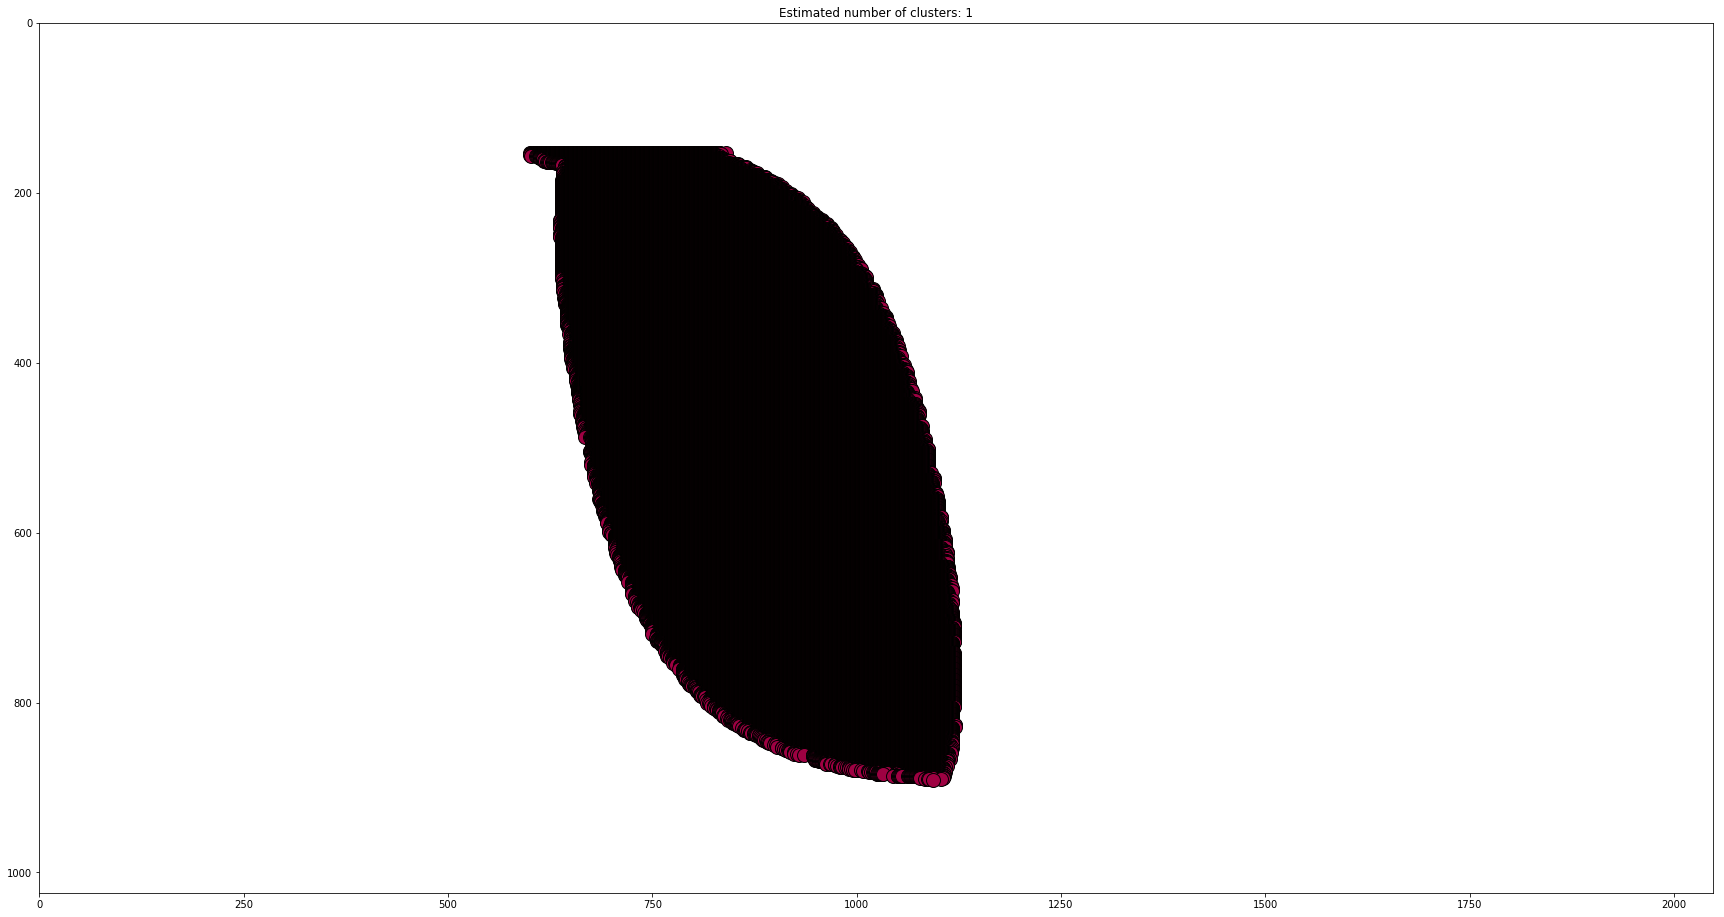

2015-12-21
Estimated number of clusters: 1
Writing labels to: data/4326/2015-12-21/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


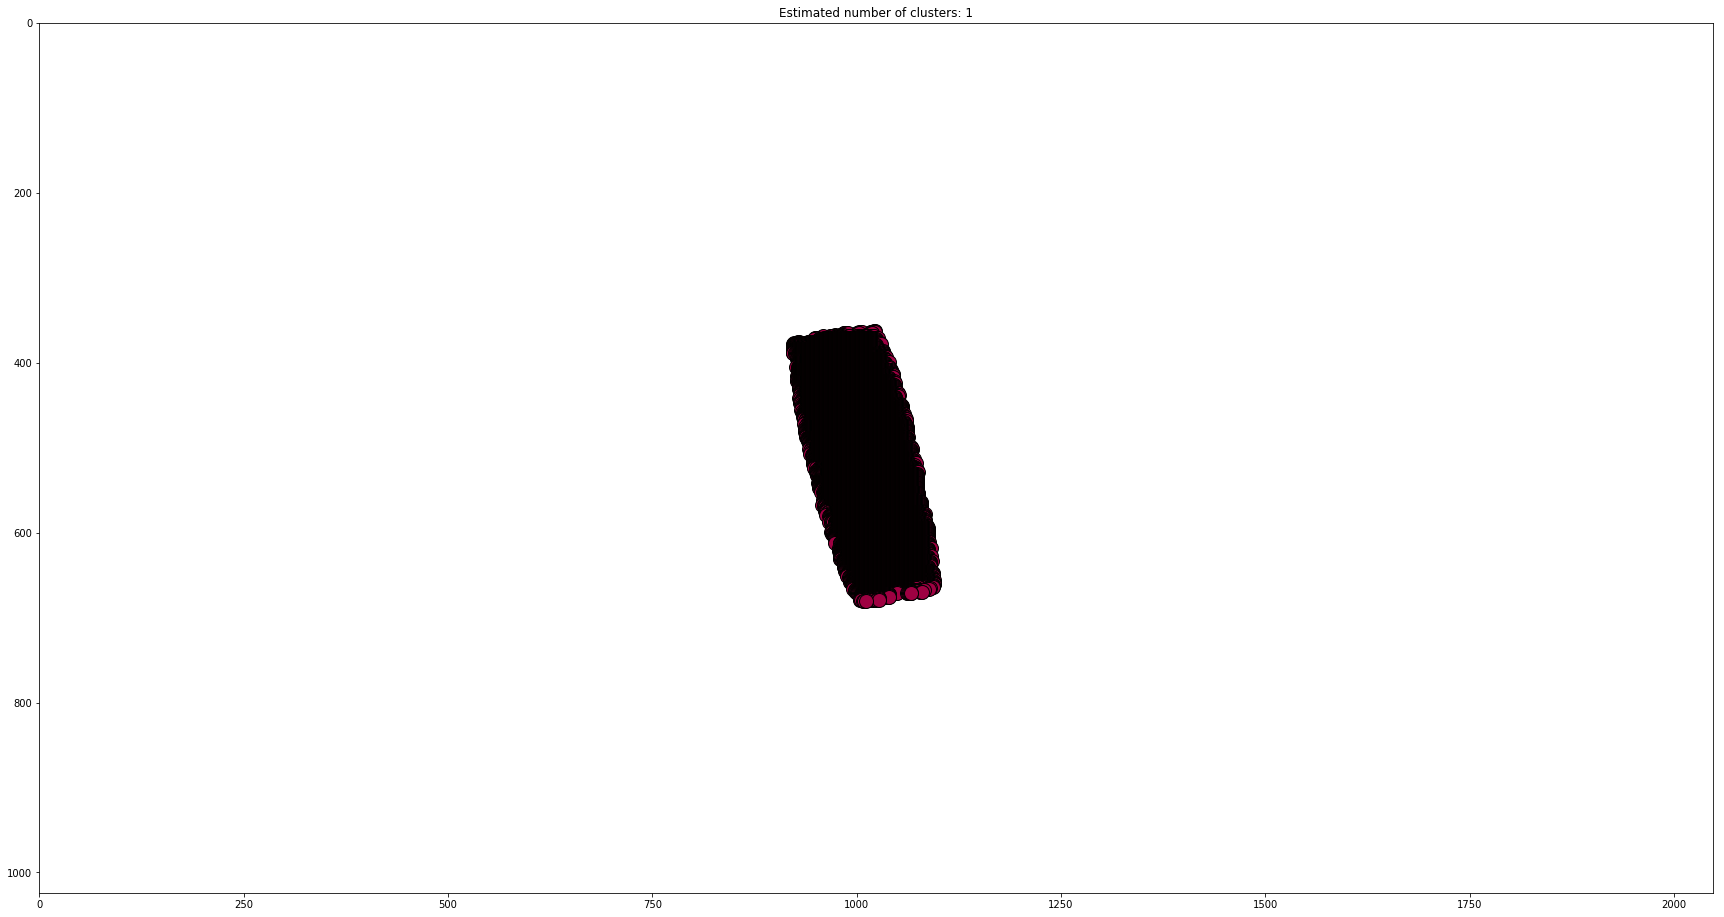

2015-12-23
Estimated number of clusters: 1
Writing labels to: data/4326/2015-12-23/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


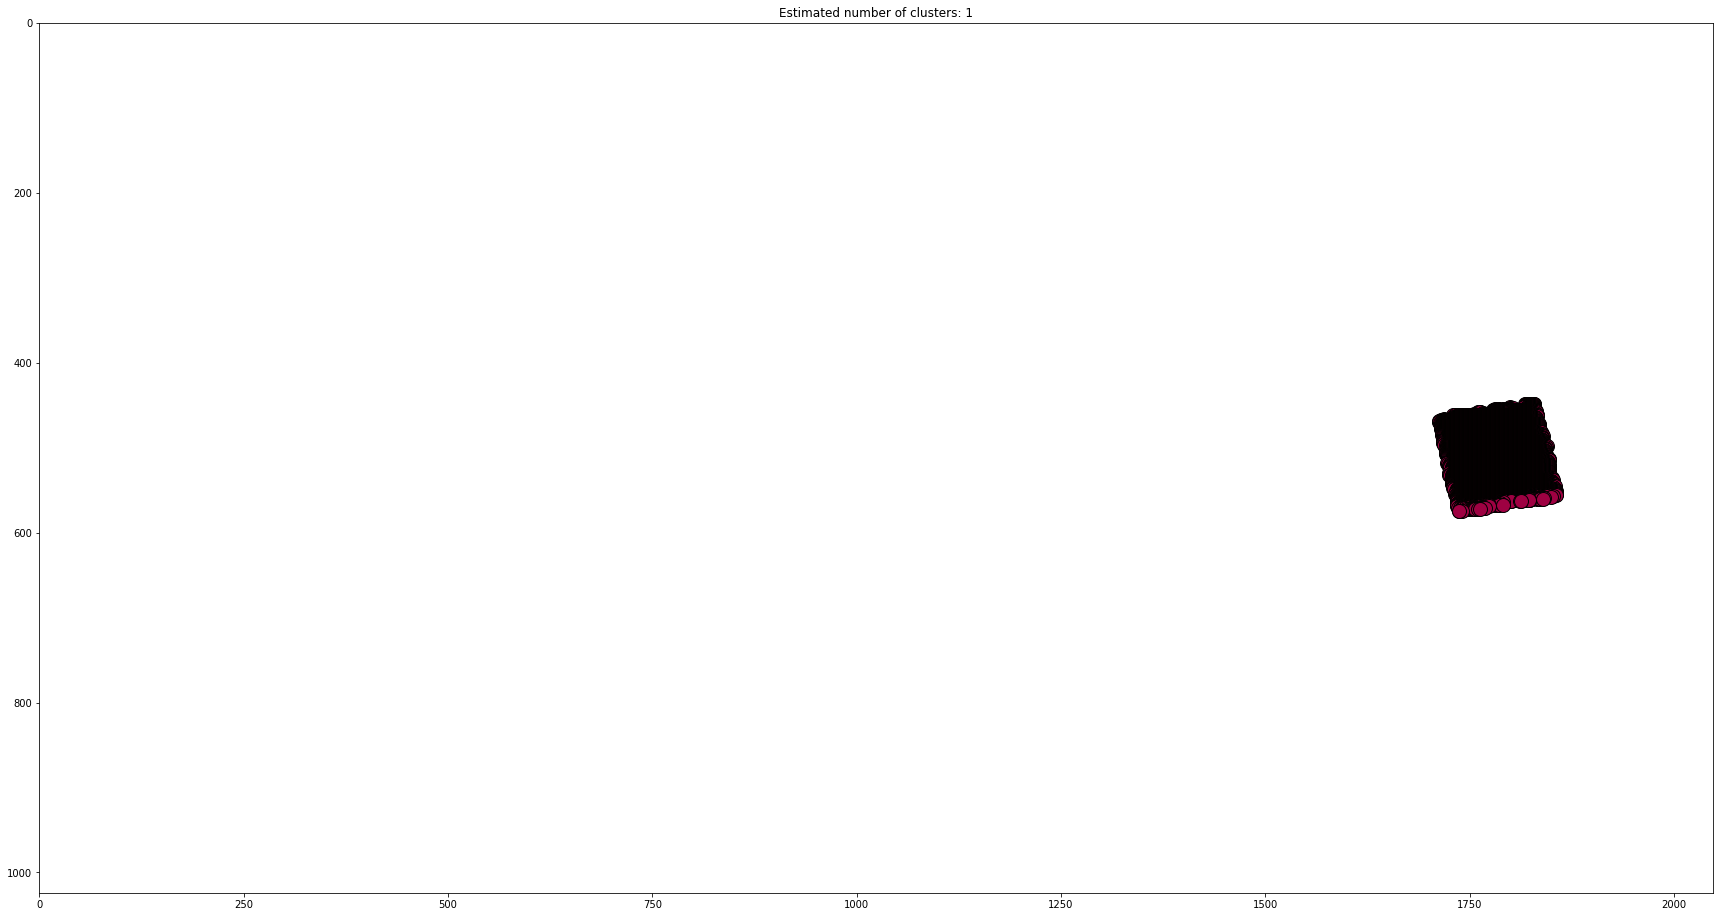

2016-01-11
Estimated number of clusters: 1
Writing labels to: data/4326/2016-01-11/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


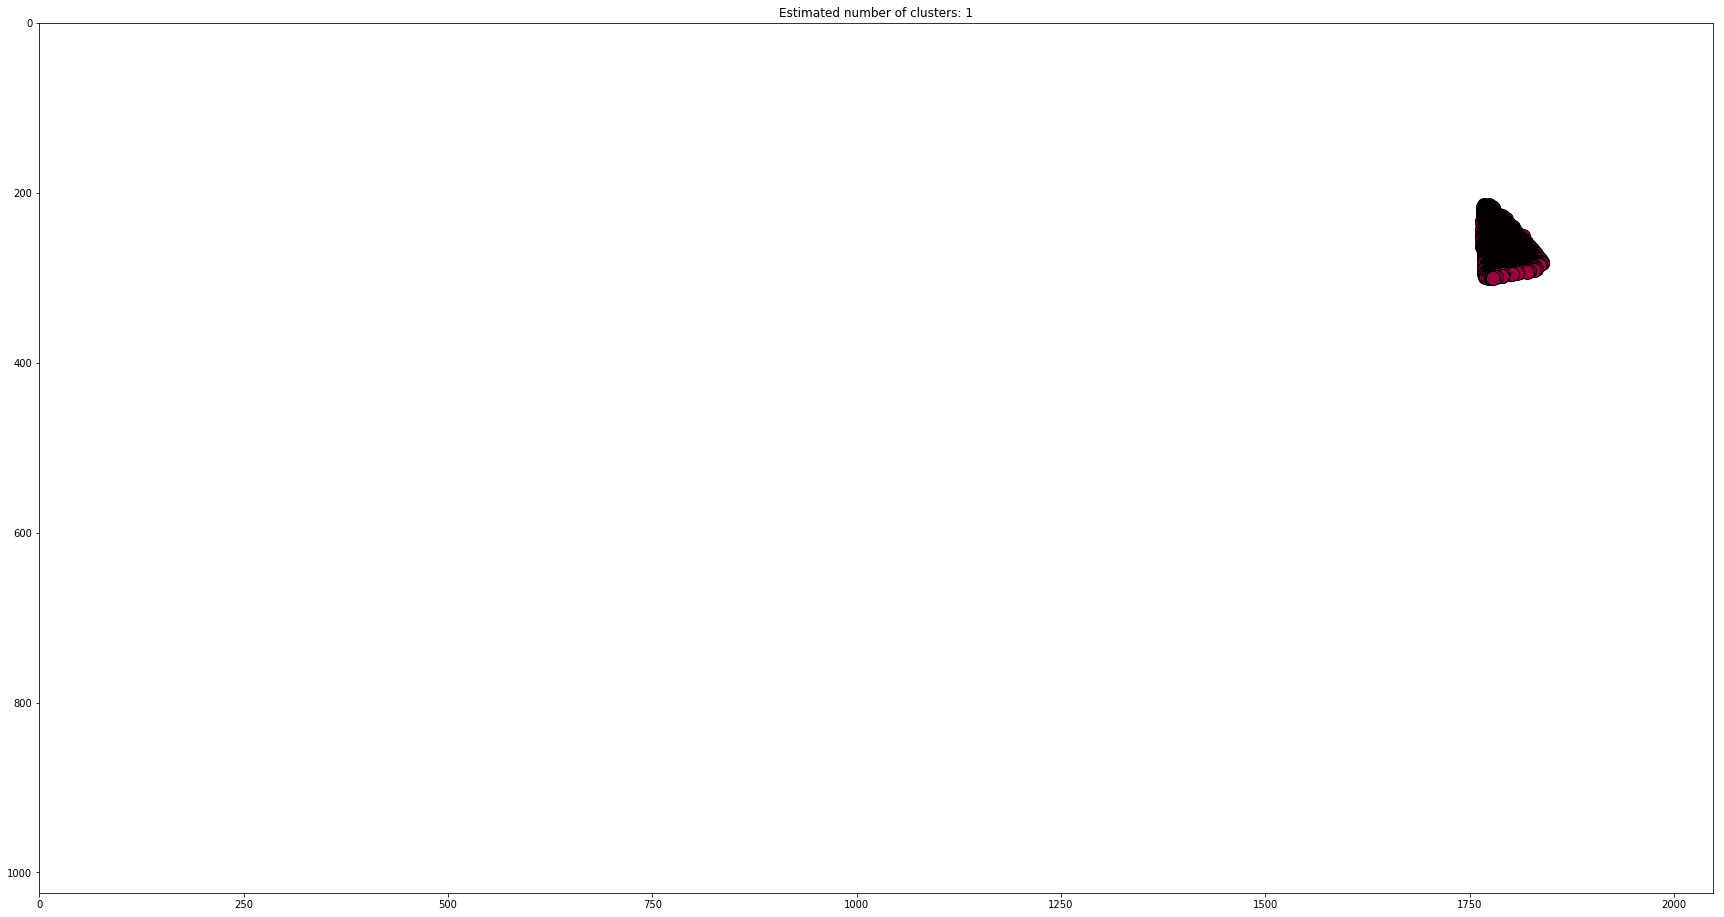

2016-01-14
Estimated number of clusters: 1
Writing labels to: data/4326/2016-01-14/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


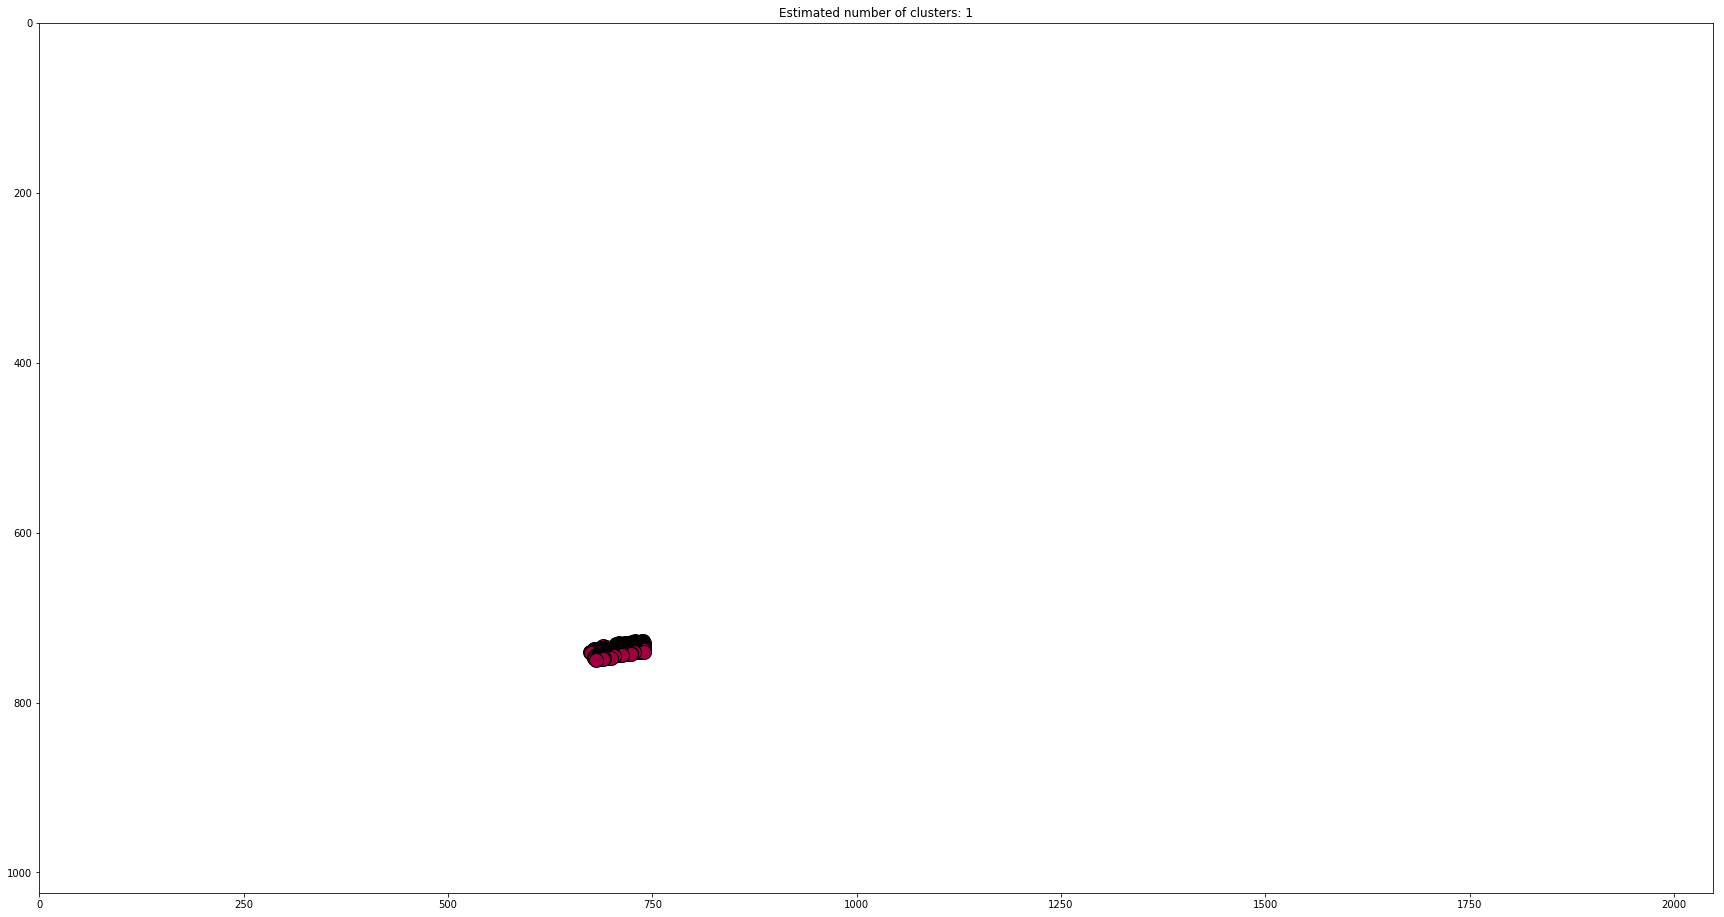

2016-01-18
Estimated number of clusters: 1
Writing labels to: data/4326/2016-01-18/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


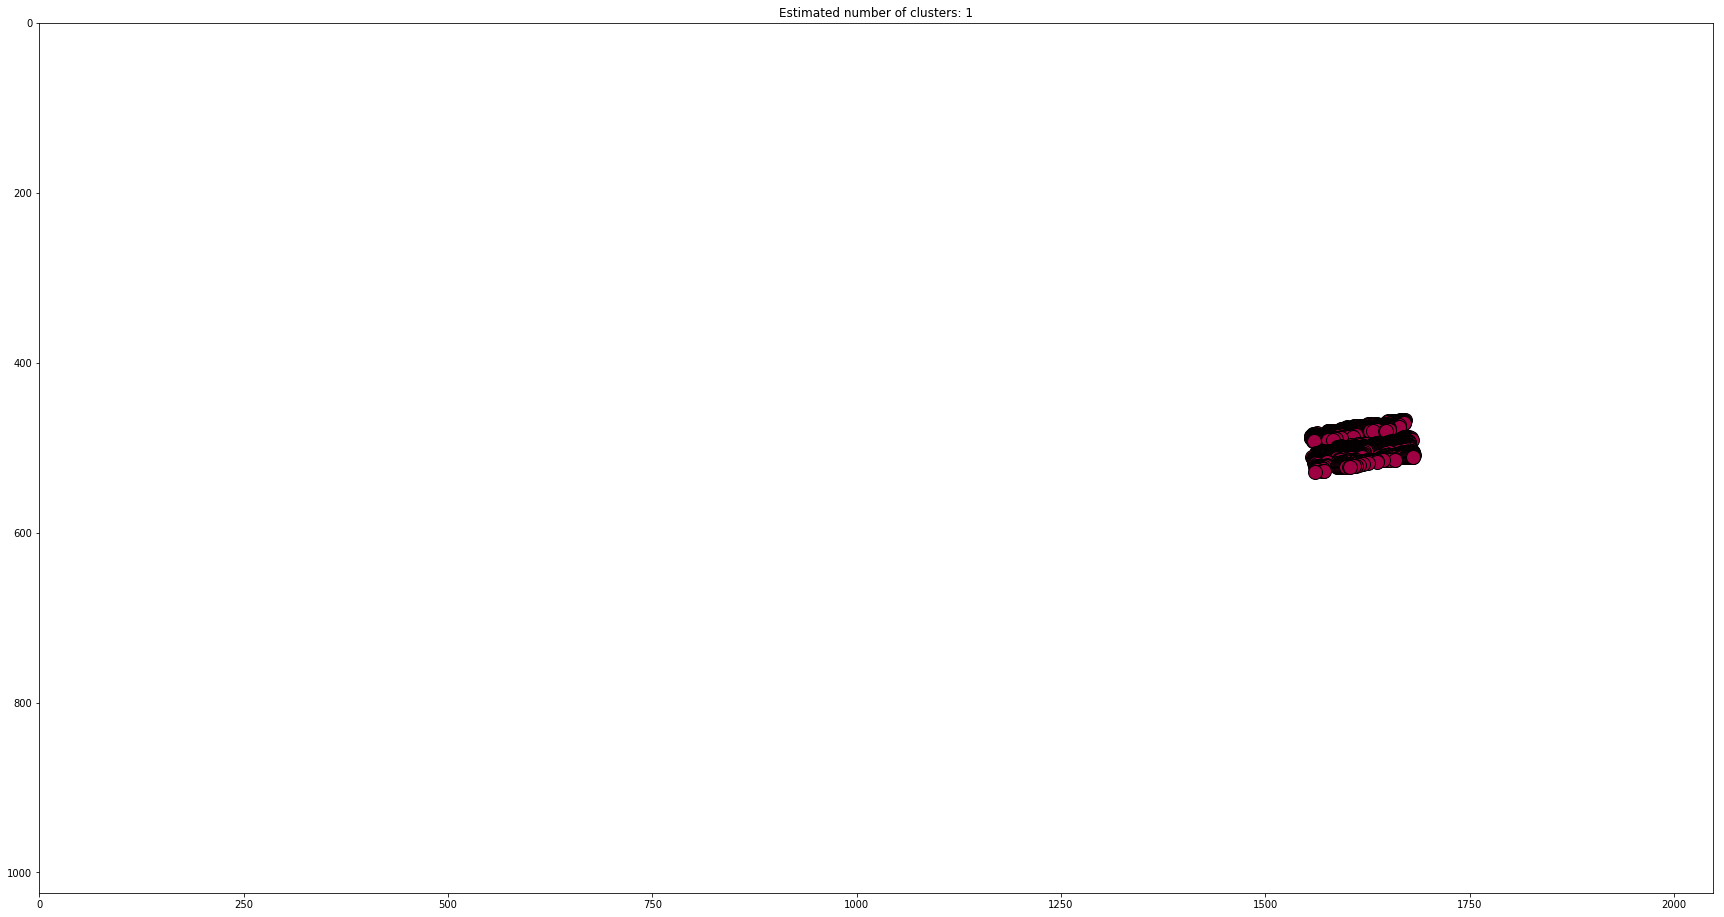

2016-01-19
Estimated number of clusters: 1
Writing labels to: data/4326/2016-01-19/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


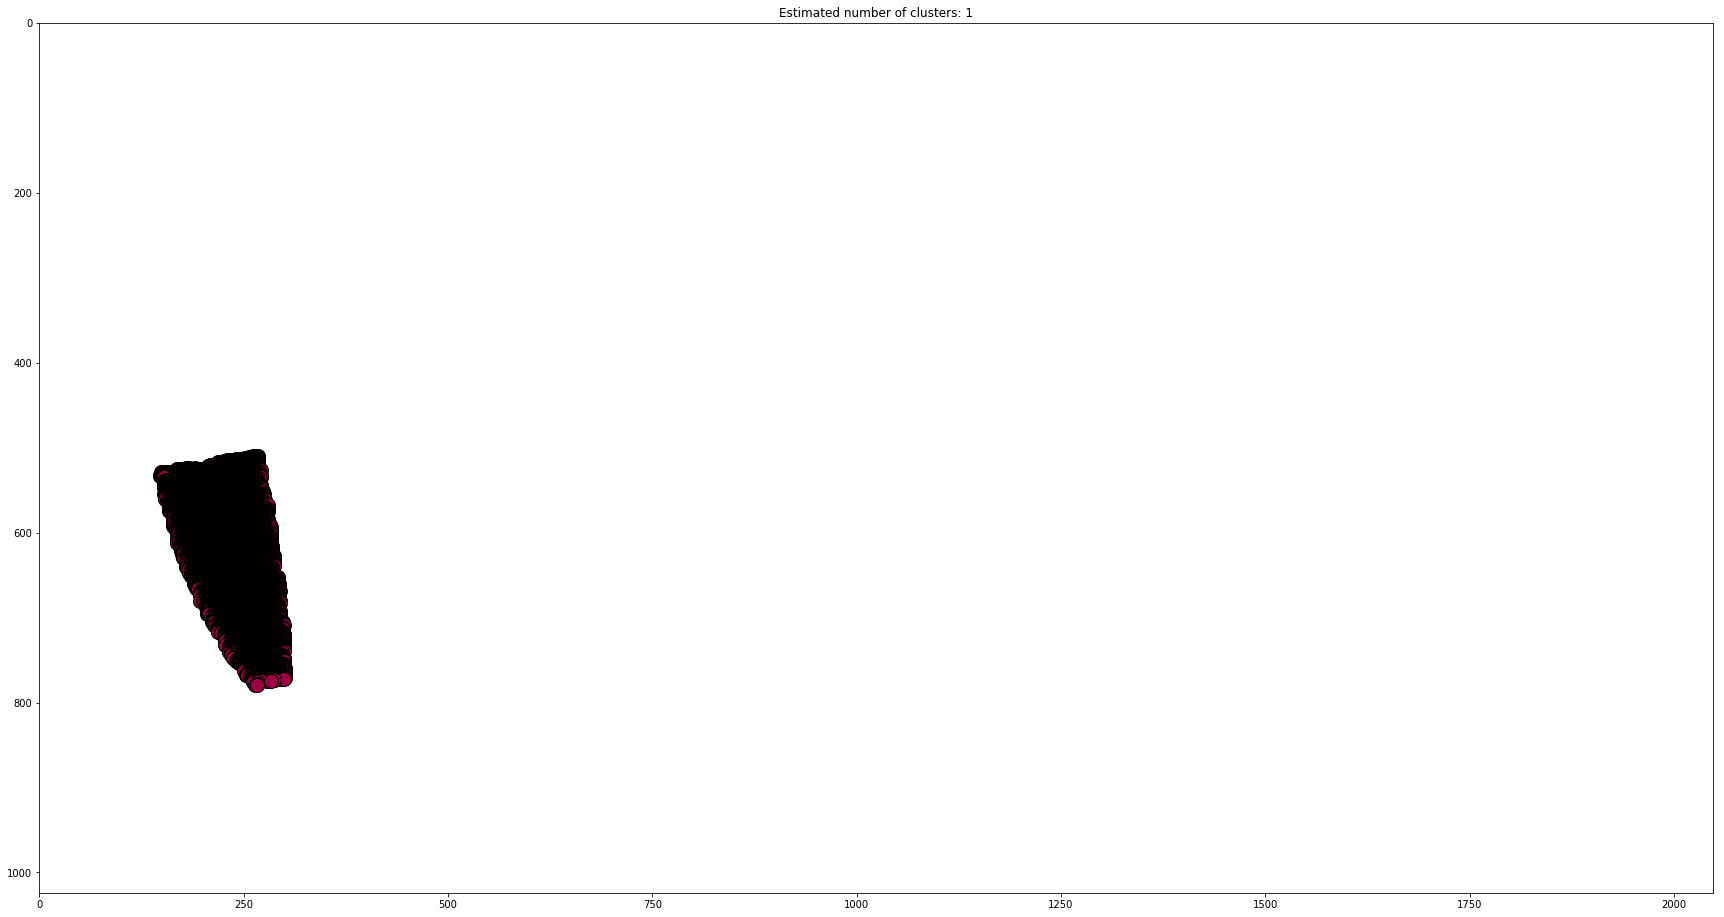

2016-01-30
Estimated number of clusters: 1
Writing labels to: data/4326/2016-01-30/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


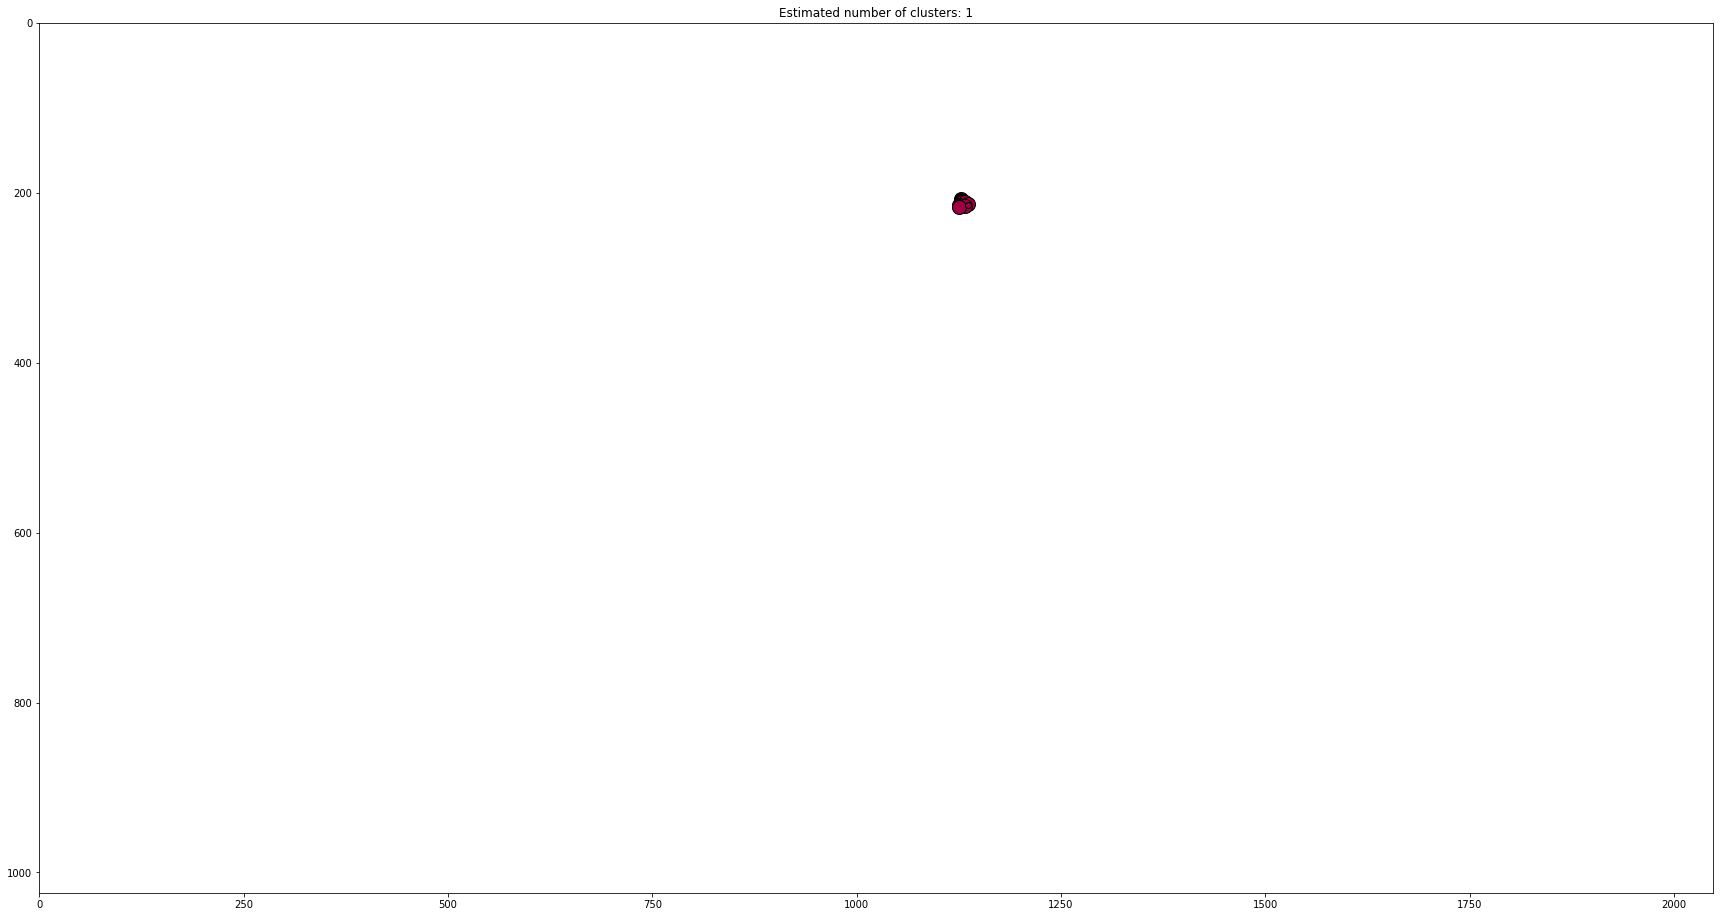

2016-02-06
Estimated number of clusters: 1
Writing labels to: data/4326/2016-02-06/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


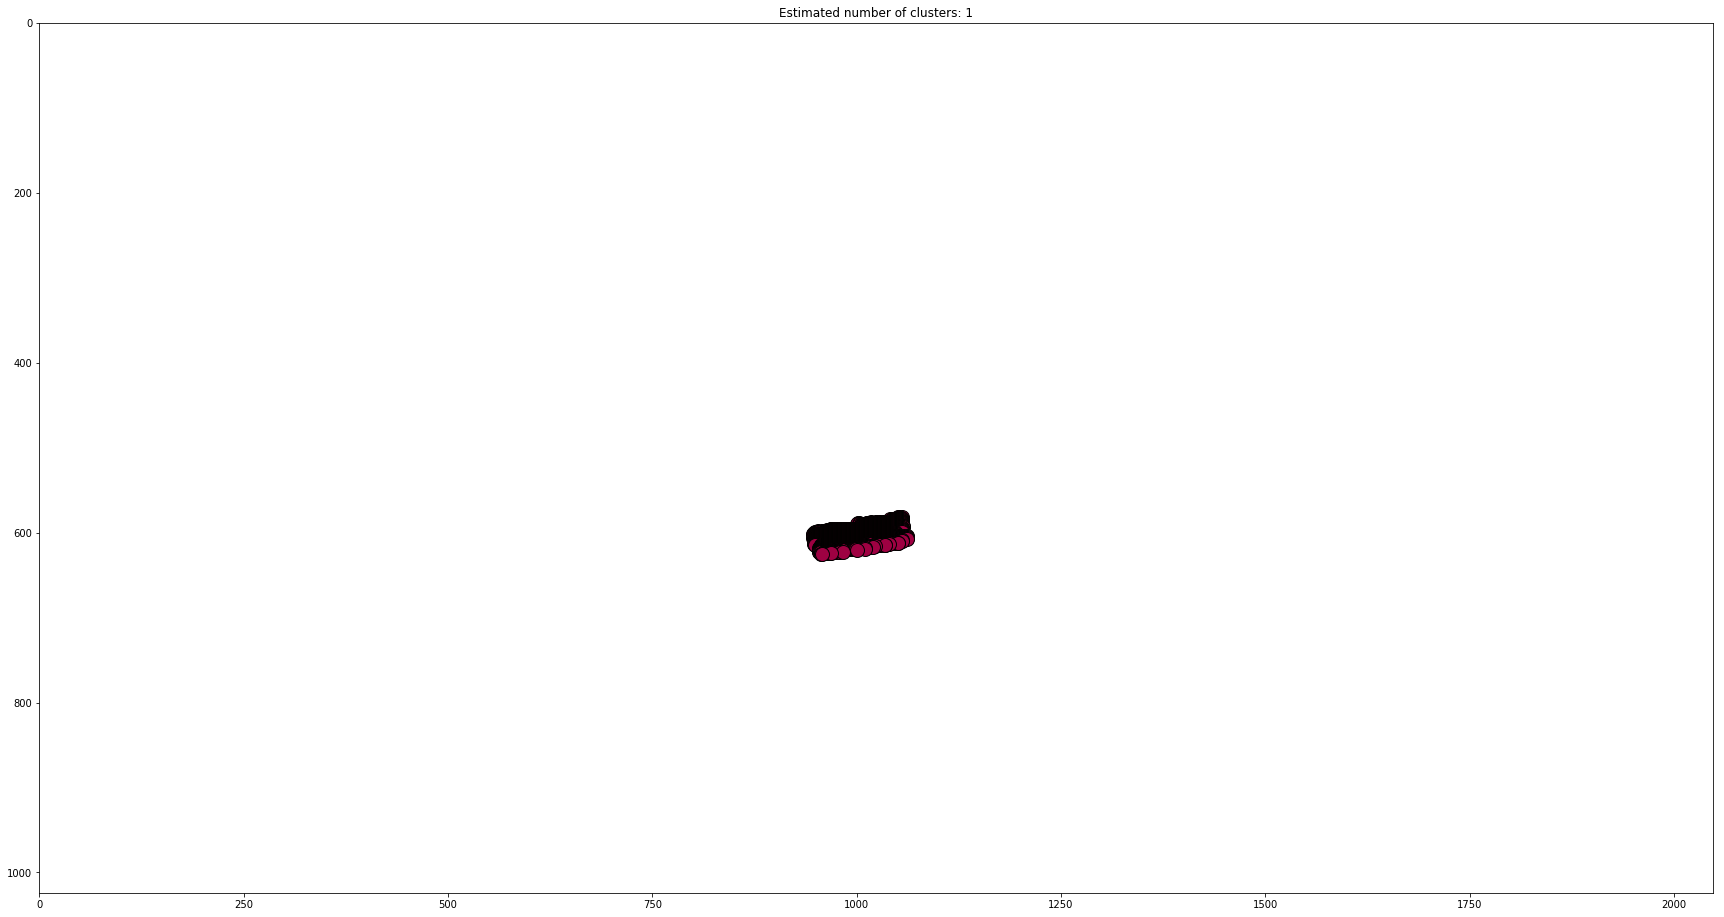

2016-02-07
Estimated number of clusters: 0
Writing labels to: data/4326/2016-02-07/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


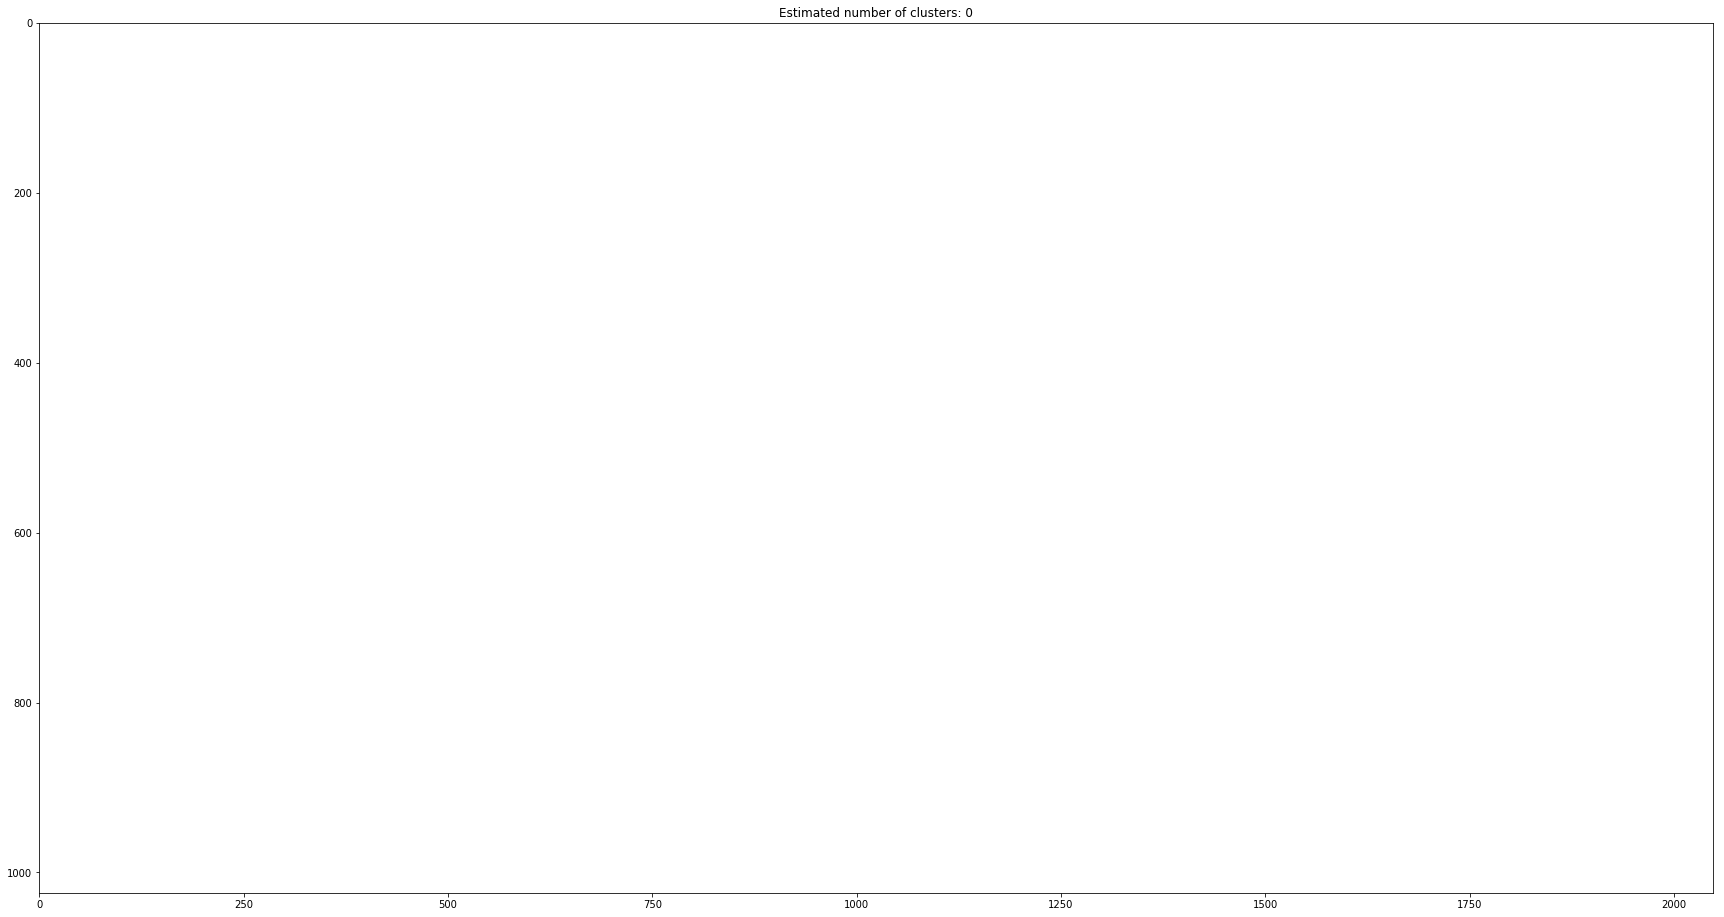

2016-02-18
Estimated number of clusters: 1
Writing labels to: data/4326/2016-02-18/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


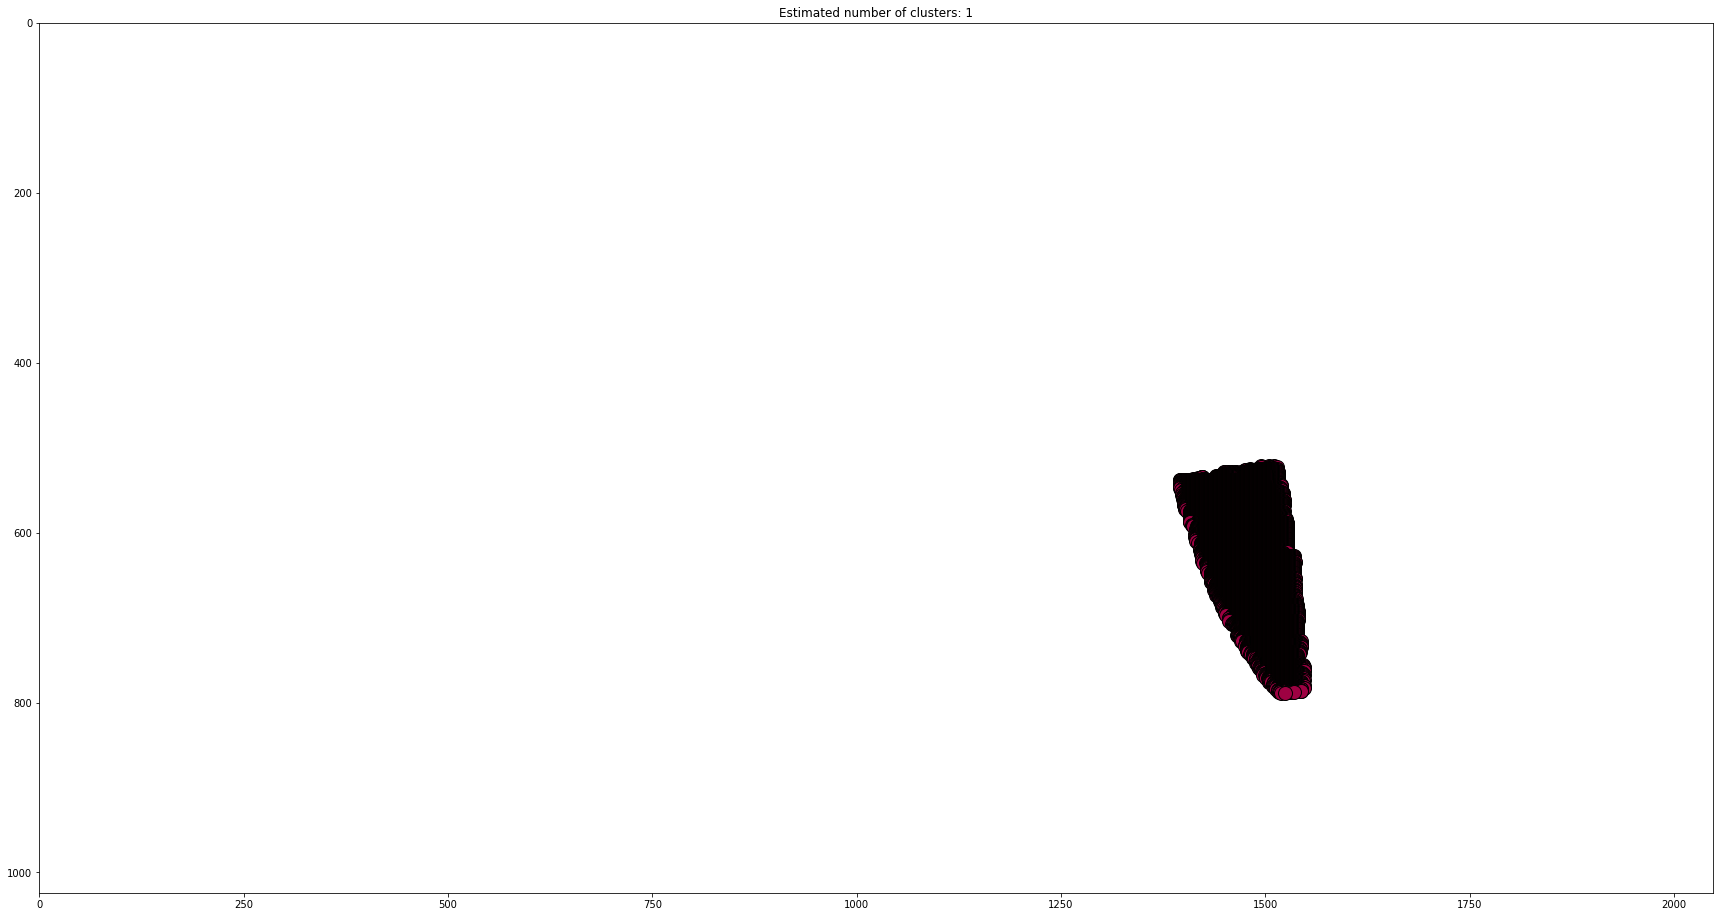

2016-03-18
Estimated number of clusters: 1
Writing labels to: data/4326/2016-03-18/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


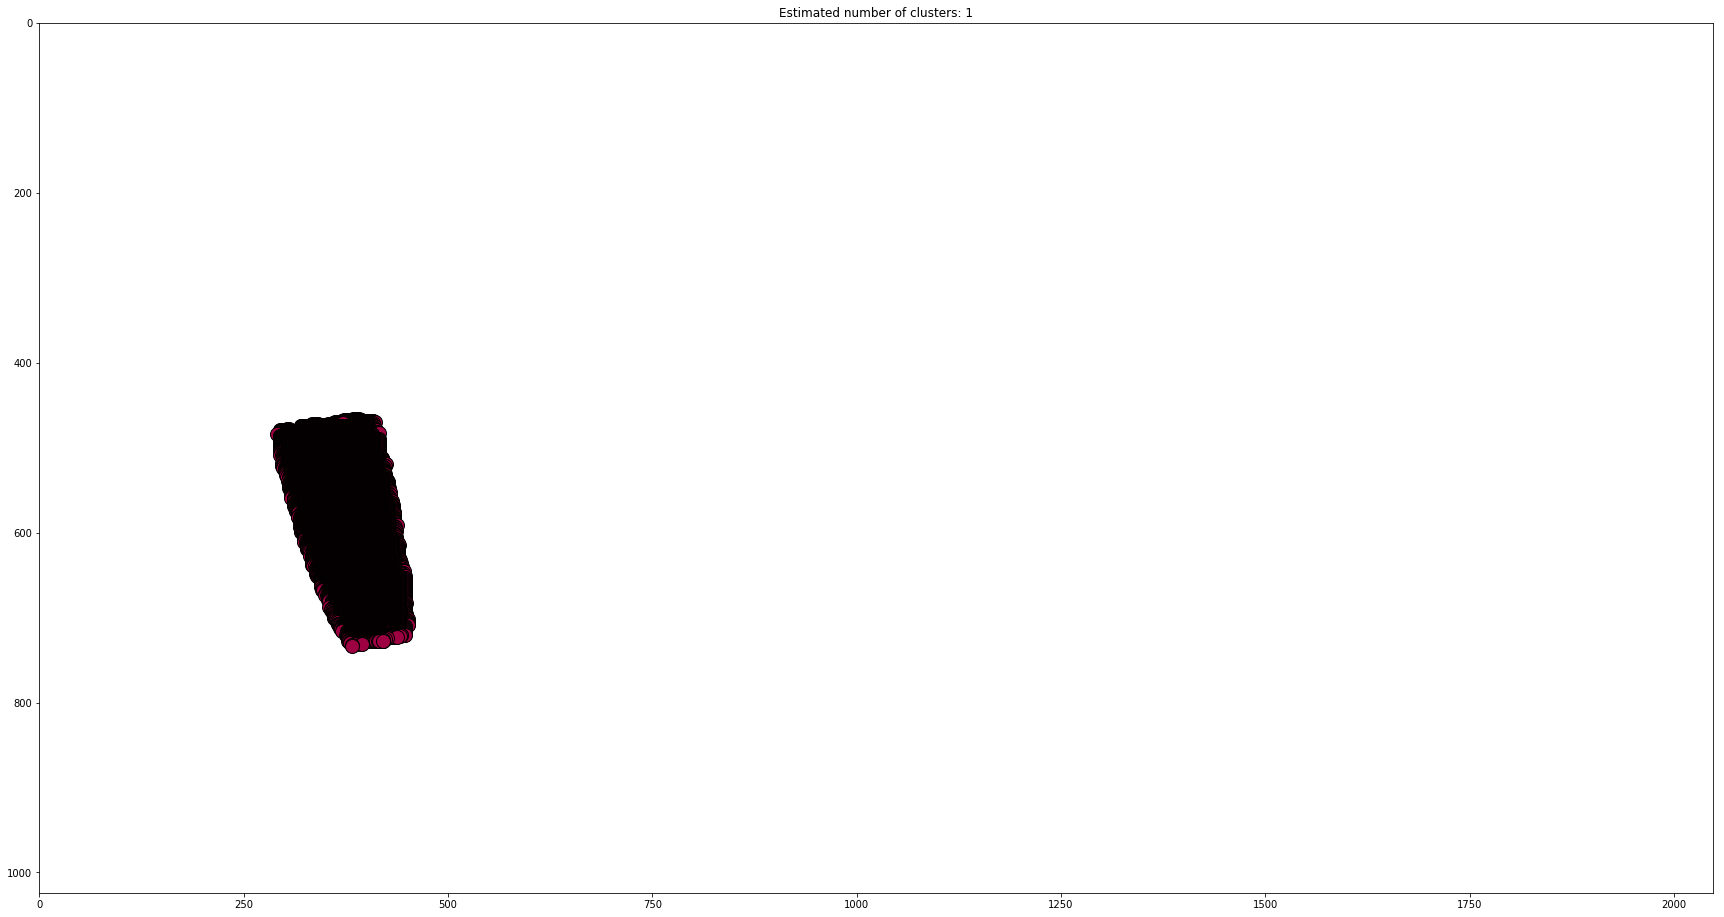

2016-03-31
Estimated number of clusters: 3
Writing labels to: data/4326/2016-03-31/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


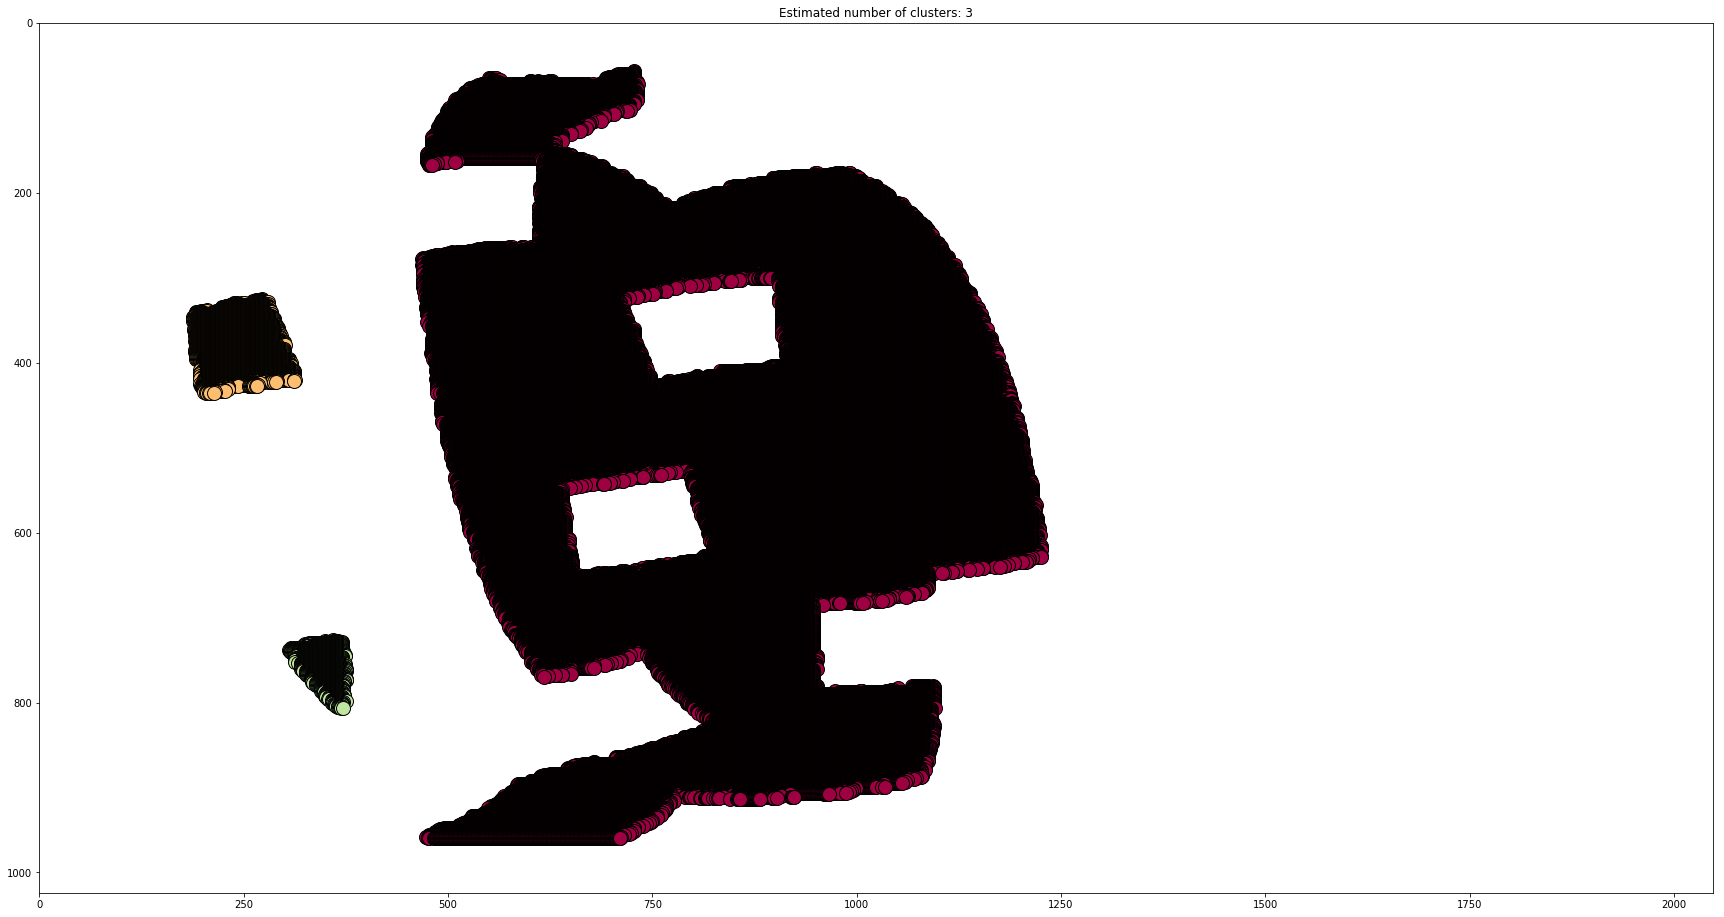

2016-04-01
Estimated number of clusters: 2
Writing labels to: data/4326/2016-04-01/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


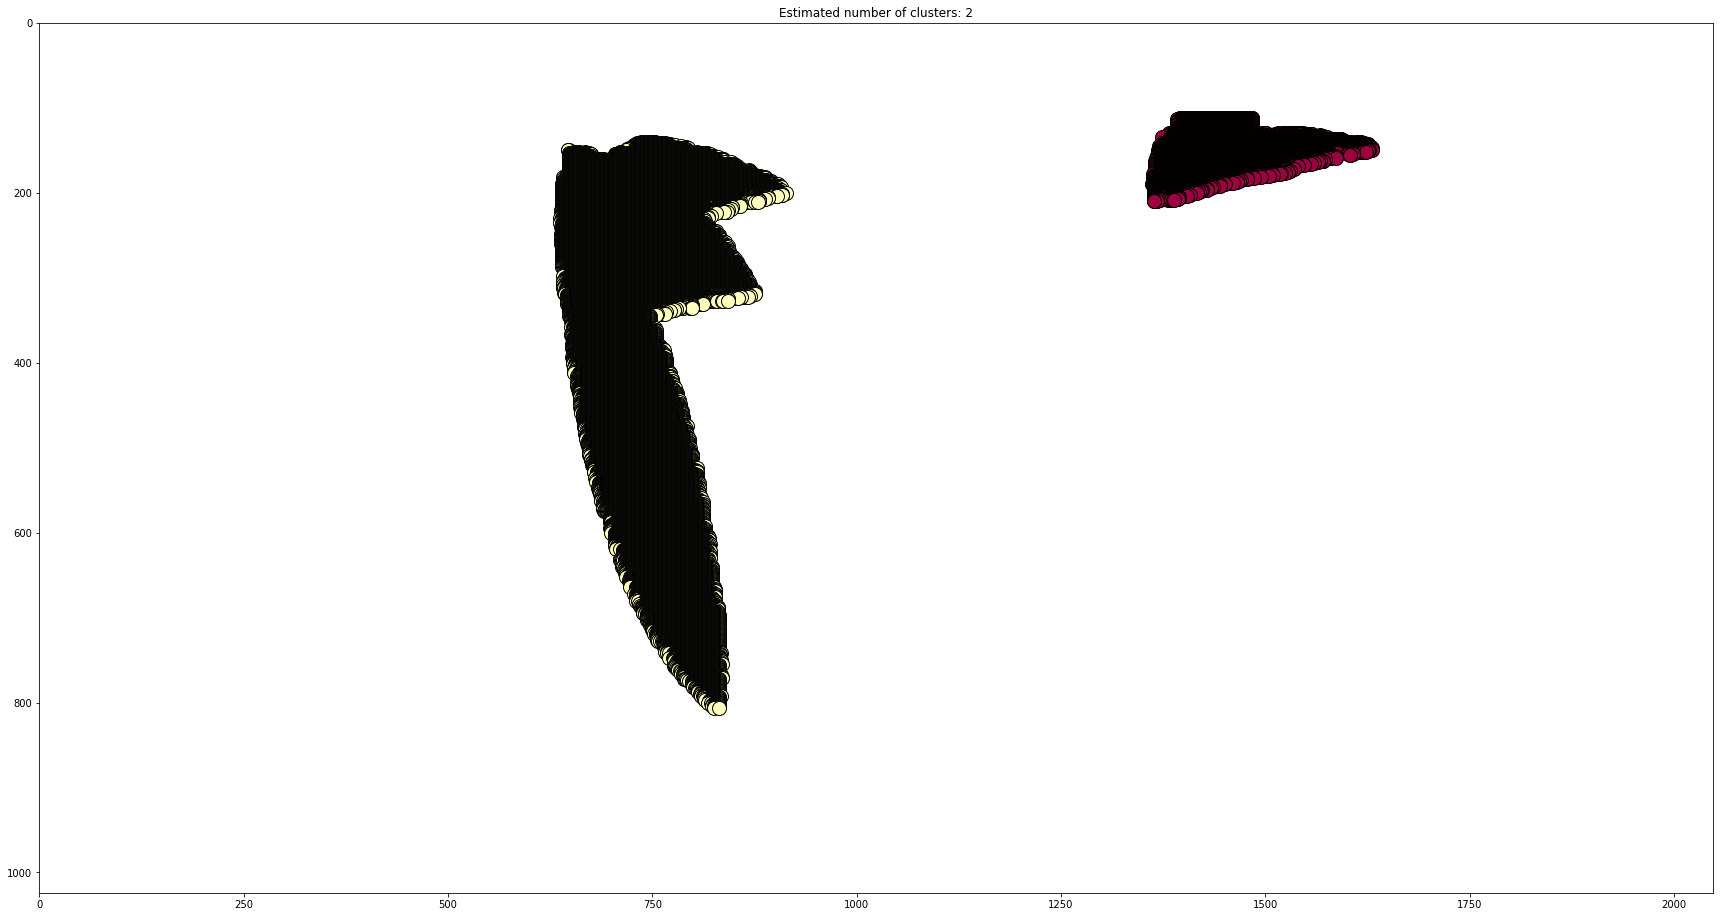

2016-04-02
Estimated number of clusters: 2
Writing labels to: data/4326/2016-04-02/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


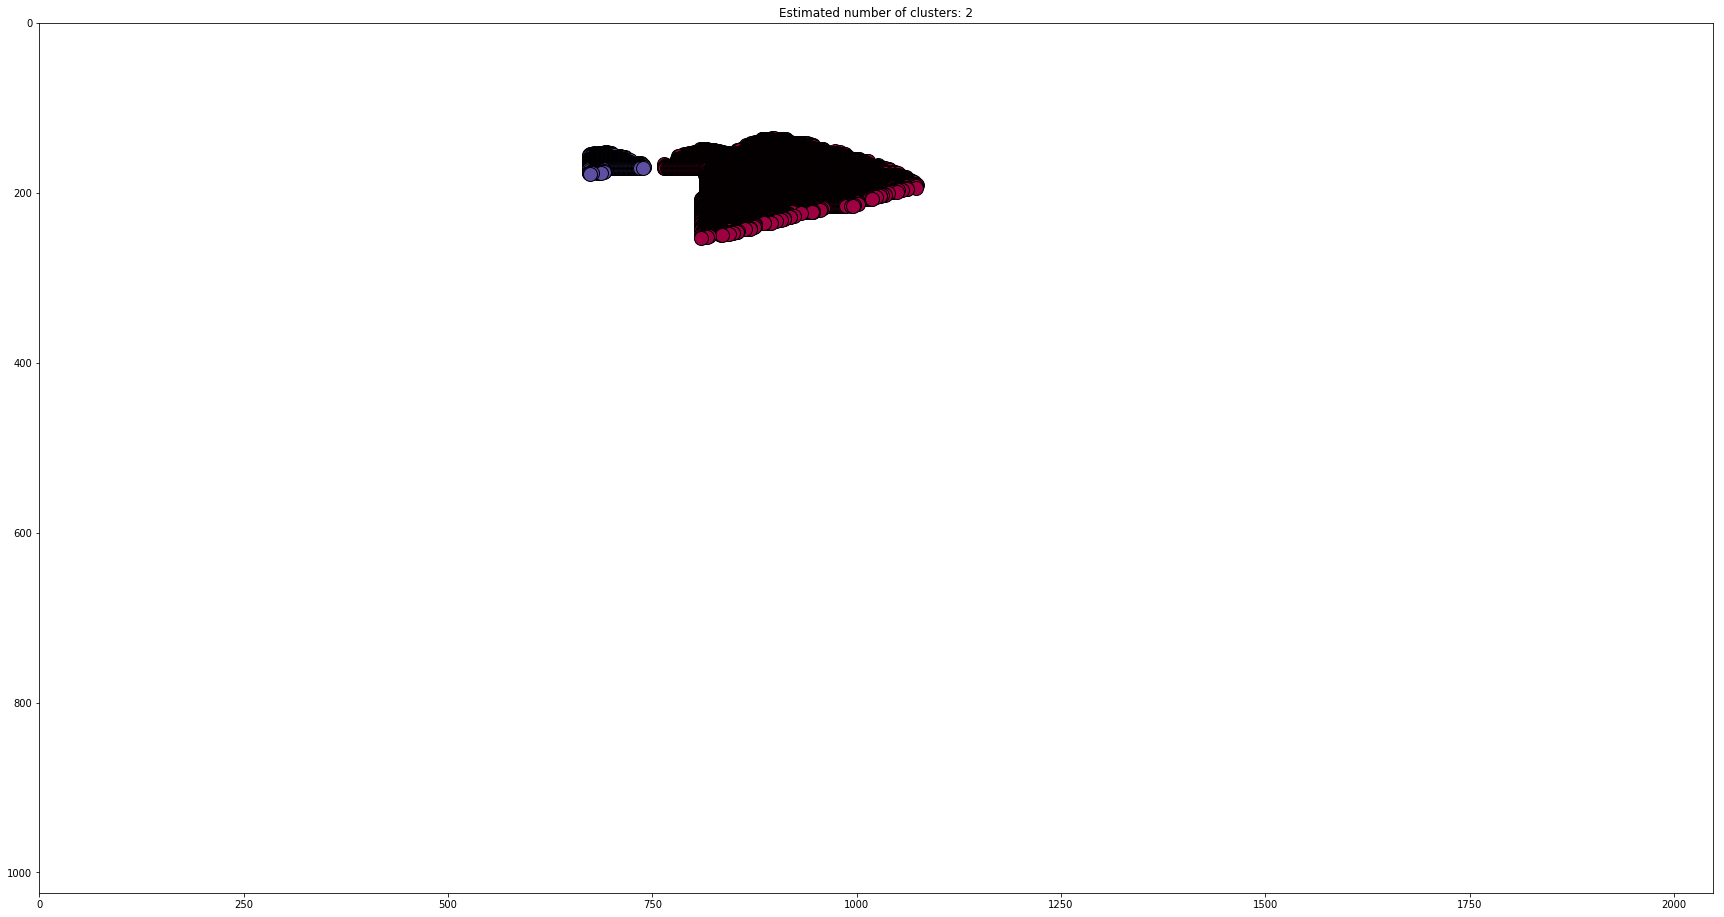

2016-04-03
Estimated number of clusters: 0
Writing labels to: data/4326/2016-04-03/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


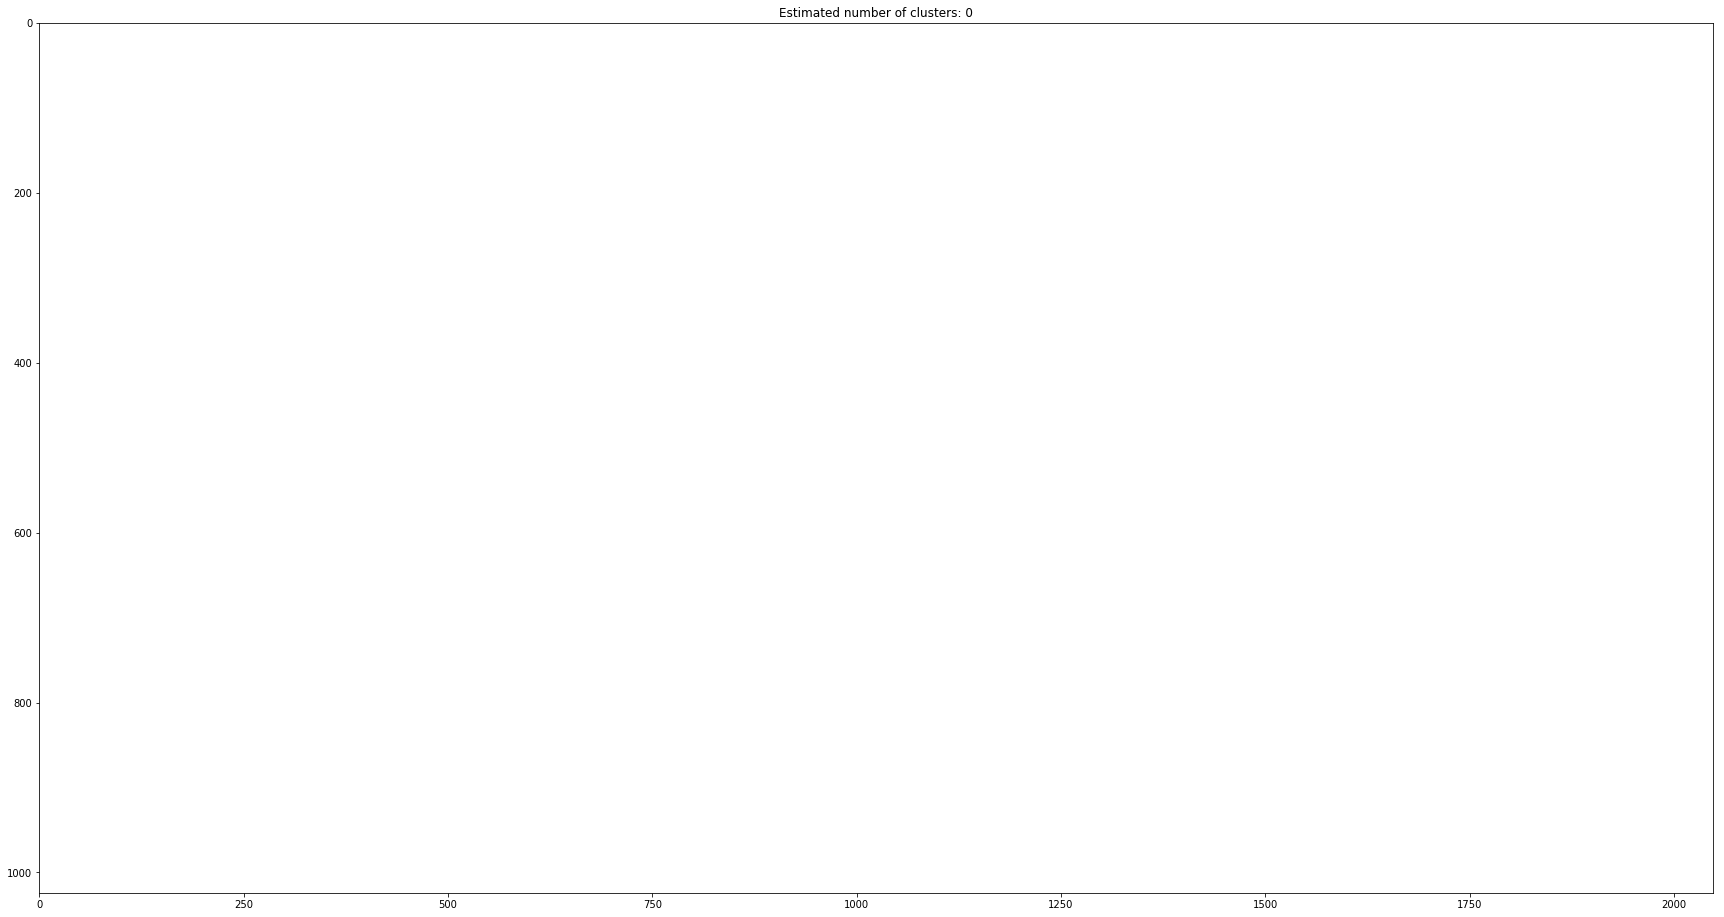

2016-04-05
Estimated number of clusters: 1
Writing labels to: data/4326/2016-04-05/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


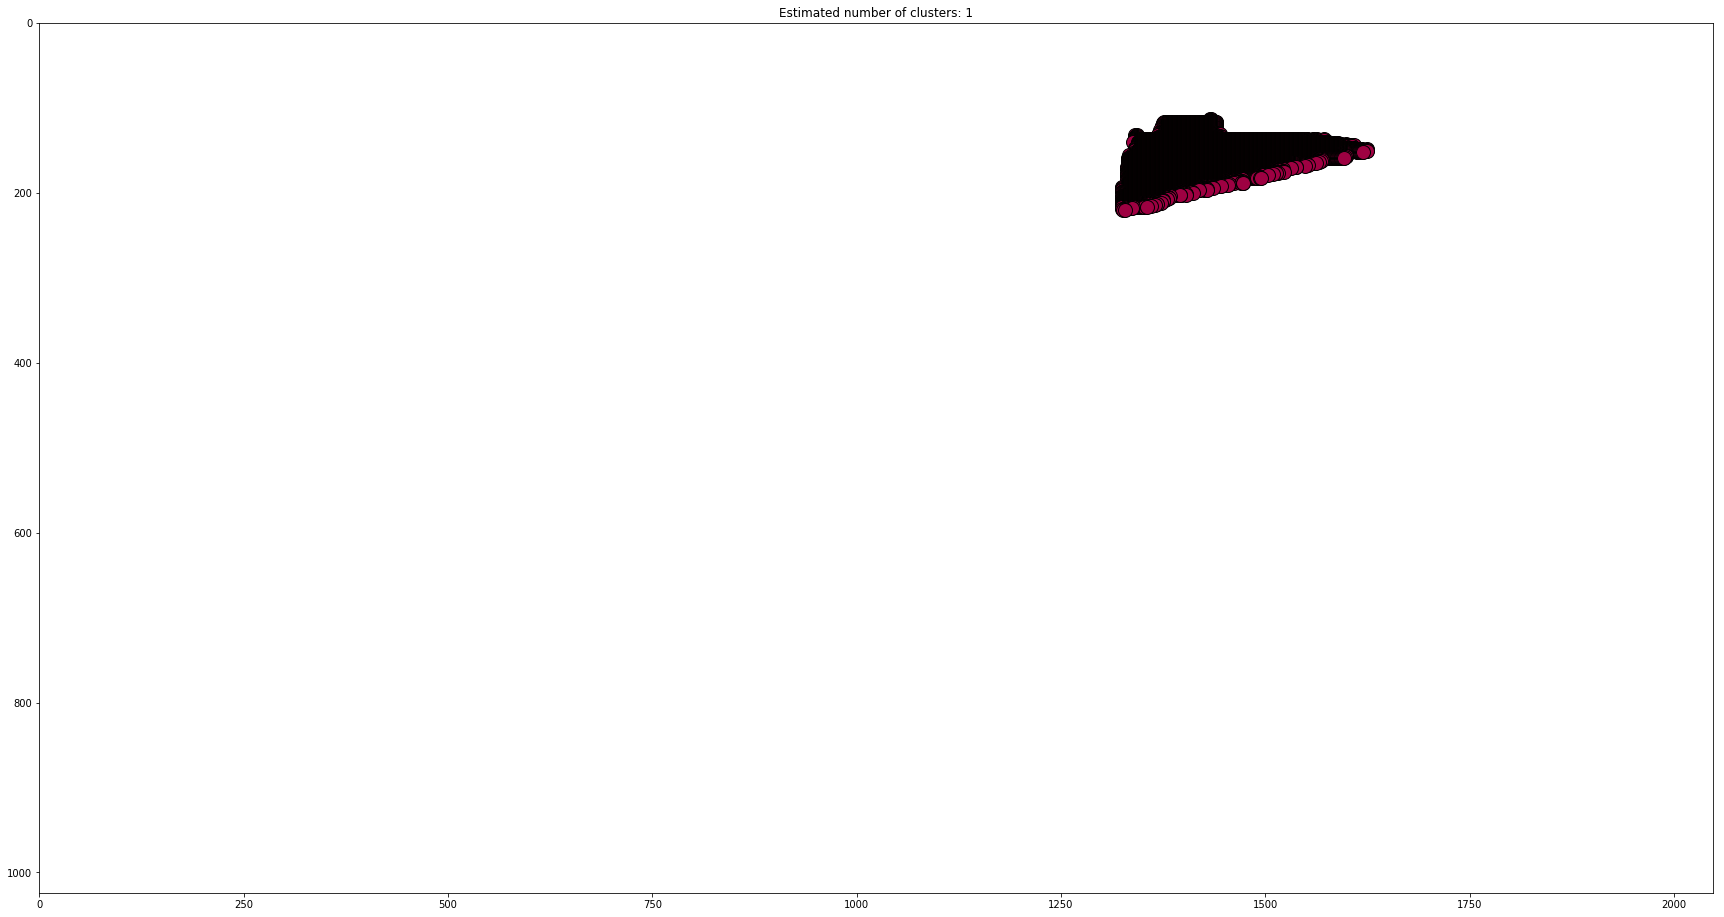

2016-04-06
Estimated number of clusters: 1
Writing labels to: data/4326/2016-04-06/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


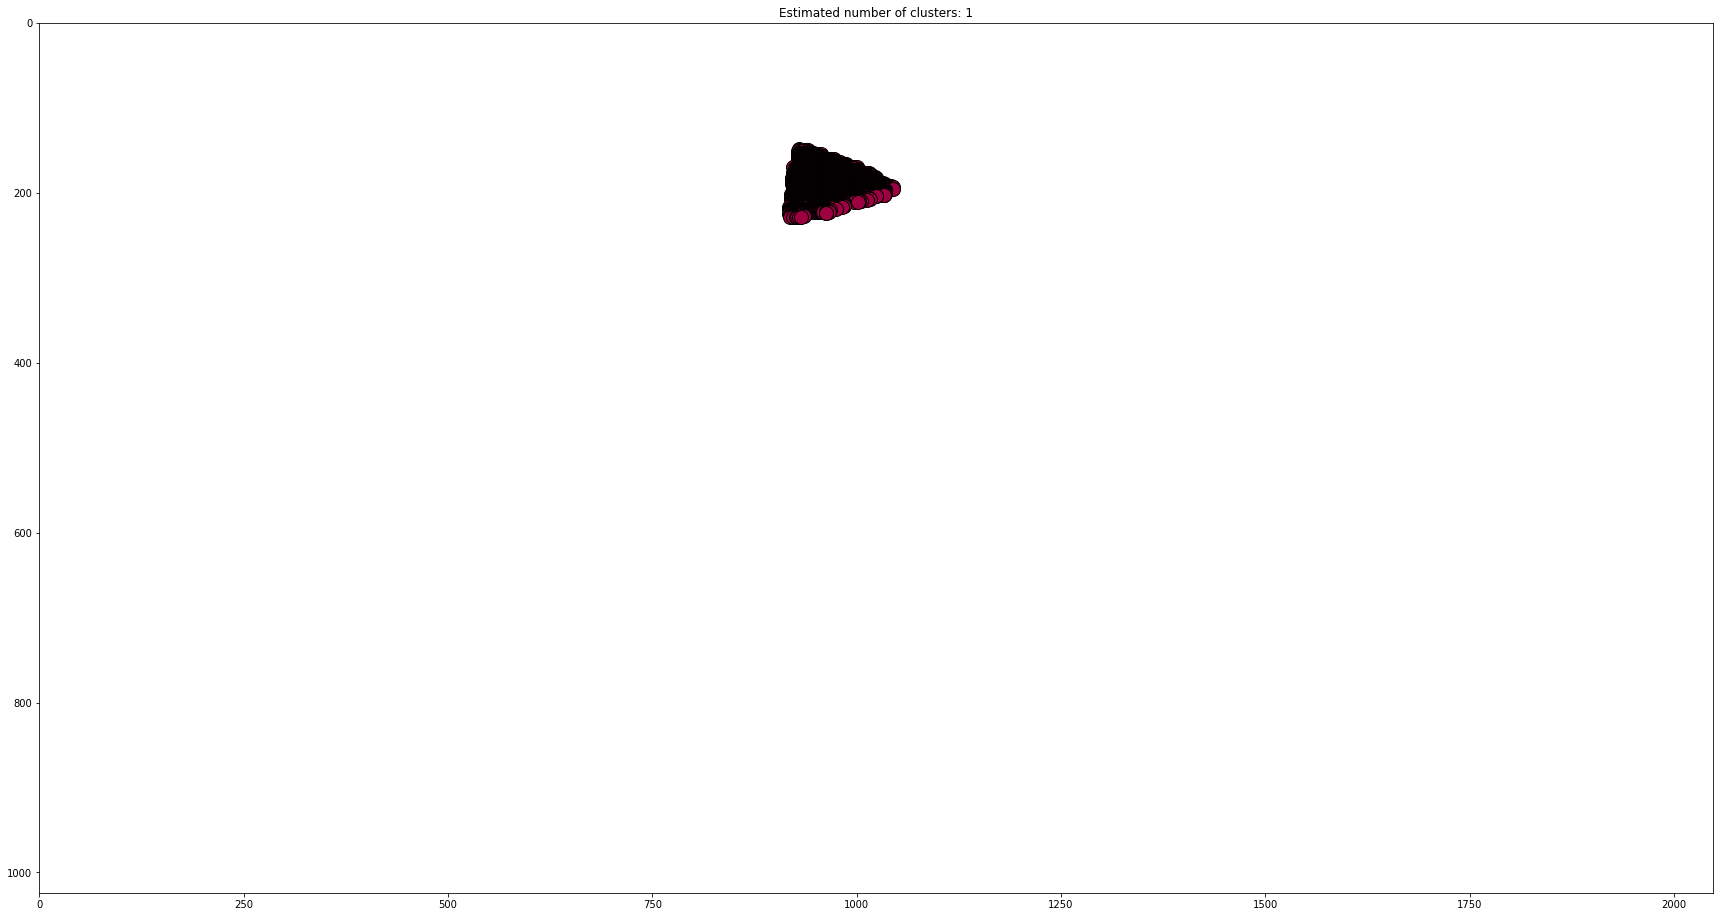

2016-04-07
Estimated number of clusters: 2
Writing labels to: data/4326/2016-04-07/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


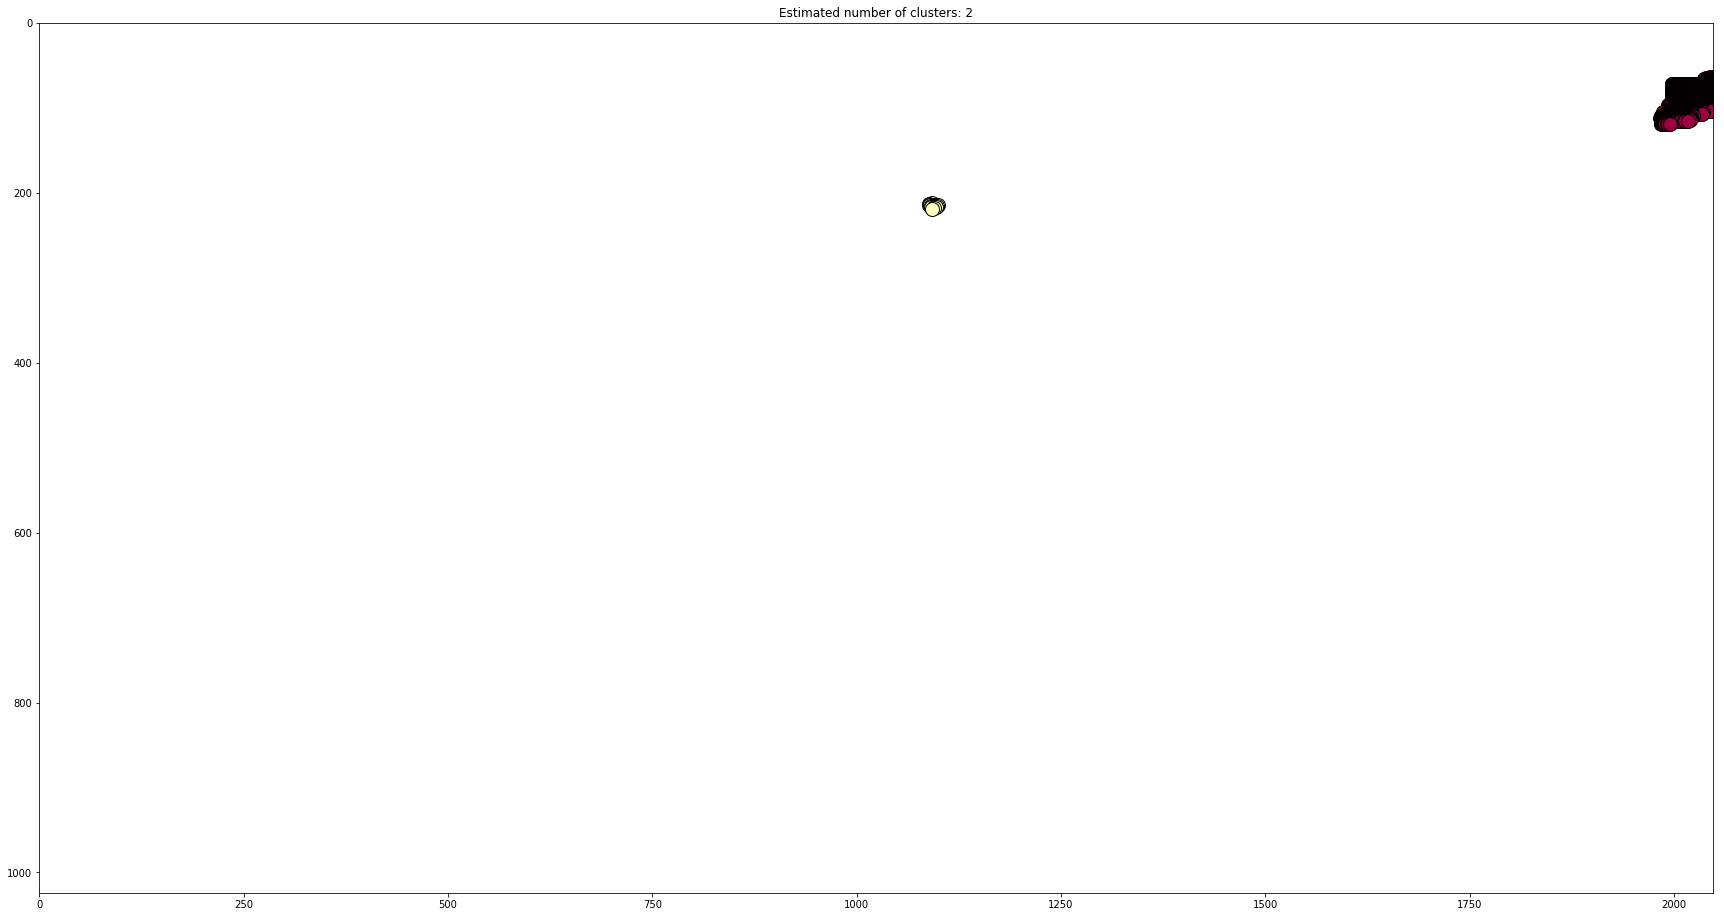

2016-04-09
Estimated number of clusters: 2
Writing labels to: data/4326/2016-04-09/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


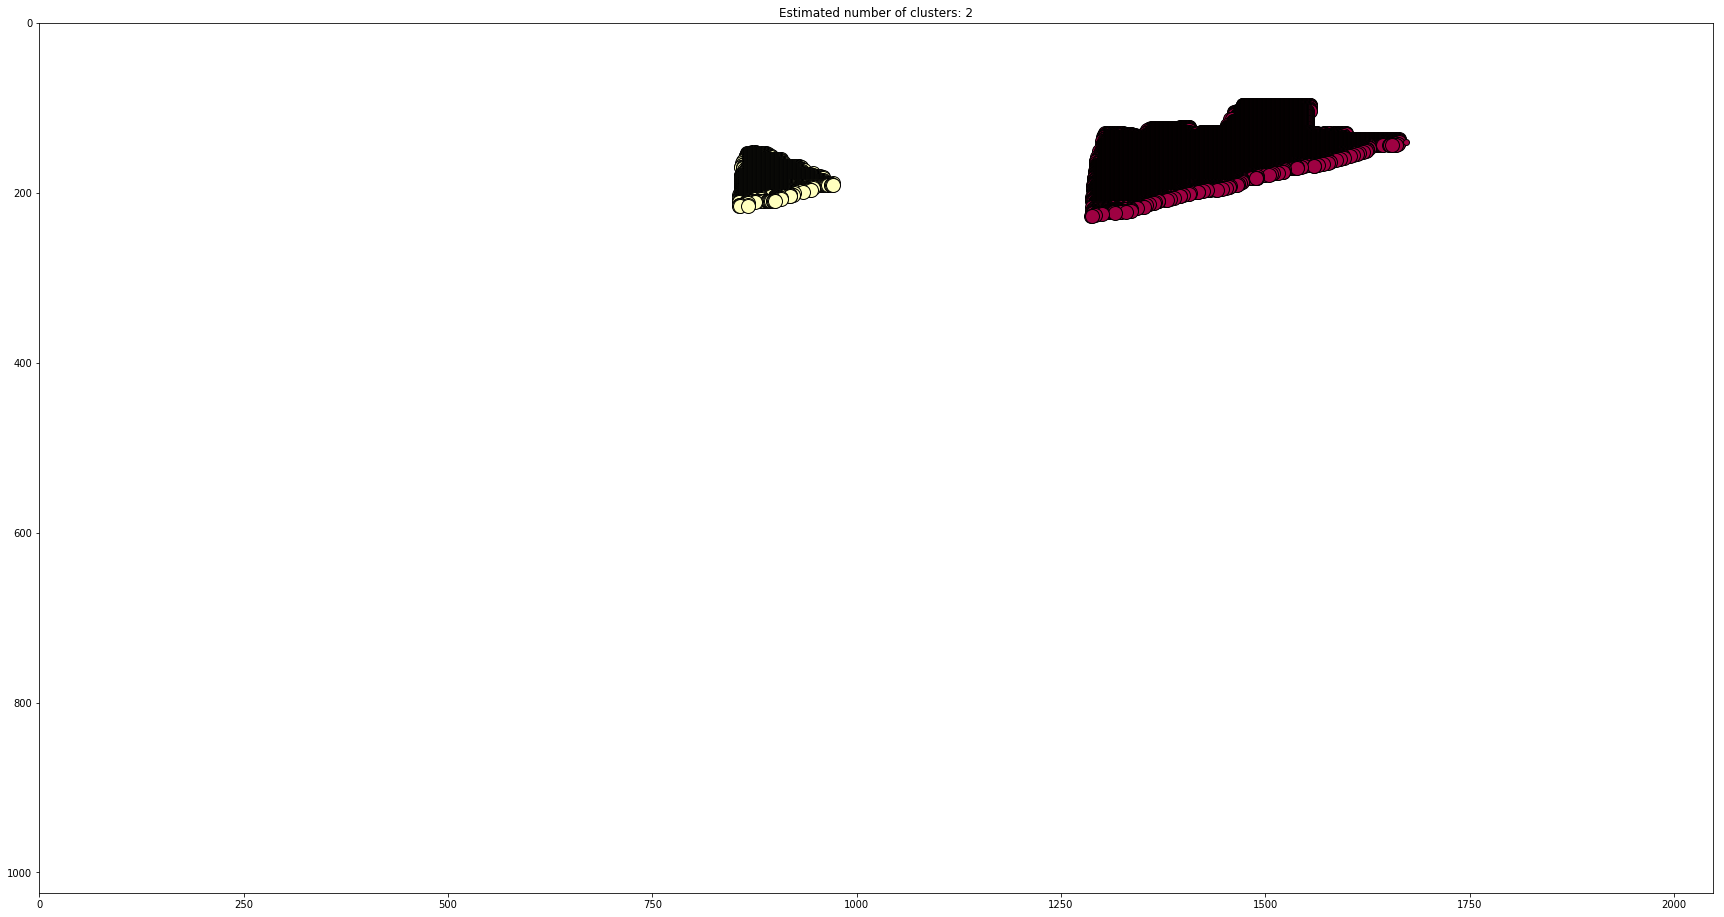

2016-04-10
Estimated number of clusters: 1
Writing labels to: data/4326/2016-04-10/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


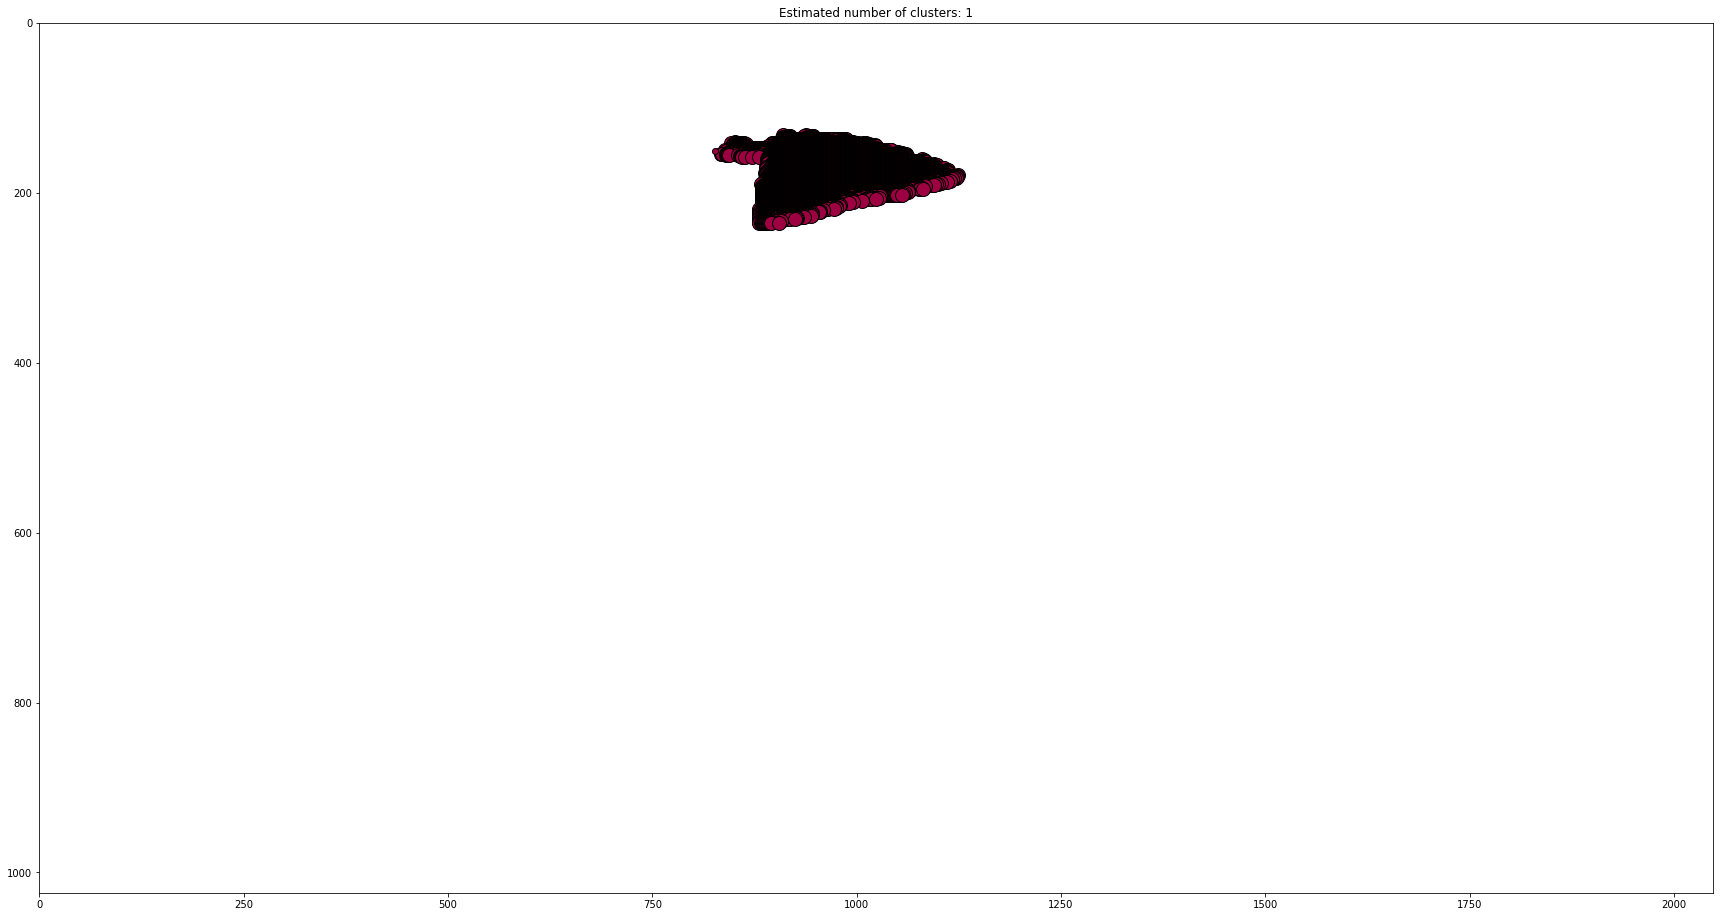

2016-04-12
Estimated number of clusters: 0
Writing labels to: data/4326/2016-04-12/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


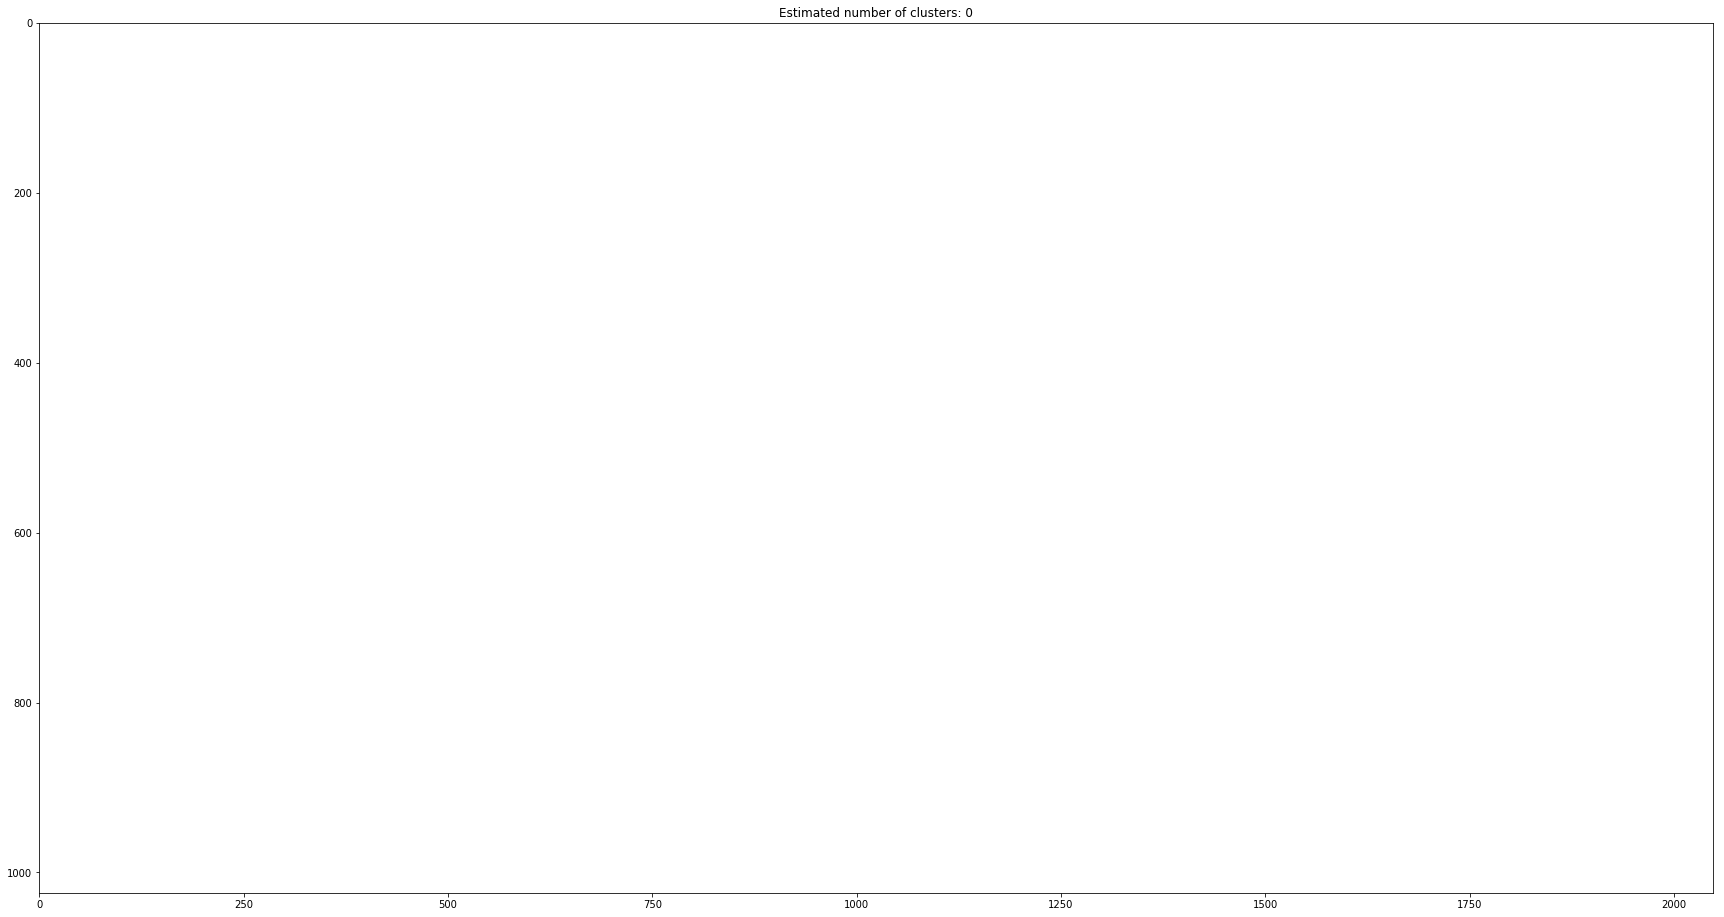

2016-04-13
Estimated number of clusters: 2
Writing labels to: data/4326/2016-04-13/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


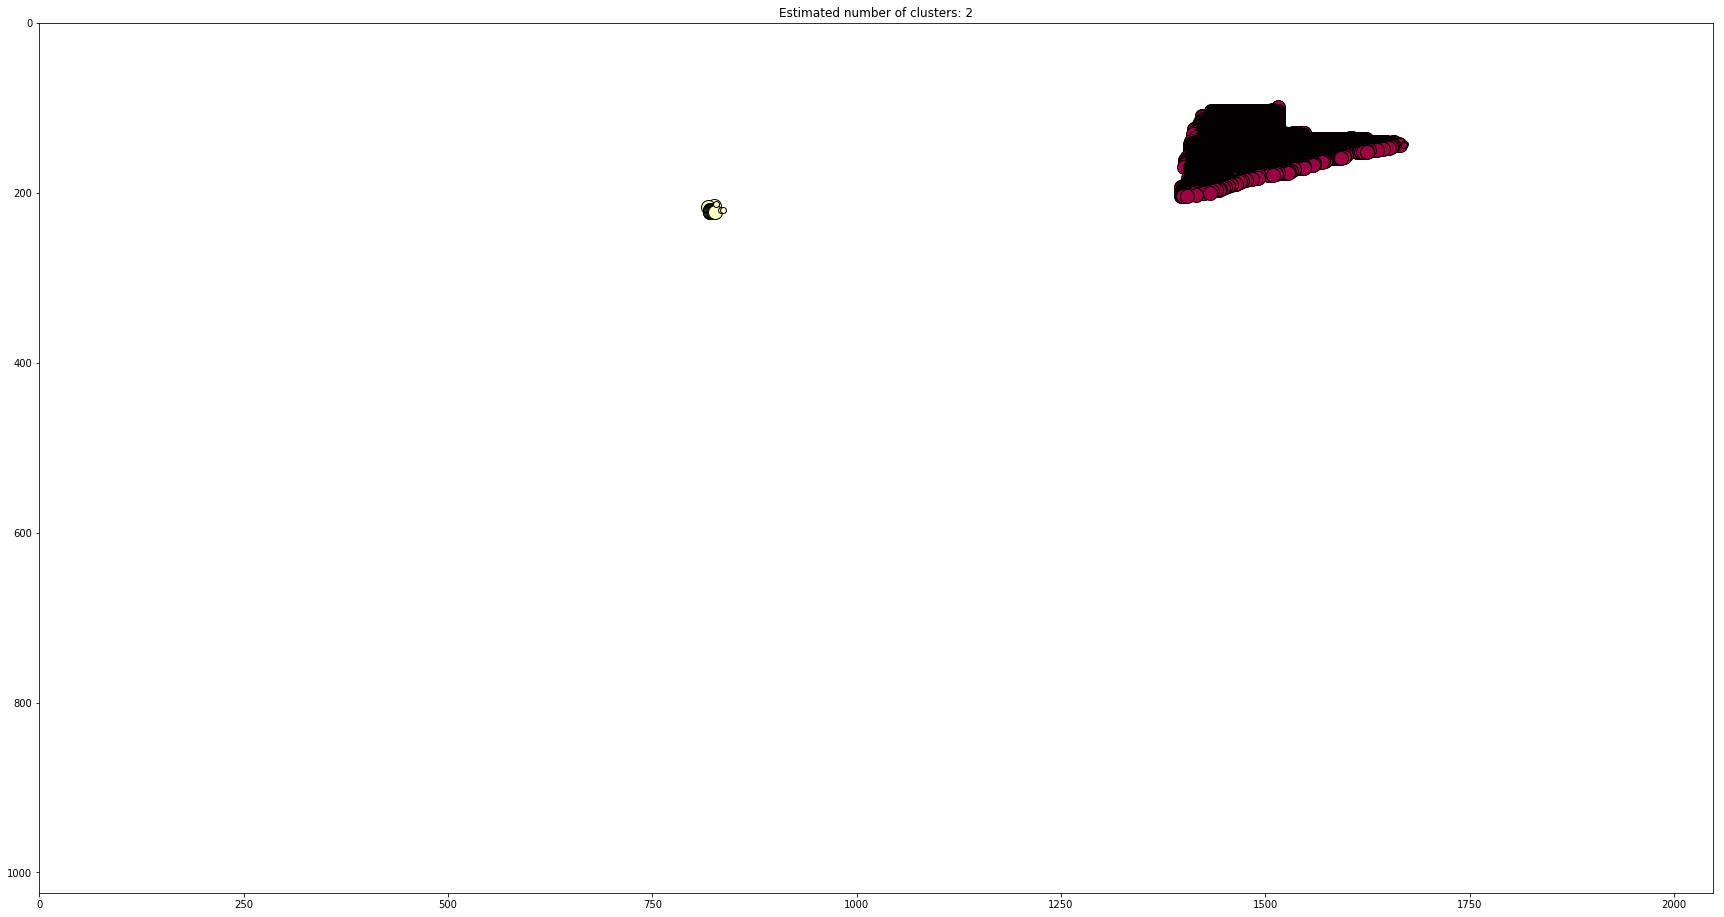

2016-04-14
Estimated number of clusters: 2
Writing labels to: data/4326/2016-04-14/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


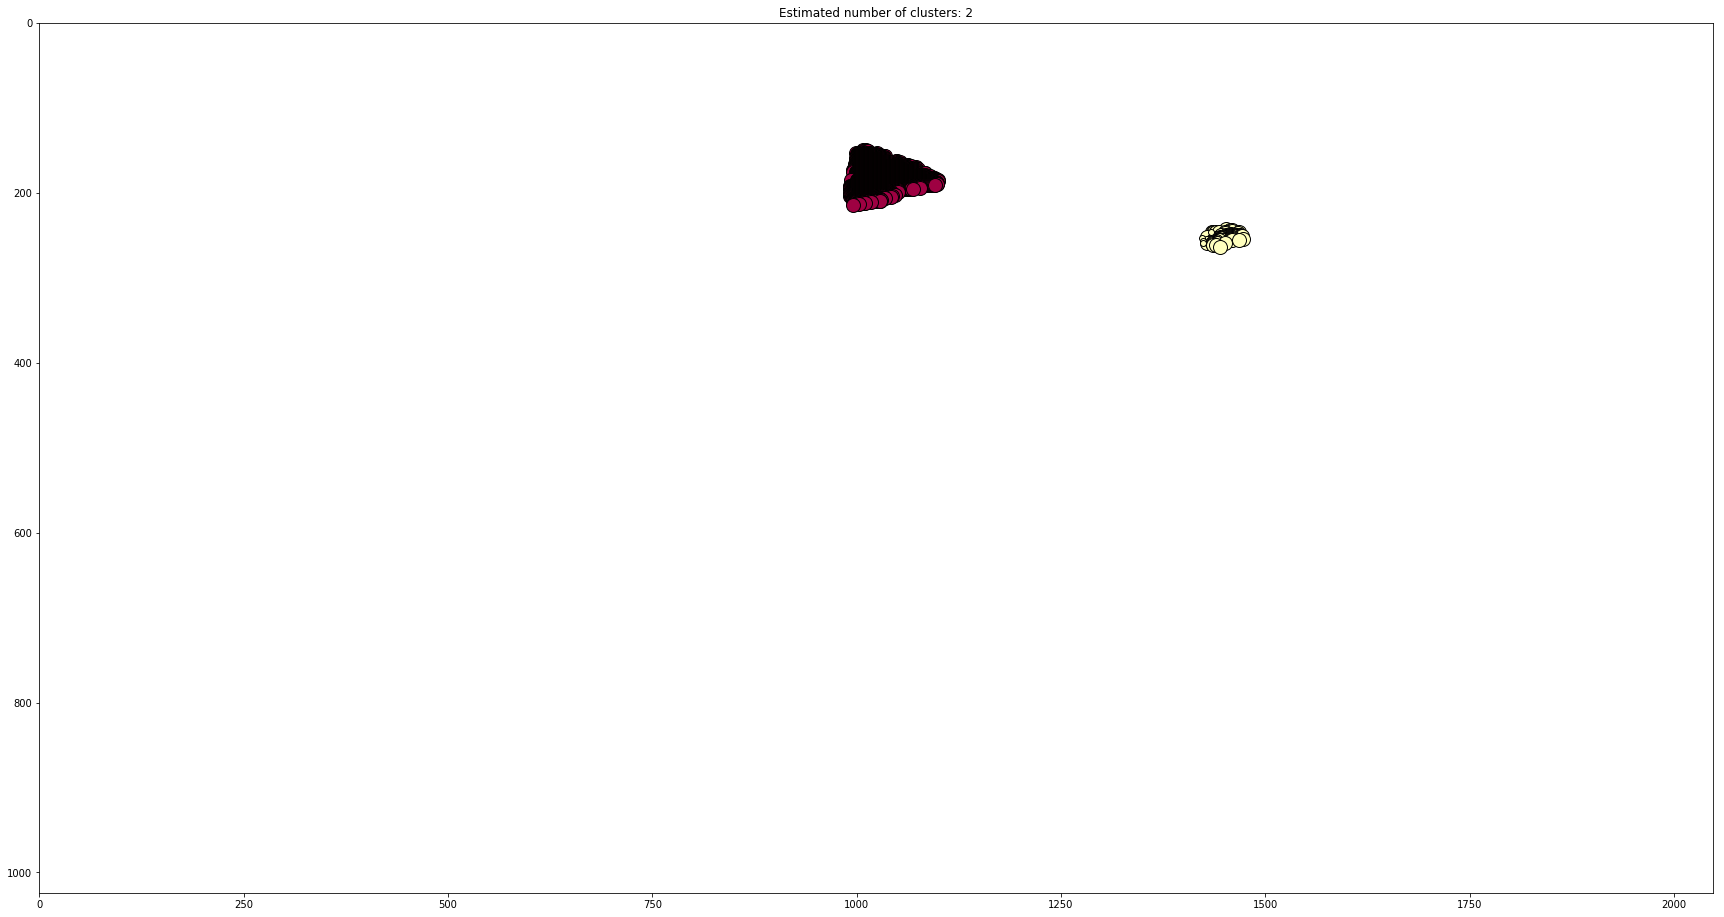

2016-04-16
Estimated number of clusters: 1
Writing labels to: data/4326/2016-04-16/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


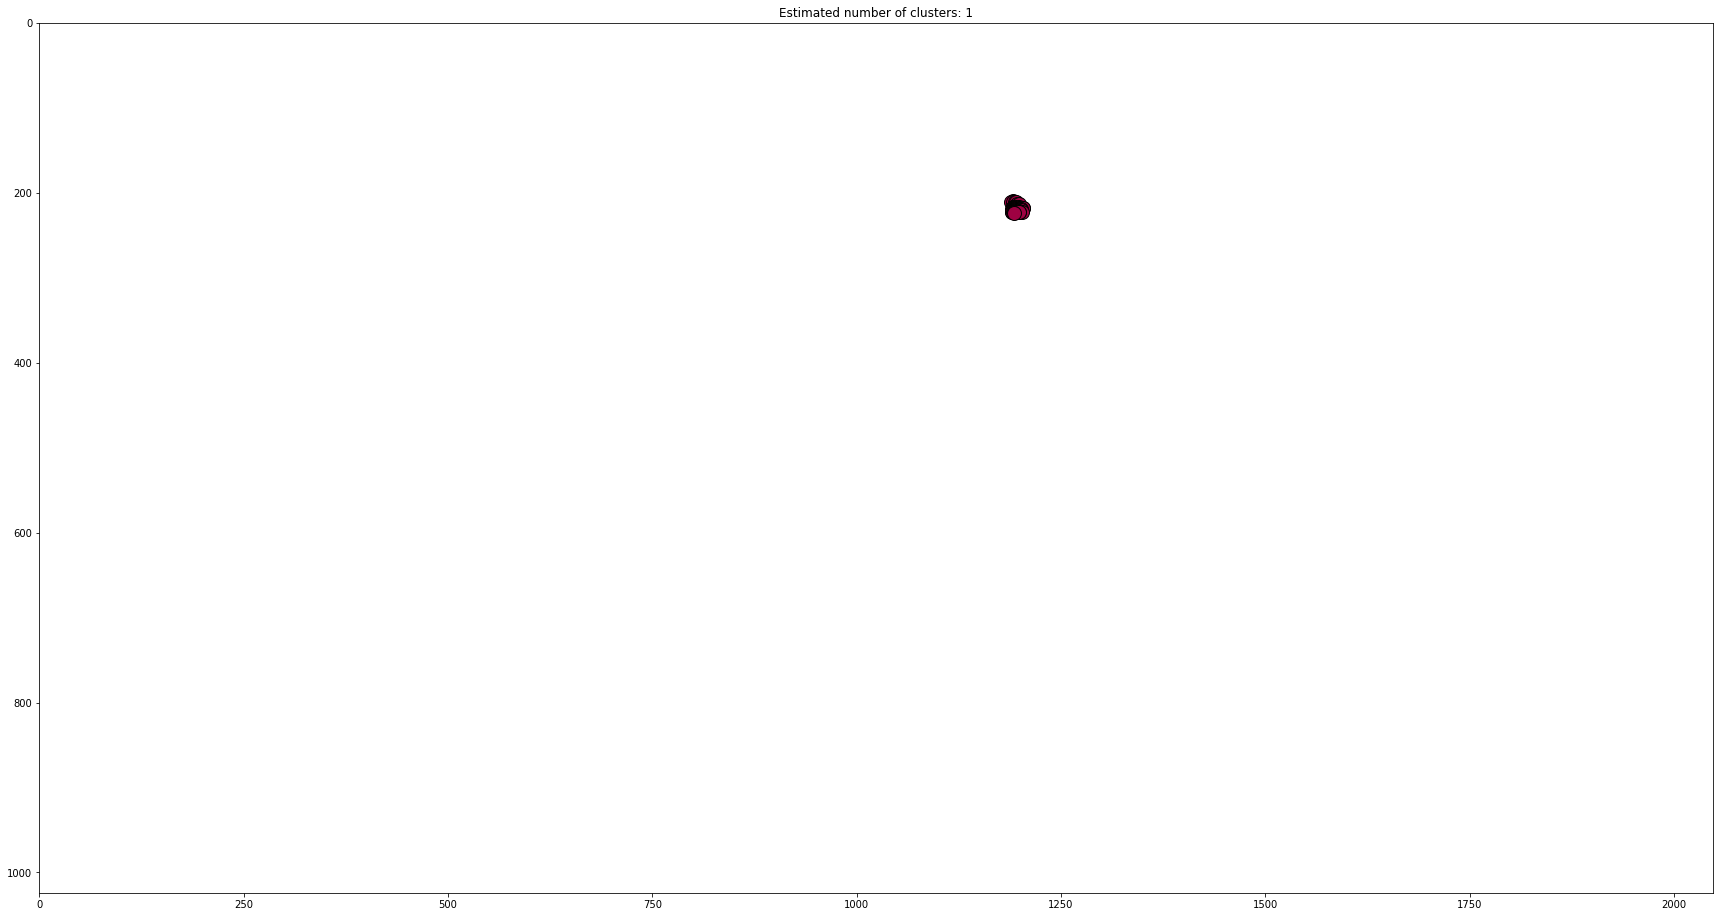

2016-04-17
Estimated number of clusters: 3
Writing labels to: data/4326/2016-04-17/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


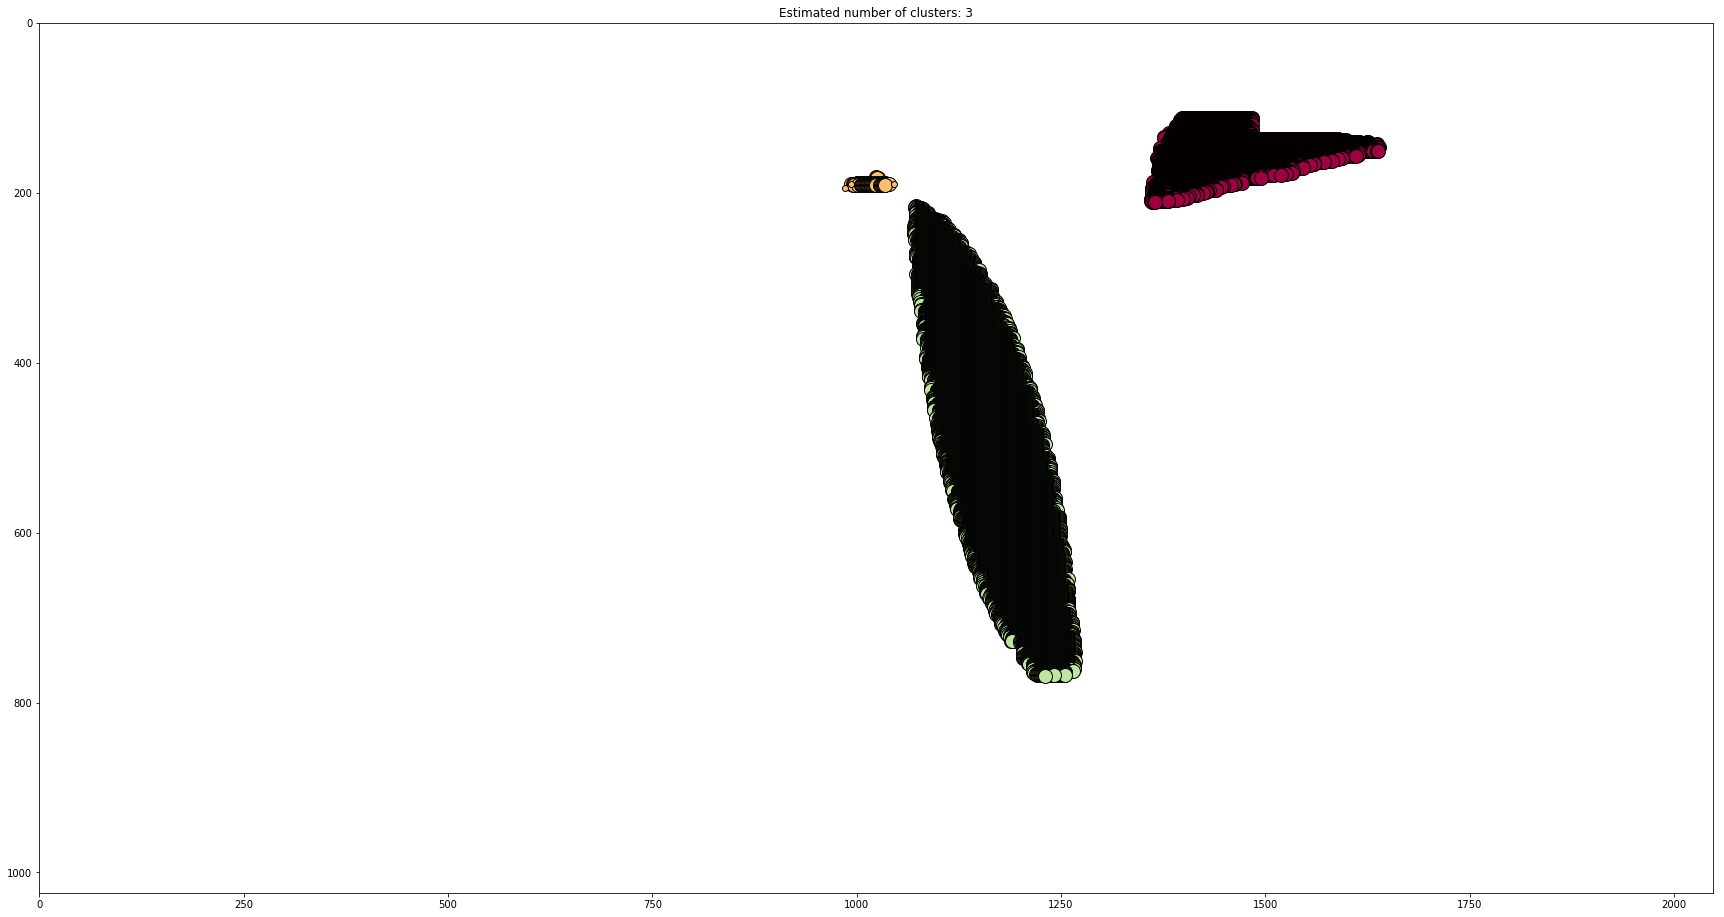

2016-04-18
Estimated number of clusters: 1
Writing labels to: data/4326/2016-04-18/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


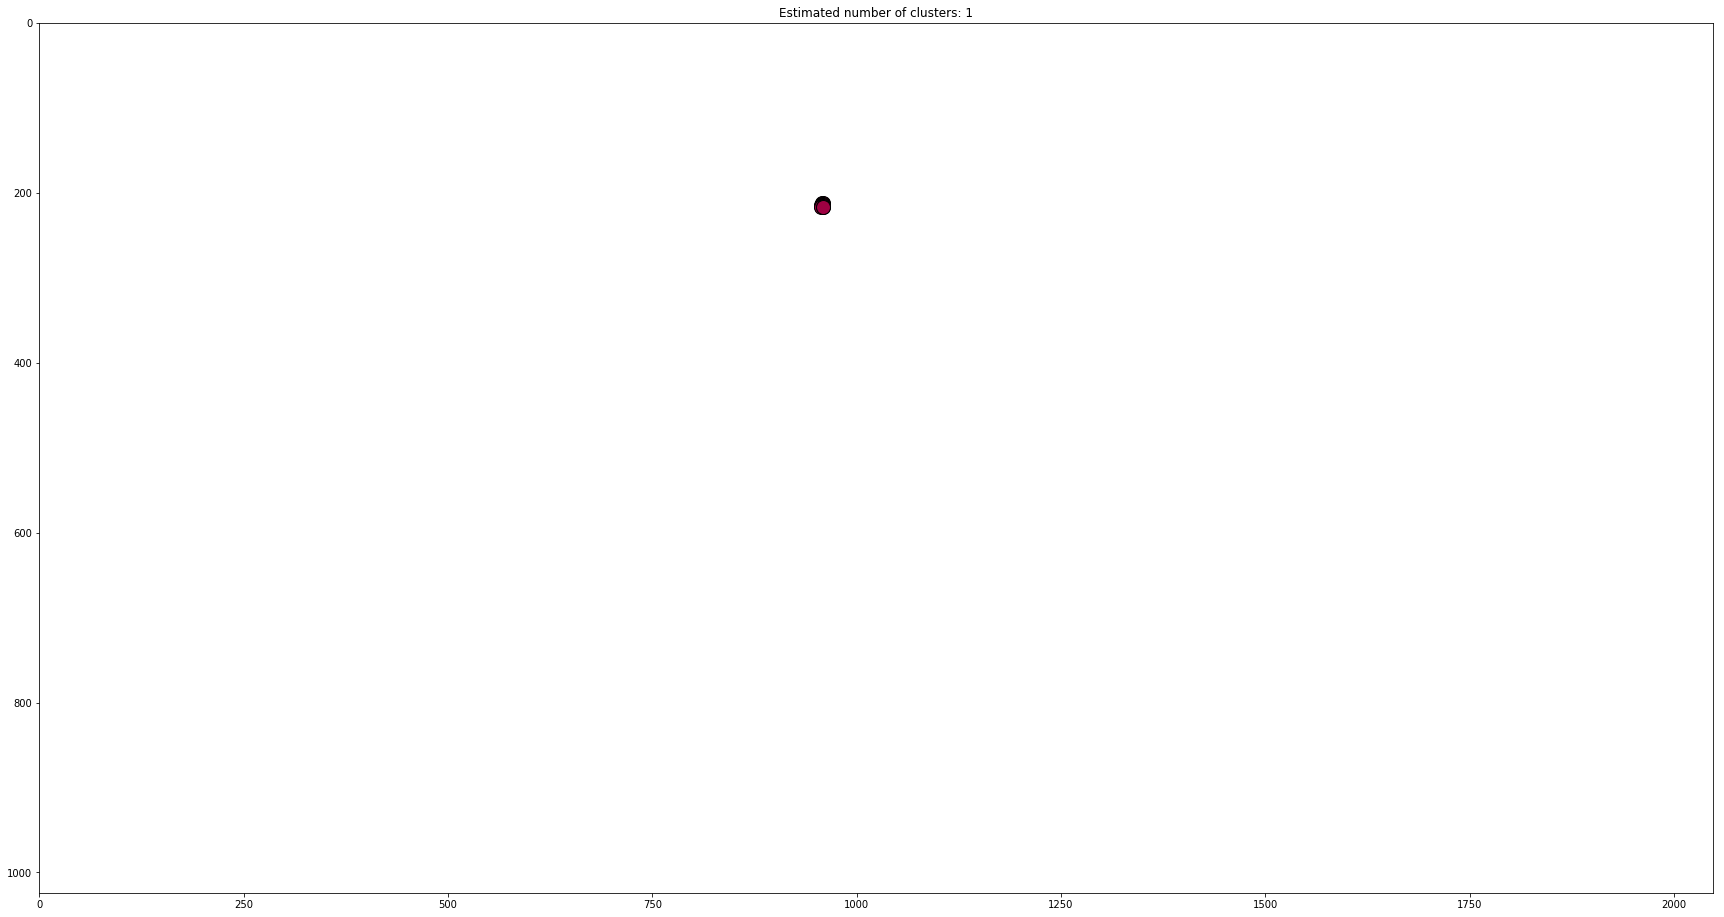

2016-04-19
Estimated number of clusters: 1
Writing labels to: data/4326/2016-04-19/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


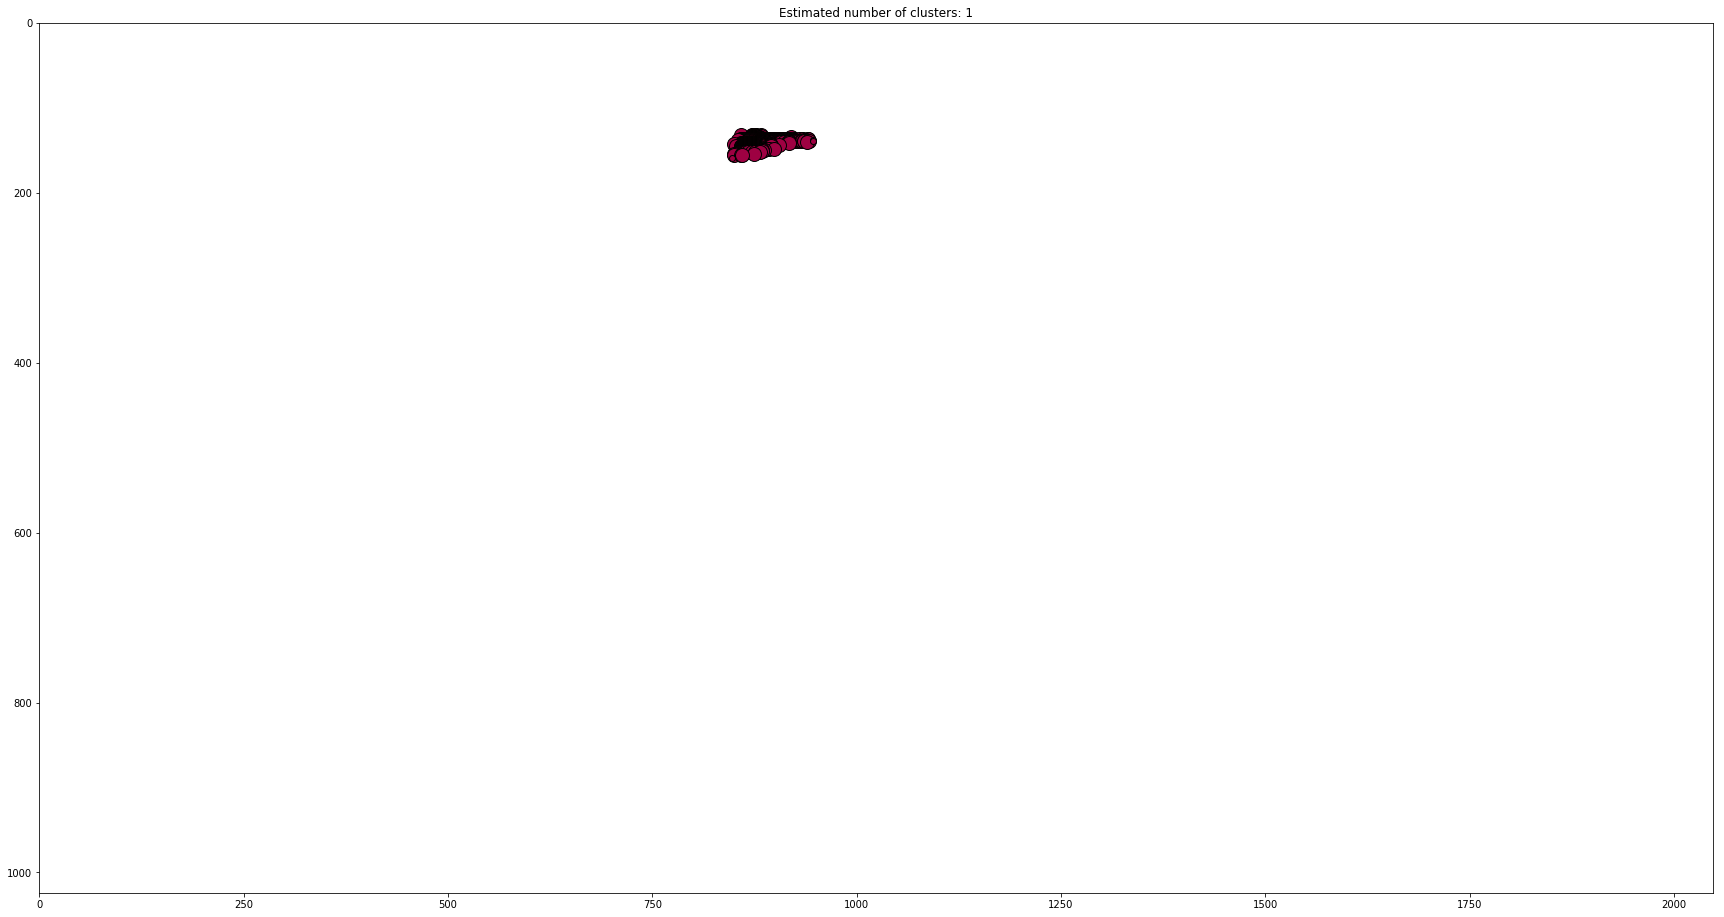

2016-04-23
Estimated number of clusters: 1
Writing labels to: data/4326/2016-04-23/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


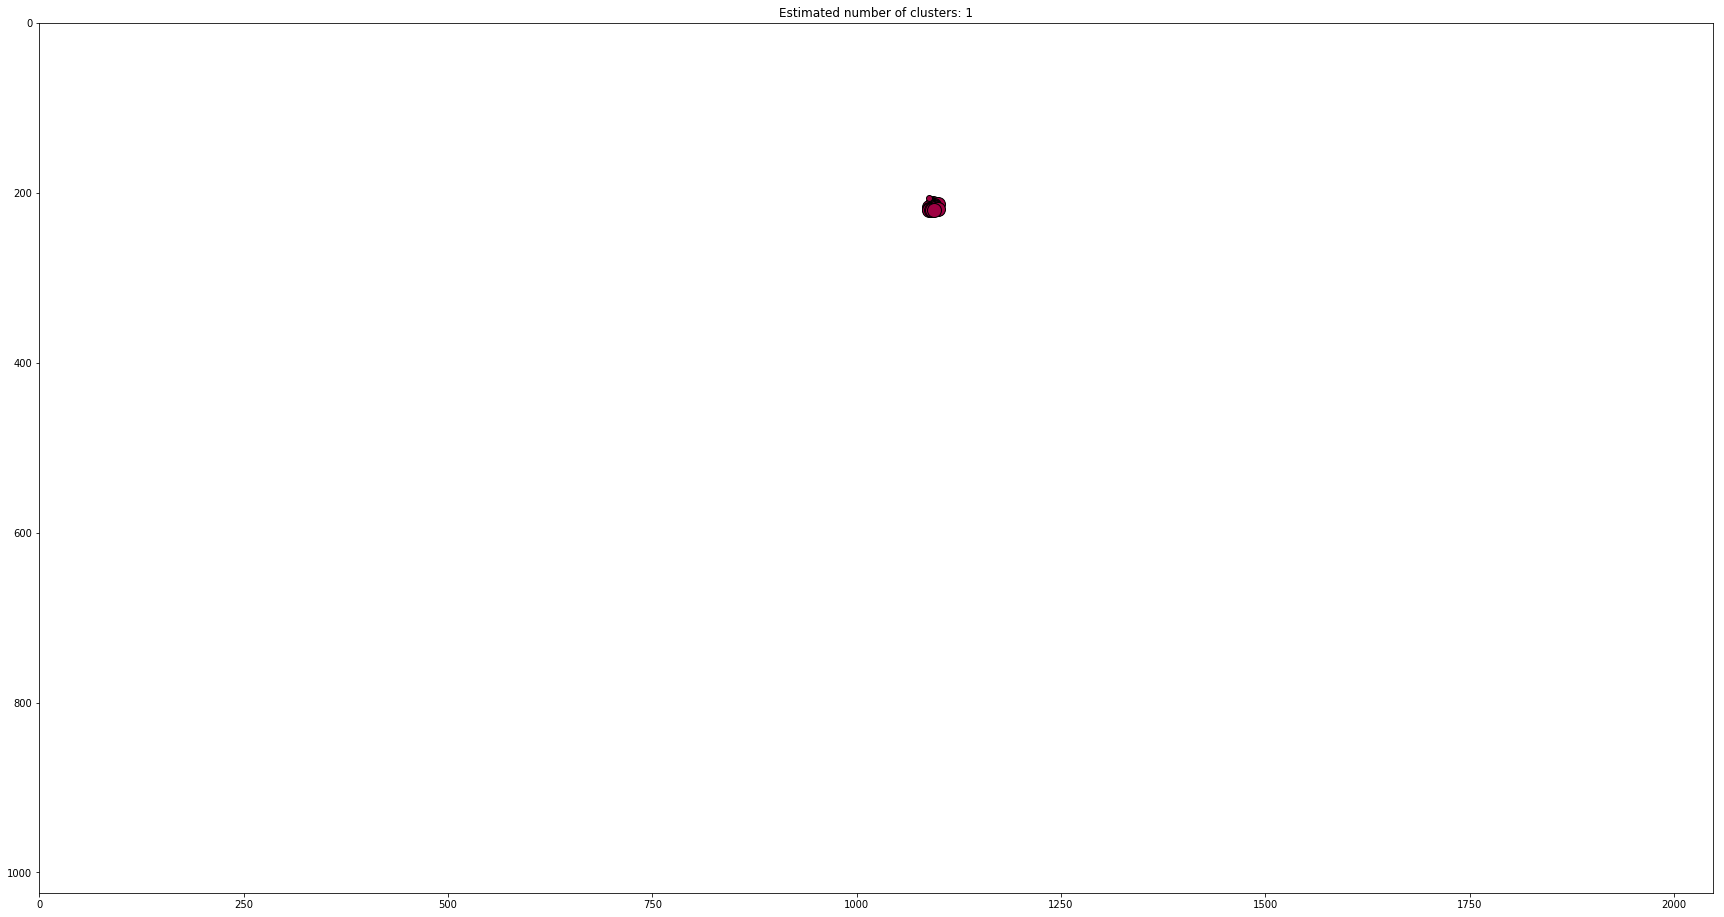

2016-04-25
Estimated number of clusters: 2
Writing labels to: data/4326/2016-04-25/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


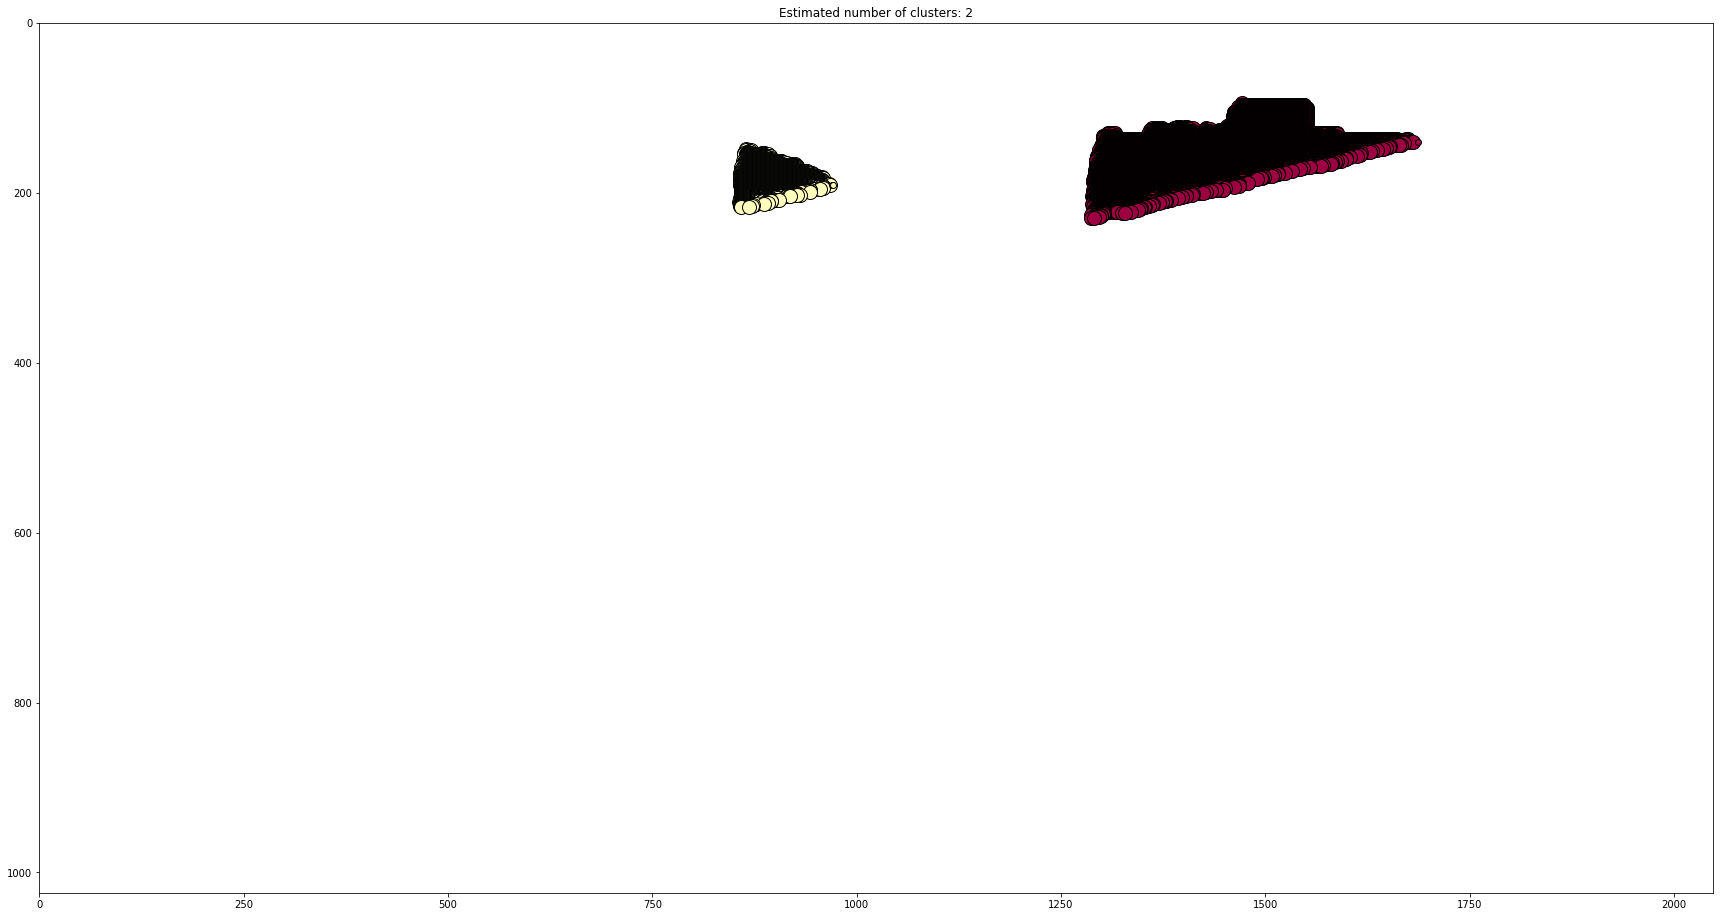

2016-04-29
Estimated number of clusters: 4
Writing labels to: data/4326/2016-04-29/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


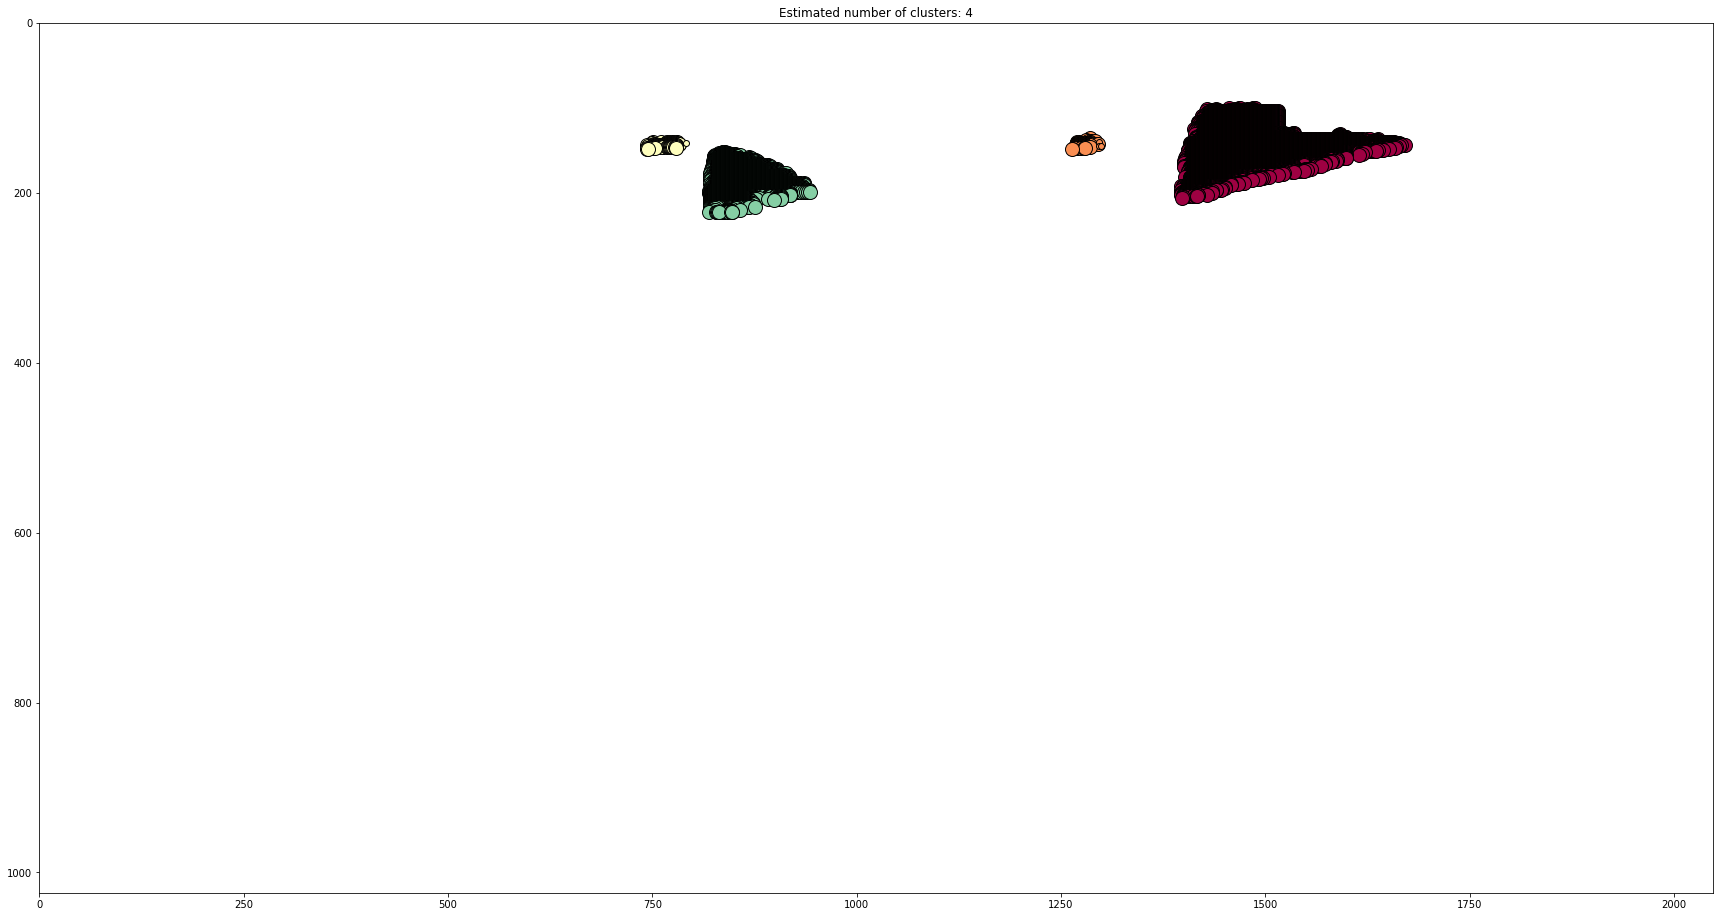

2016-05-02
Estimated number of clusters: 1
Writing labels to: data/4326/2016-05-02/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


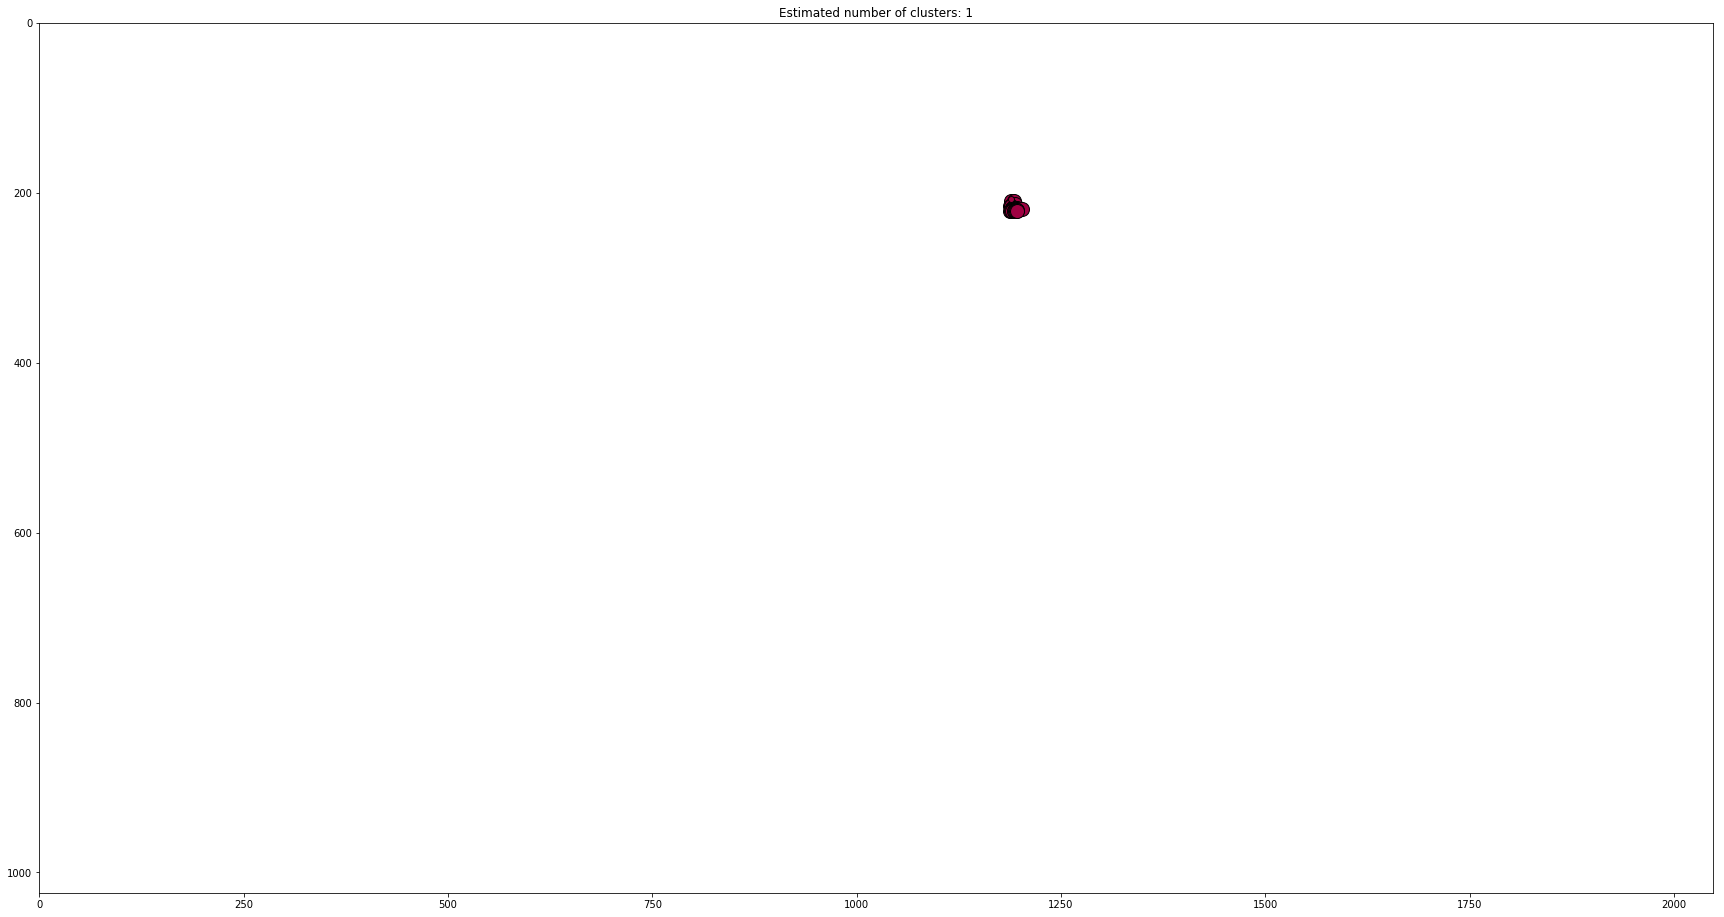

2016-05-03
Estimated number of clusters: 1
Writing labels to: data/4326/2016-05-03/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


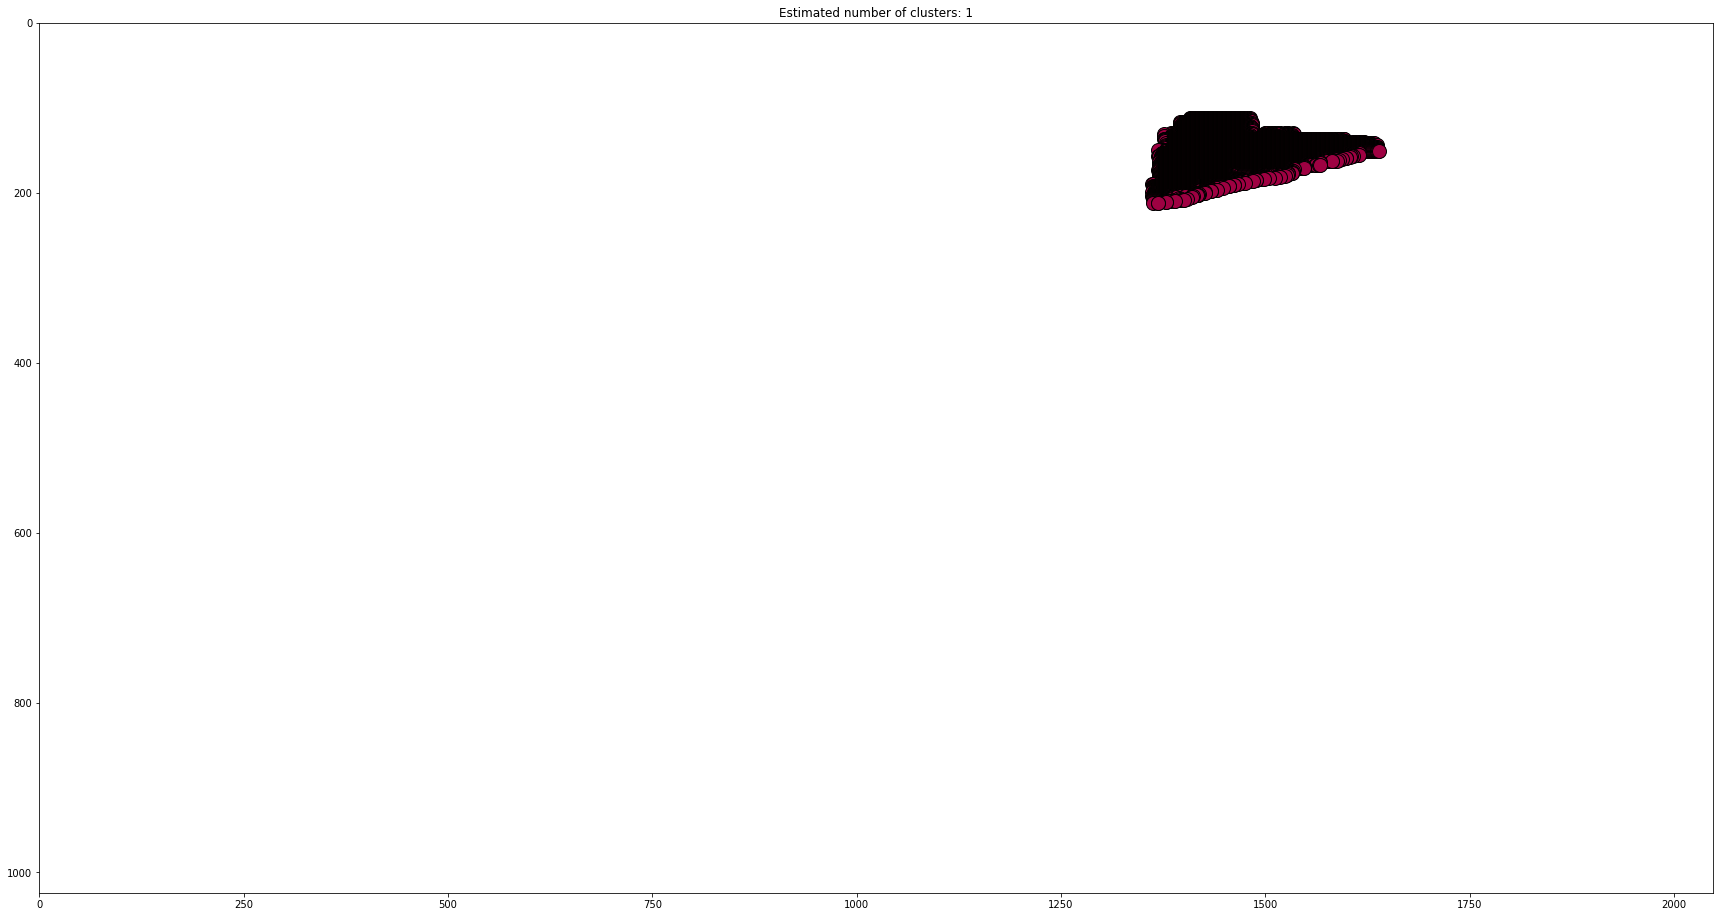

2016-05-04
Estimated number of clusters: 1
Writing labels to: data/4326/2016-05-04/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


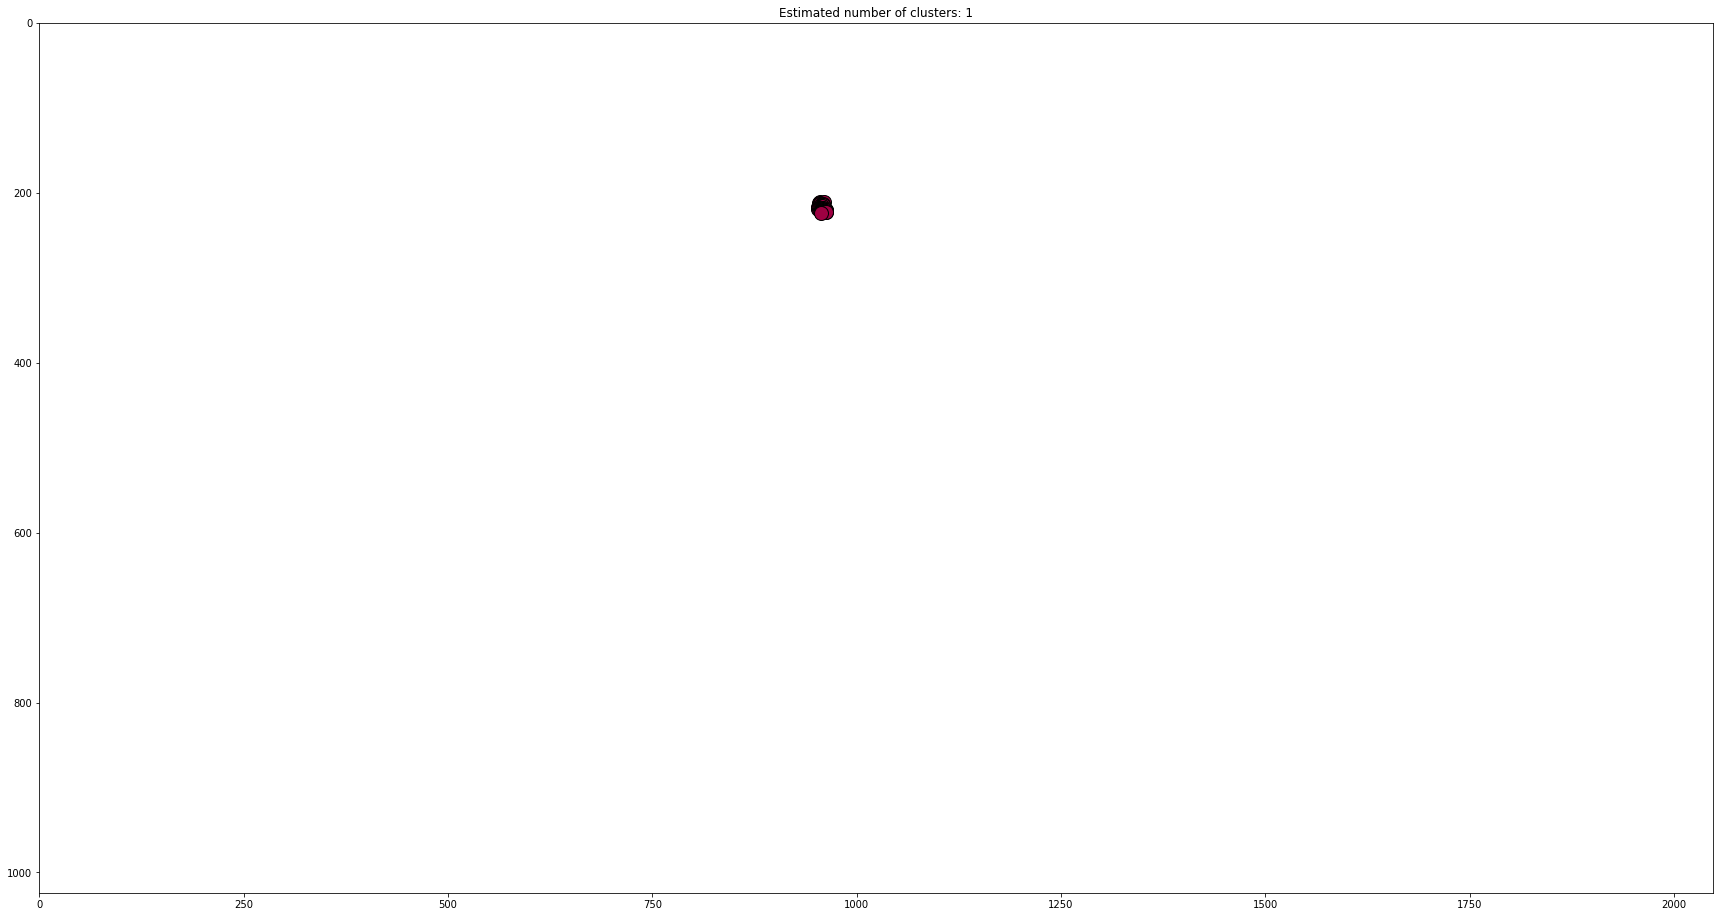

2016-05-07
Estimated number of clusters: 1
Writing labels to: data/4326/2016-05-07/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


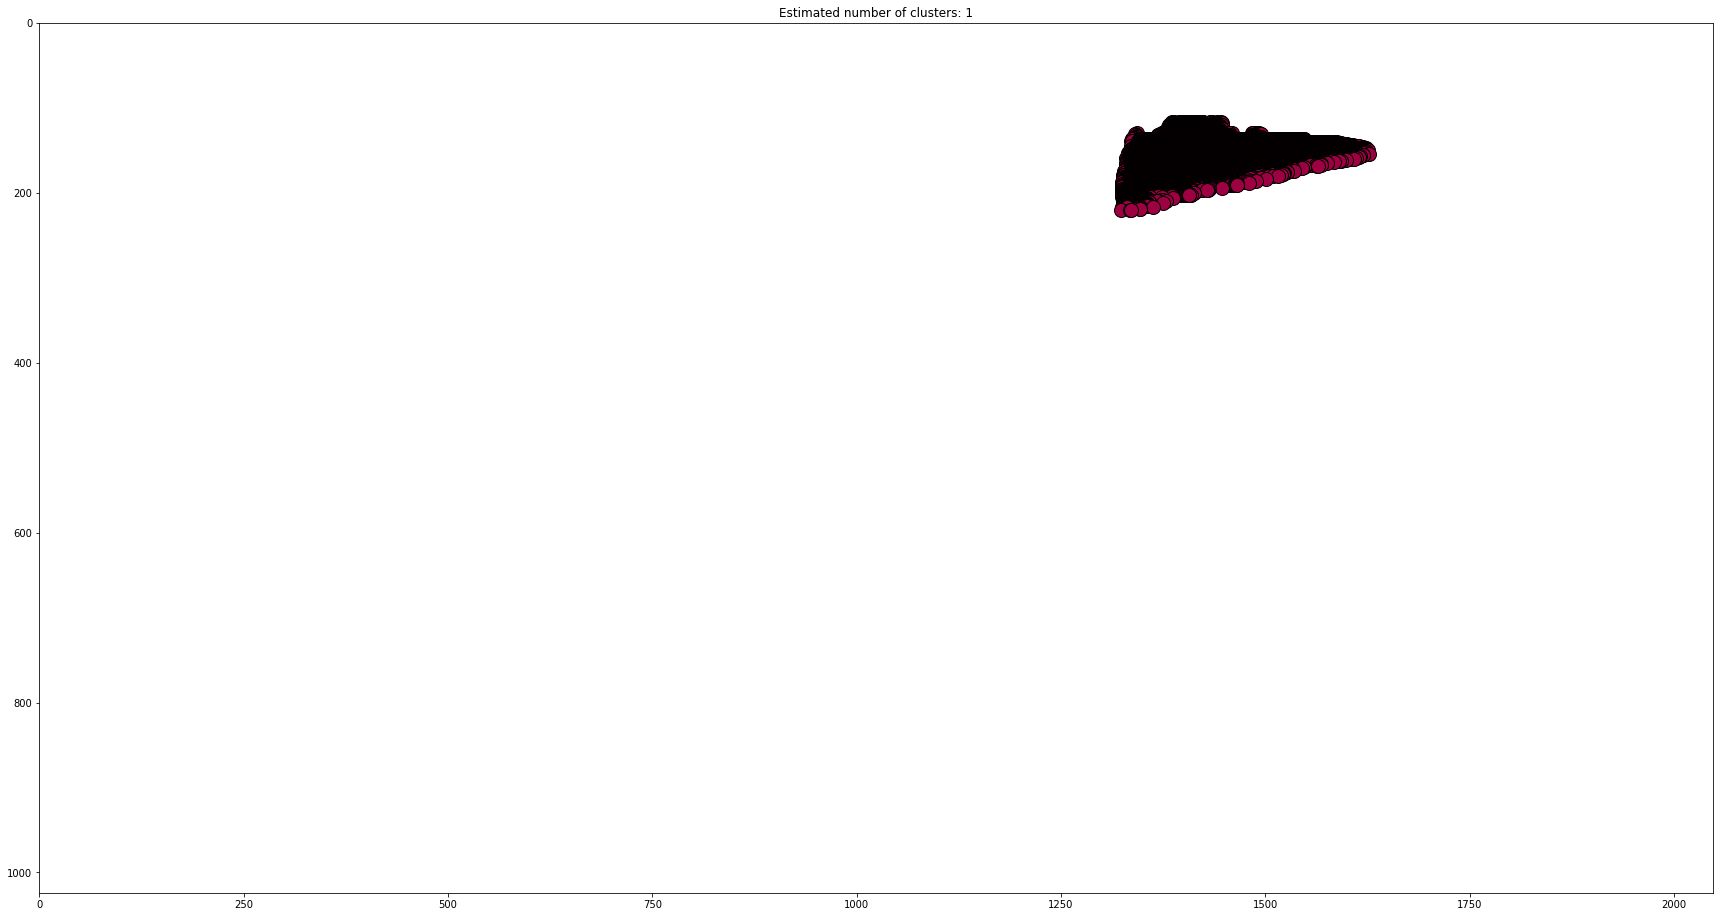

2016-05-11
Estimated number of clusters: 12
Writing labels to: data/4326/2016-05-11/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


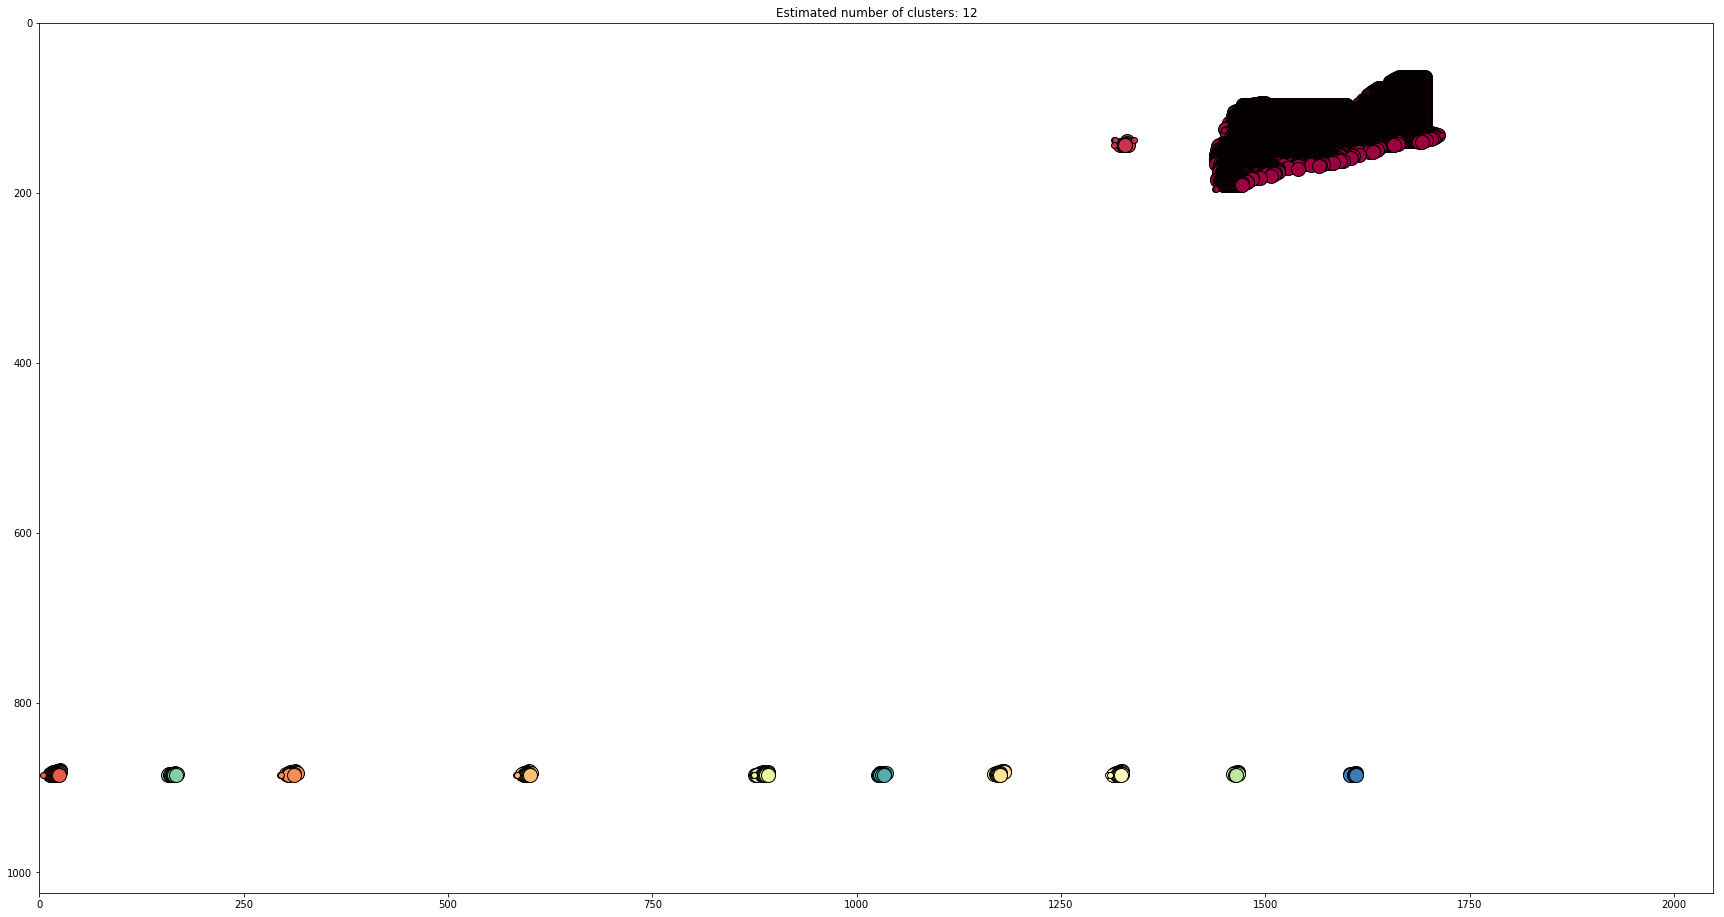

2016-05-14
Estimated number of clusters: 1
Writing labels to: data/4326/2016-05-14/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


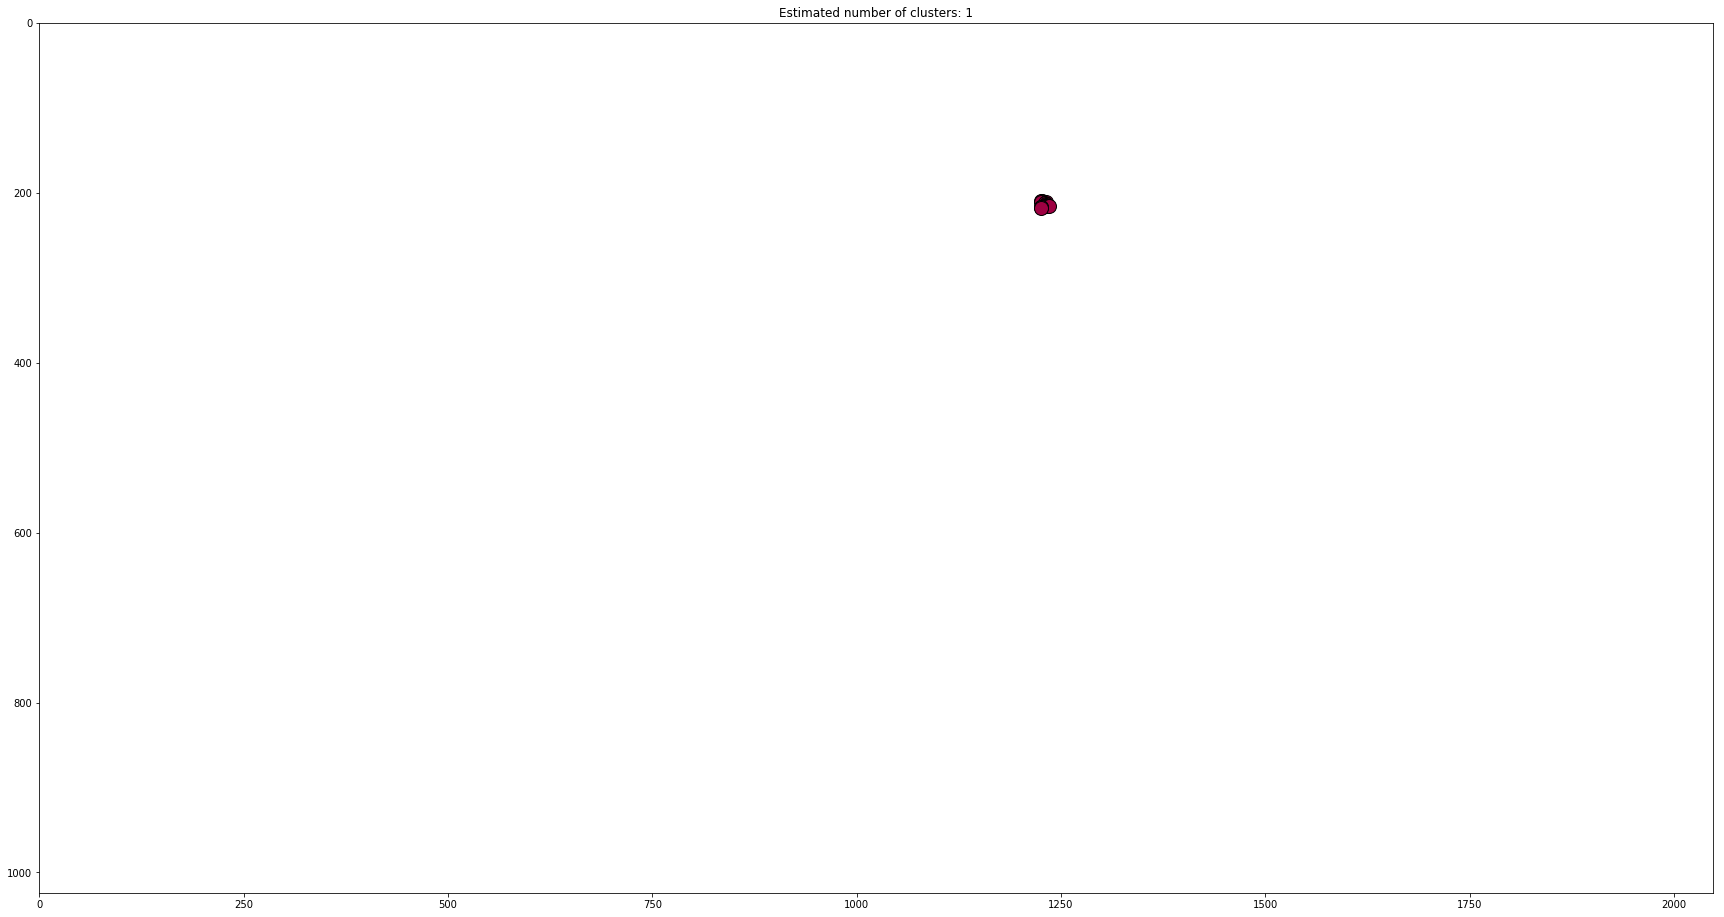

2016-05-15
Estimated number of clusters: 2
Writing labels to: data/4326/2016-05-15/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


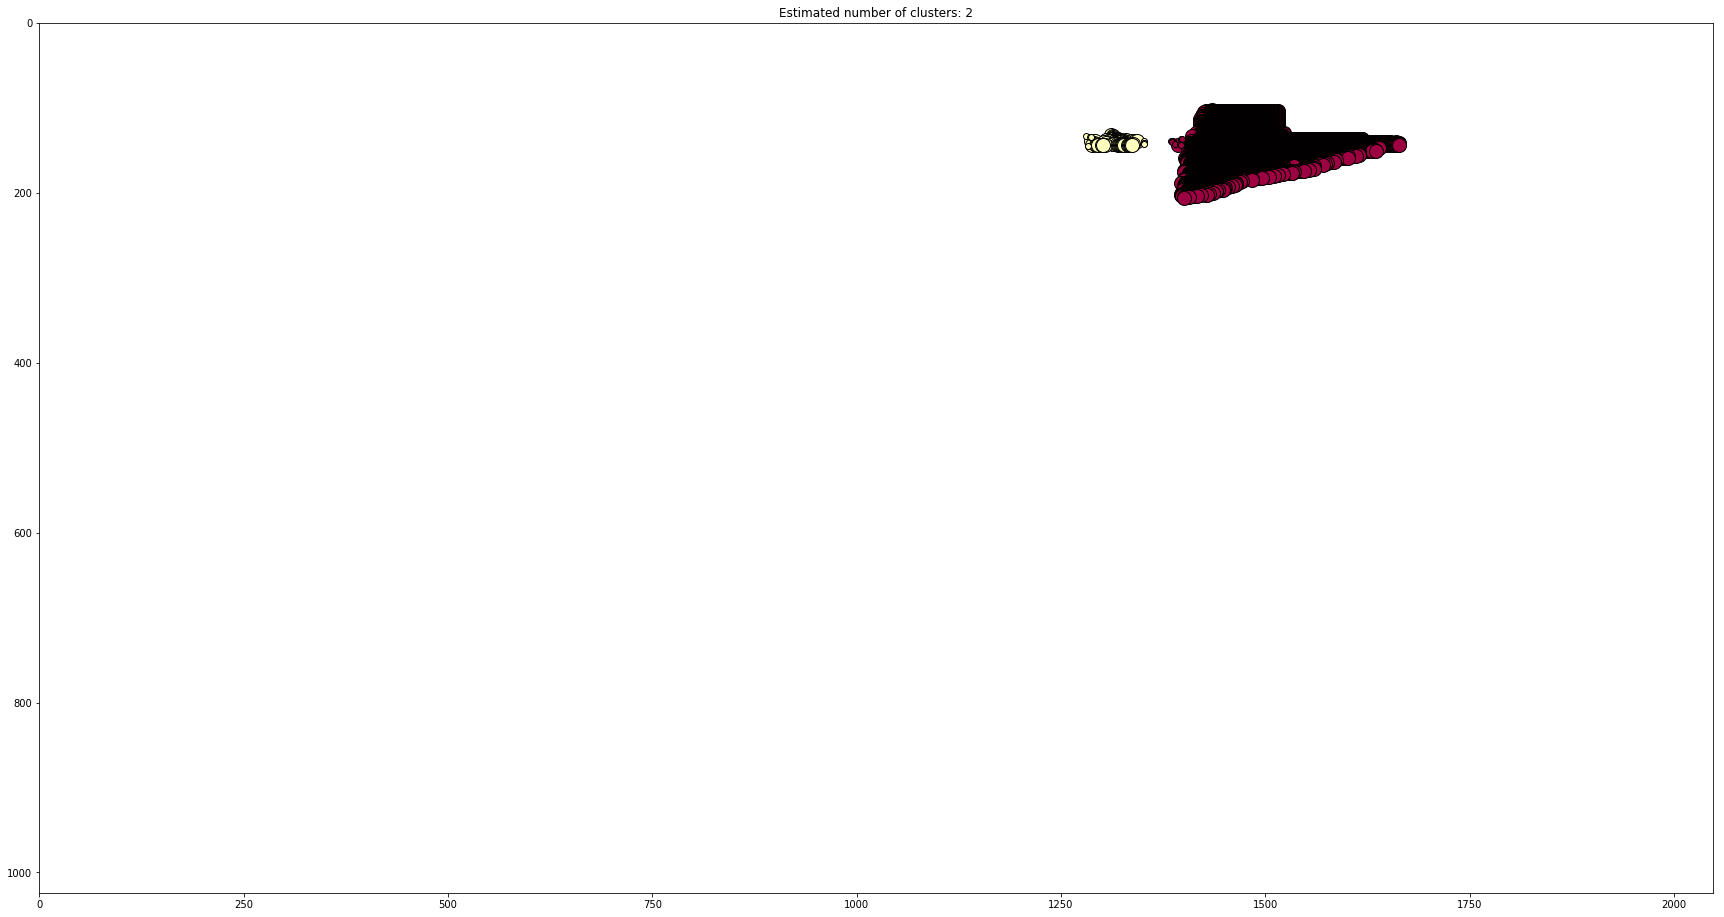

2016-05-16
Estimated number of clusters: 1
Writing labels to: data/4326/2016-05-16/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


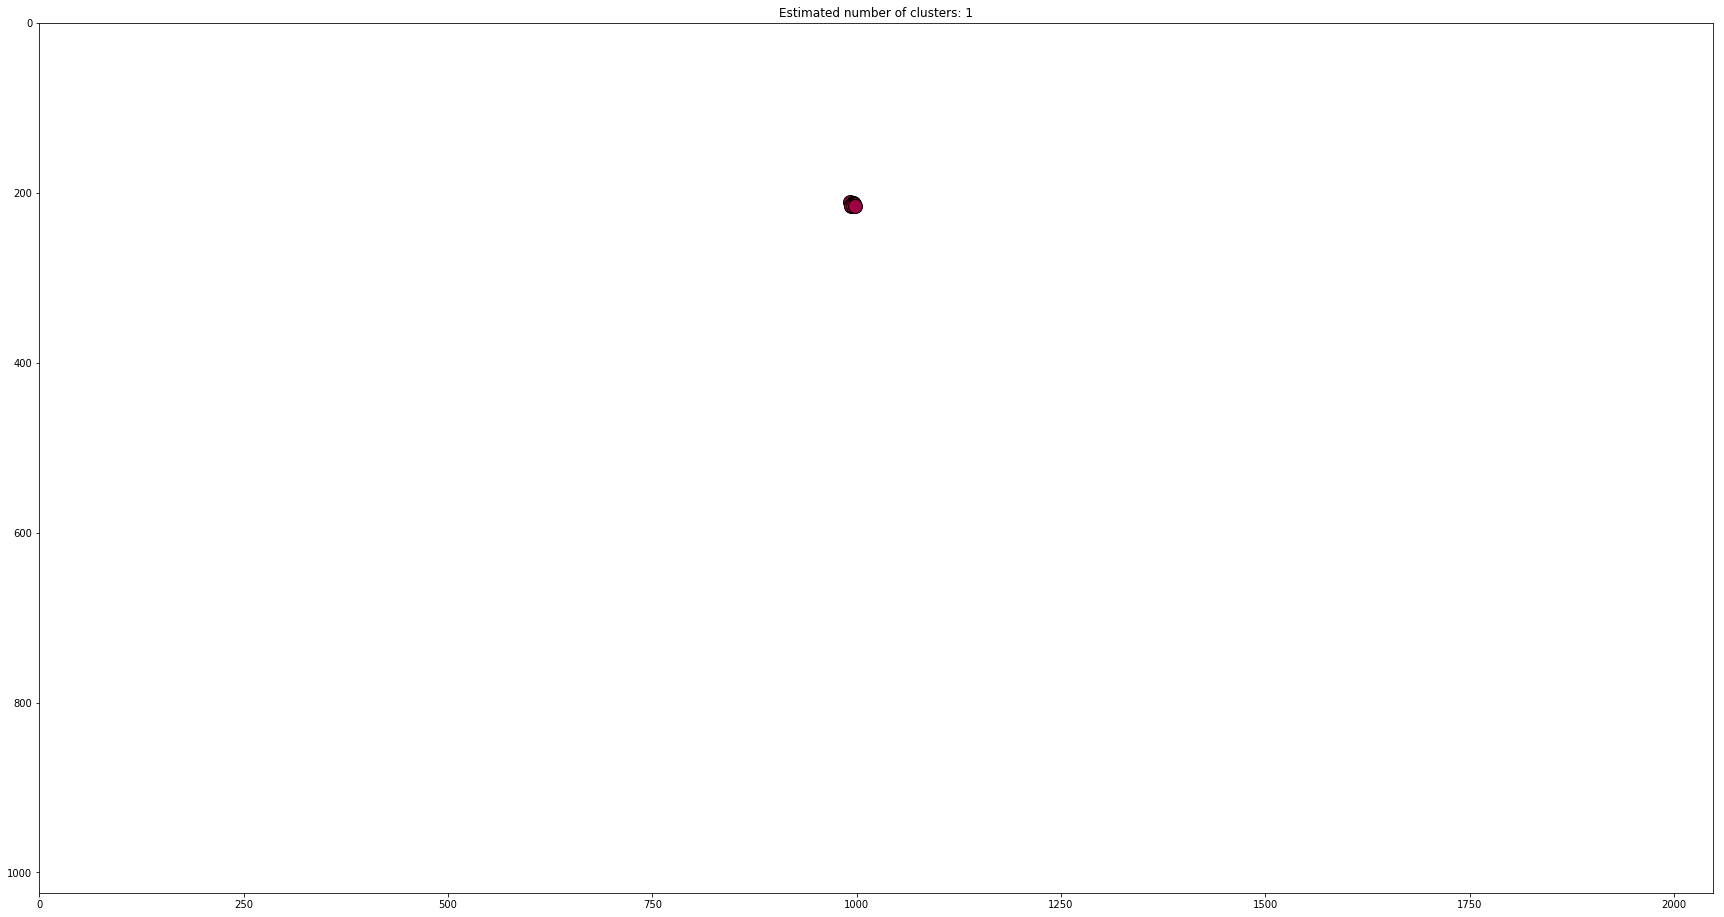

2016-05-17
Estimated number of clusters: 1
Writing labels to: data/4326/2016-05-17/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


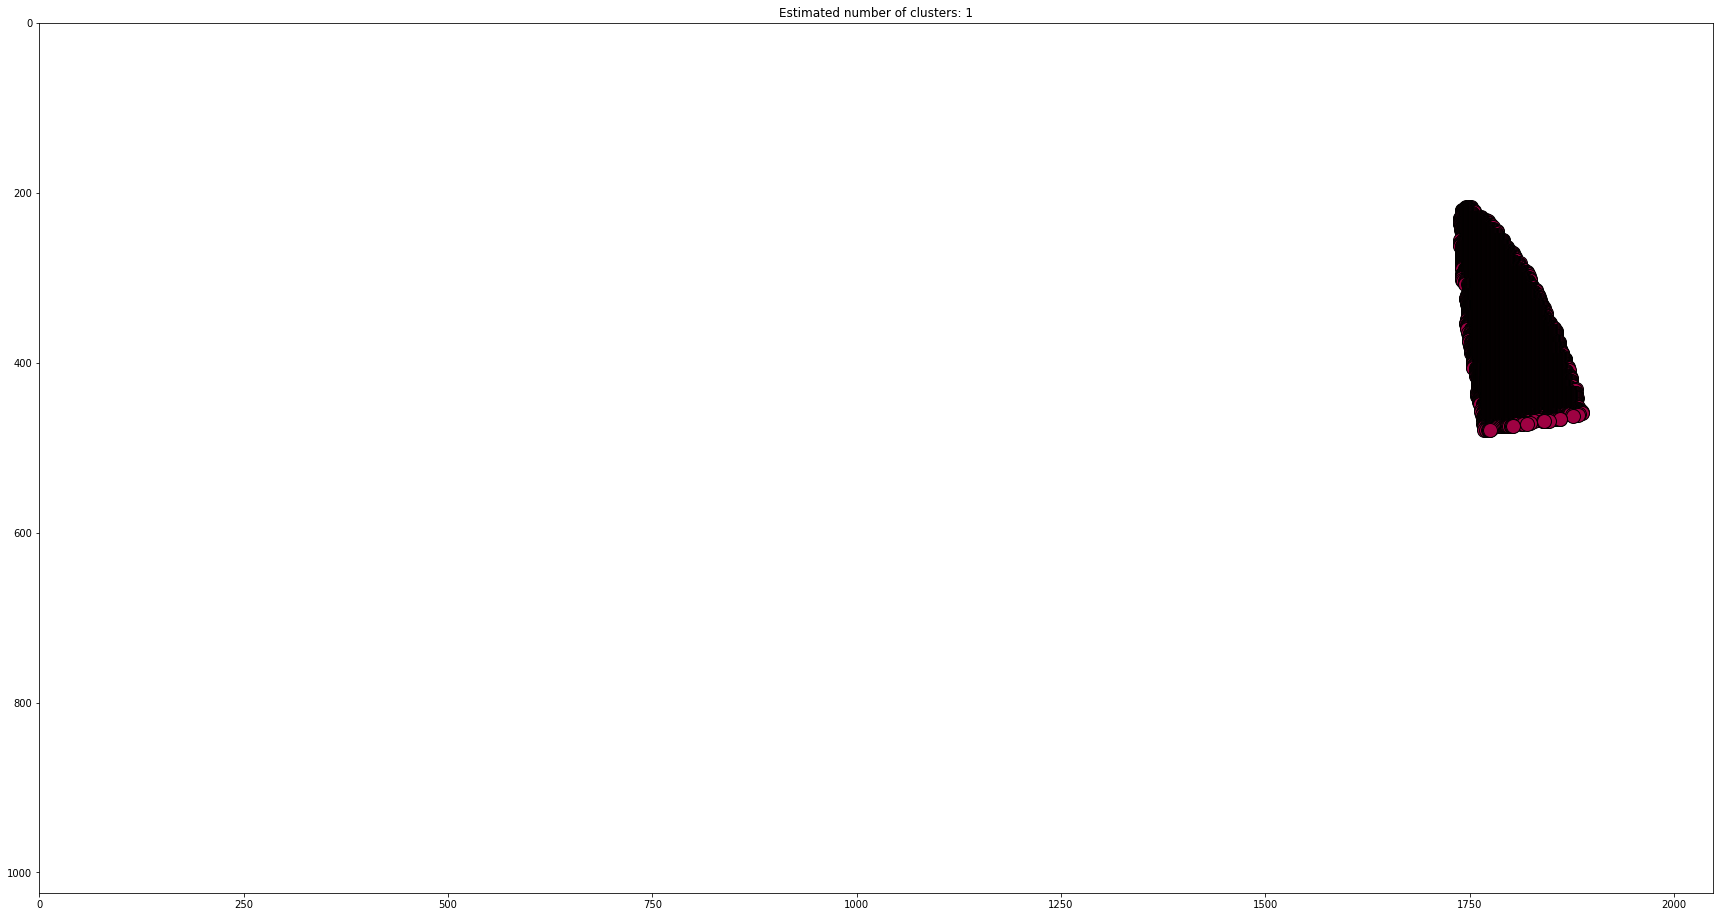

2016-06-15
Estimated number of clusters: 1
Writing labels to: data/4326/2016-06-15/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


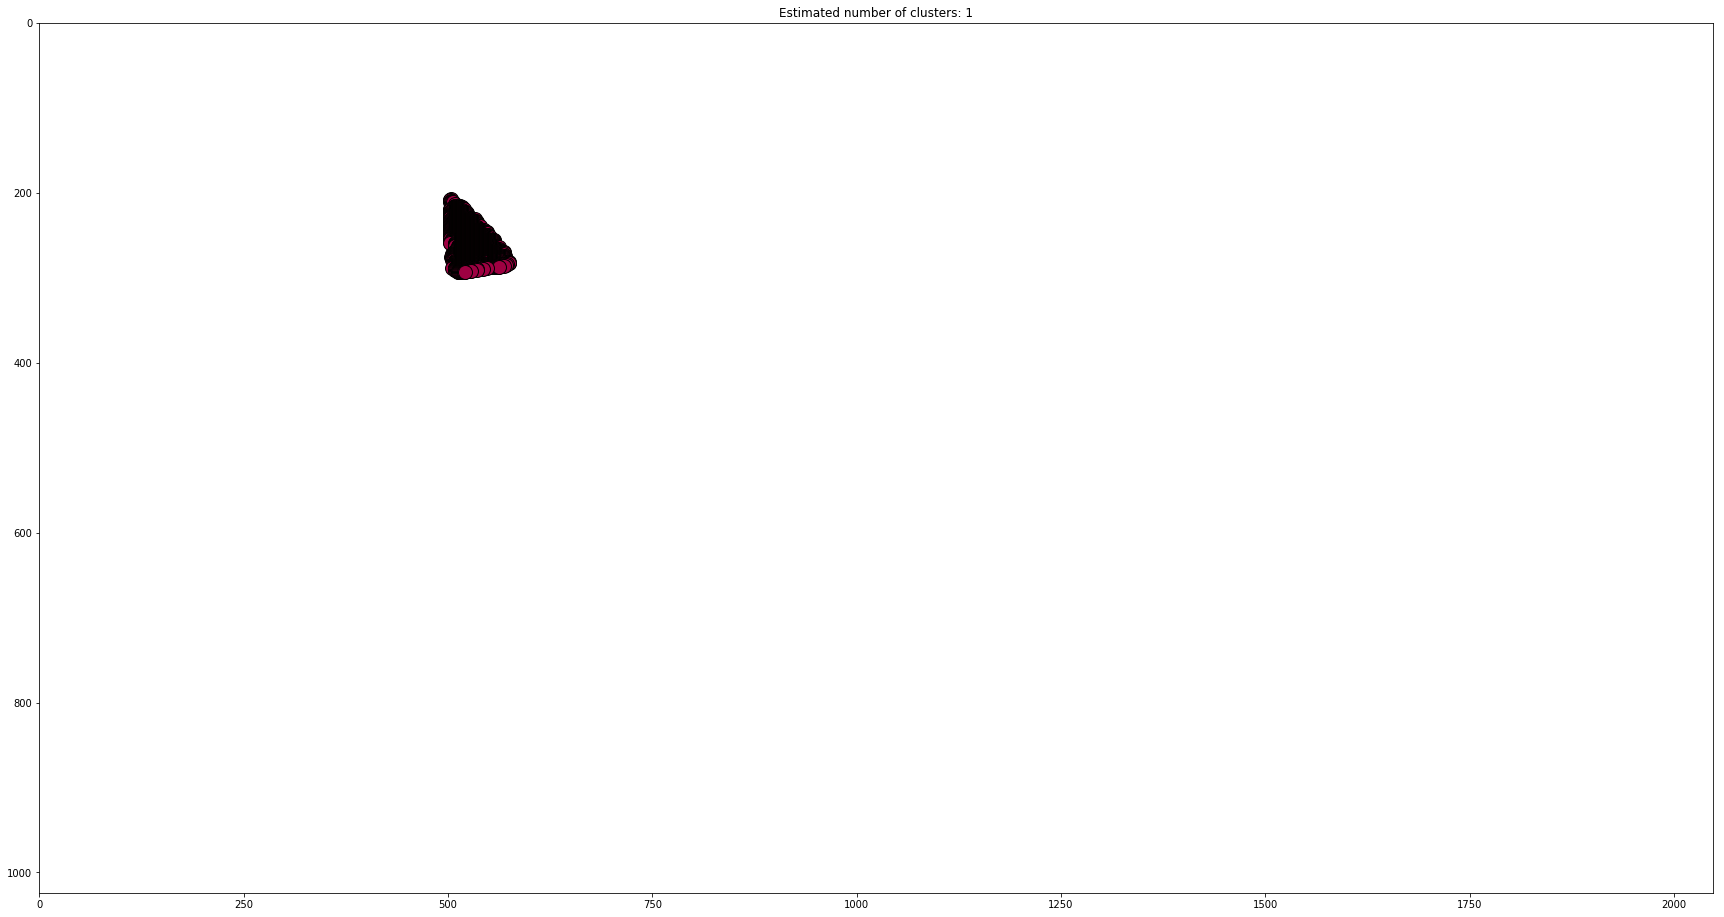

2016-07-13
Estimated number of clusters: 1
Writing labels to: data/4326/2016-07-13/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


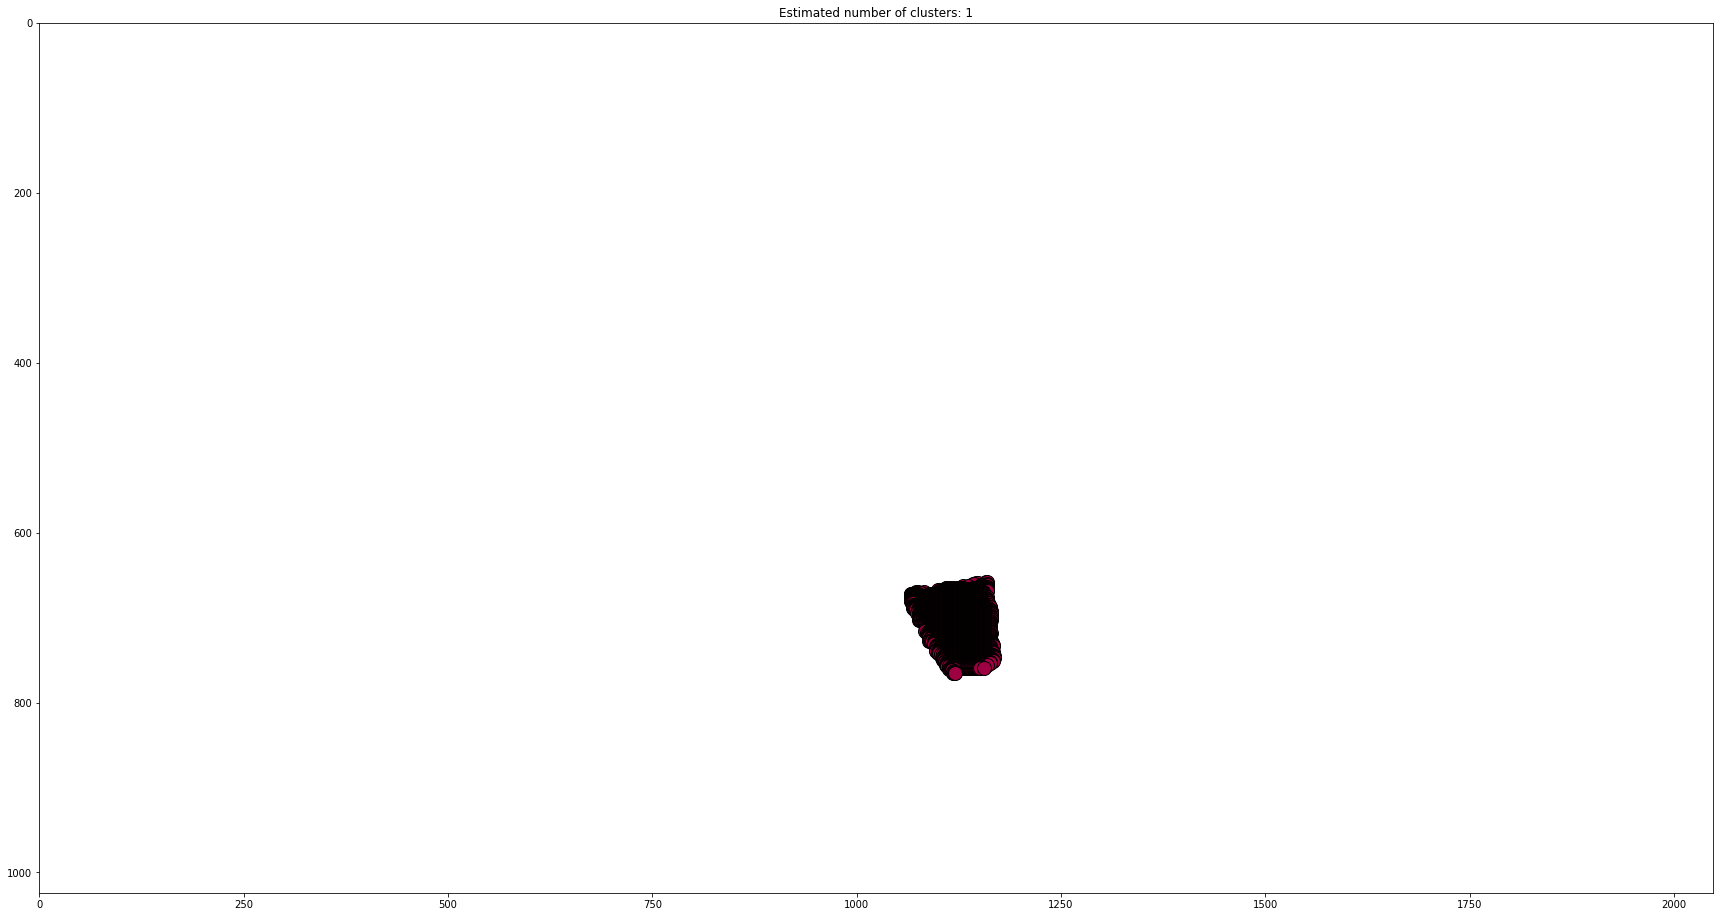

2016-08-13
Estimated number of clusters: 2
Writing labels to: data/4326/2016-08-13/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


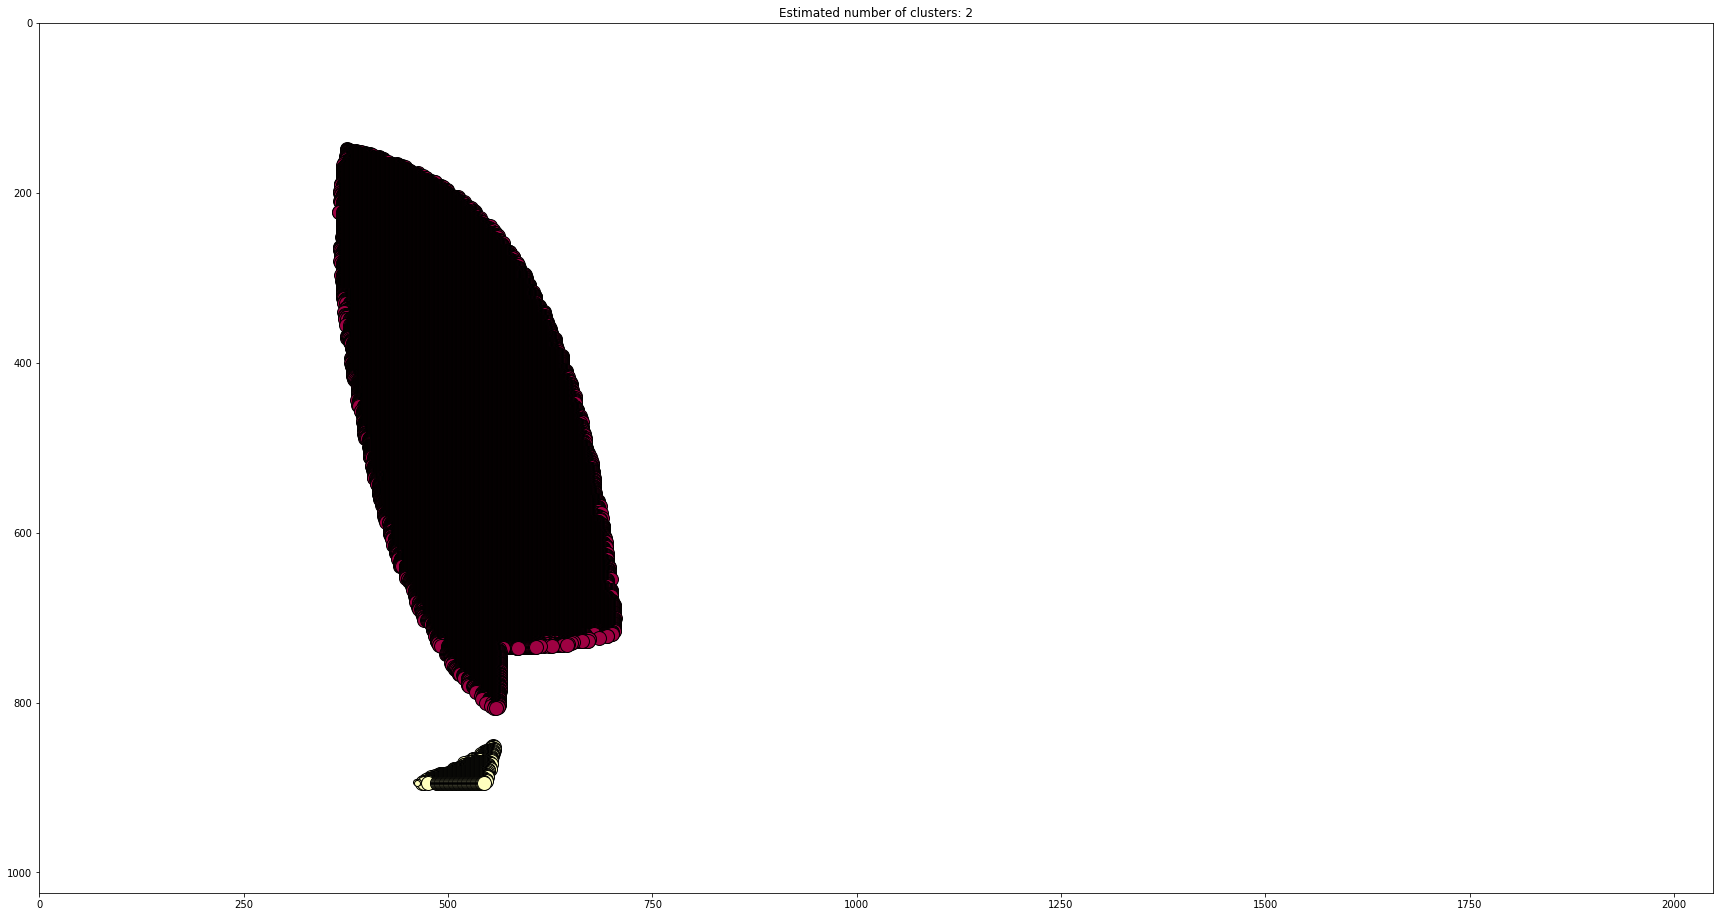

2016-08-18
Estimated number of clusters: 3
Writing labels to: data/4326/2016-08-18/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


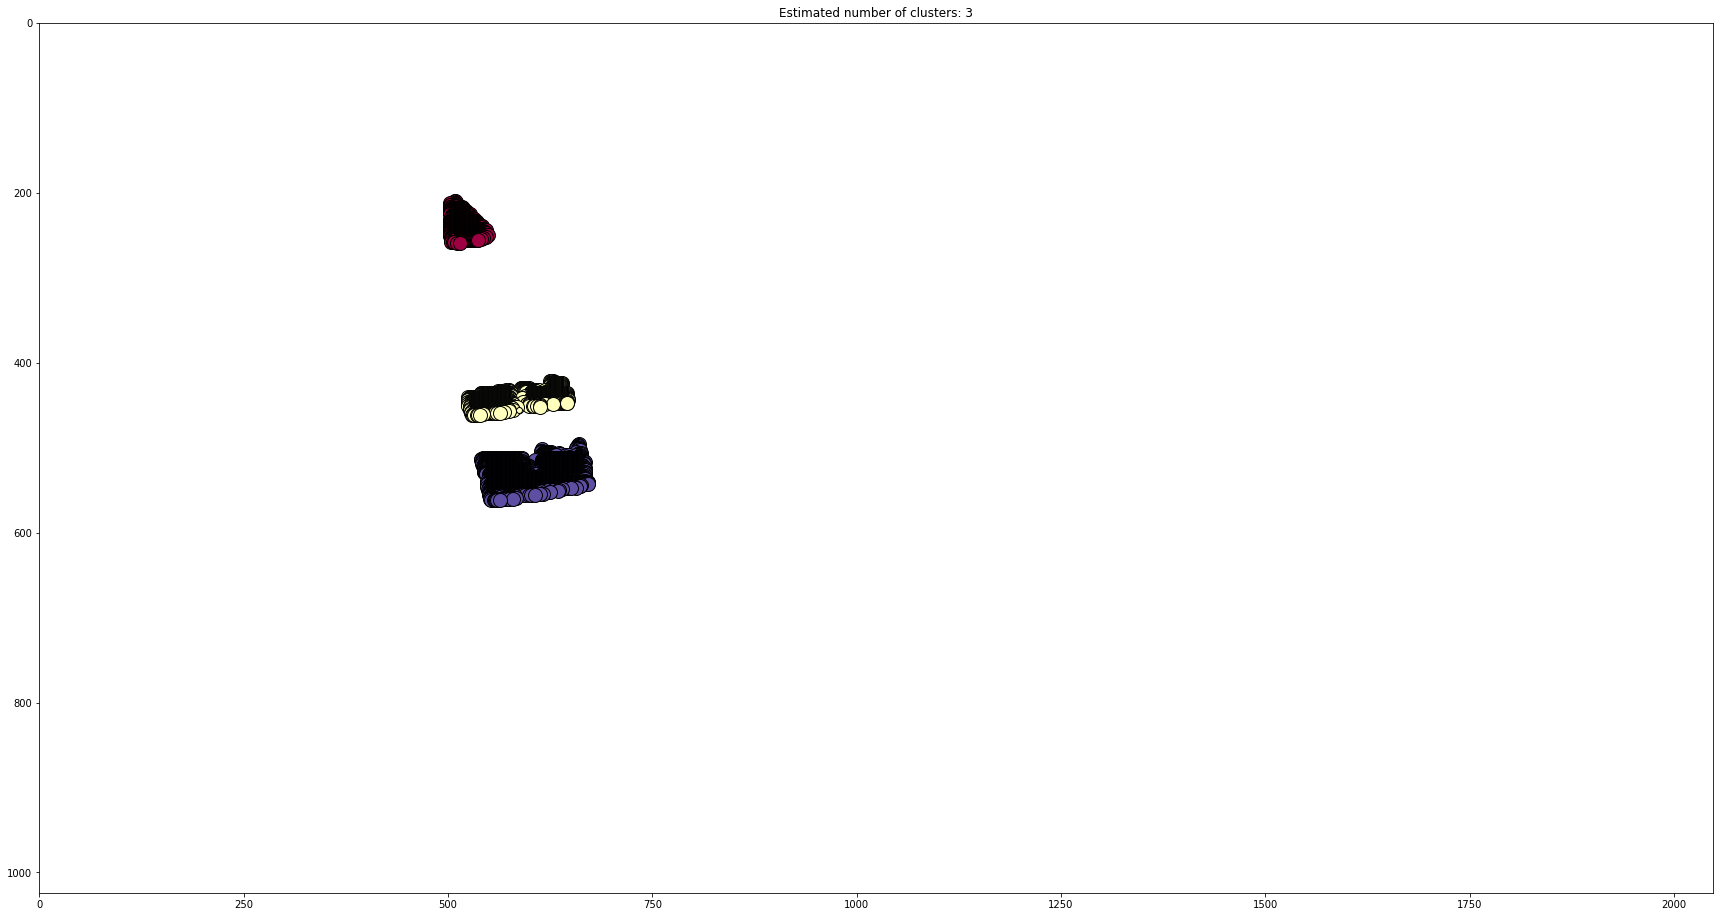

2016-10-19
Estimated number of clusters: 1
Writing labels to: data/4326/2016-10-19/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


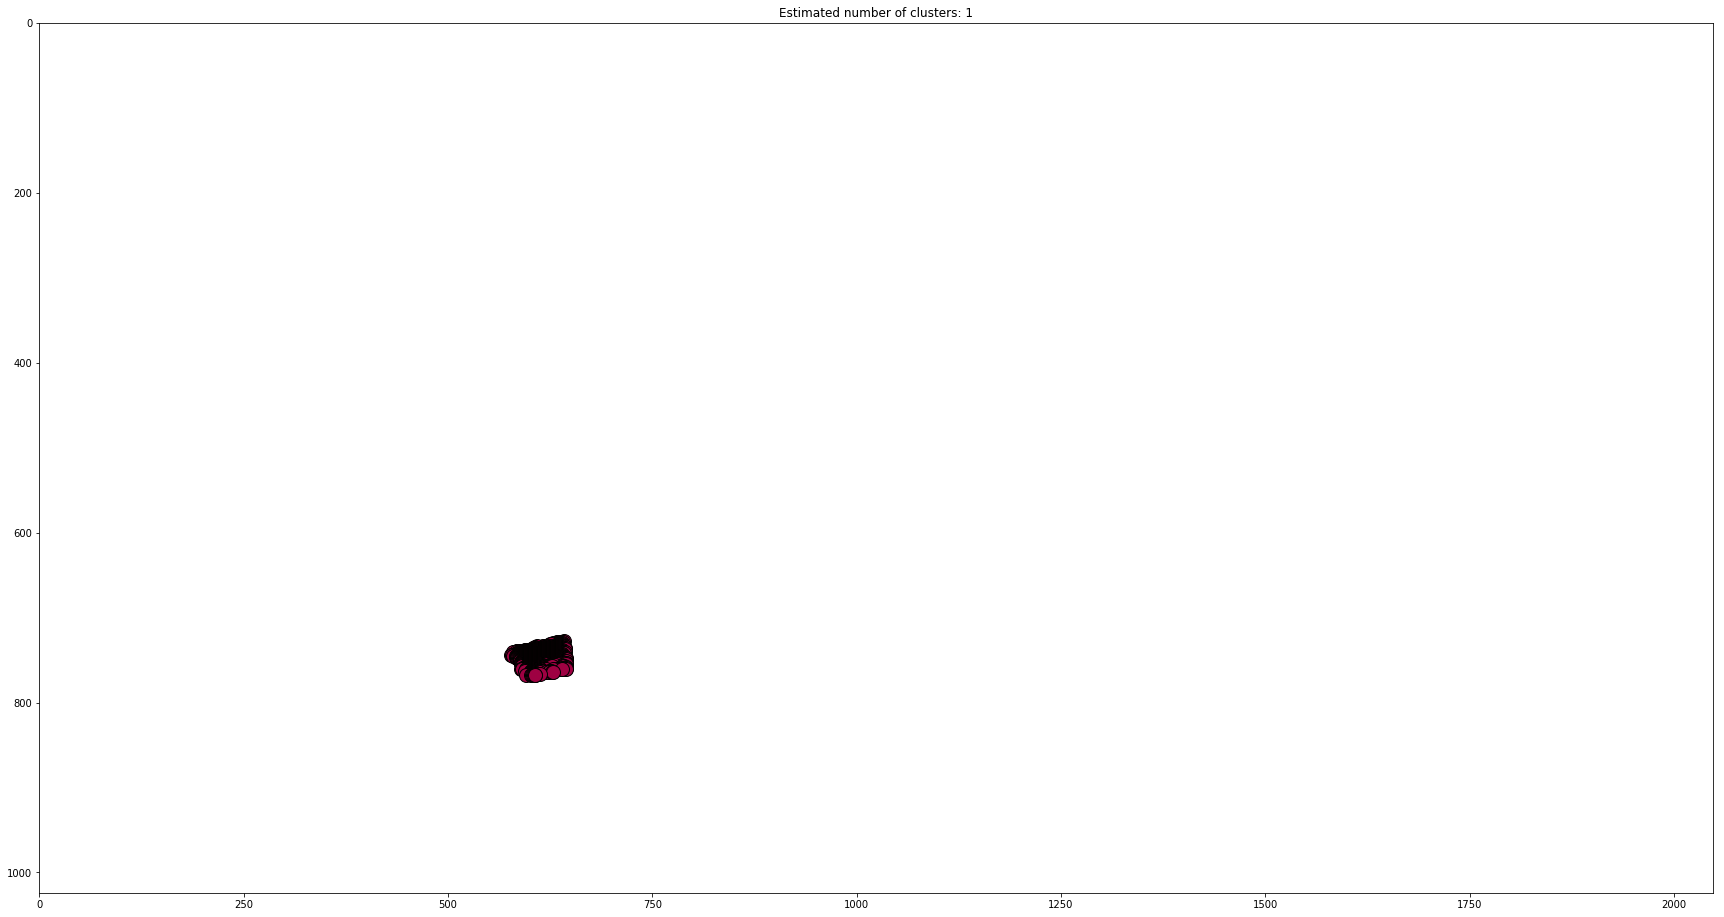

2016-11-09
Estimated number of clusters: 1
Writing labels to: data/4326/2016-11-09/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


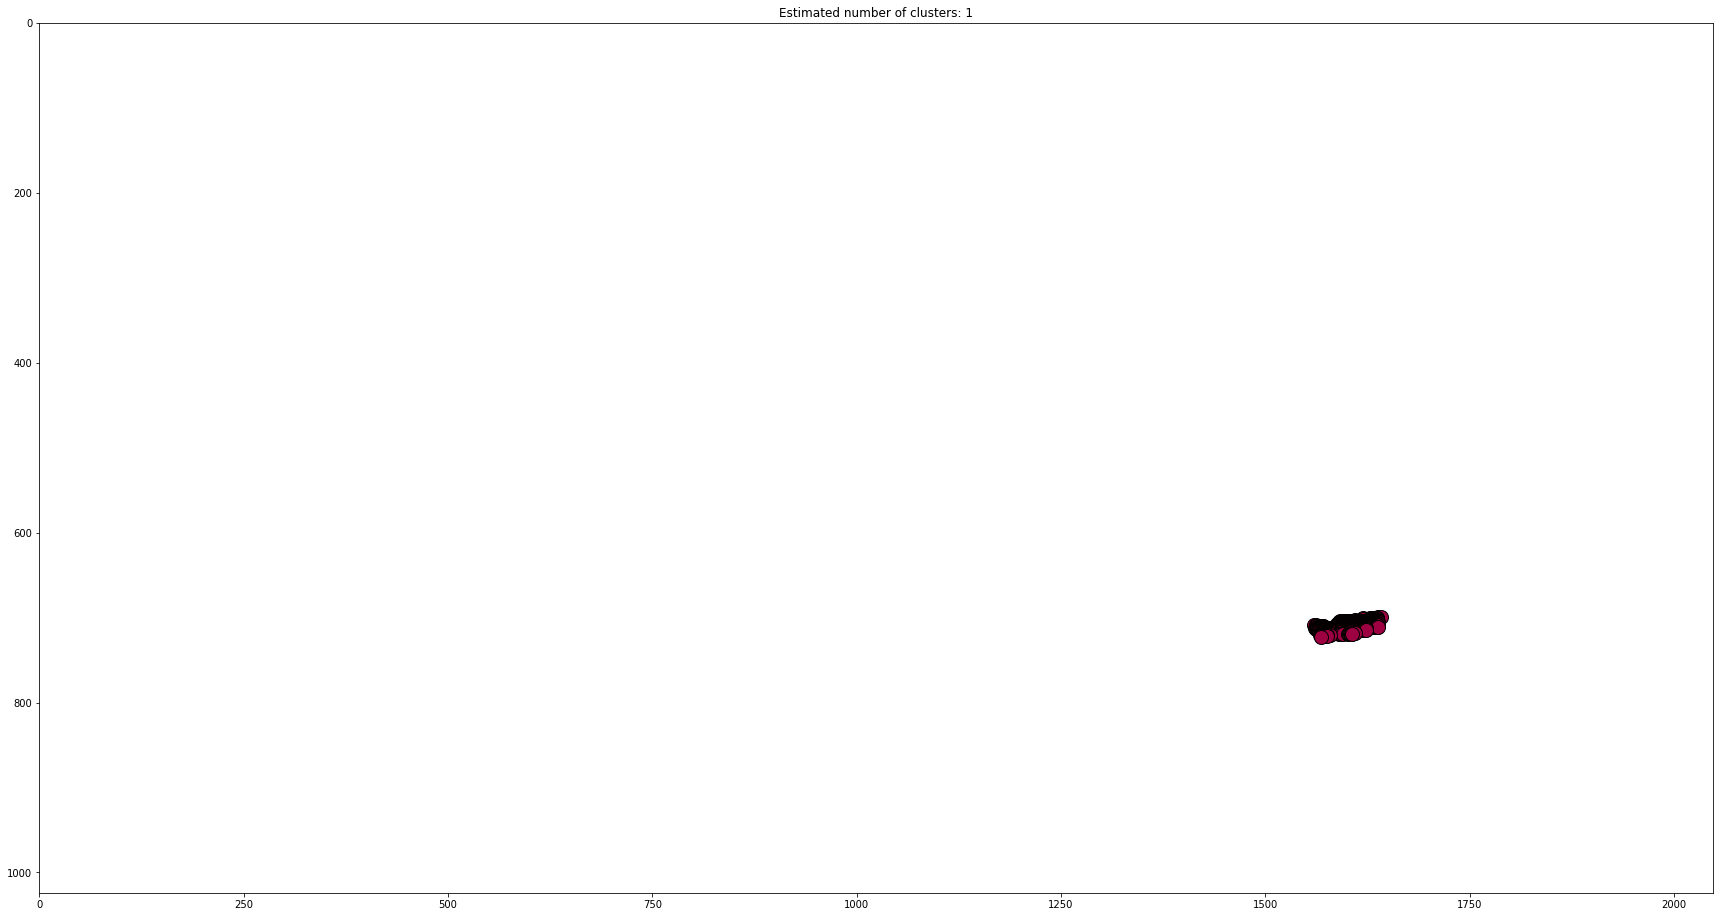

2016-11-10
Estimated number of clusters: 1
Writing labels to: data/4326/2016-11-10/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


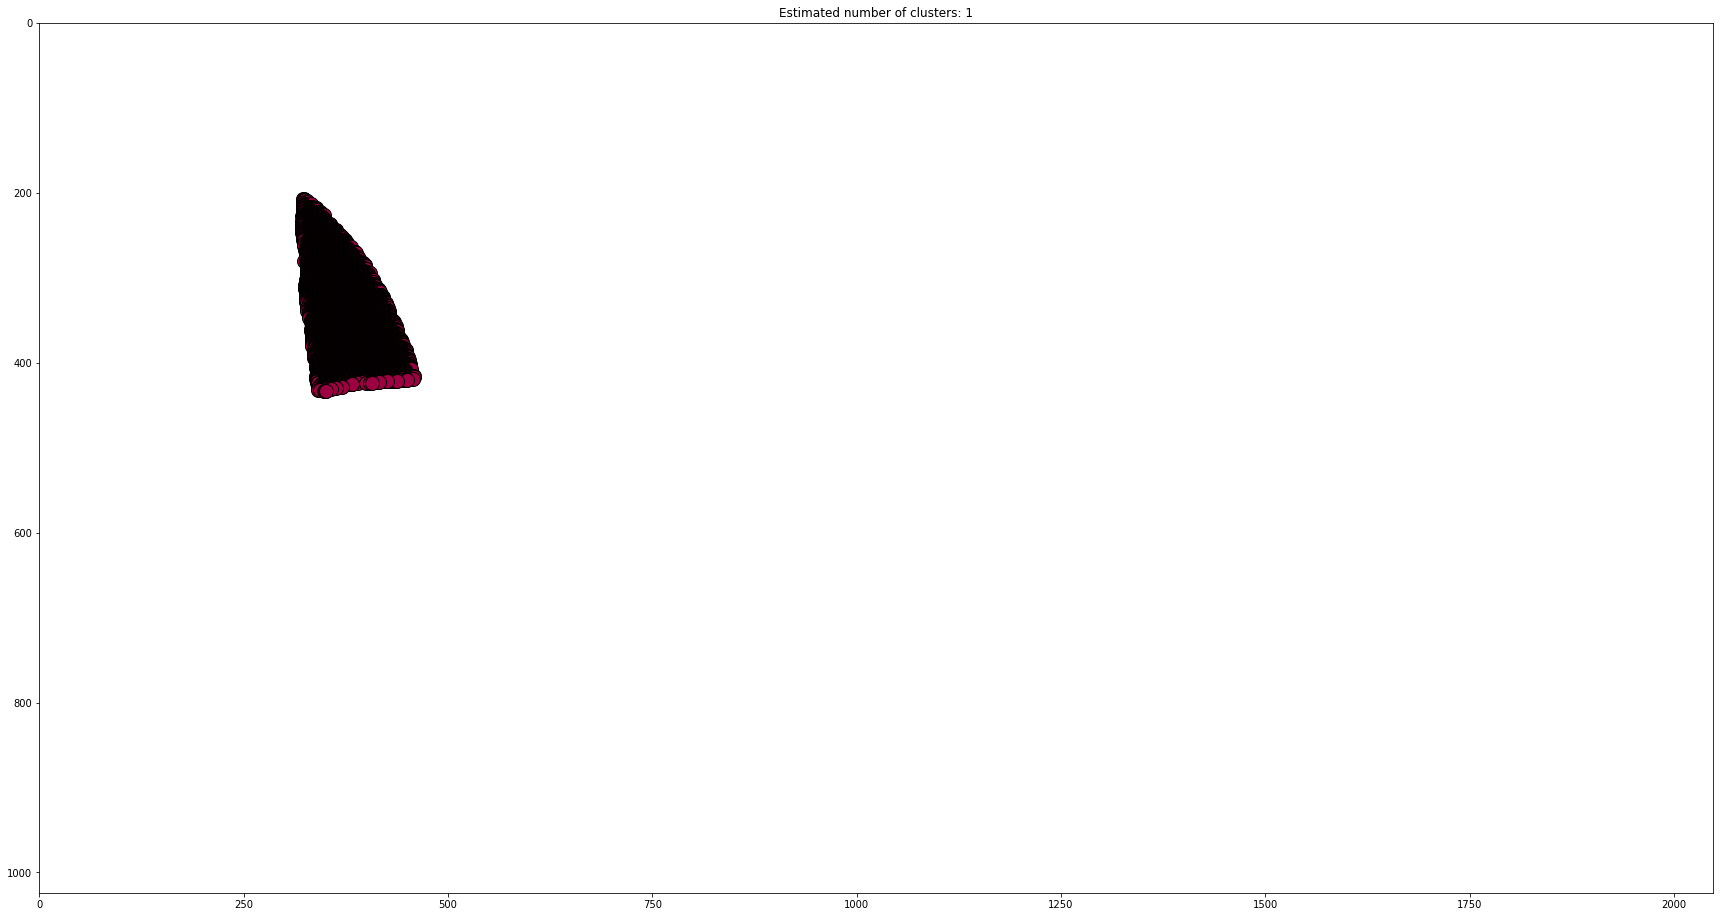

2016-12-10
Estimated number of clusters: 1
Writing labels to: data/4326/2016-12-10/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


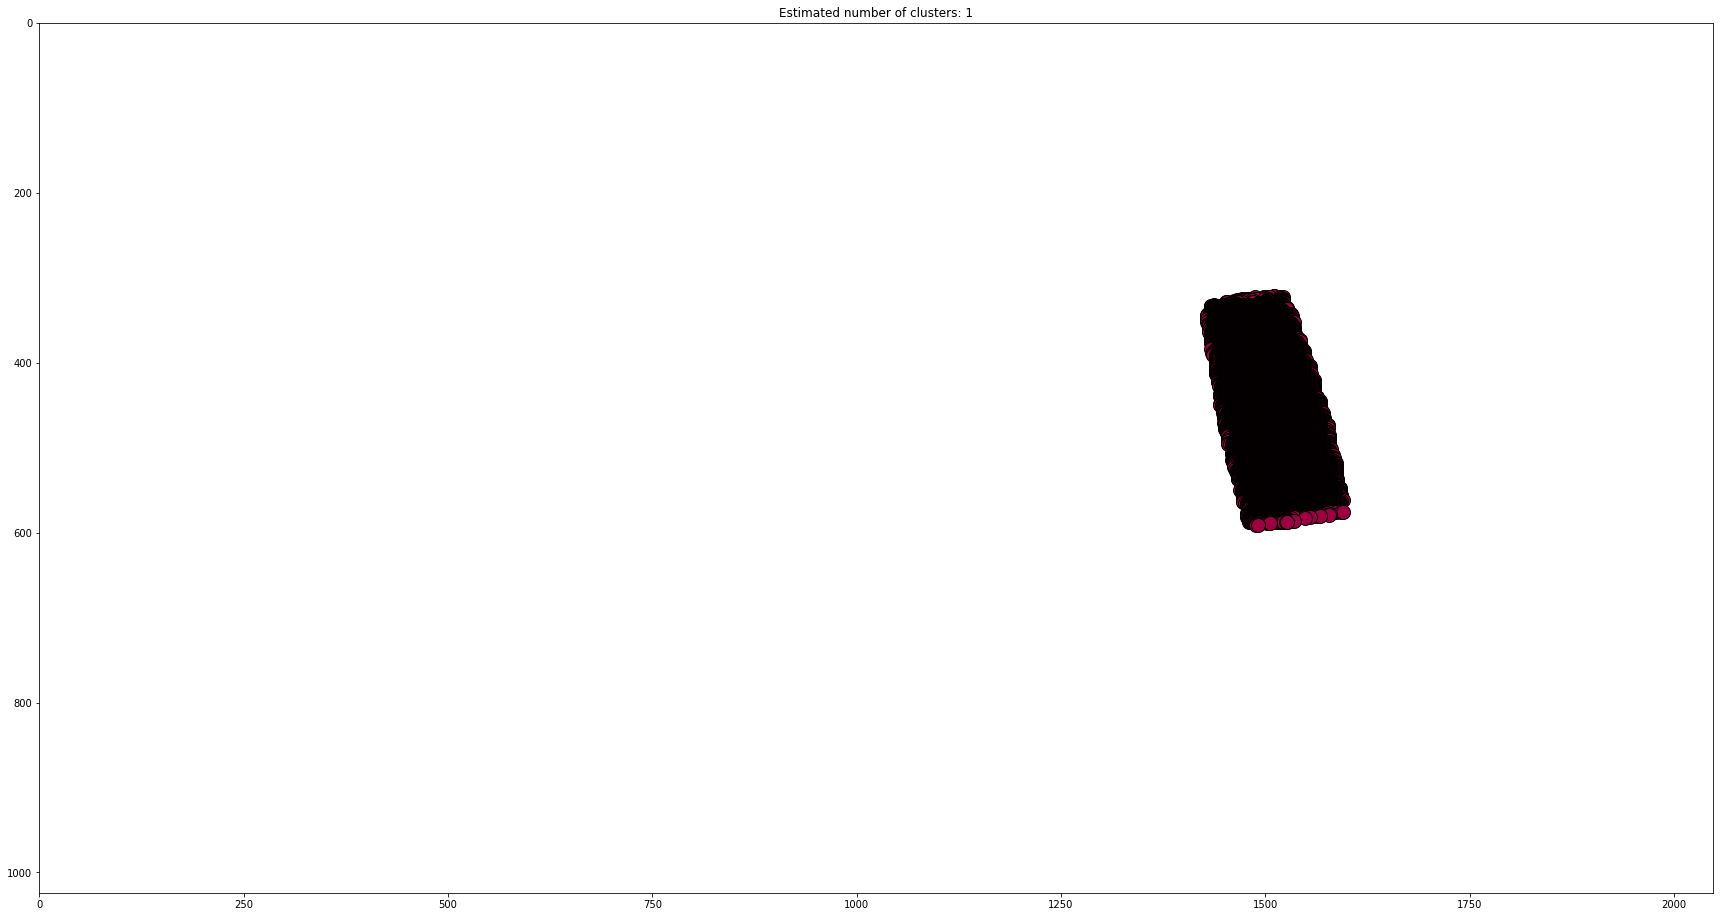

2016-12-14
Estimated number of clusters: 1
Writing labels to: data/4326/2016-12-14/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


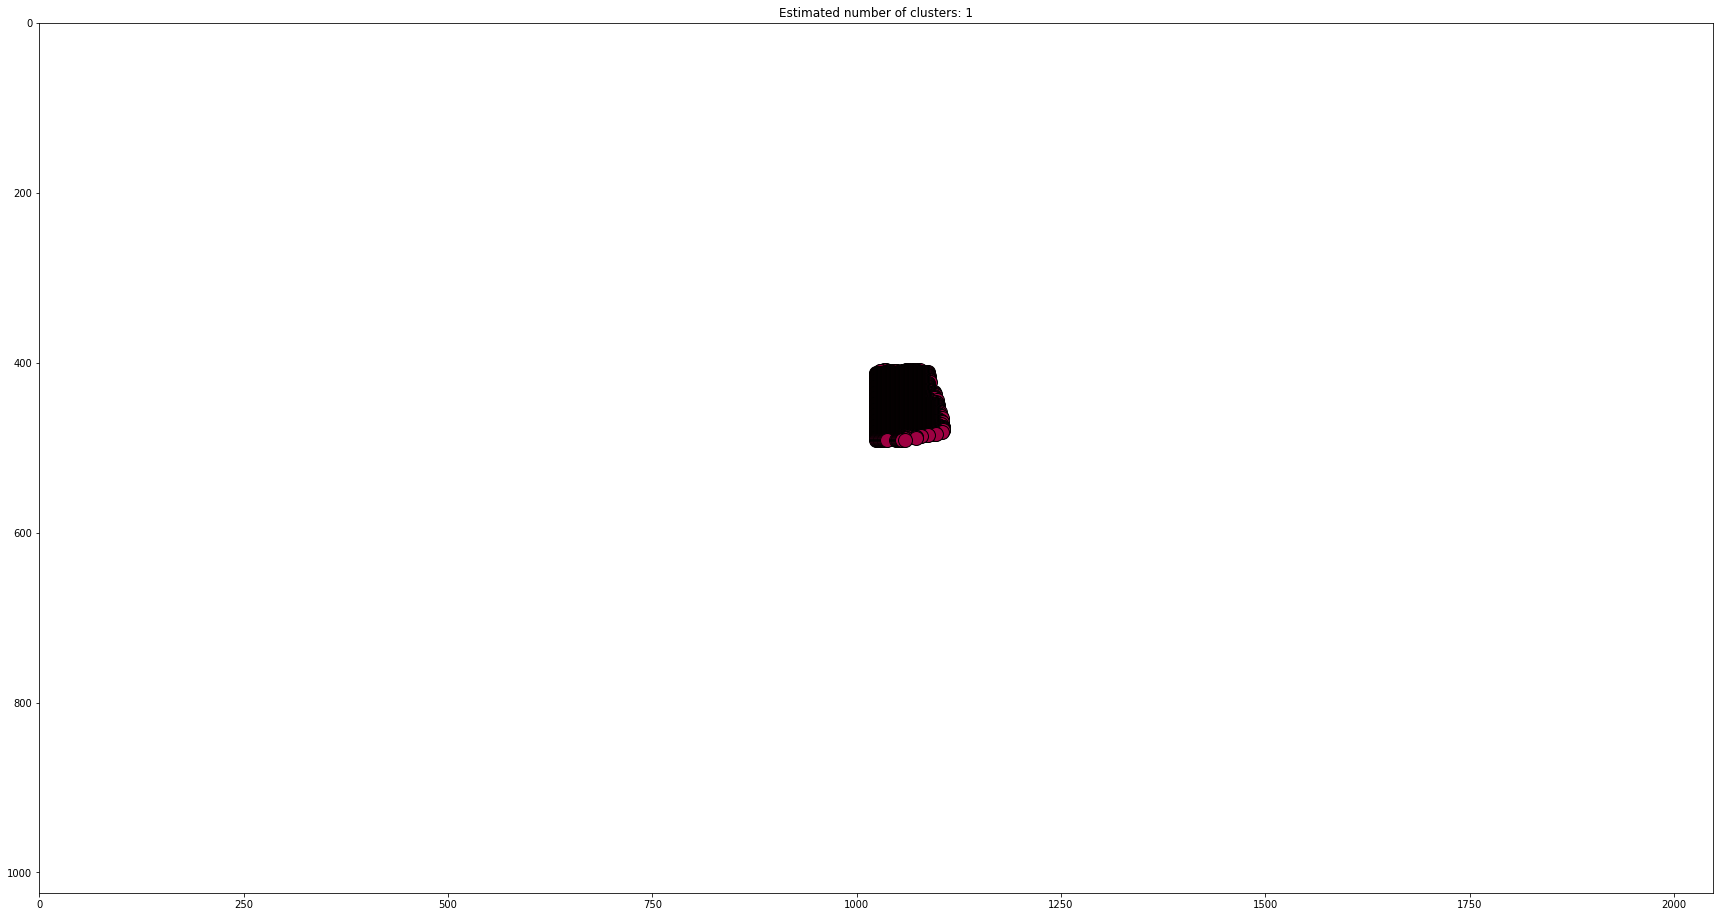

2016-12-20
Estimated number of clusters: 1
Writing labels to: data/4326/2016-12-20/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


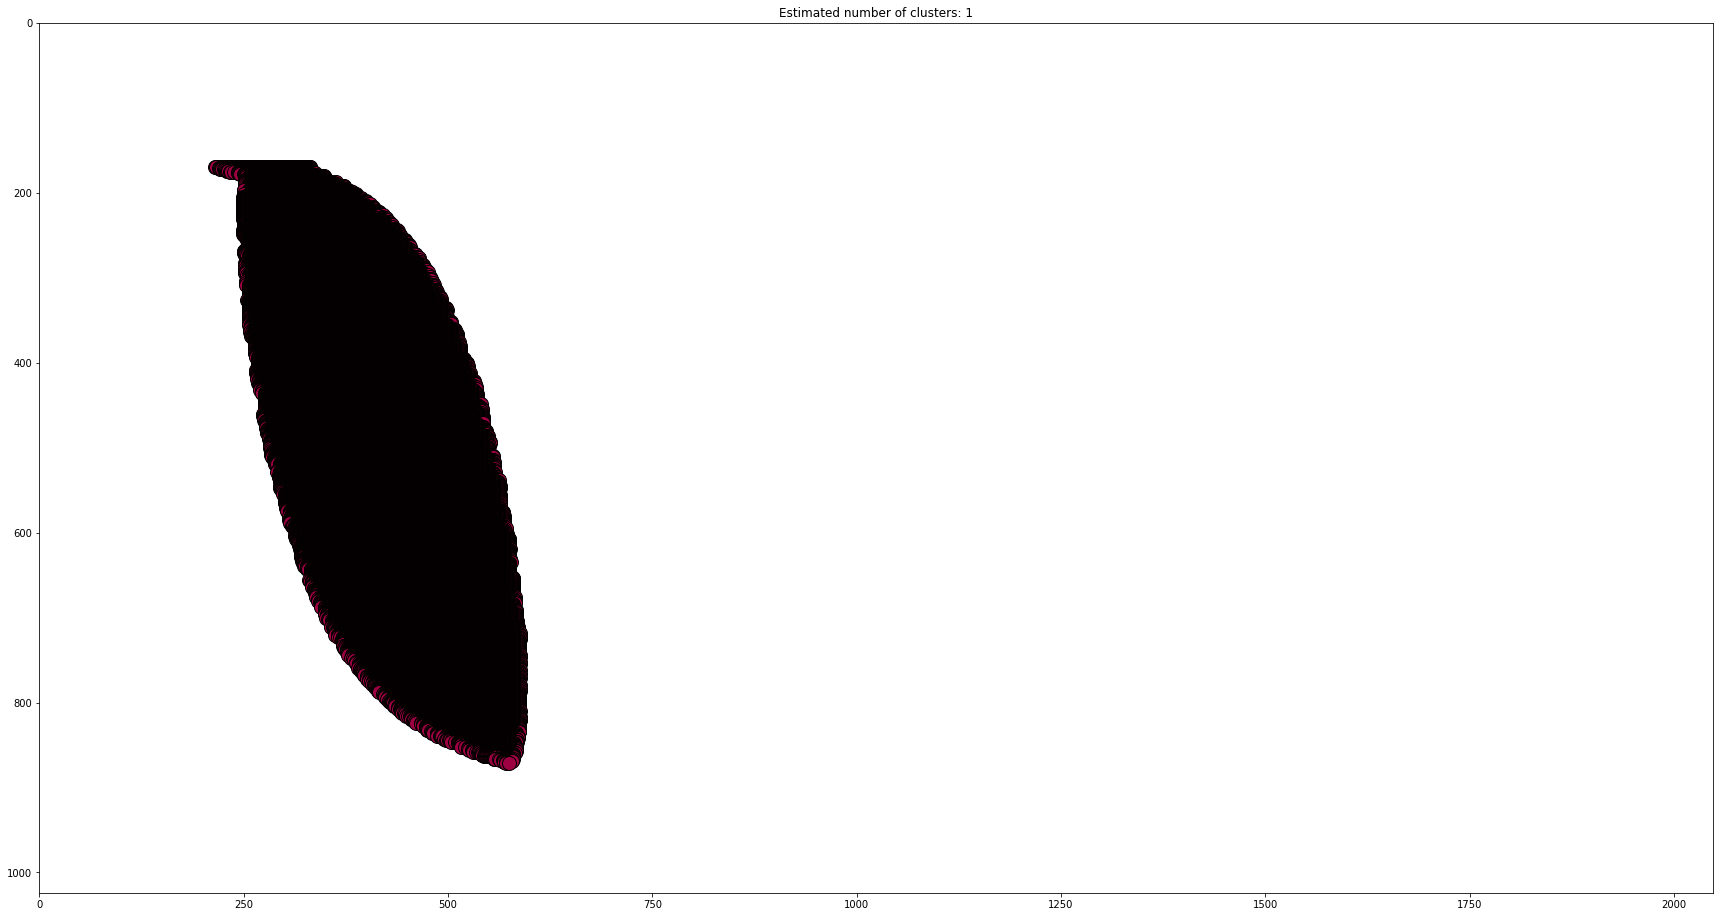

2017-01-08
Estimated number of clusters: 1
Writing labels to: data/4326/2017-01-08/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


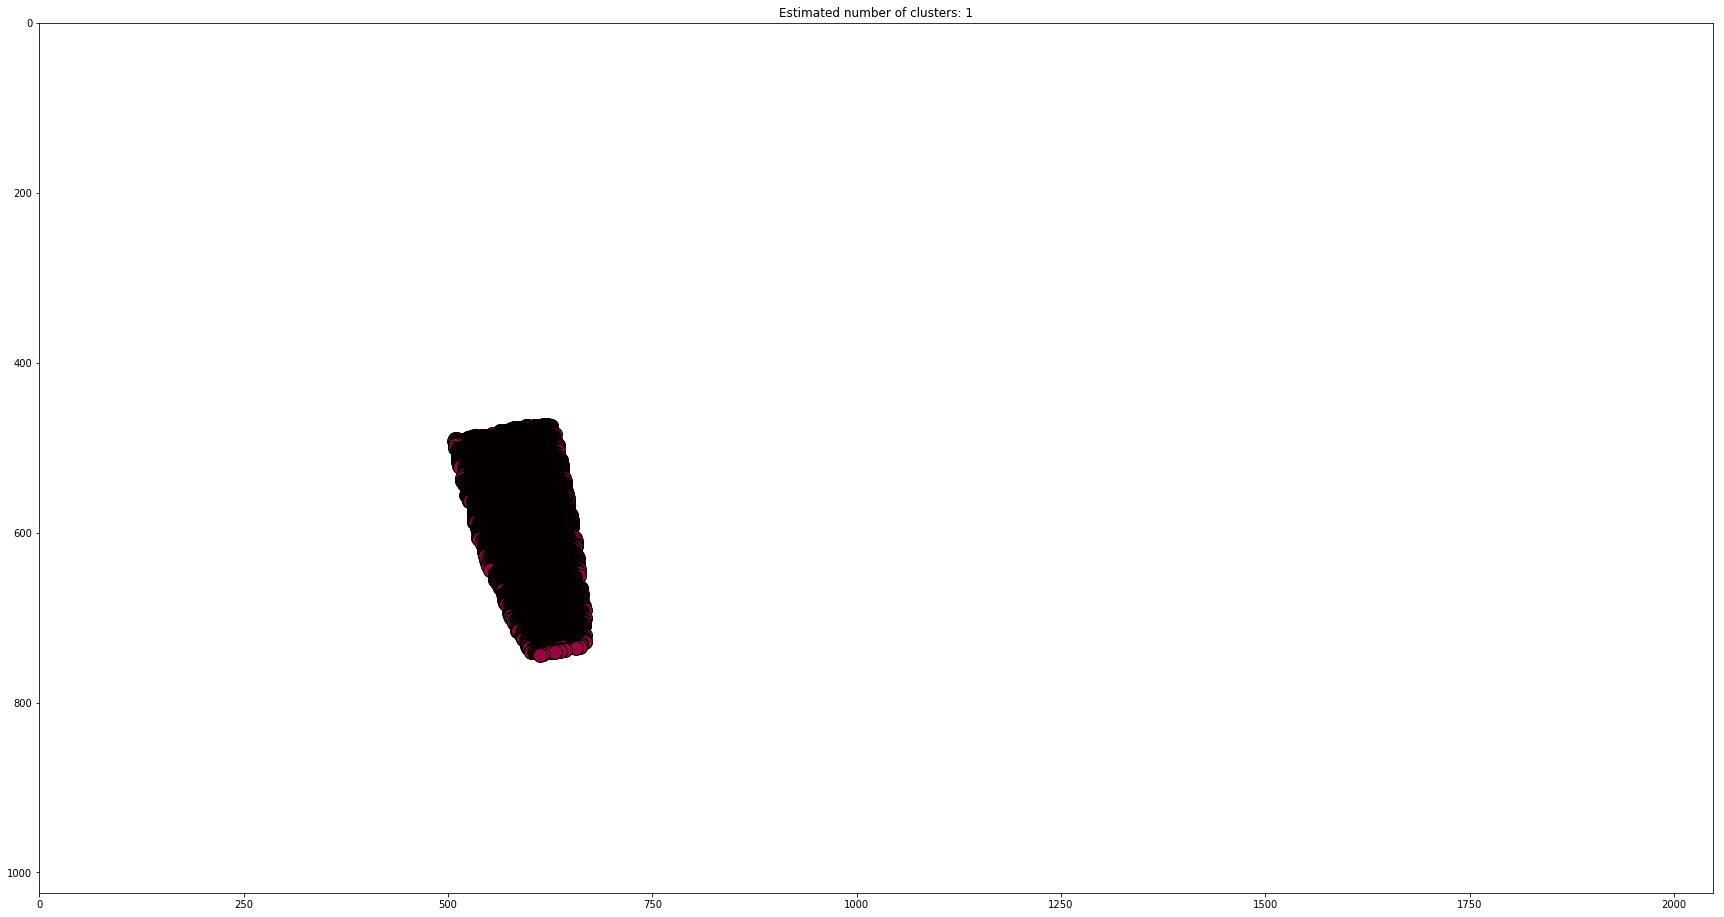

2017-02-06
Estimated number of clusters: 1
Writing labels to: data/4326/2017-02-06/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


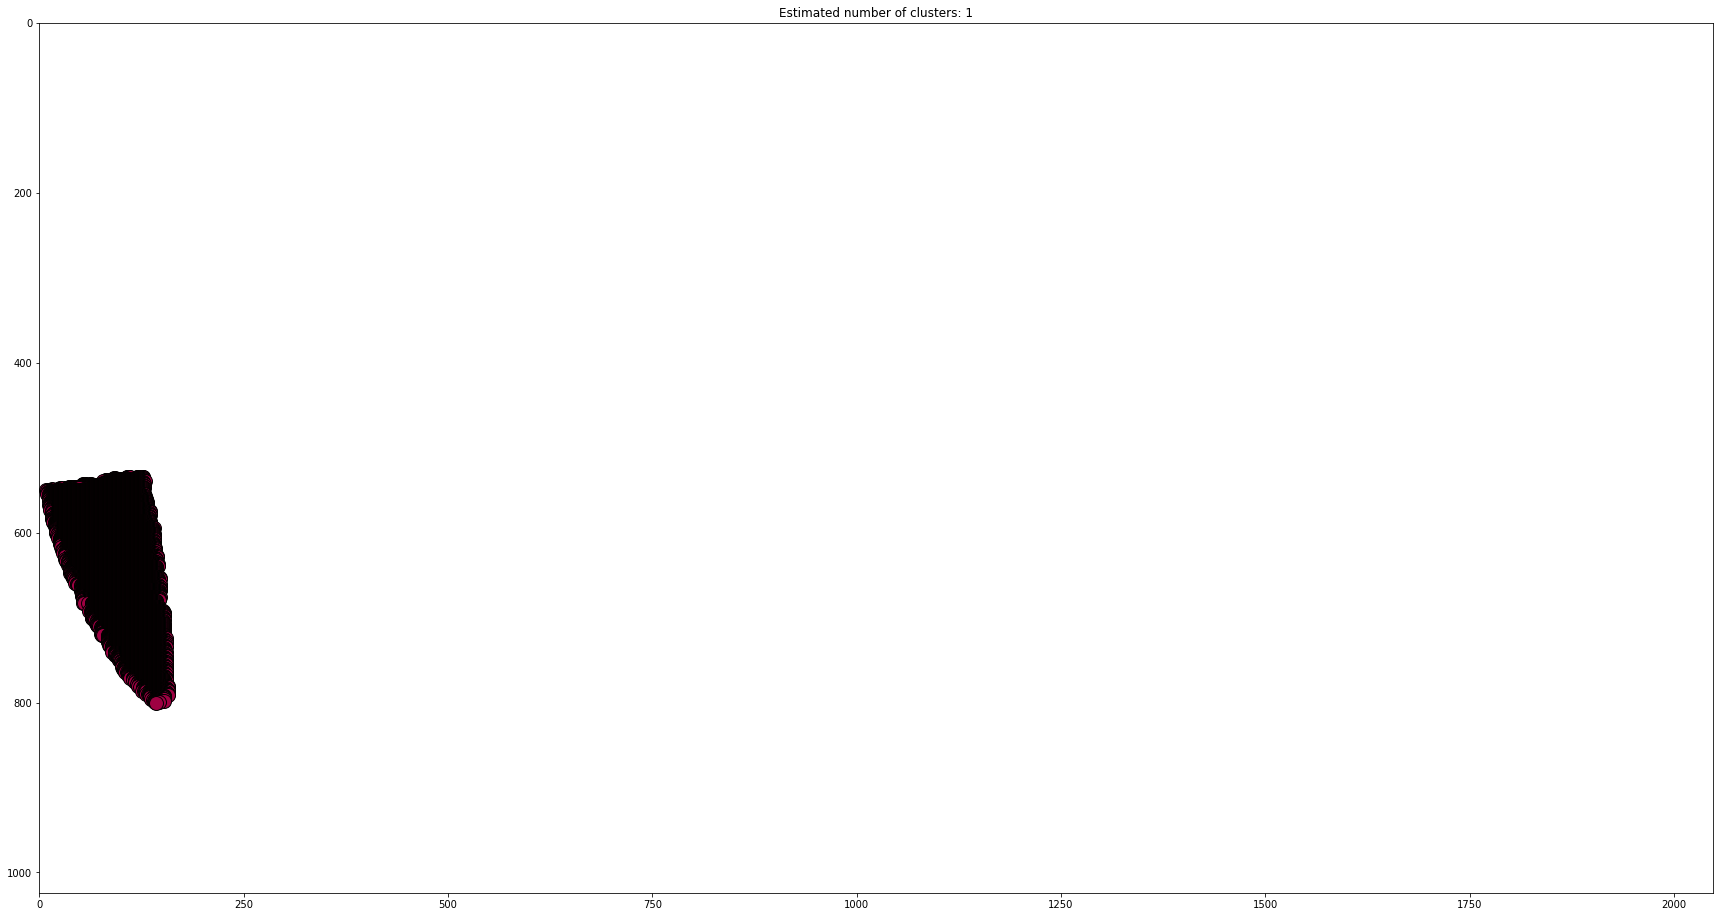

2017-03-08
Estimated number of clusters: 1
Writing labels to: data/4326/2017-03-08/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


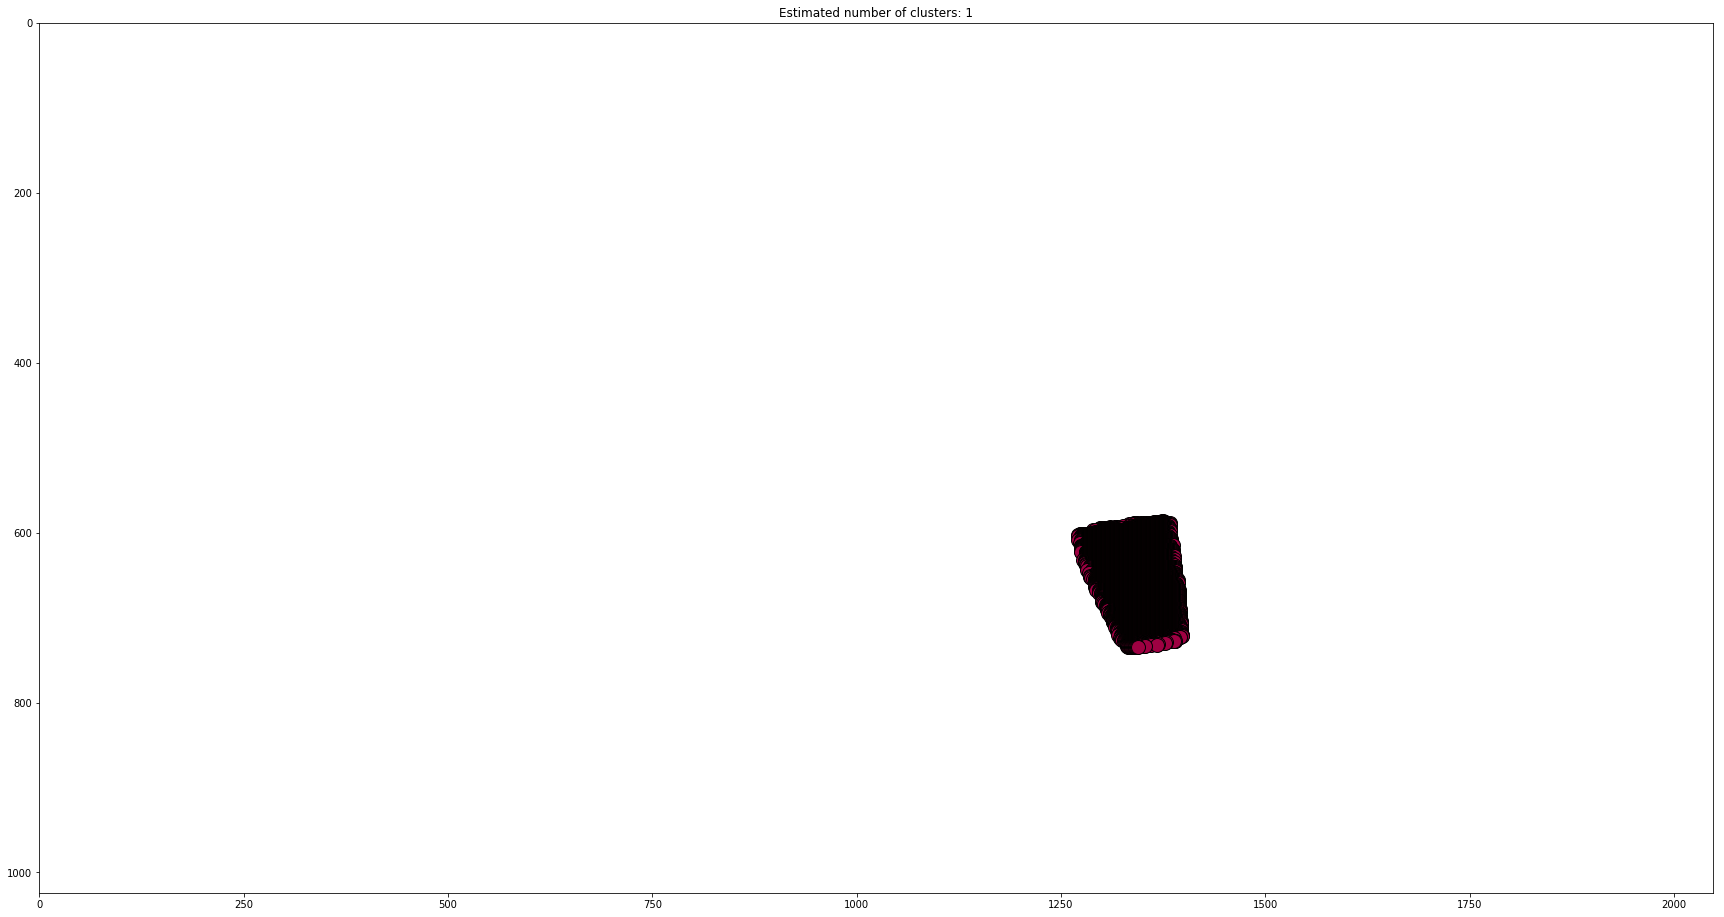

2017-03-15
Estimated number of clusters: 2
Writing labels to: data/4326/2017-03-15/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


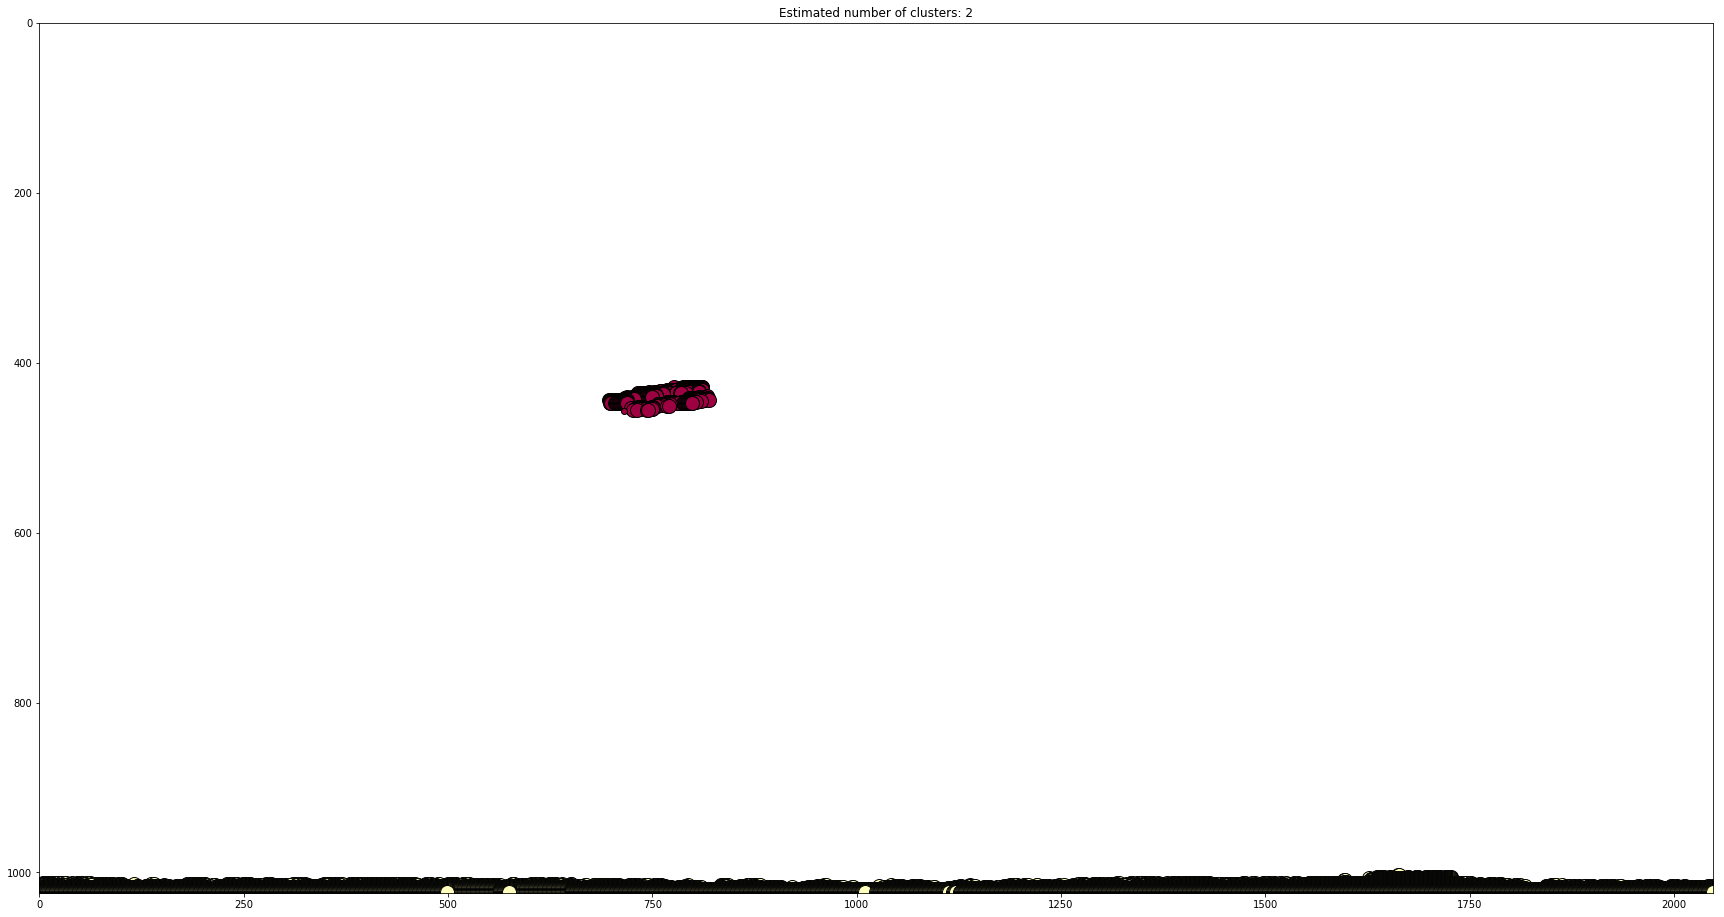

2017-03-19
Estimated number of clusters: 1
Writing labels to: data/4326/2017-03-19/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


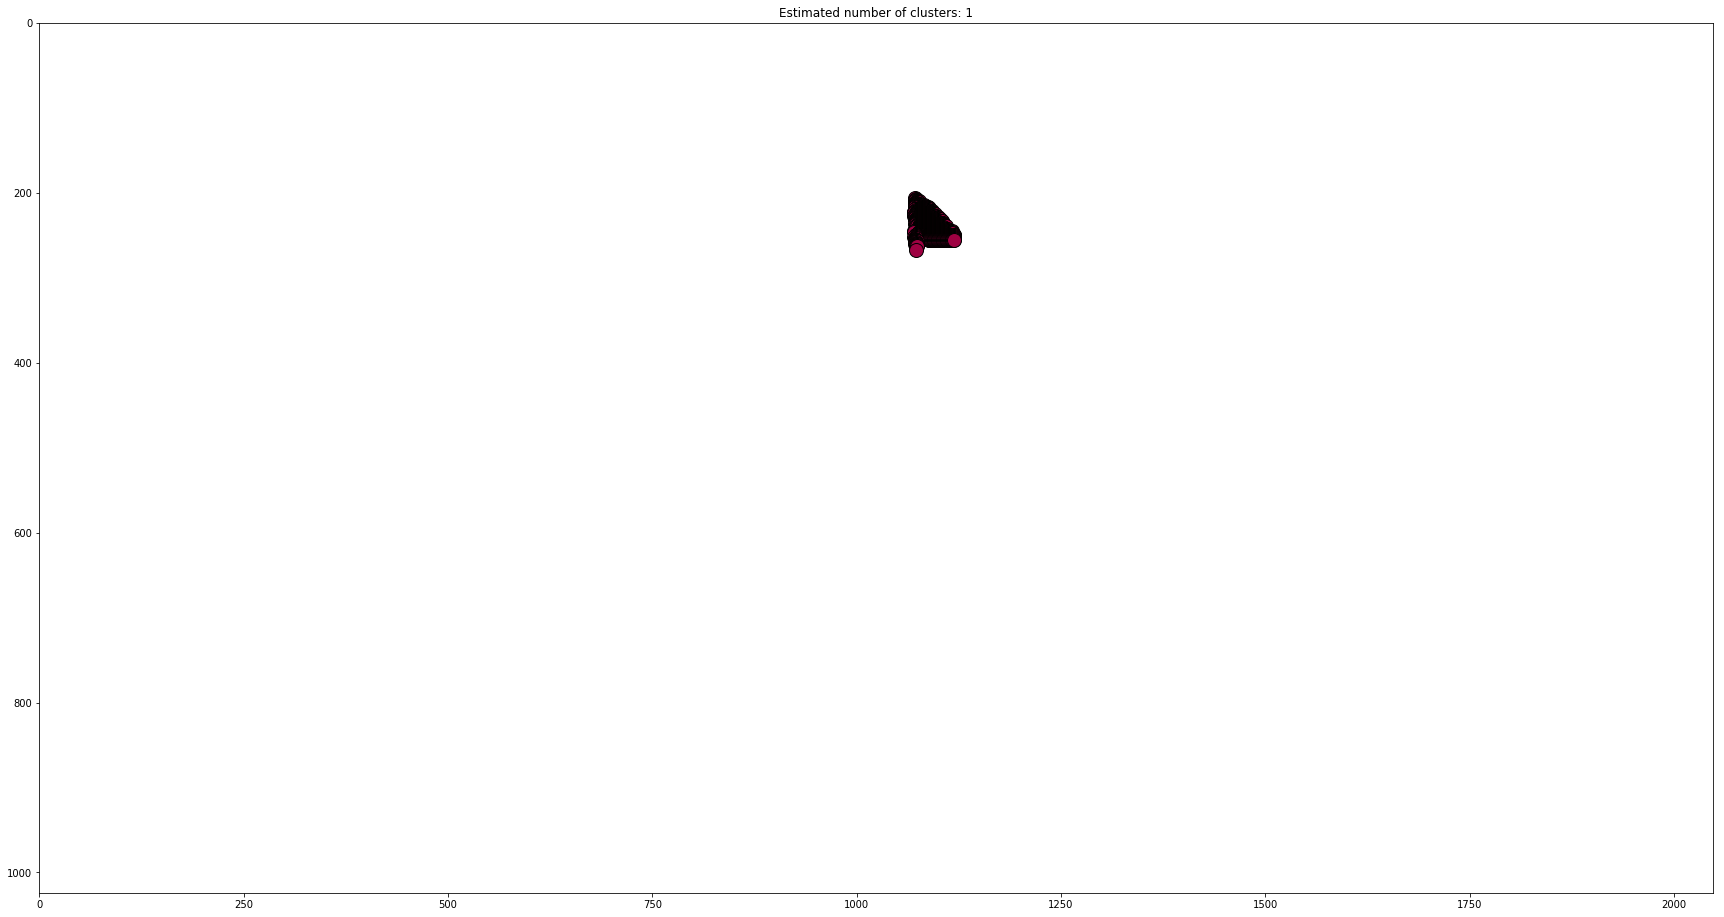

2017-03-26
Estimated number of clusters: 8
Writing labels to: data/4326/2017-03-26/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


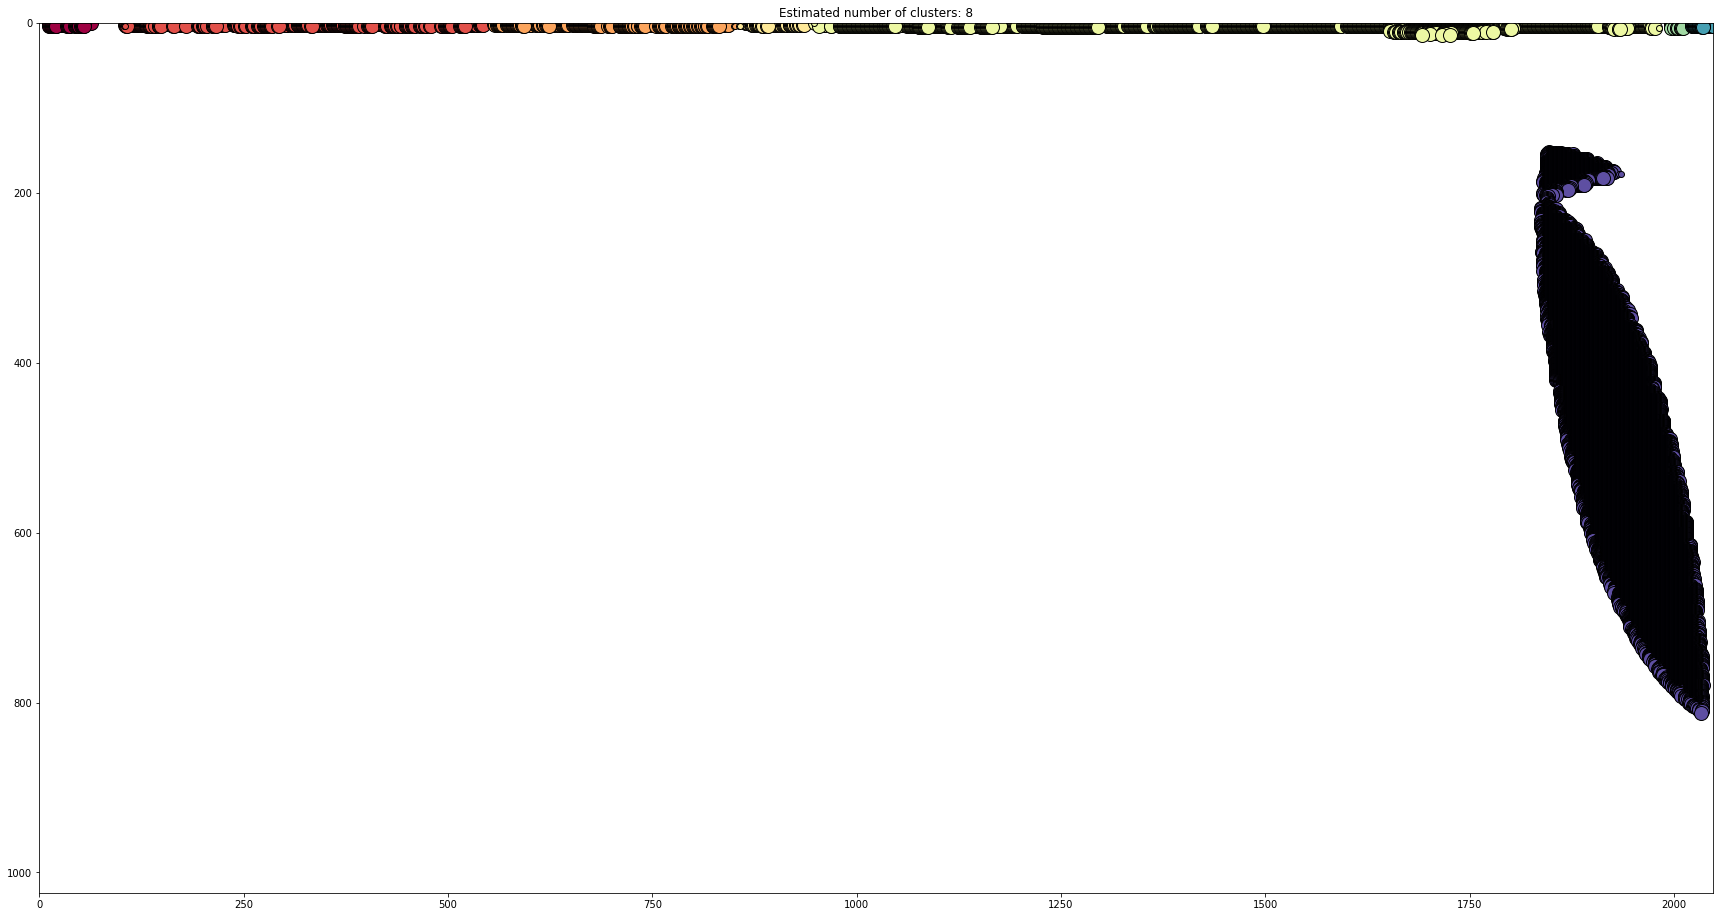

2017-03-29
Estimated number of clusters: 2
Writing labels to: data/4326/2017-03-29/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


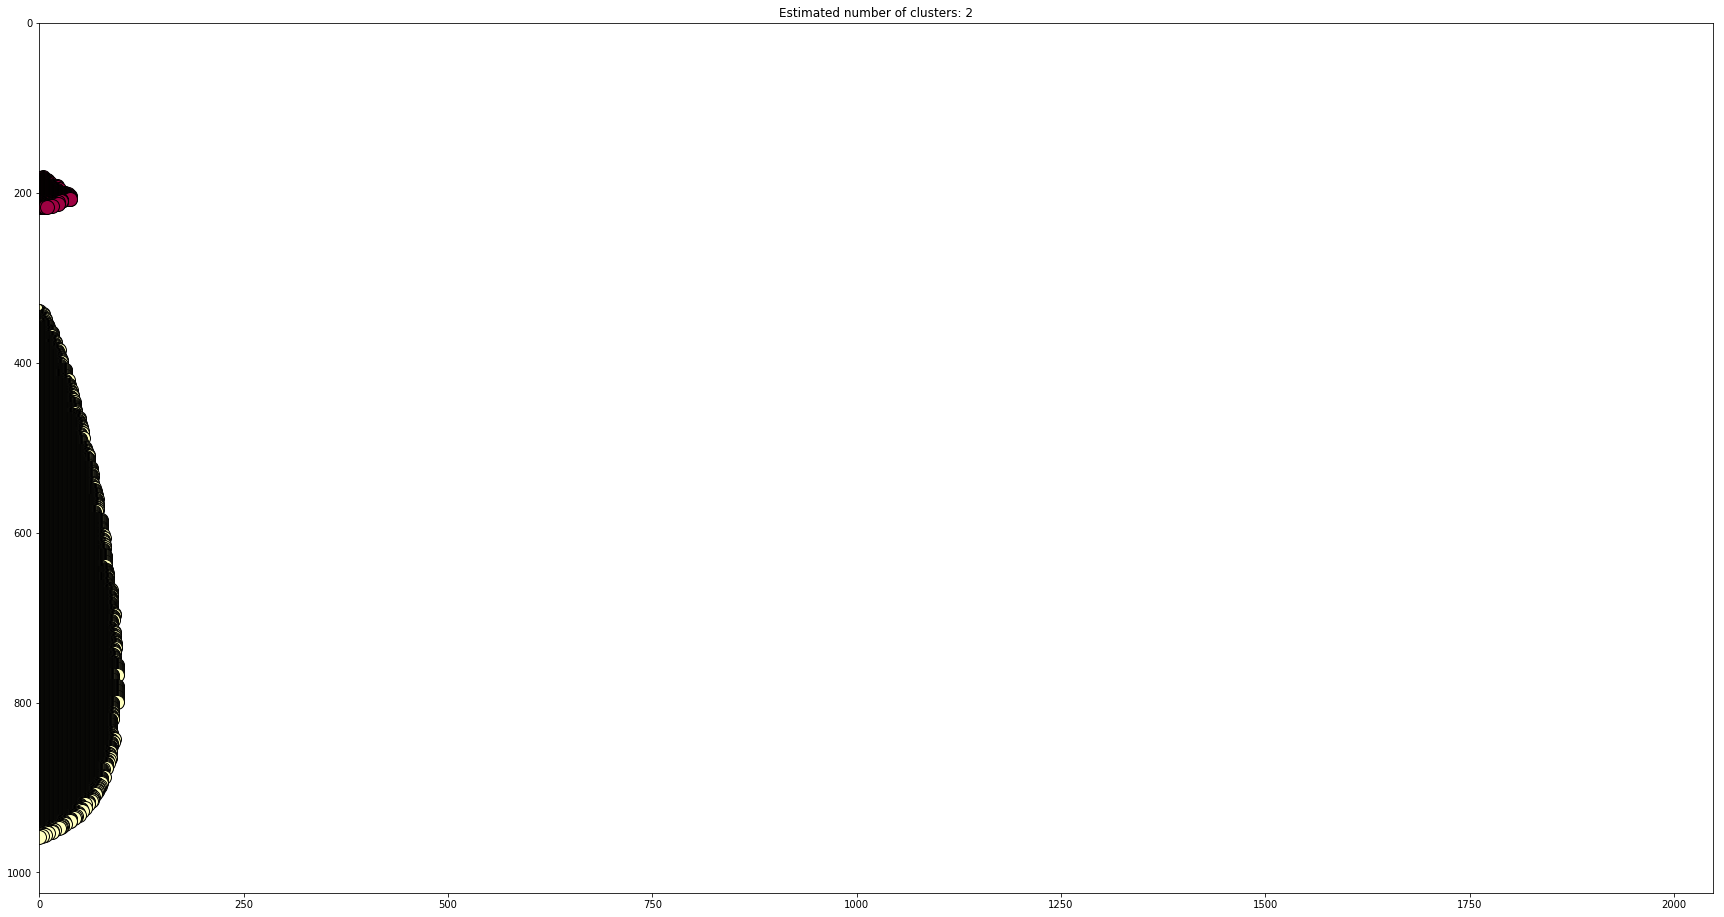

2017-03-30
Writing labels to: data/4326/2017-03-30/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


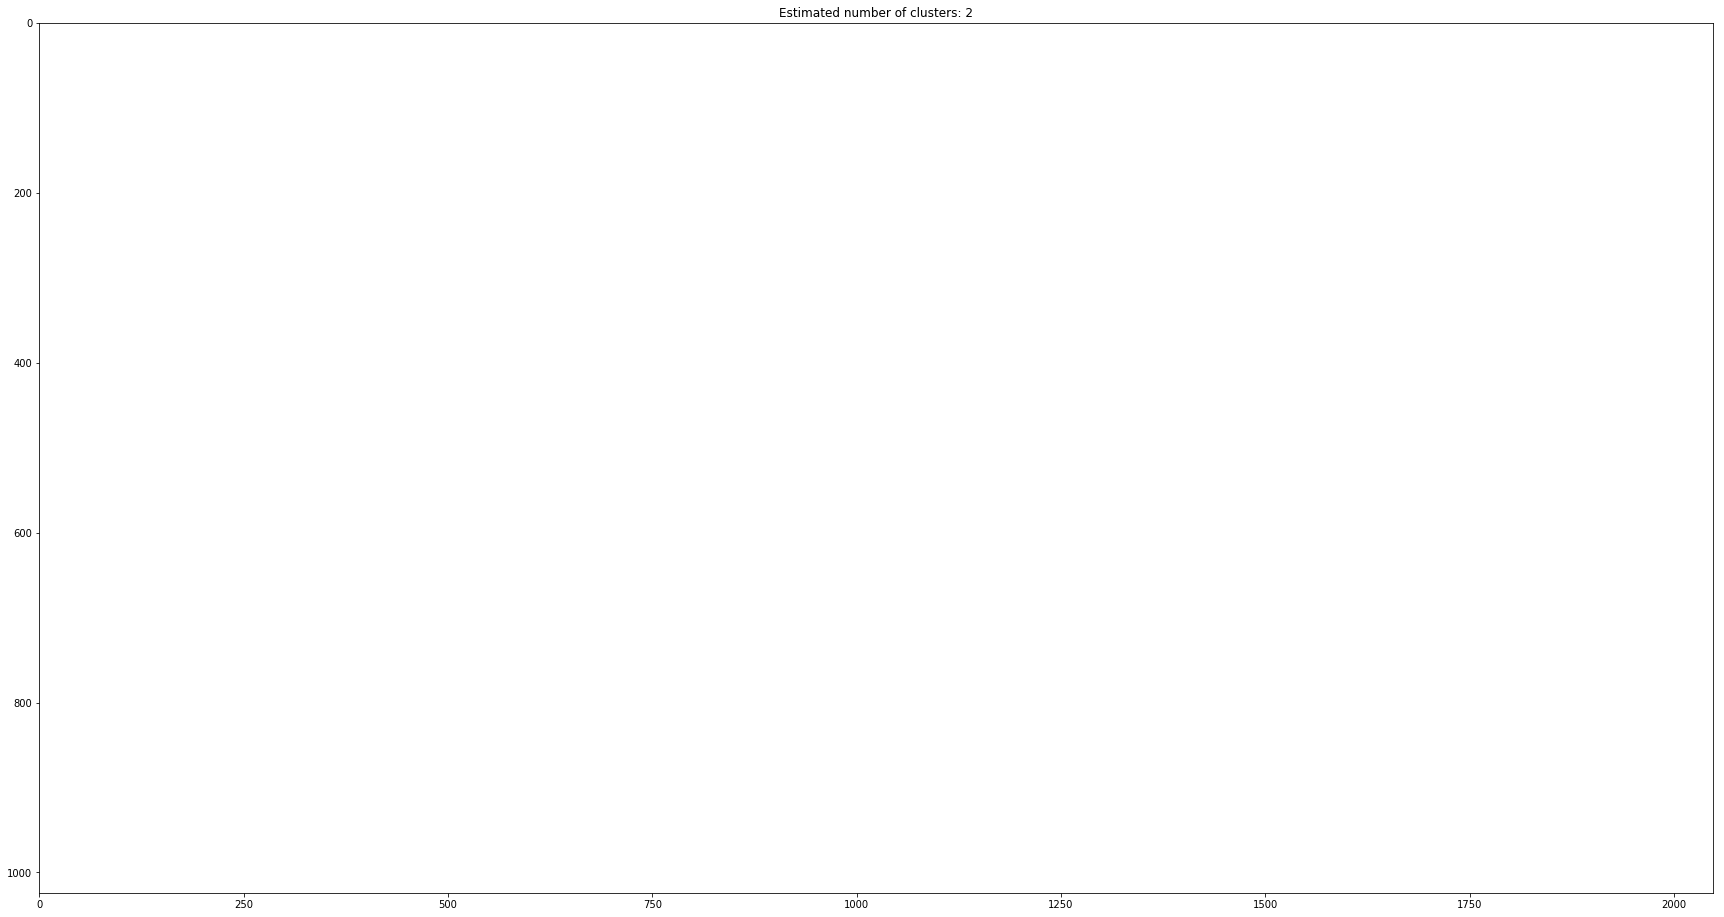

2017-03-31
Writing labels to: data/4326/2017-03-31/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


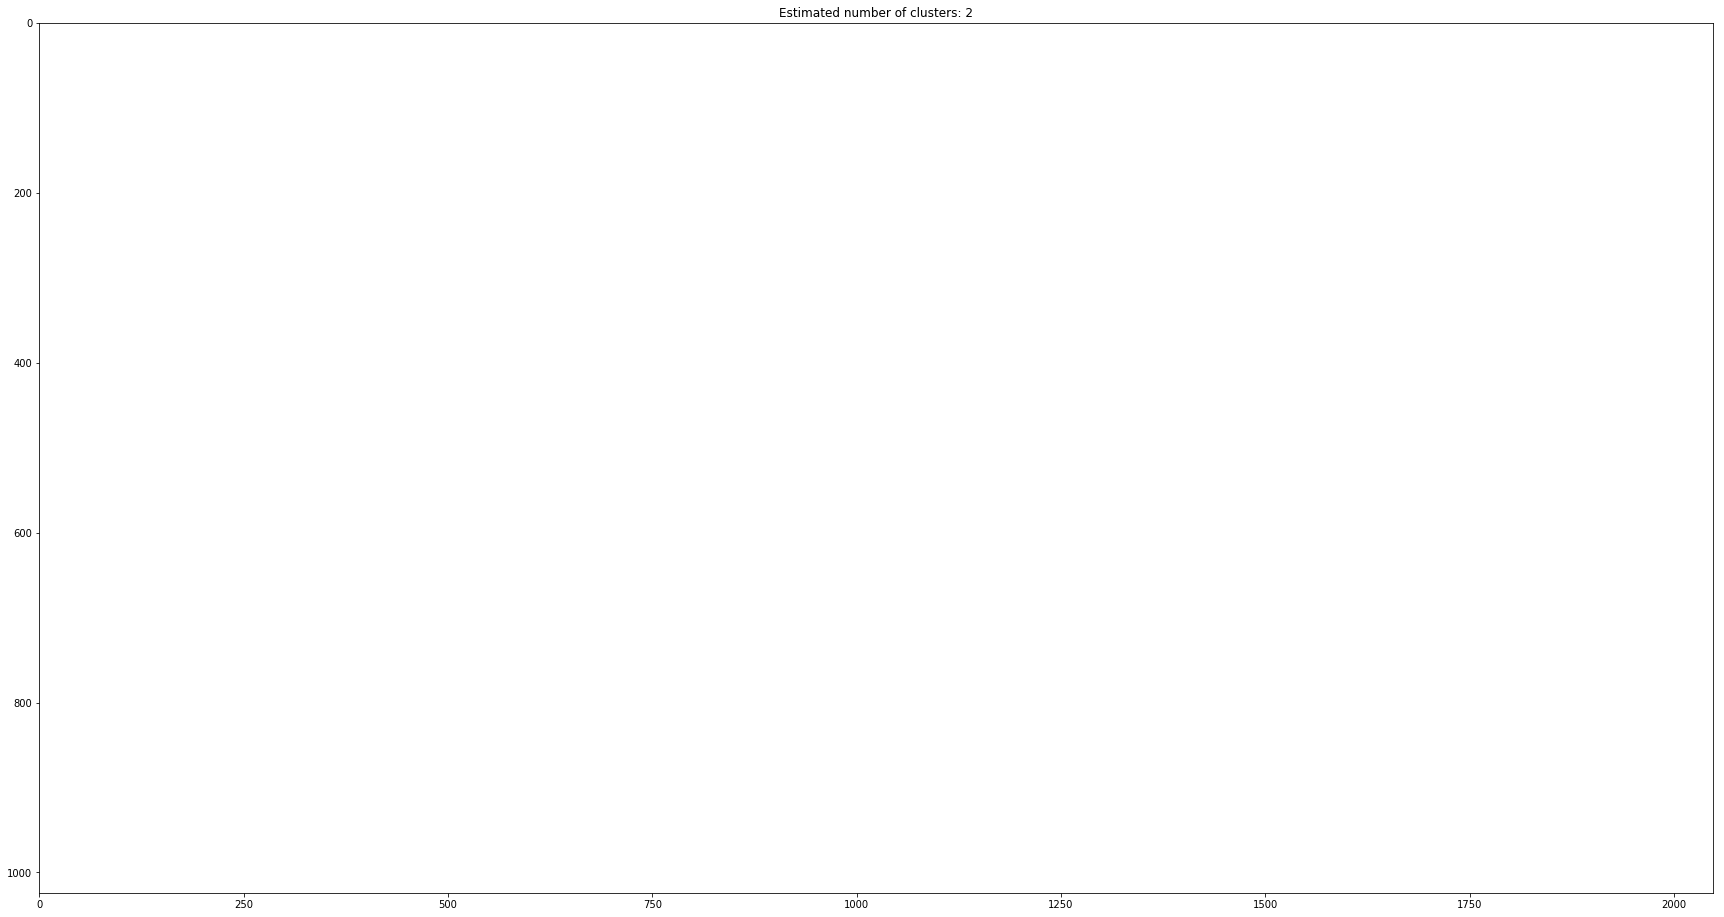

2017-04-01
Writing labels to: data/4326/2017-04-01/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


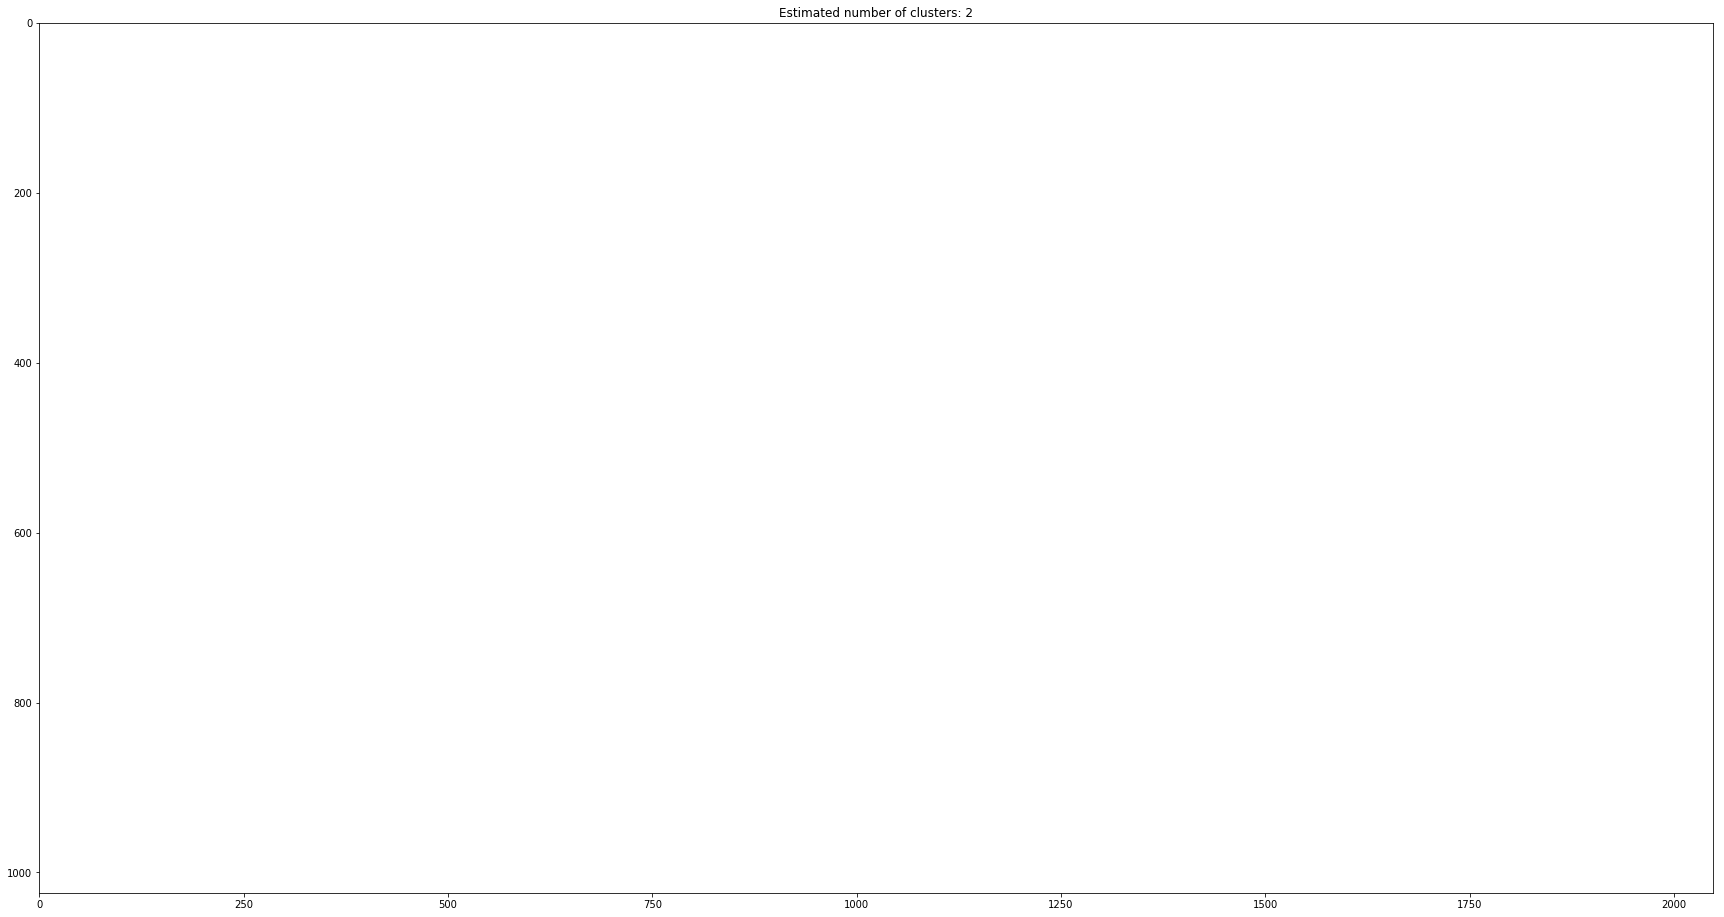

2017-04-05
Estimated number of clusters: 1
Writing labels to: data/4326/2017-04-05/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


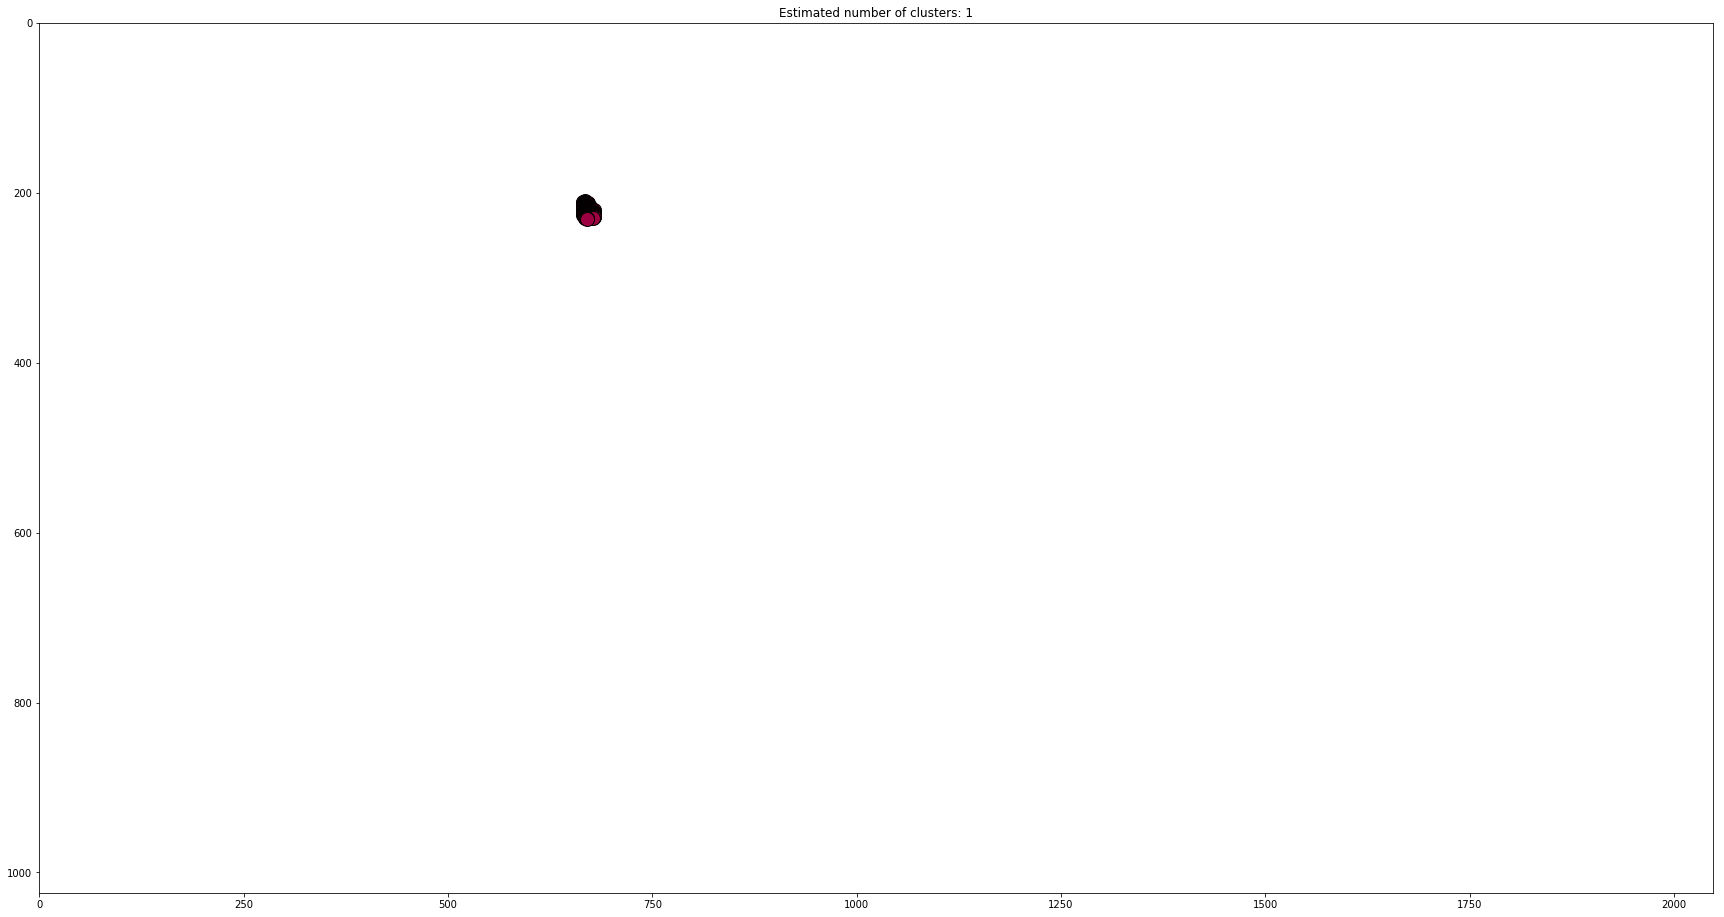

2017-04-06
Estimated number of clusters: 1
Writing labels to: data/4326/2017-04-06/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


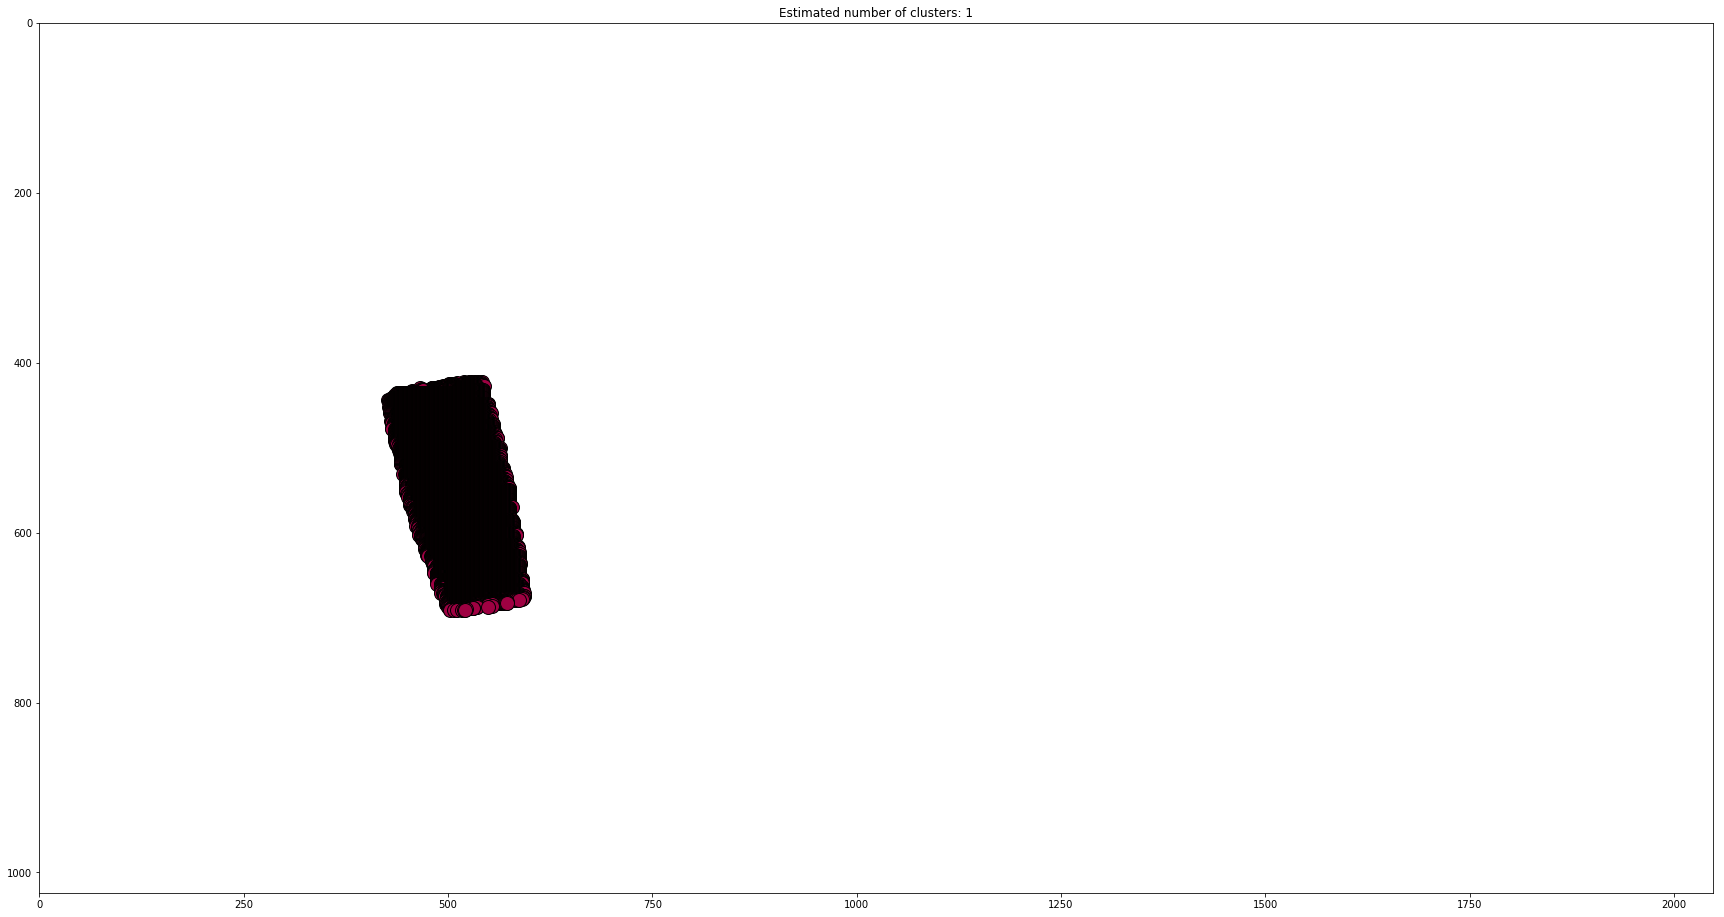

2017-05-06
Estimated number of clusters: 1
Writing labels to: data/4326/2017-05-06/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


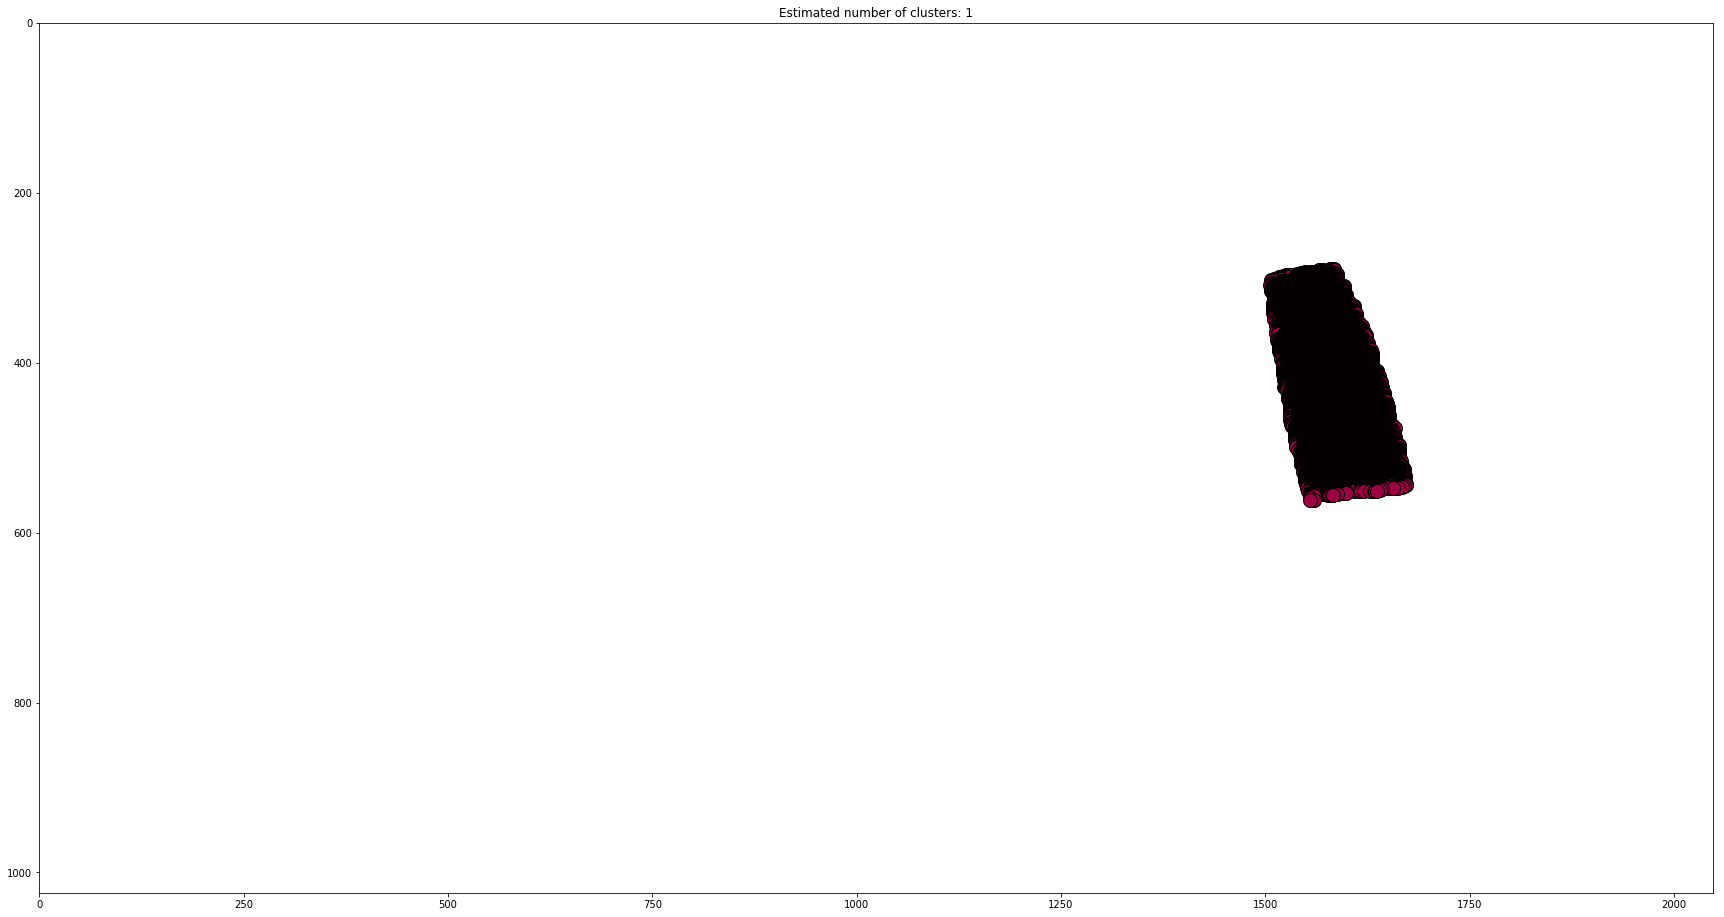

2017-06-04
Estimated number of clusters: 12
Writing labels to: data/4326/2017-06-04/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


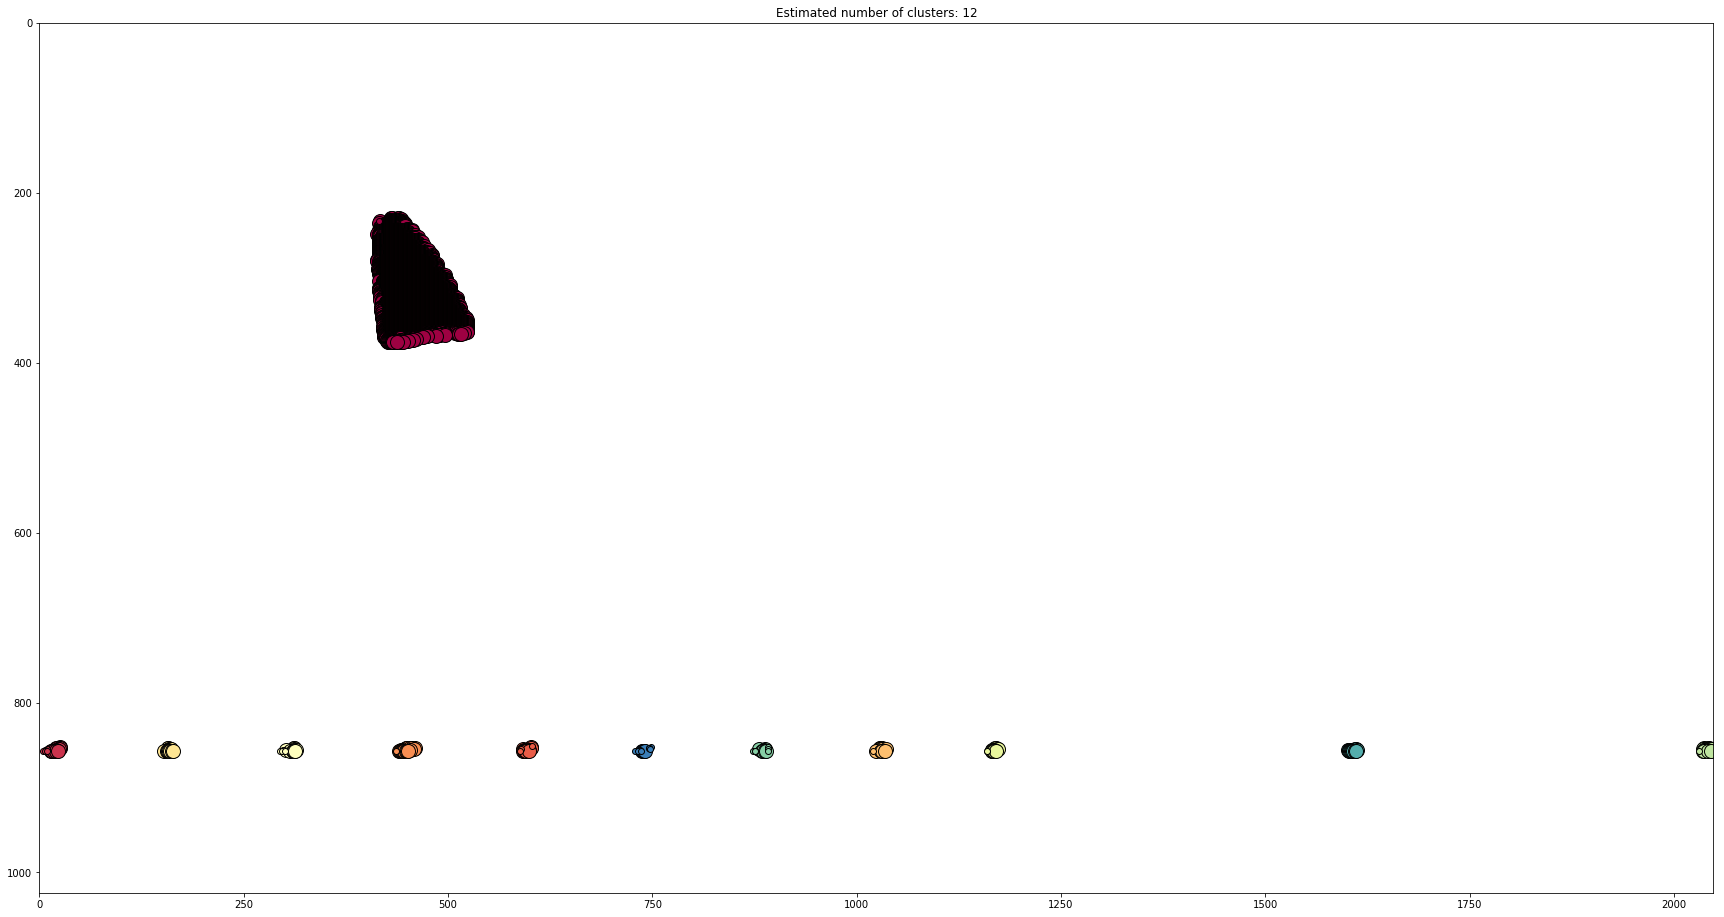

2017-06-30
Estimated number of clusters: 1
Writing labels to: data/4326/2017-06-30/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


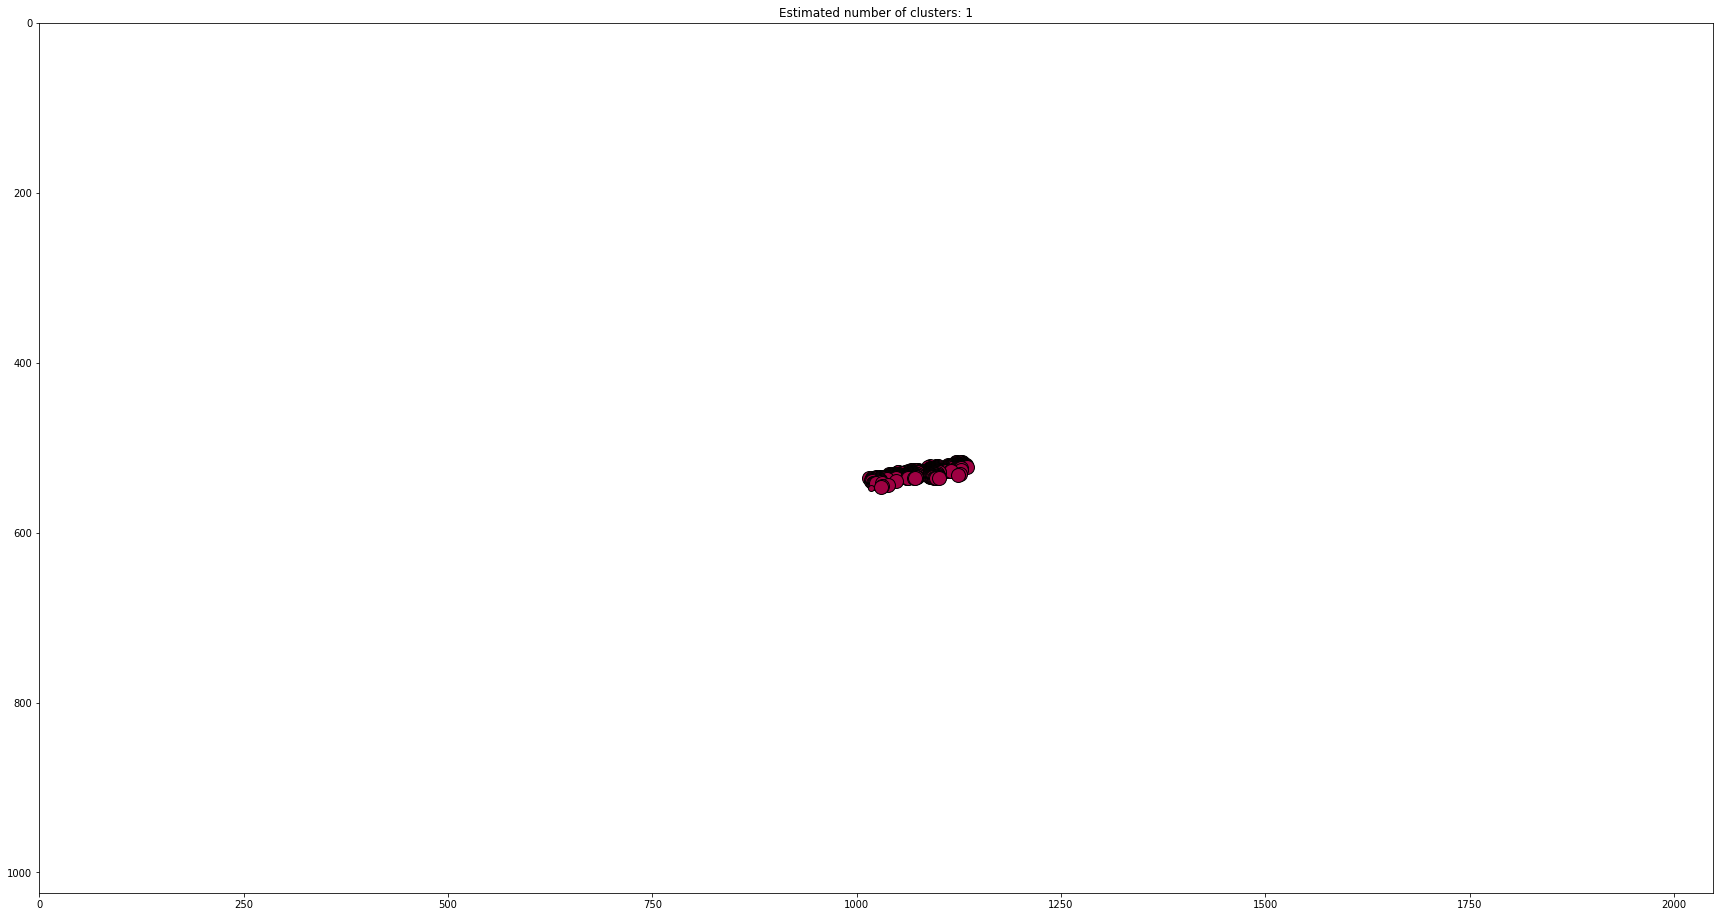

2017-07-03
Estimated number of clusters: 11
Writing labels to: data/4326/2017-07-03/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


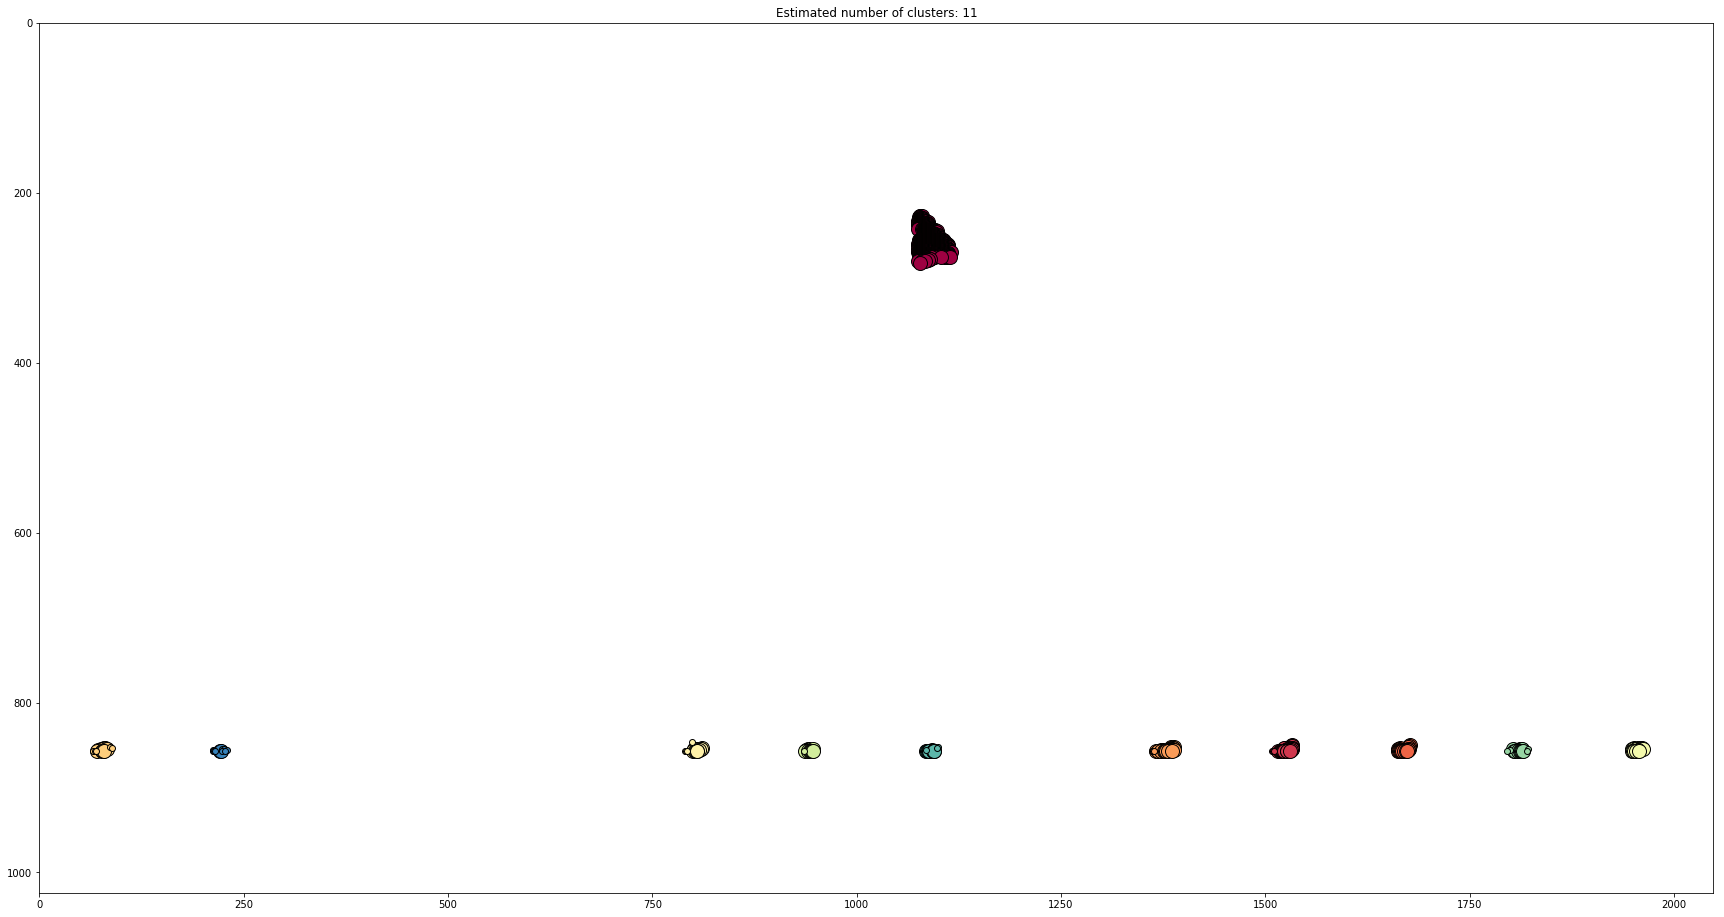

2017-07-26
Estimated number of clusters: 1
Writing labels to: data/4326/2017-07-26/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


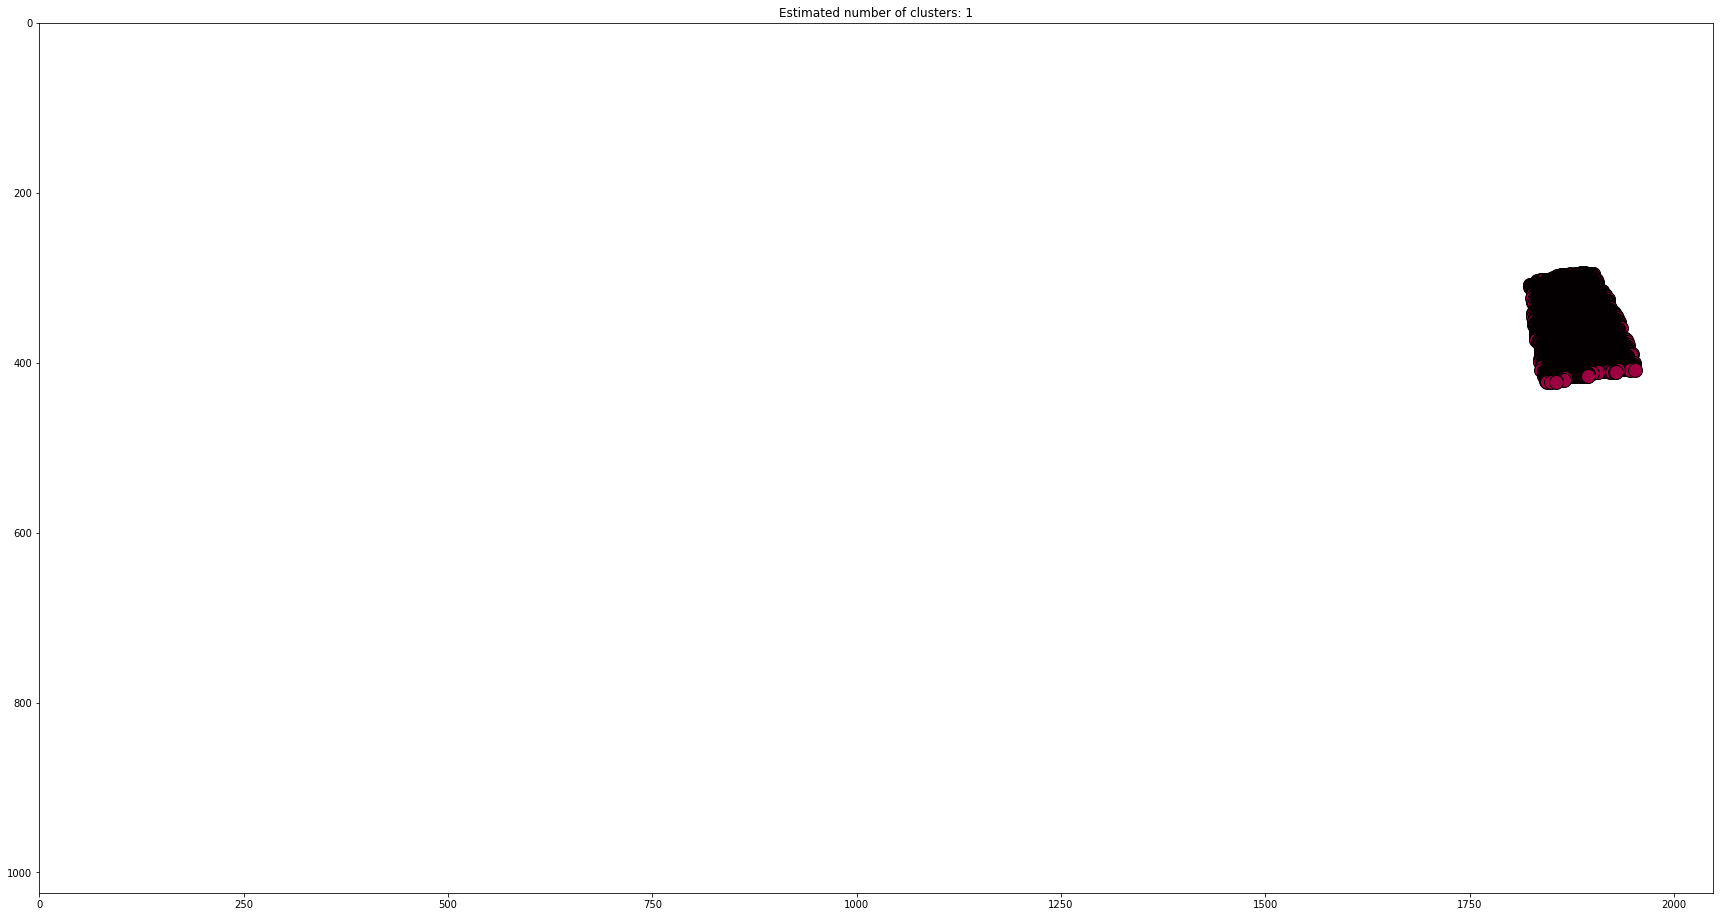

2017-08-21
Estimated number of clusters: 5
Writing labels to: data/4326/2017-08-21/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


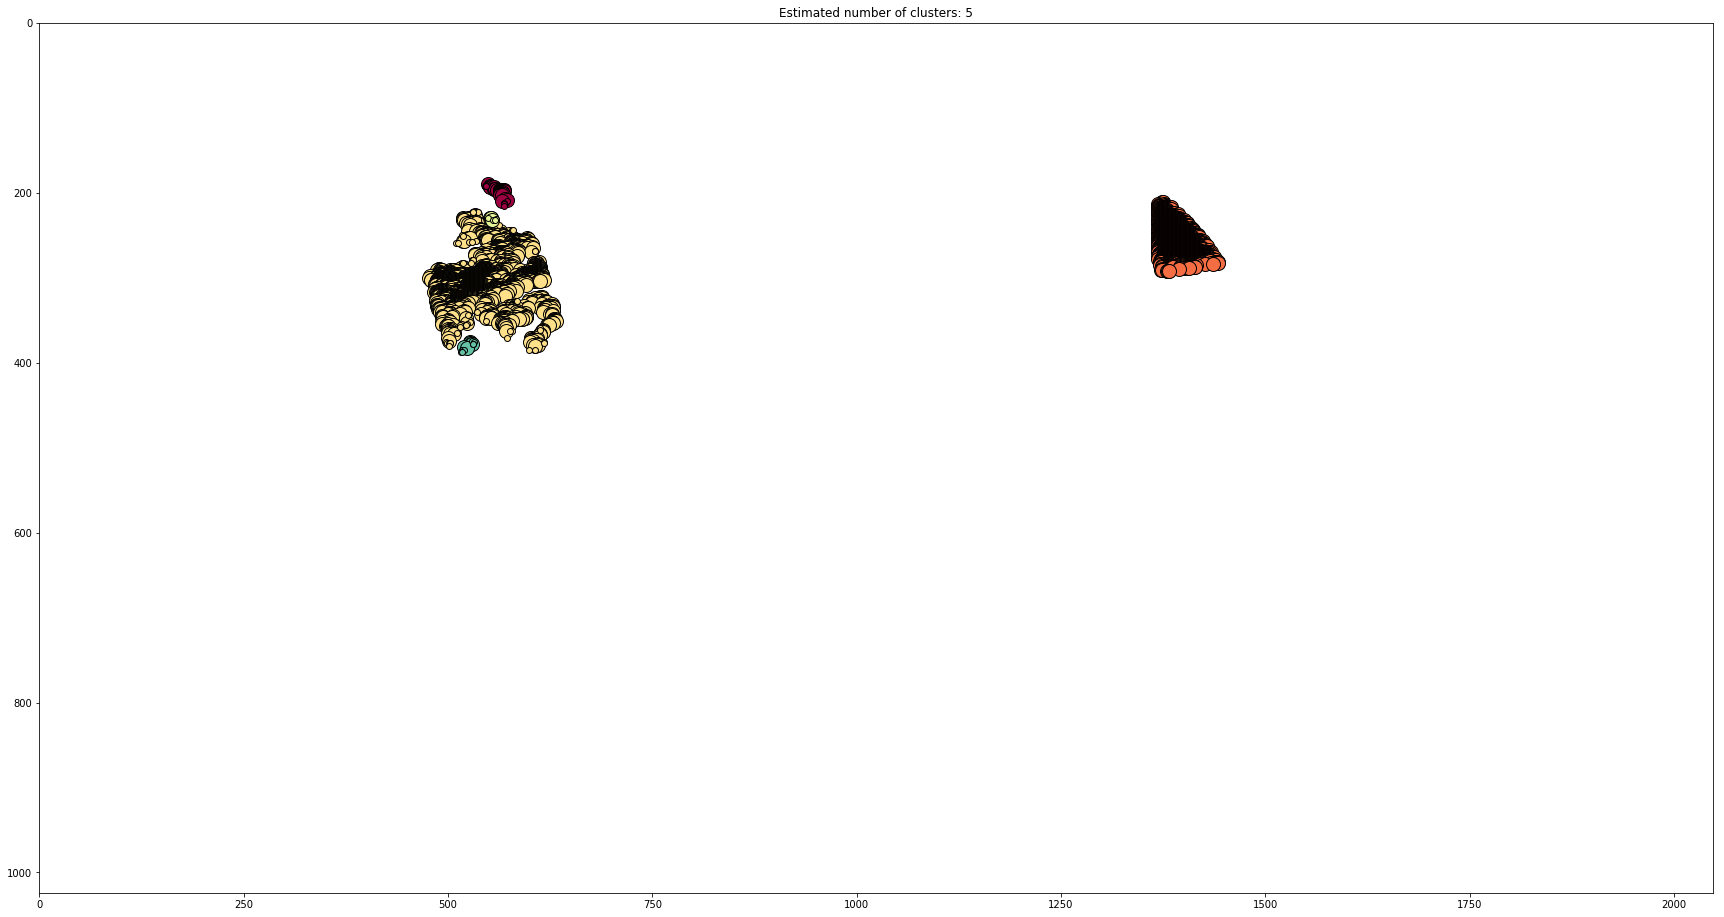

2017-08-27
Estimated number of clusters: 3
Writing labels to: data/4326/2017-08-27/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


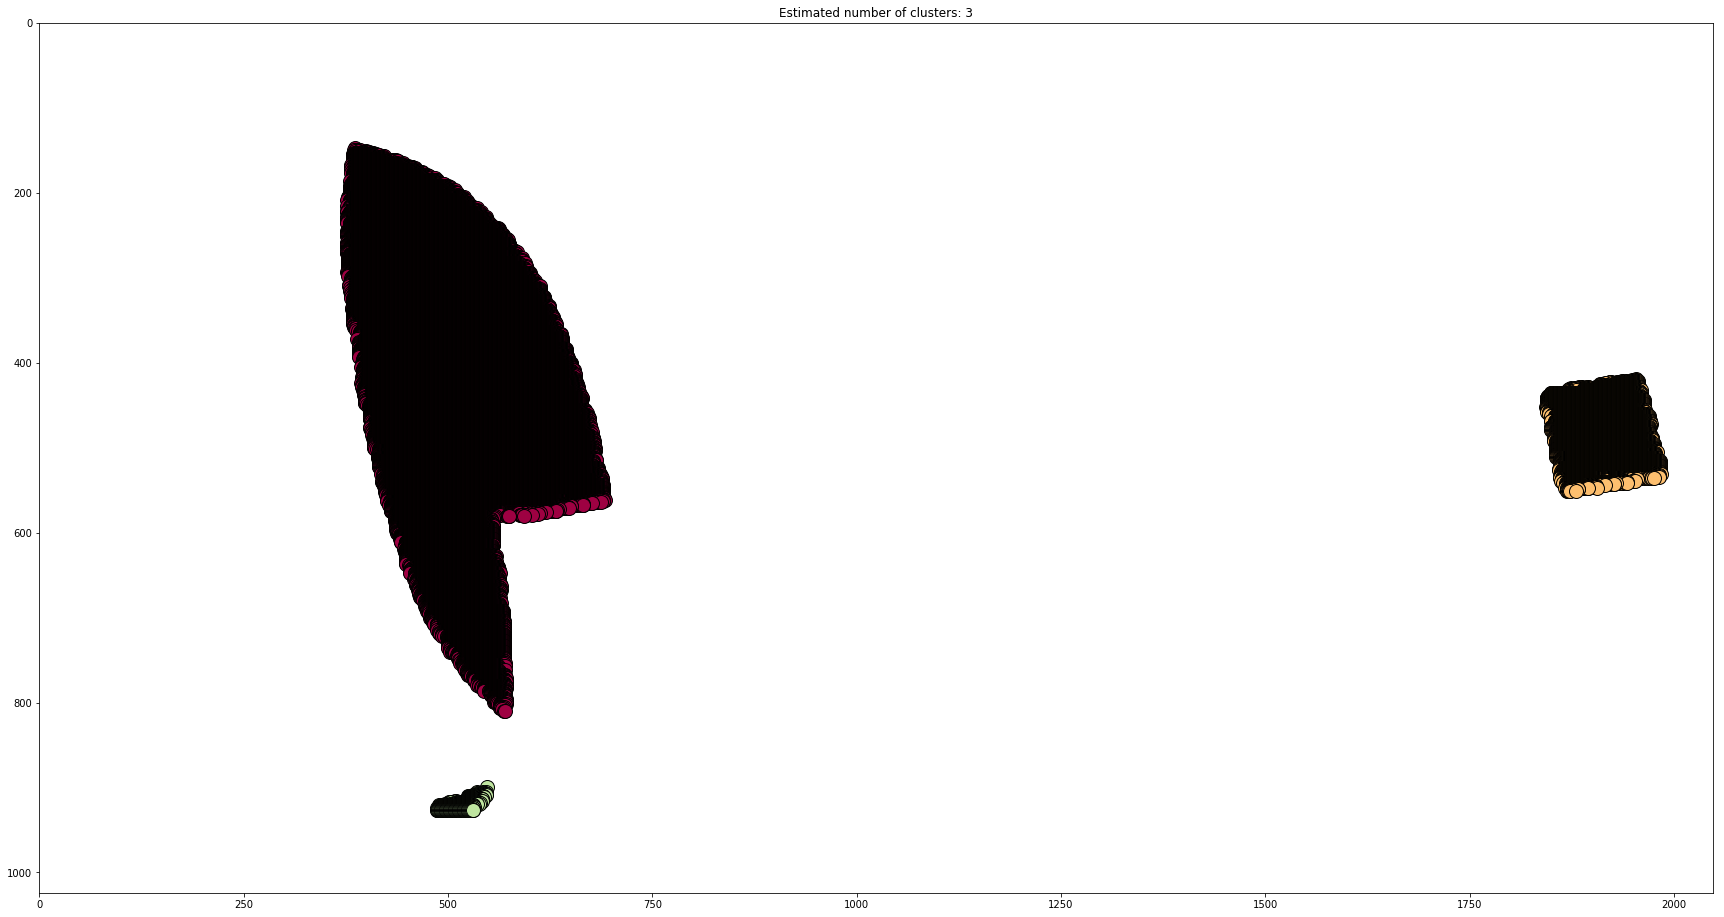

2017-09-02
Estimated number of clusters: 2
Writing labels to: data/4326/2017-09-02/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


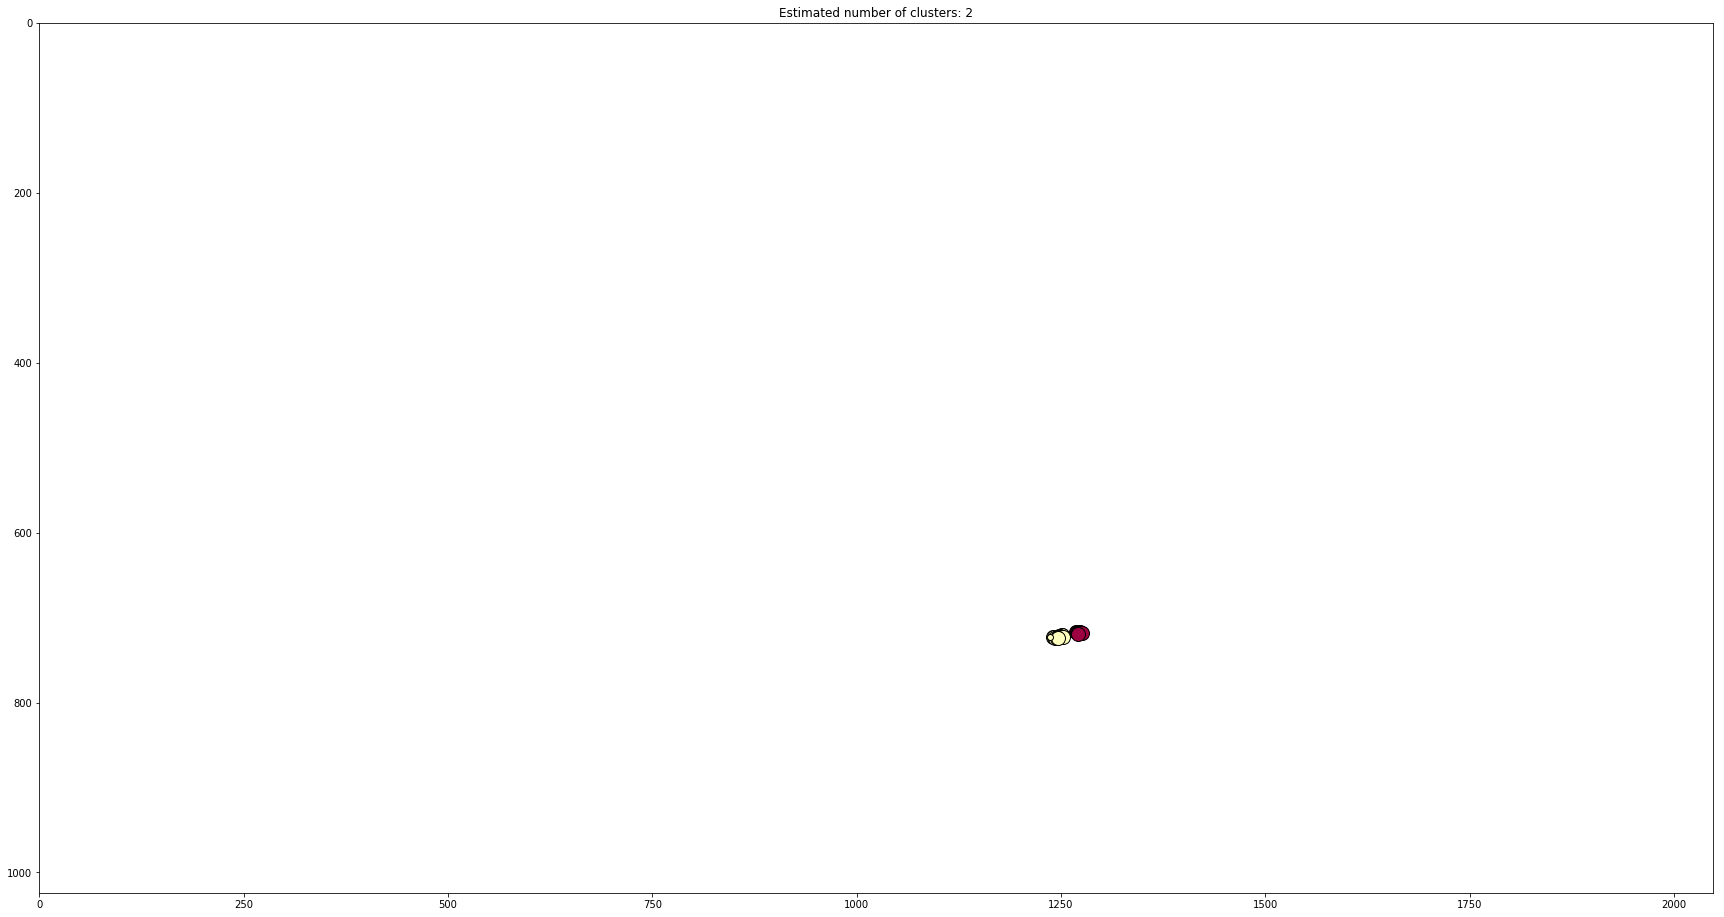

2017-09-29
Writing labels to: data/4326/2017-09-29/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


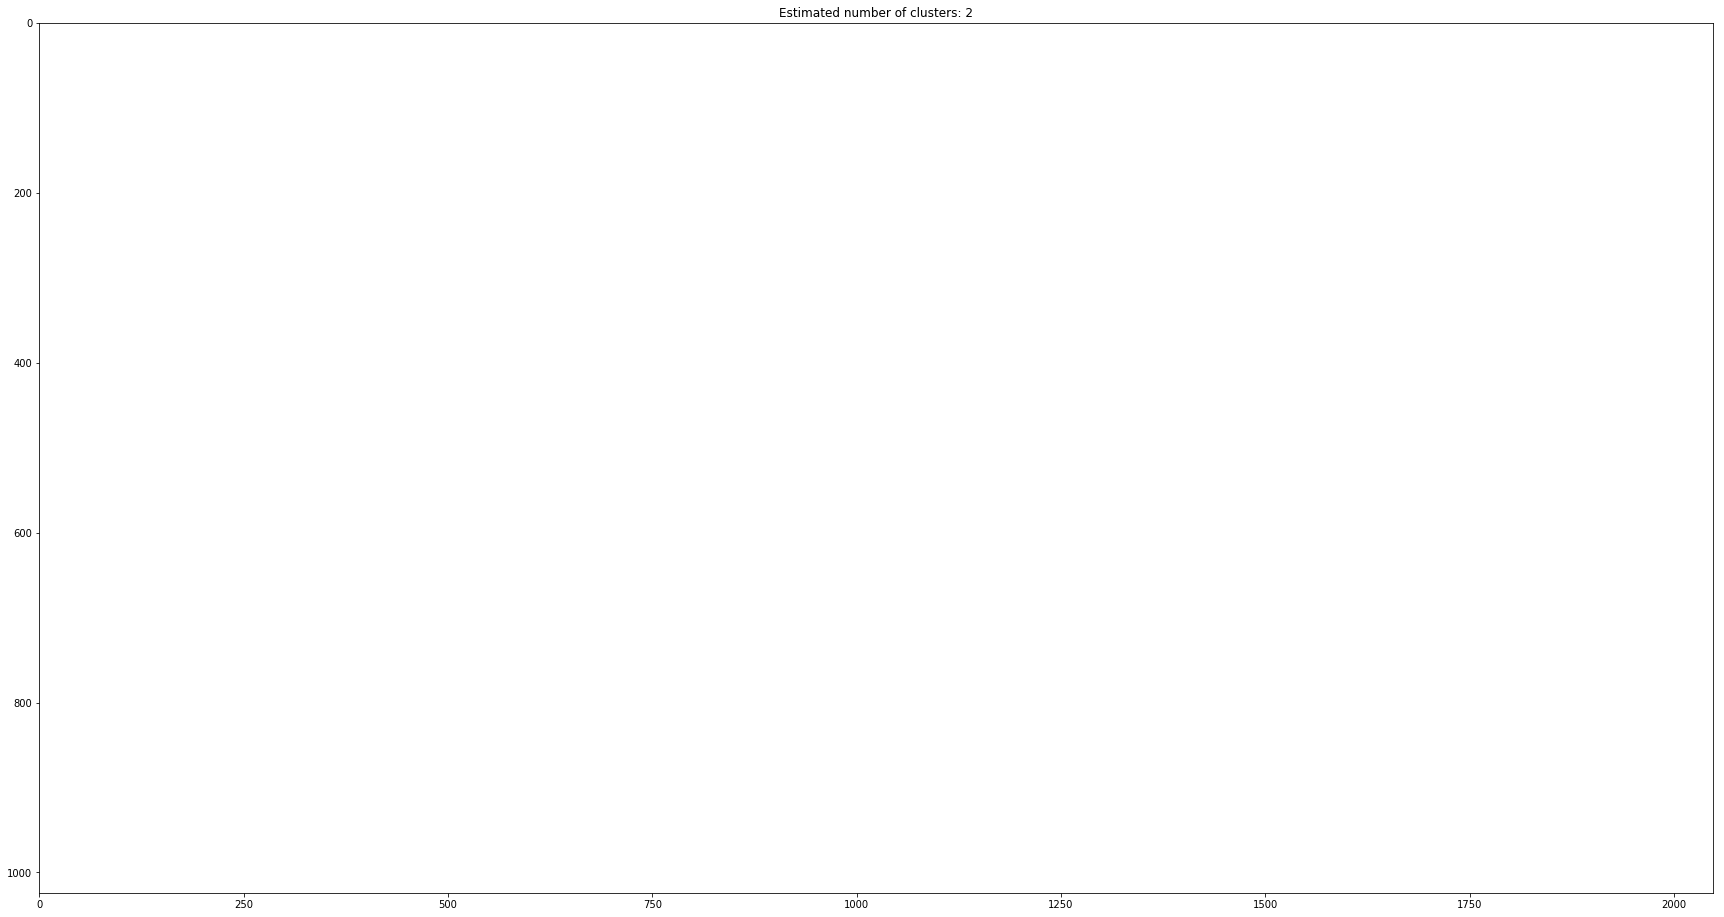

2017-10-31
Estimated number of clusters: 1
Writing labels to: data/4326/2017-10-31/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


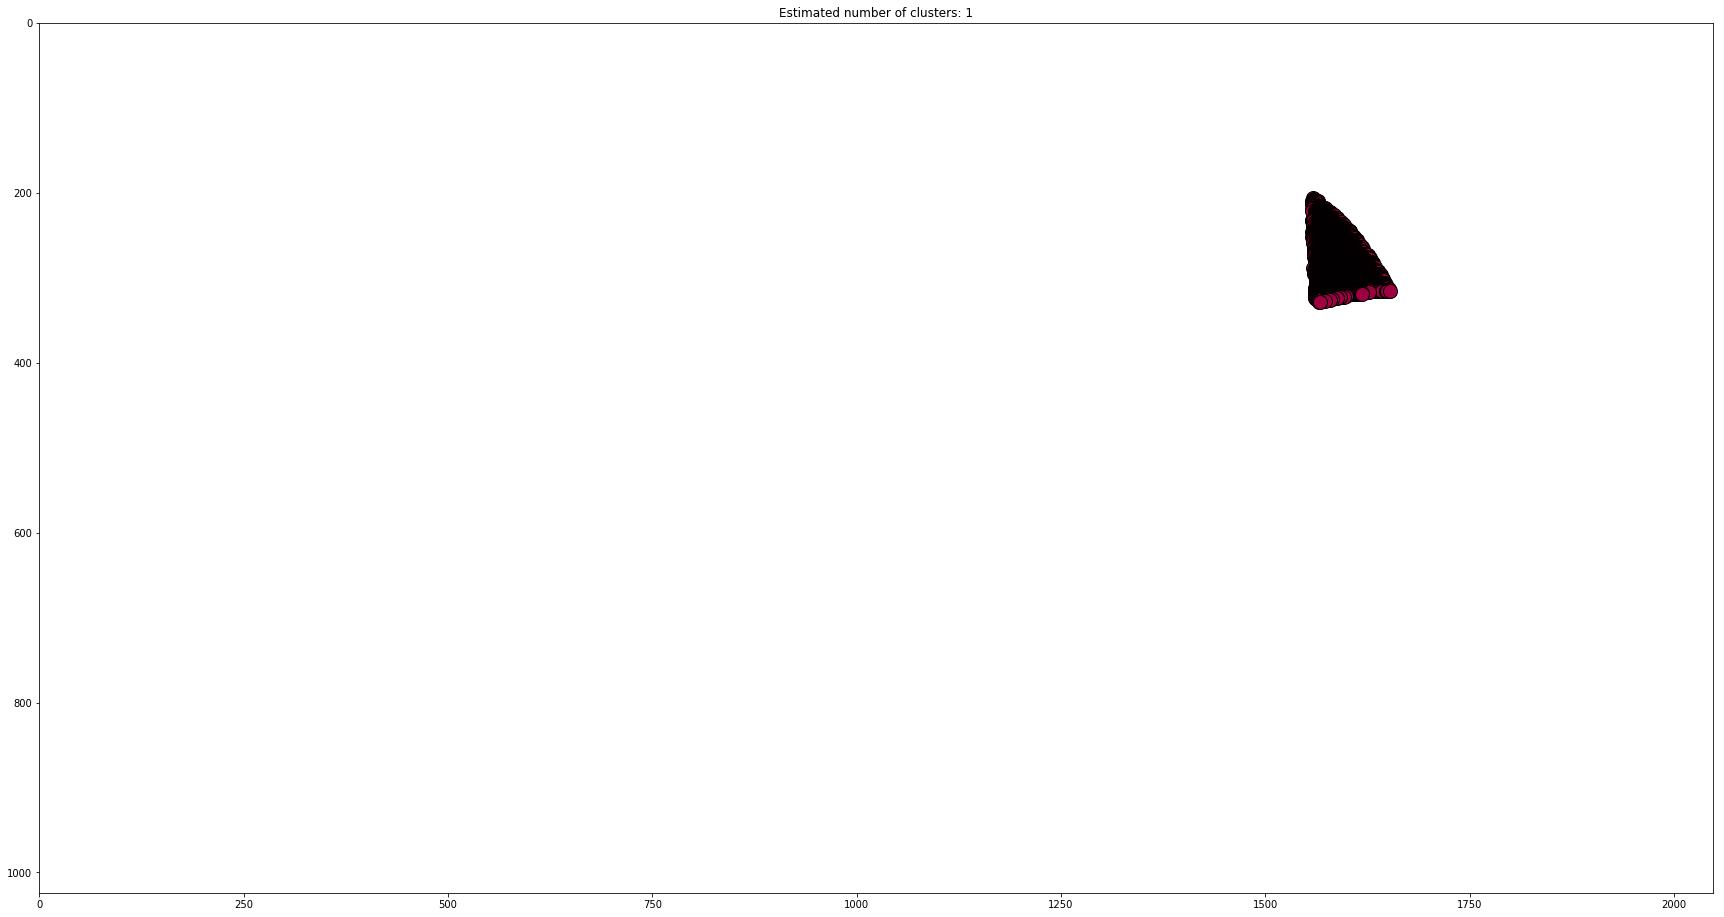

2017-11-18
Estimated number of clusters: 3
Writing labels to: data/4326/2017-11-18/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


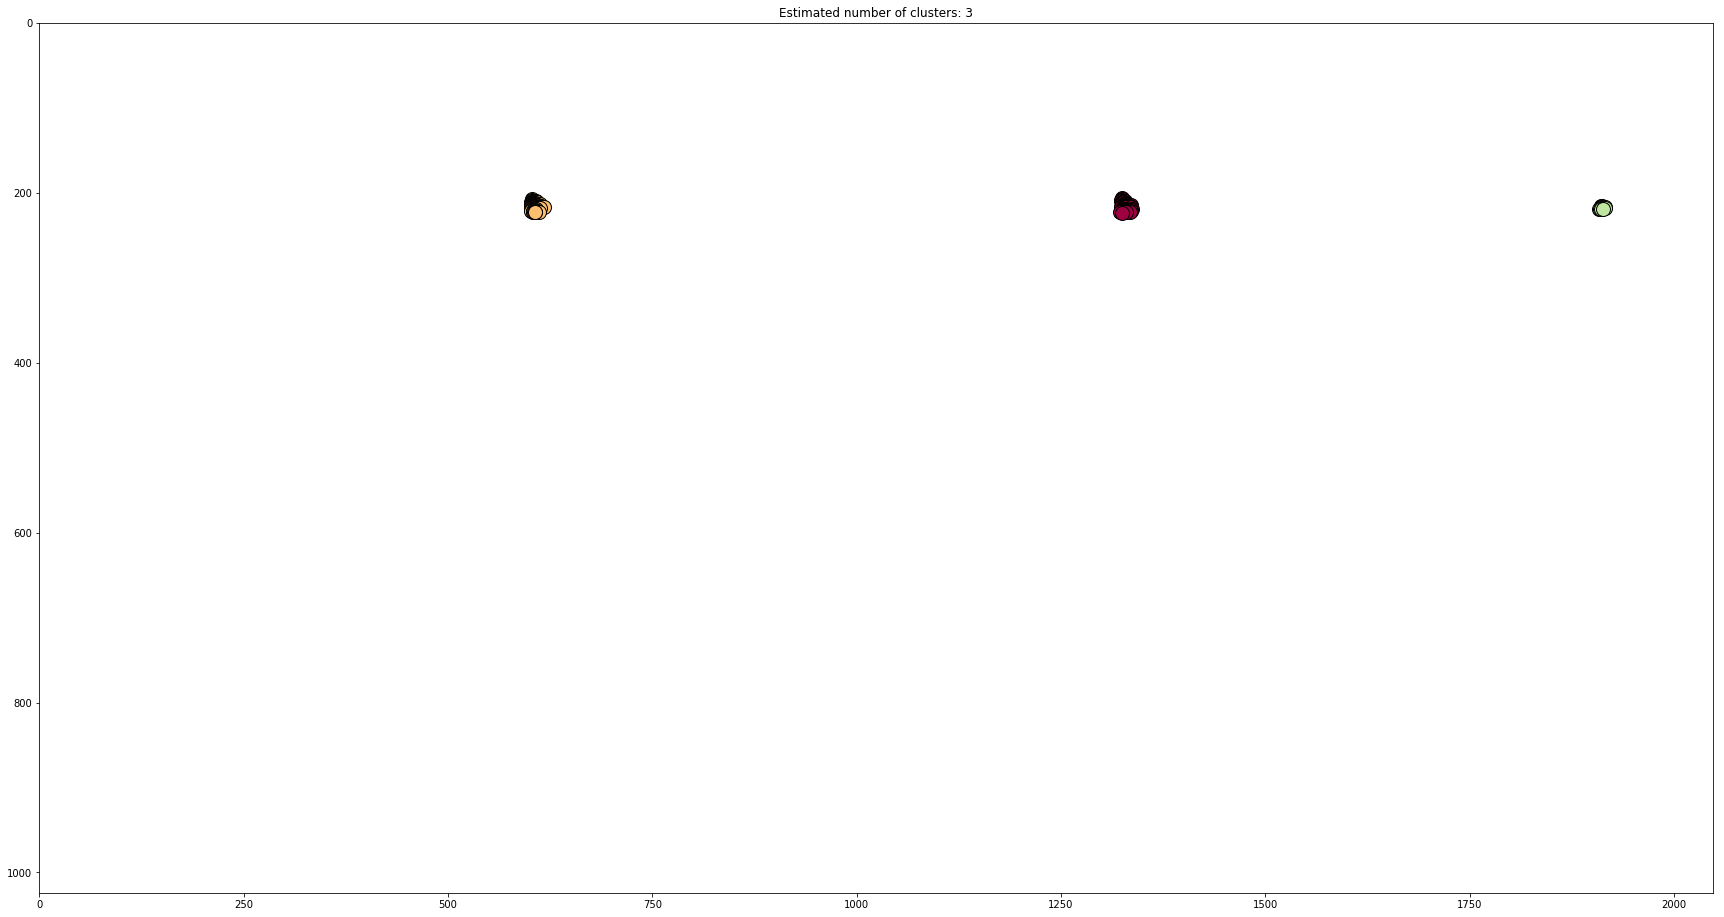

2017-11-25
Estimated number of clusters: 2
Writing labels to: data/4326/2017-11-25/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


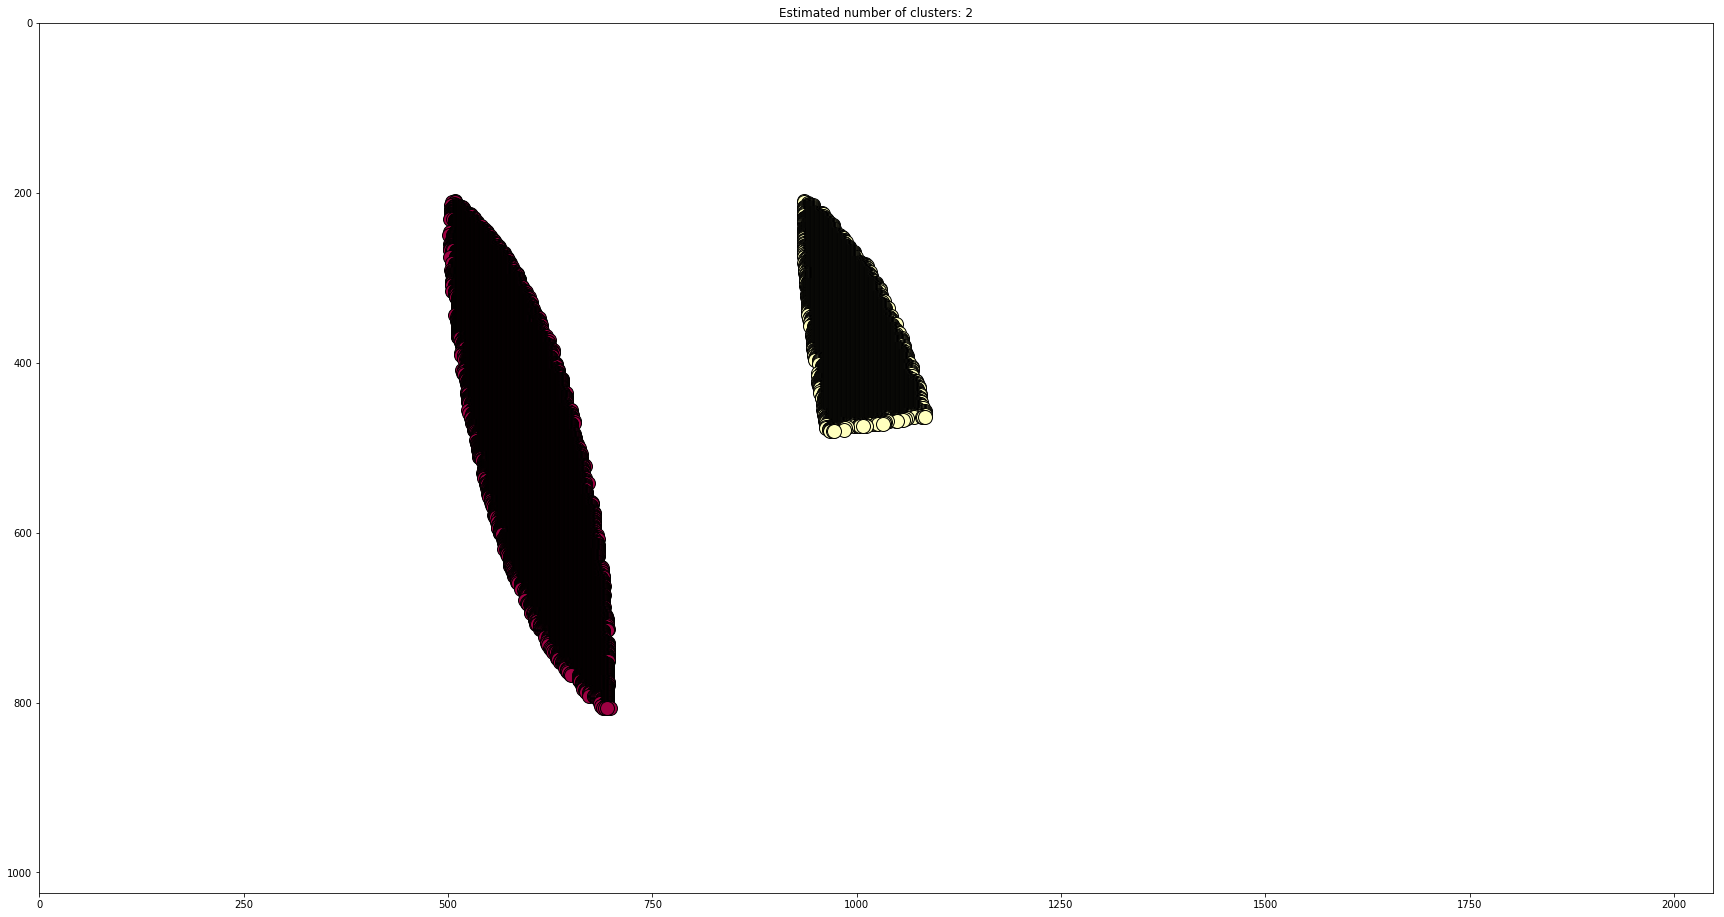

2017-11-29
Estimated number of clusters: 1
Writing labels to: data/4326/2017-11-29/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


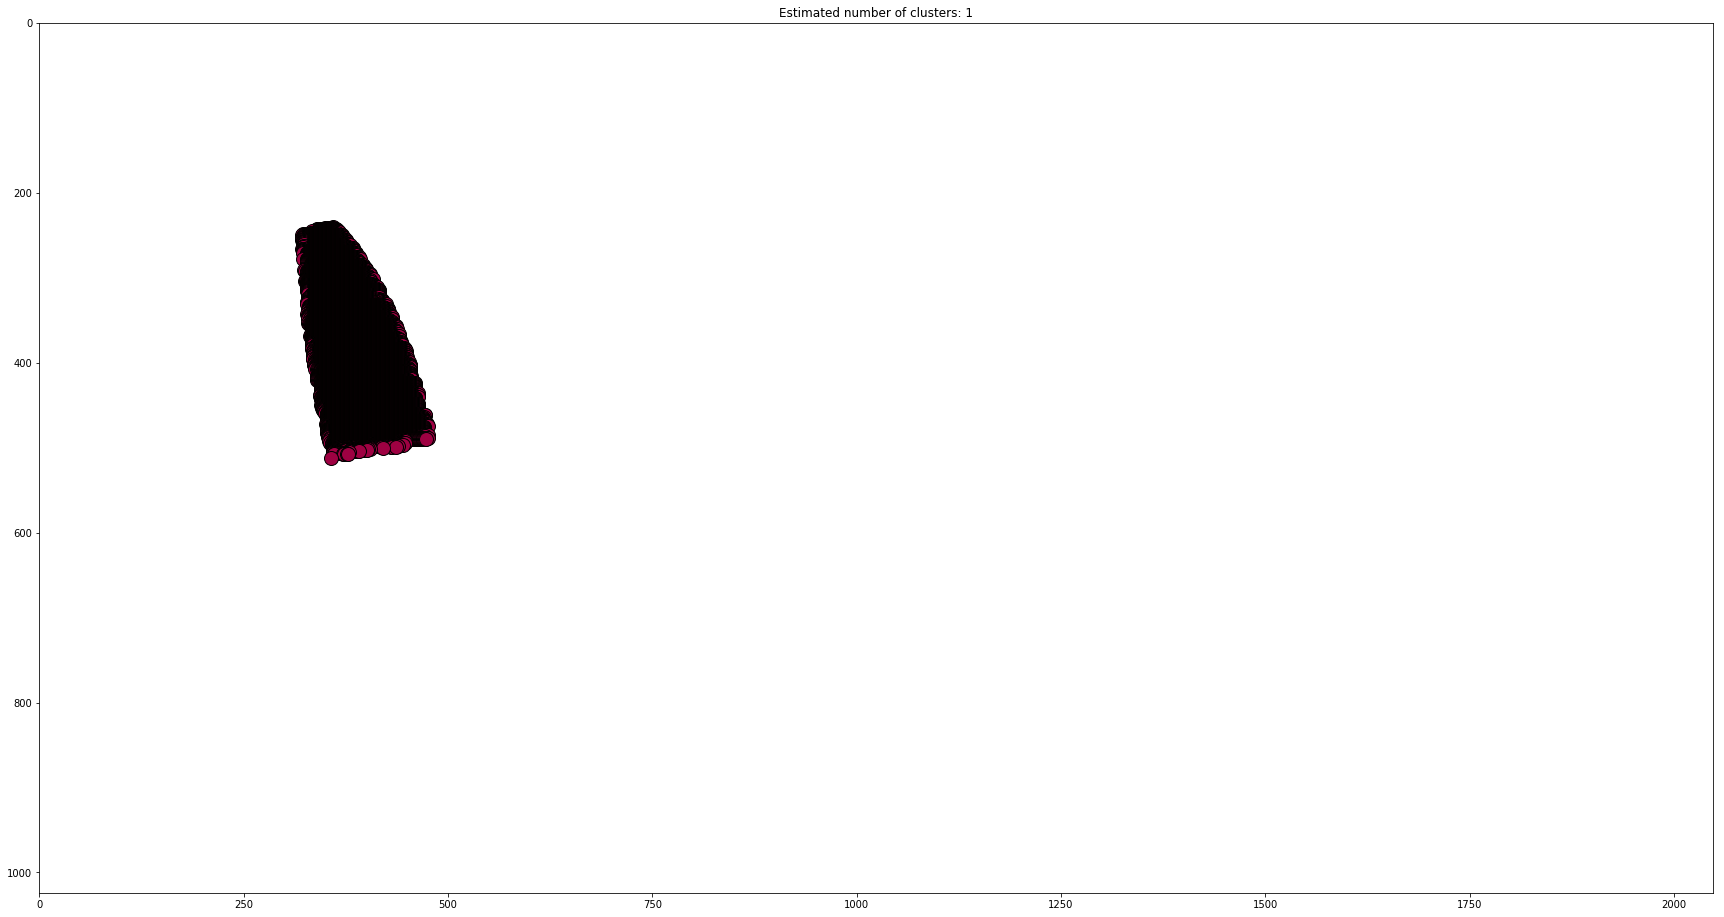

2017-11-30
Estimated number of clusters: 1
Writing labels to: data/4326/2017-11-30/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


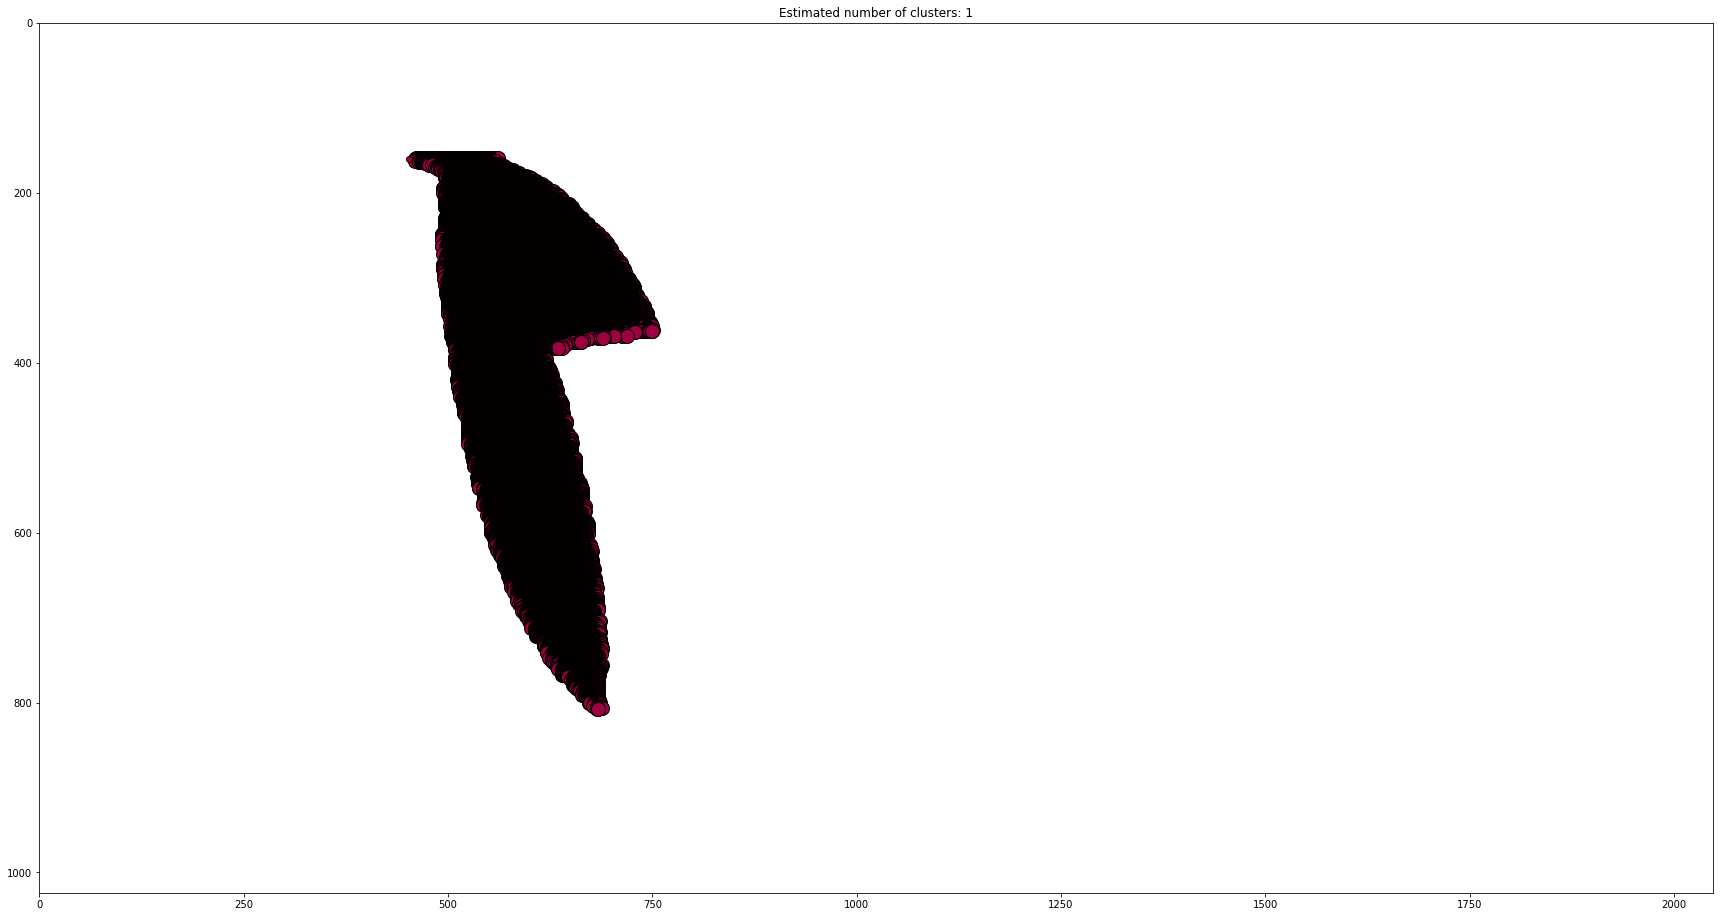

2017-12-29
Estimated number of clusters: 1
Writing labels to: data/4326/2017-12-29/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


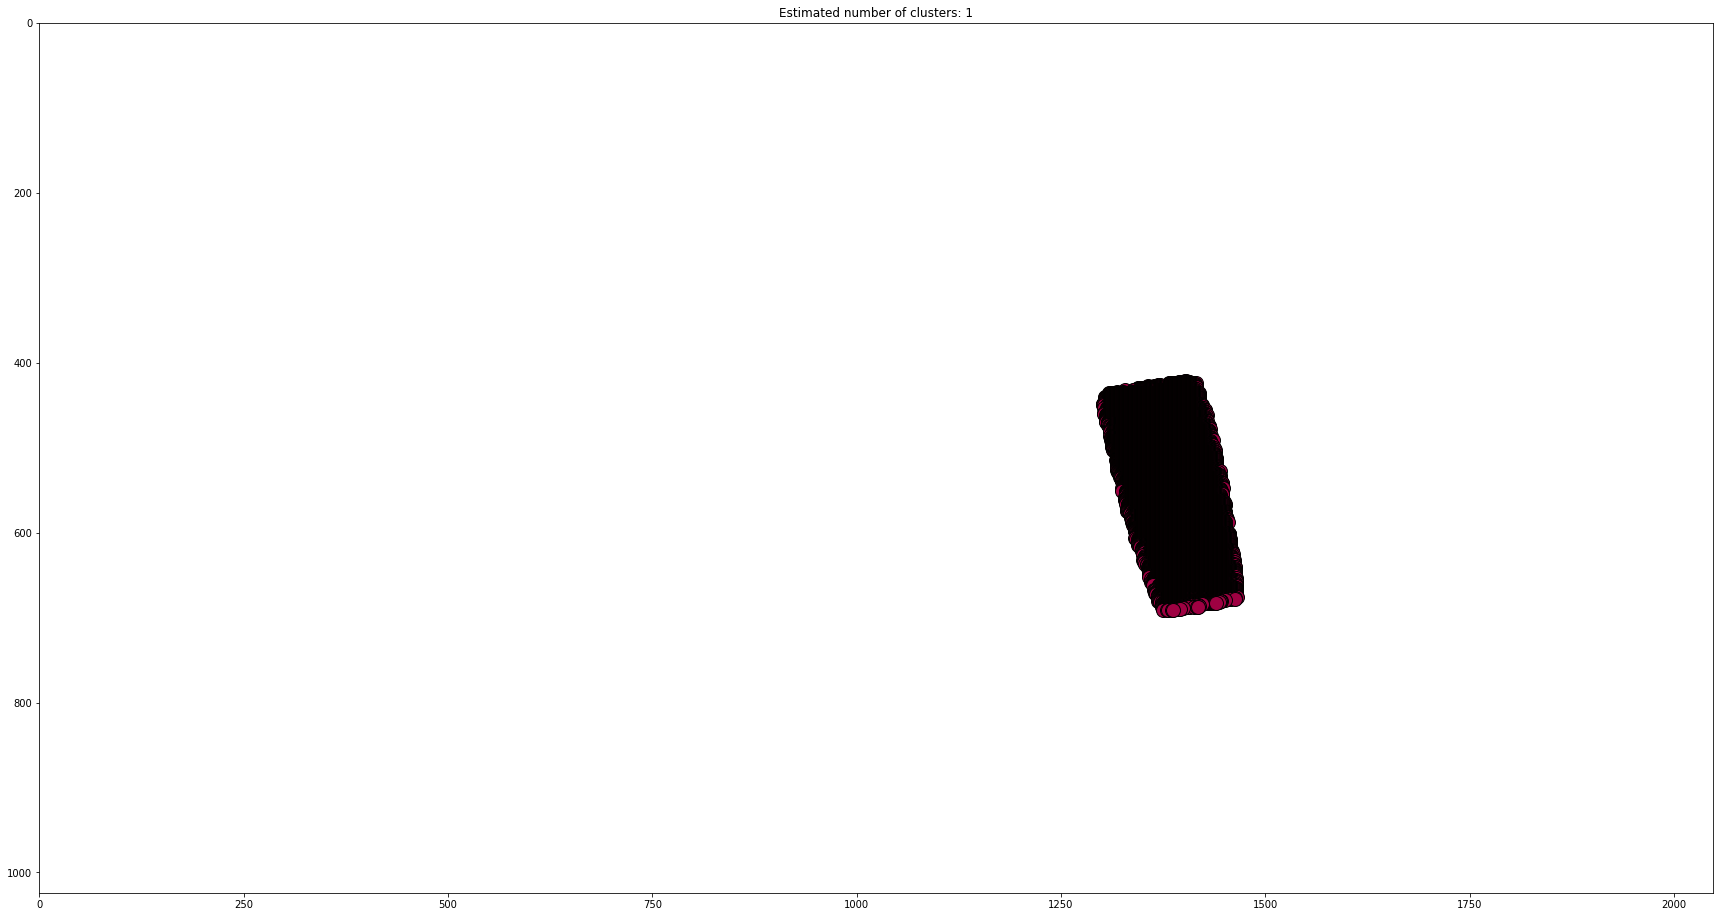

2017-12-30
Estimated number of clusters: 1
Writing labels to: data/4326/2017-12-30/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


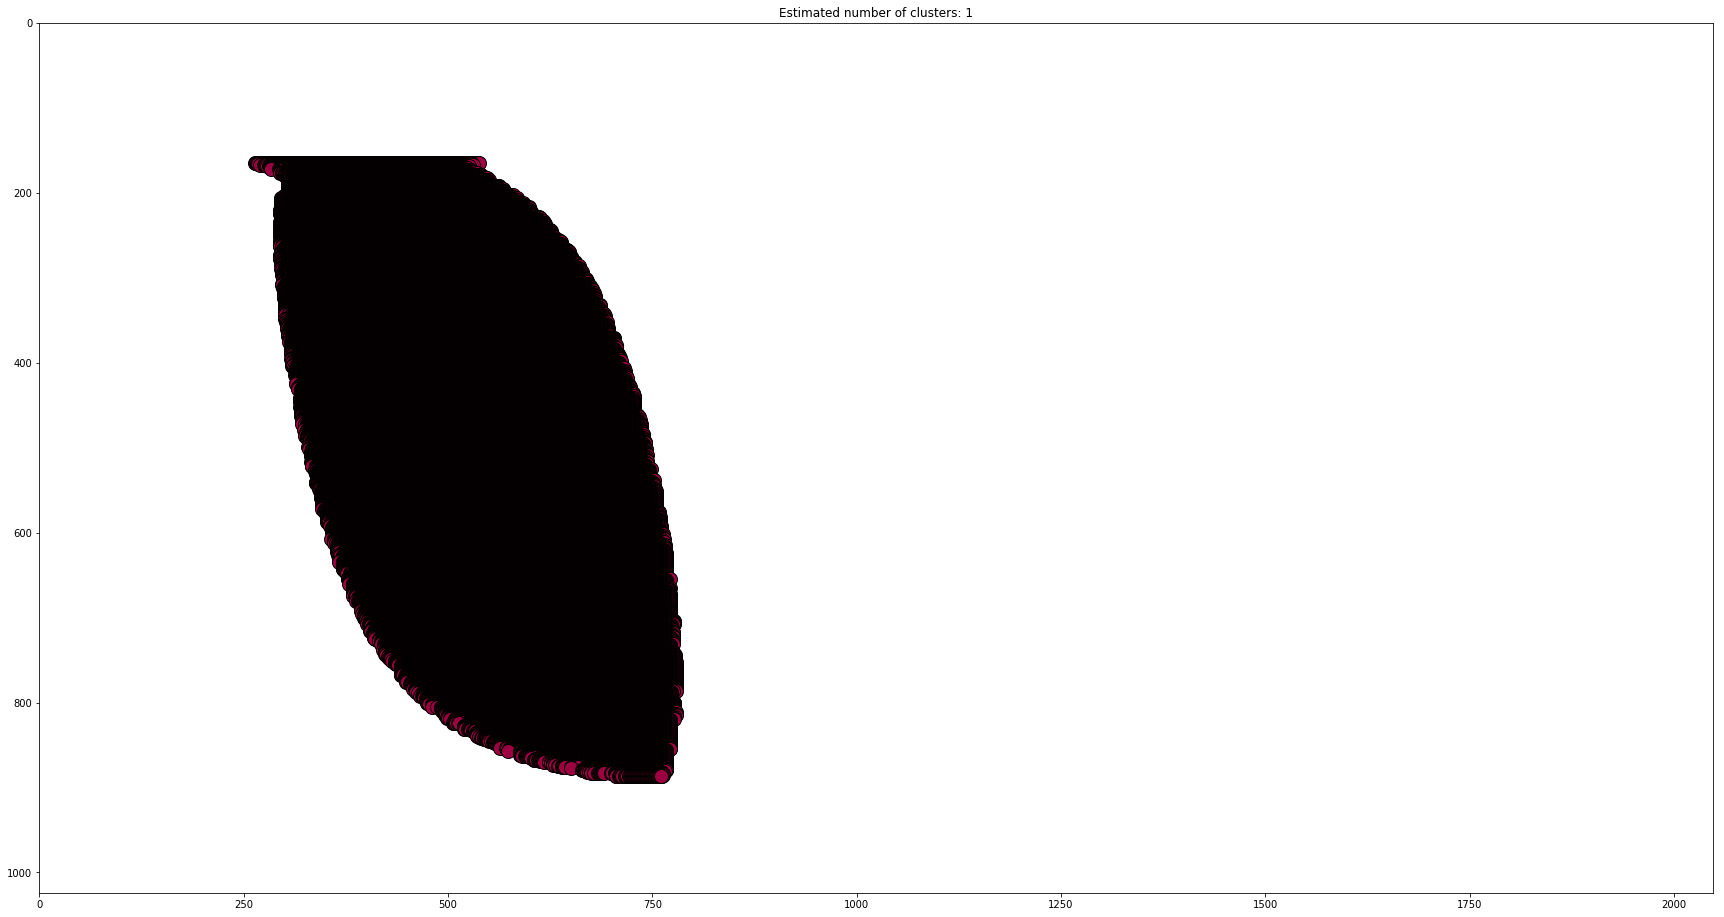

2017-12-31
Estimated number of clusters: 3
Writing labels to: data/4326/2017-12-31/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


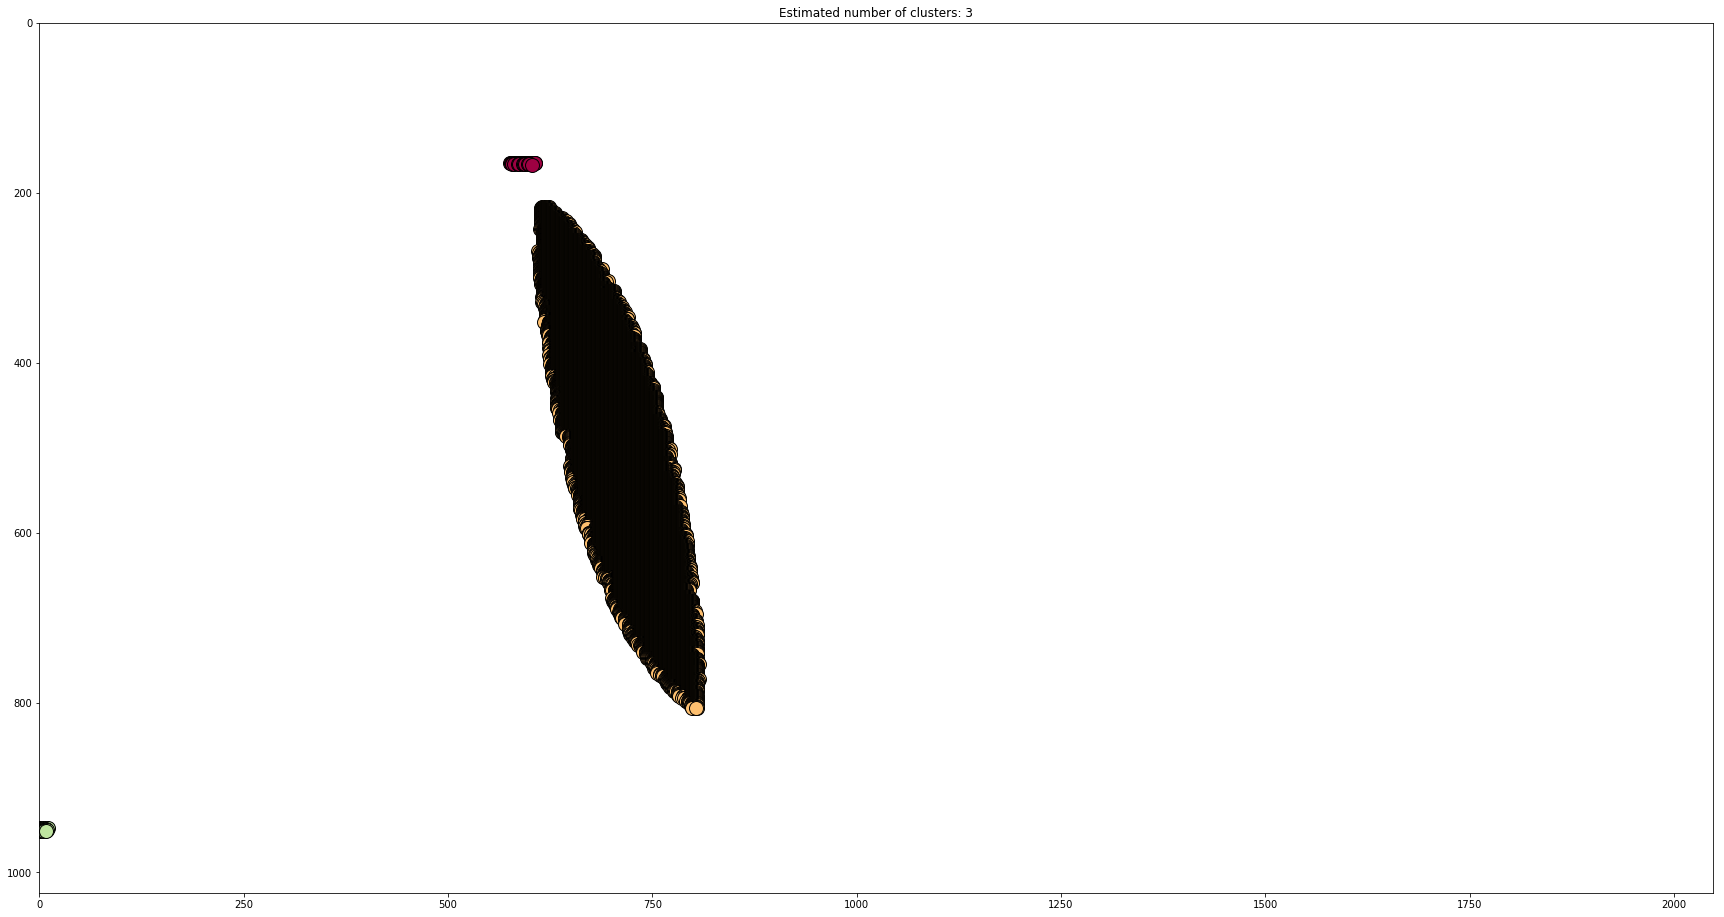

2018-01-02
Estimated number of clusters: 1
Writing labels to: data/4326/2018-01-02/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


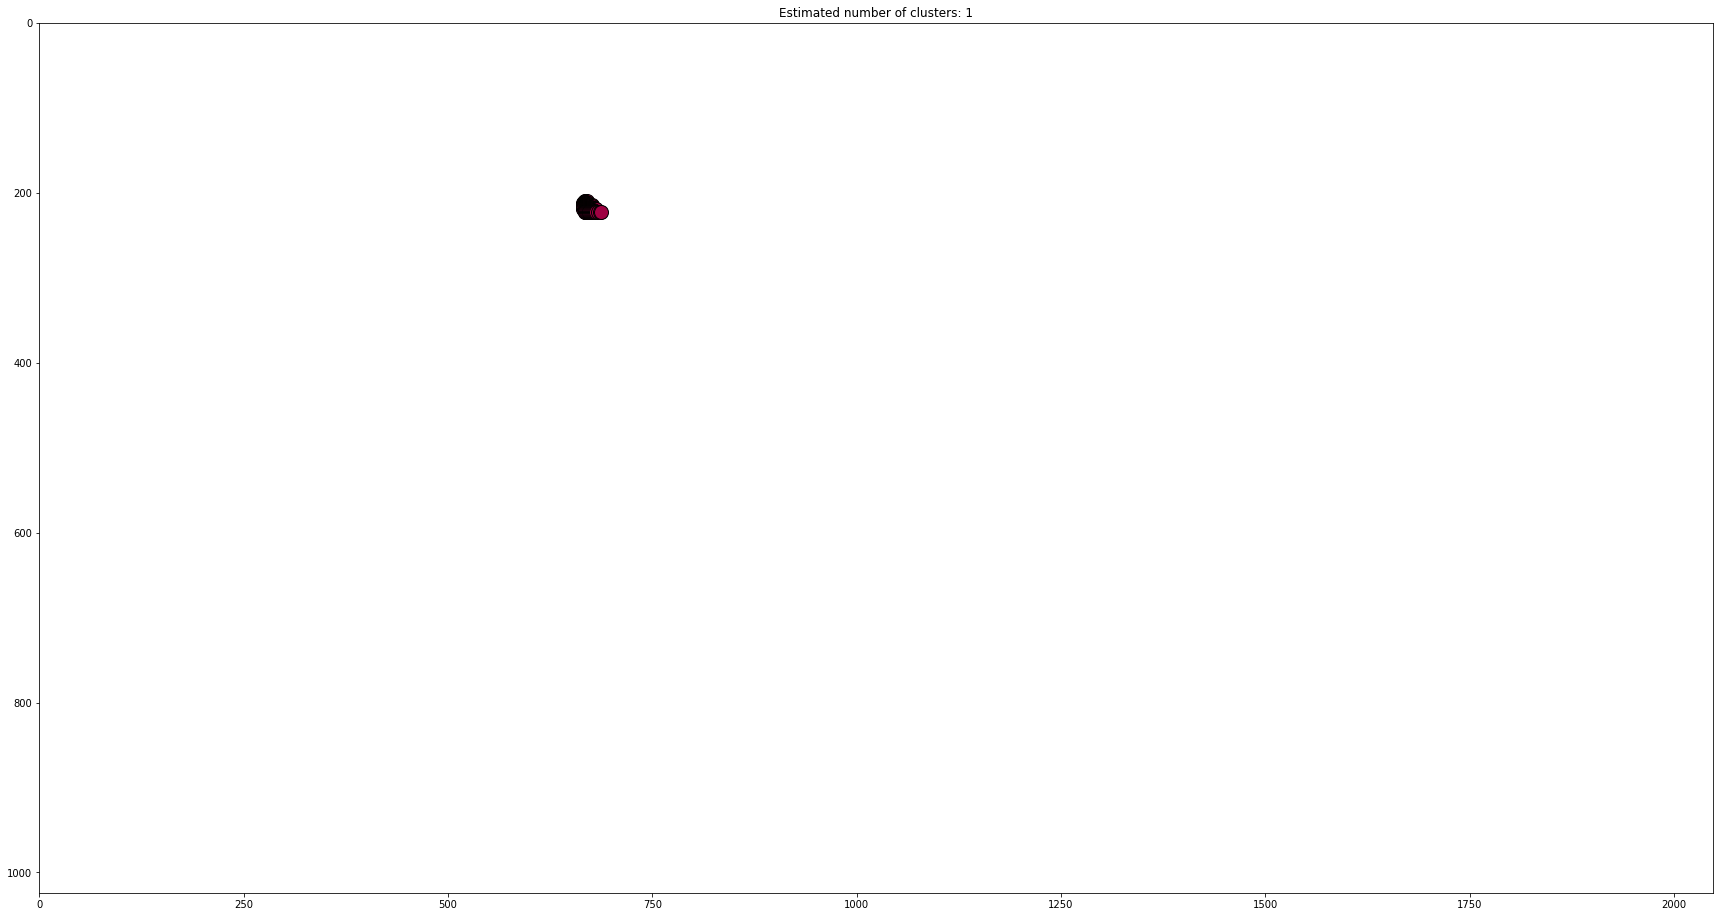

2018-01-05
Estimated number of clusters: 2
Writing labels to: data/4326/2018-01-05/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


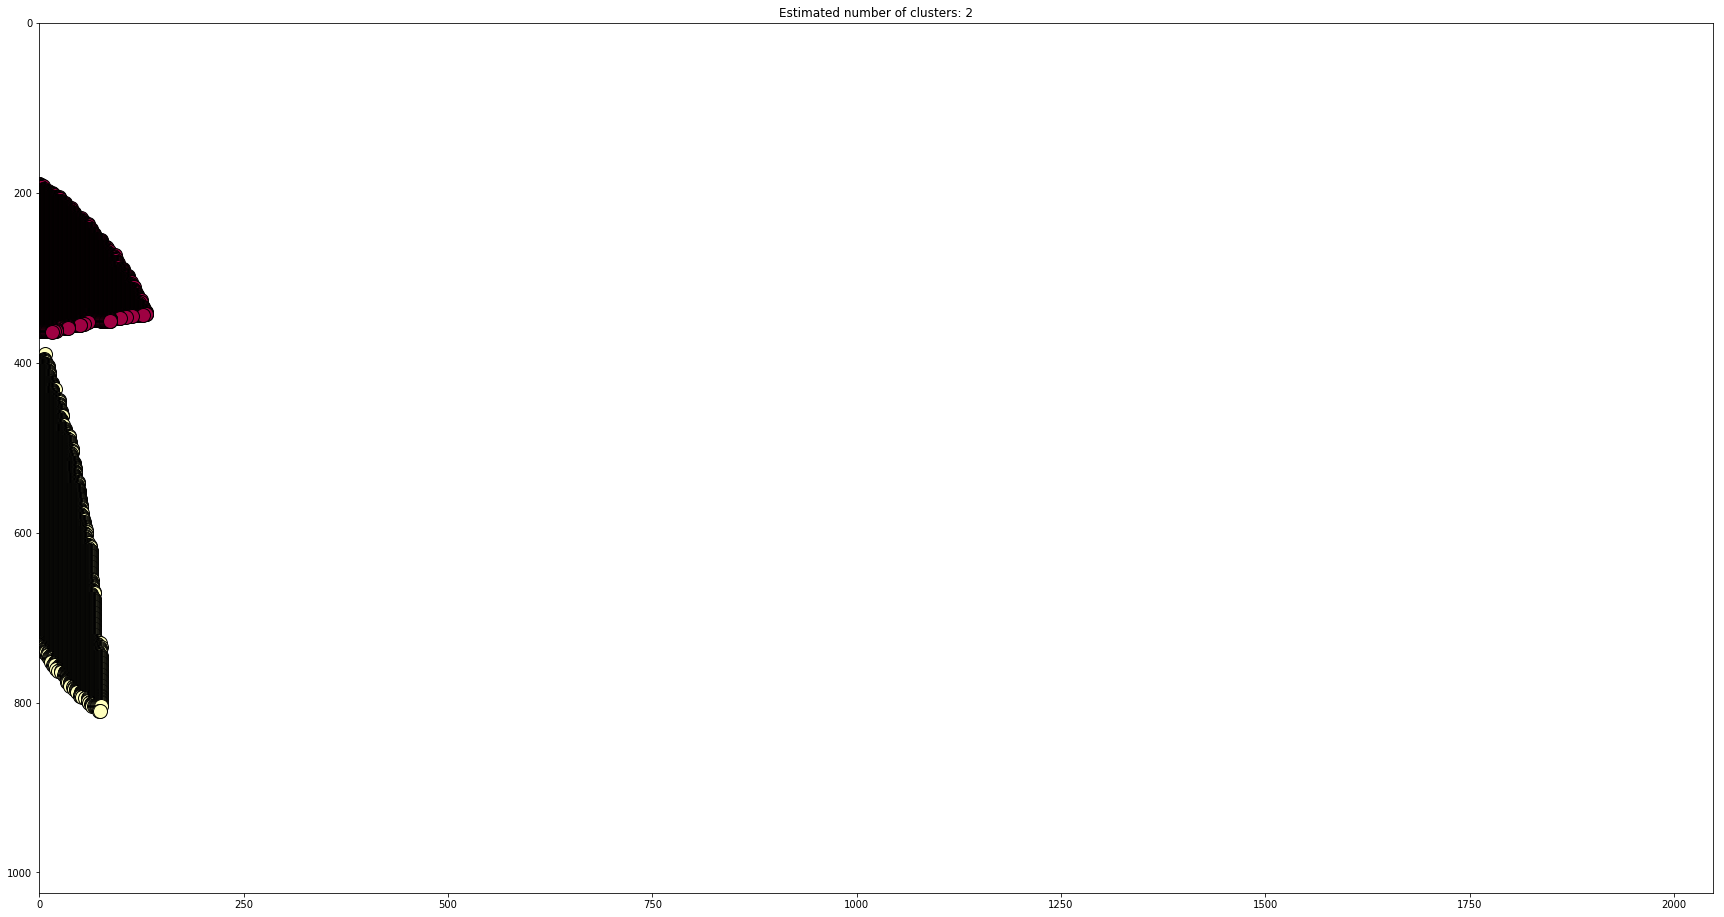

2018-01-27
Estimated number of clusters: 1
Writing labels to: data/4326/2018-01-27/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


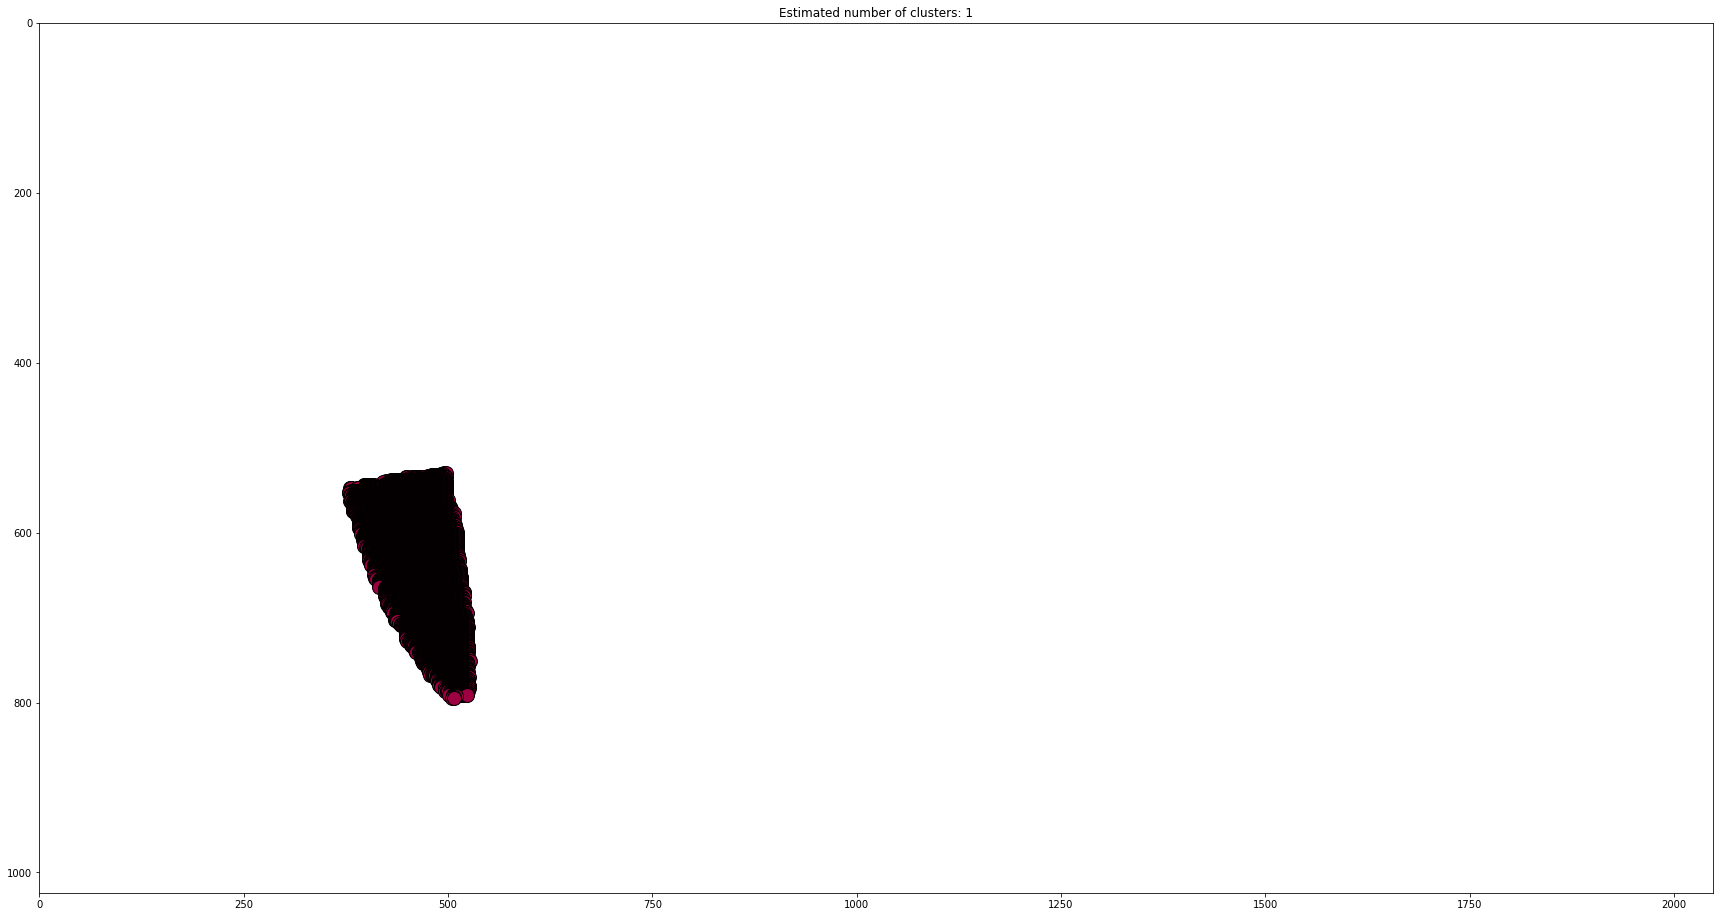

2018-01-29
Estimated number of clusters: 1
Writing labels to: data/4326/2018-01-29/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


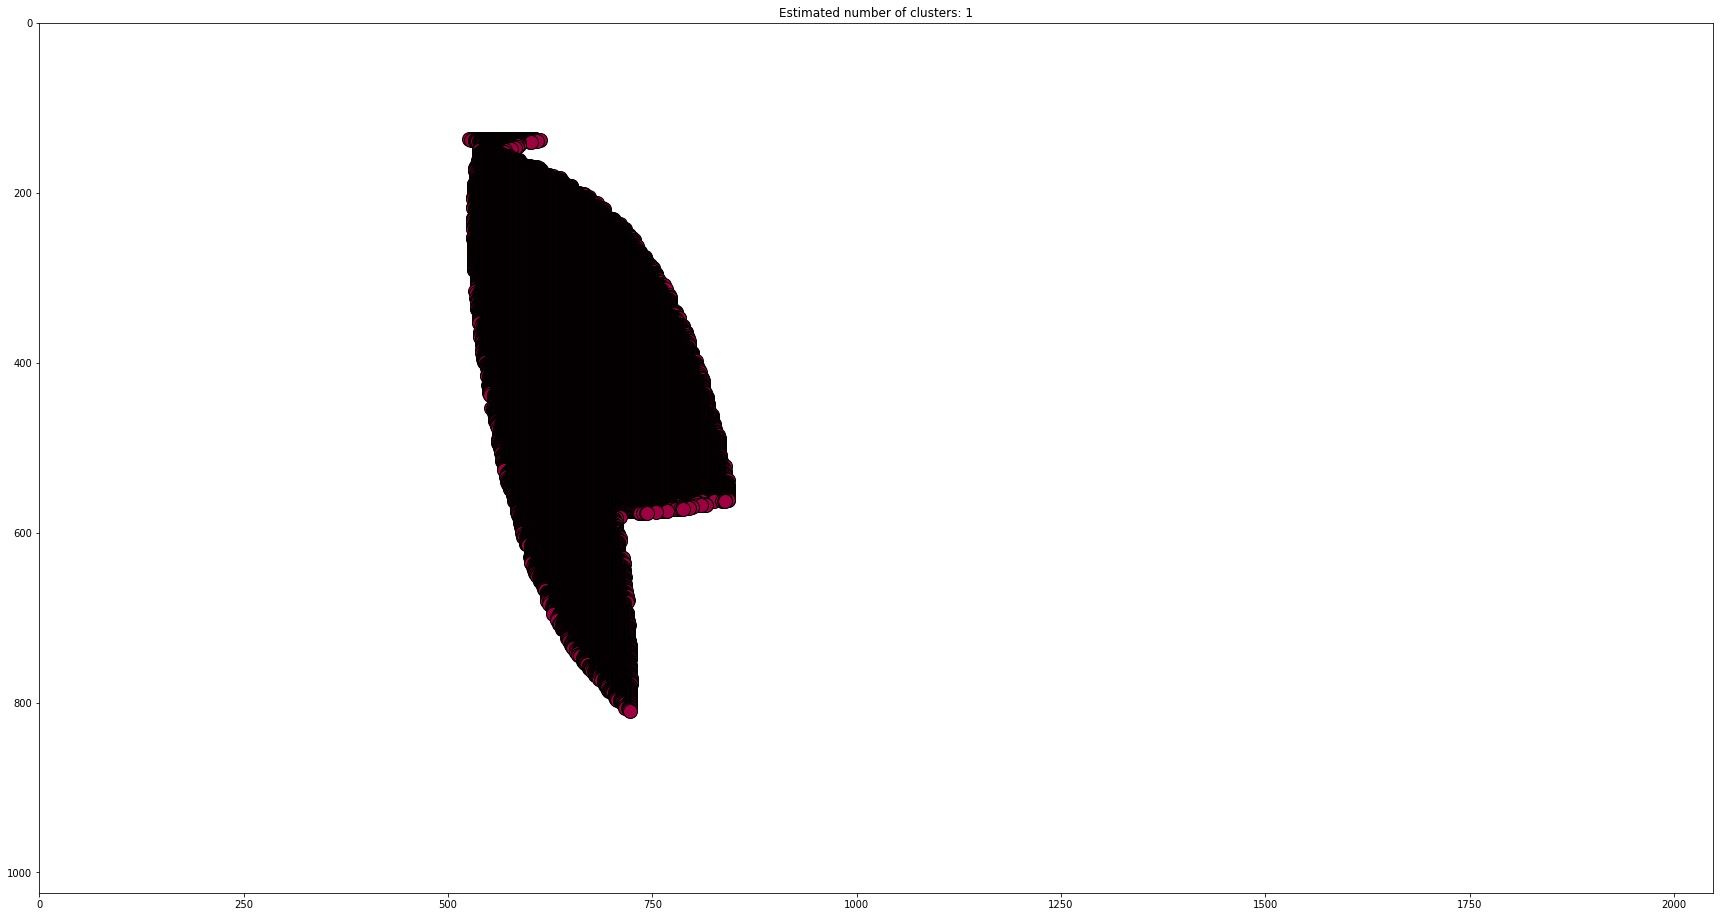

2018-02-13
Estimated number of clusters: 2
Writing labels to: data/4326/2018-02-13/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


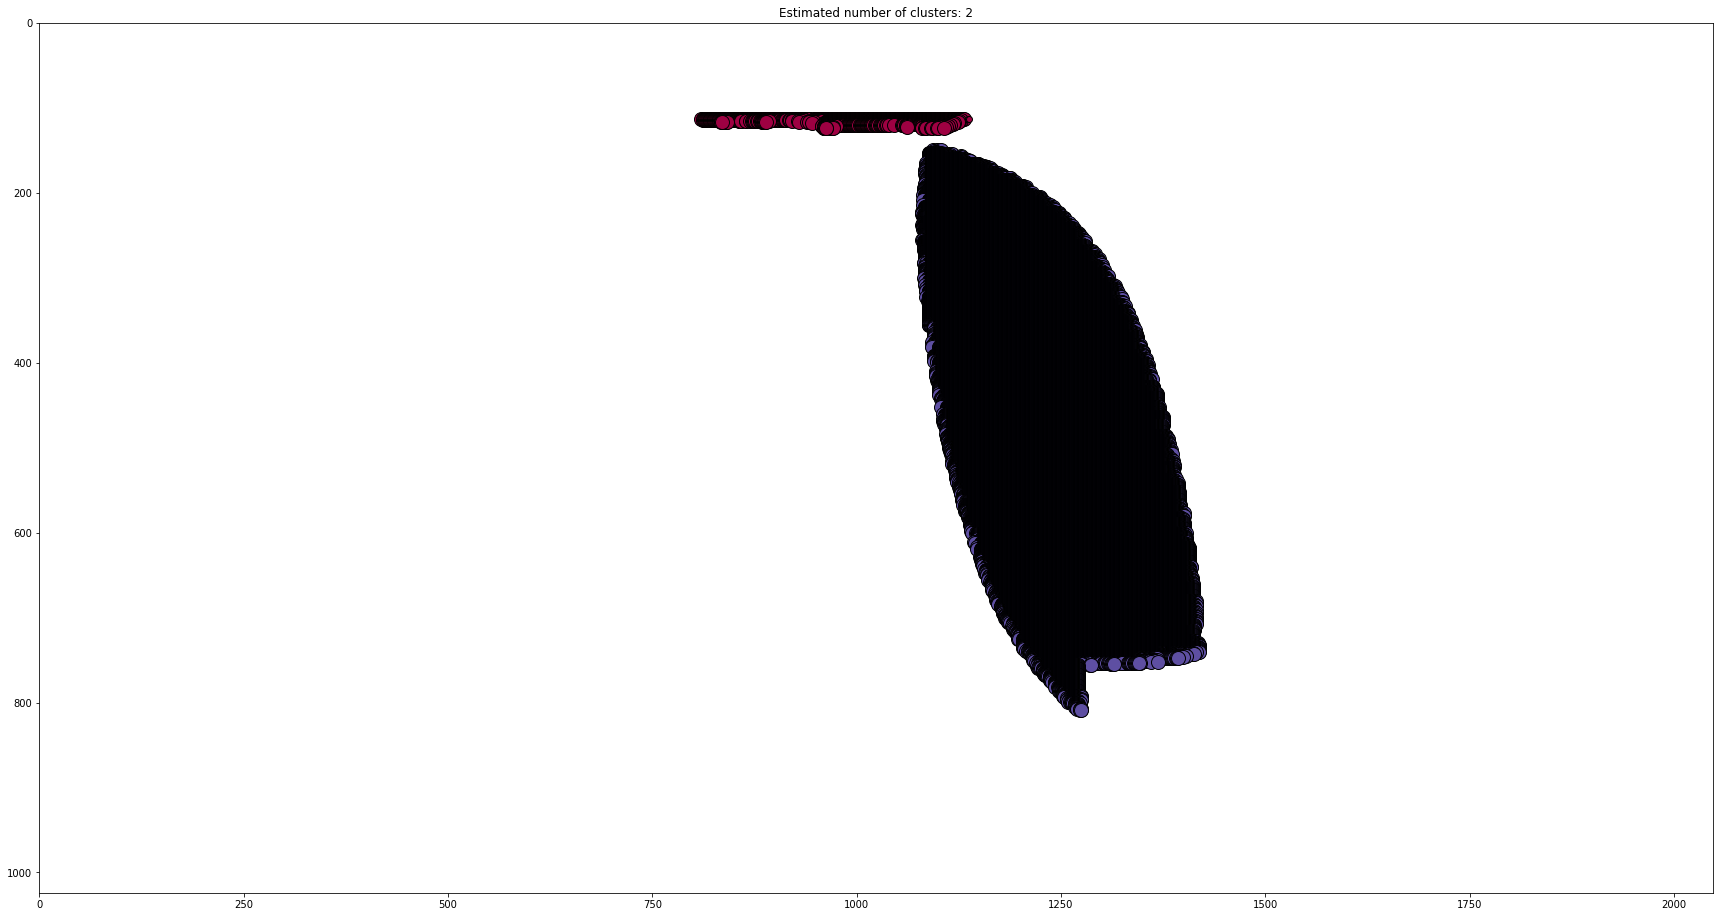

2018-02-17
Estimated number of clusters: 1
Writing labels to: data/4326/2018-02-17/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


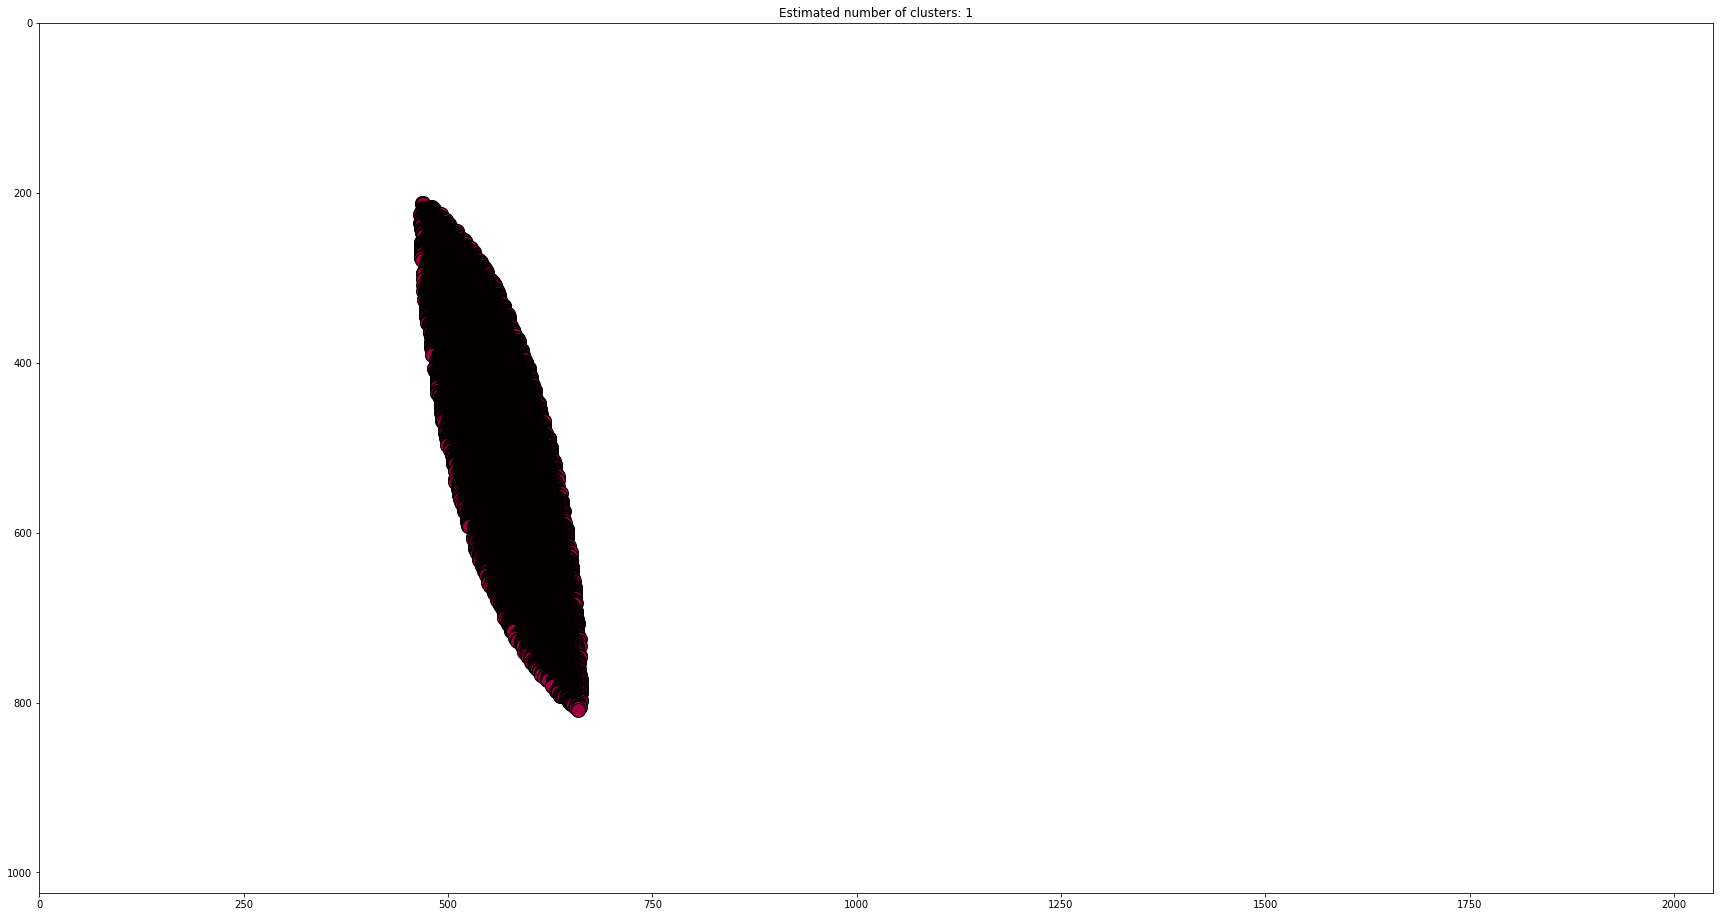

2018-02-26
Estimated number of clusters: 1
Writing labels to: data/4326/2018-02-26/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


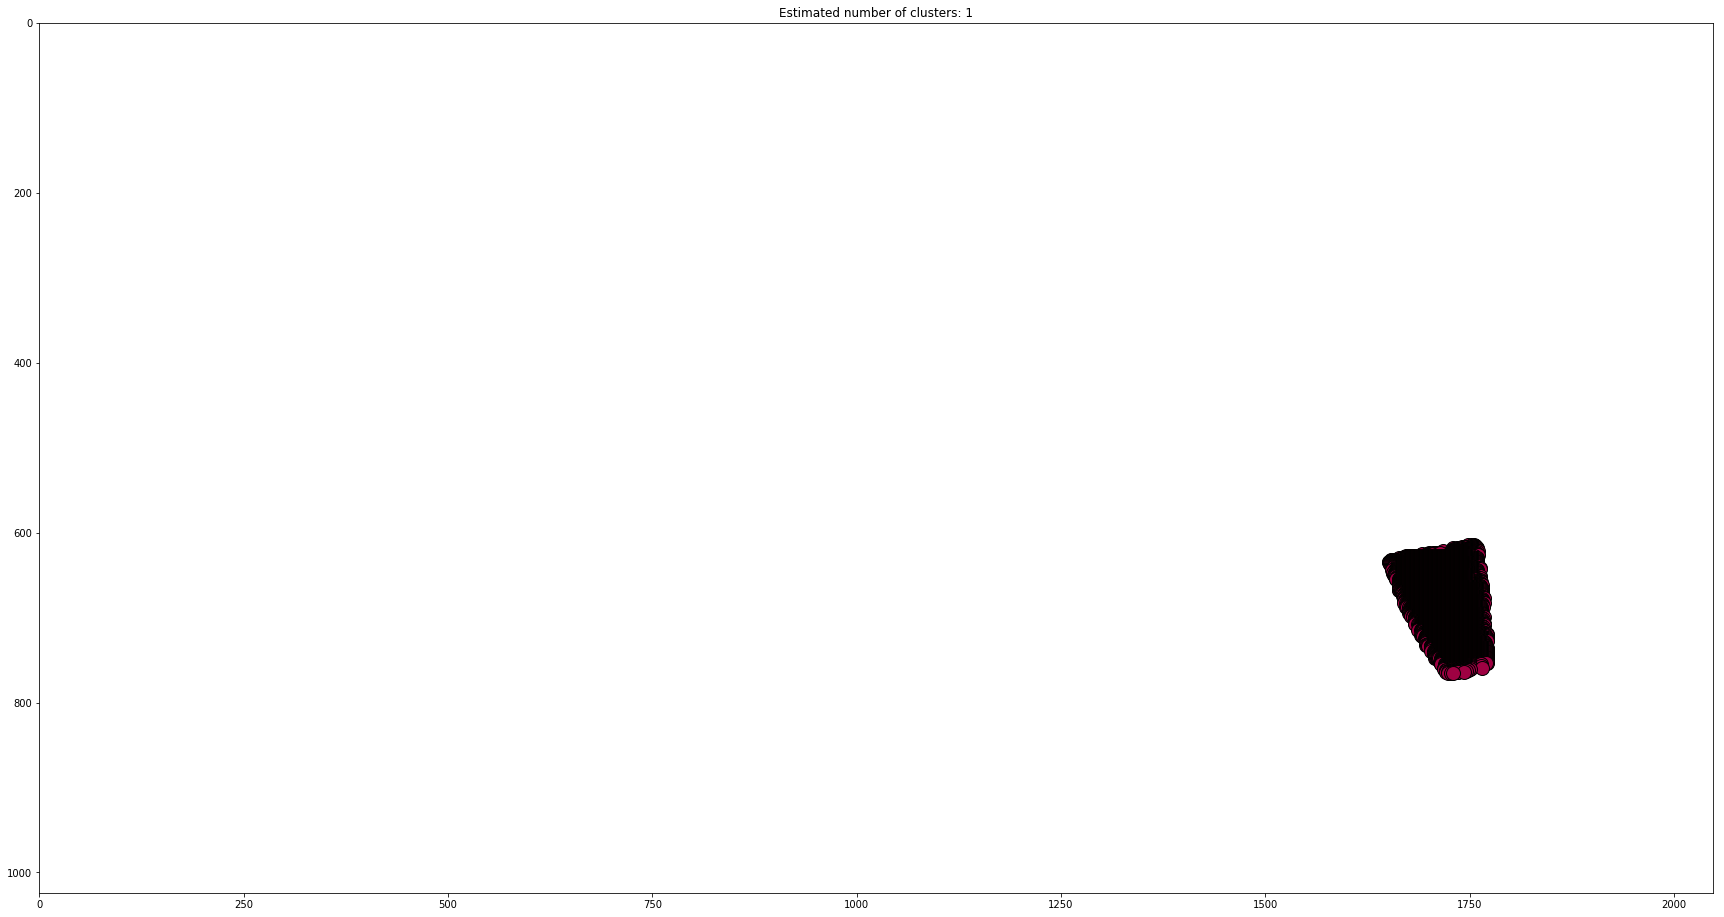

2018-03-10
Estimated number of clusters: 1
Writing labels to: data/4326/2018-03-10/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


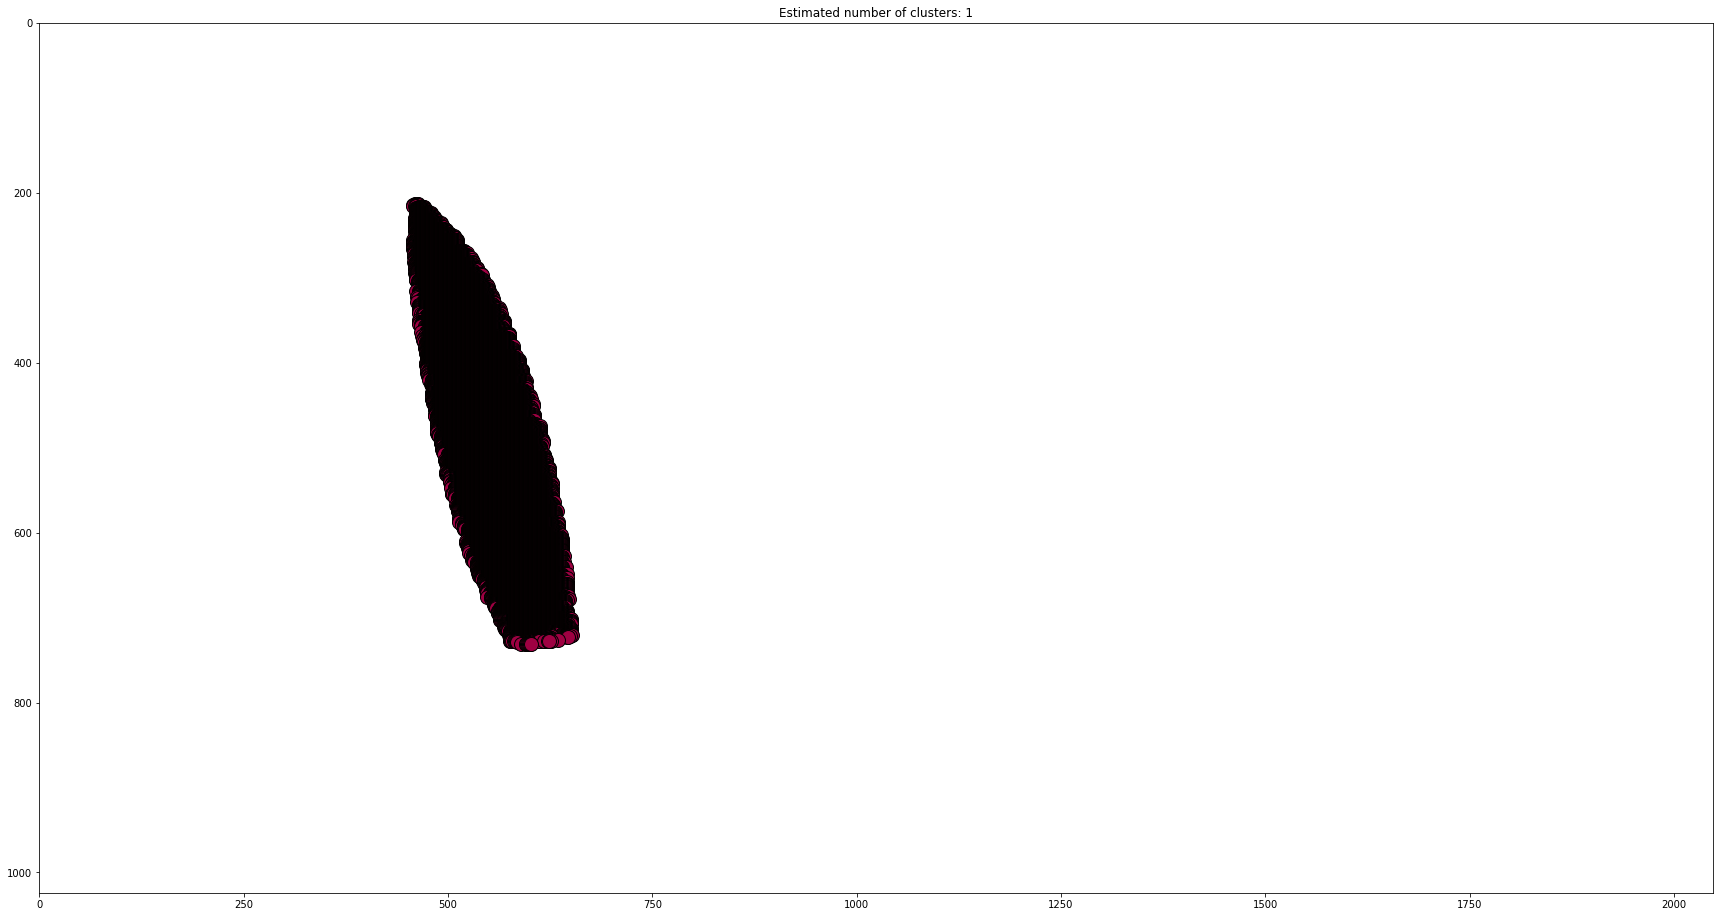

2018-03-27
Estimated number of clusters: 26
Writing labels to: data/4326/2018-03-27/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


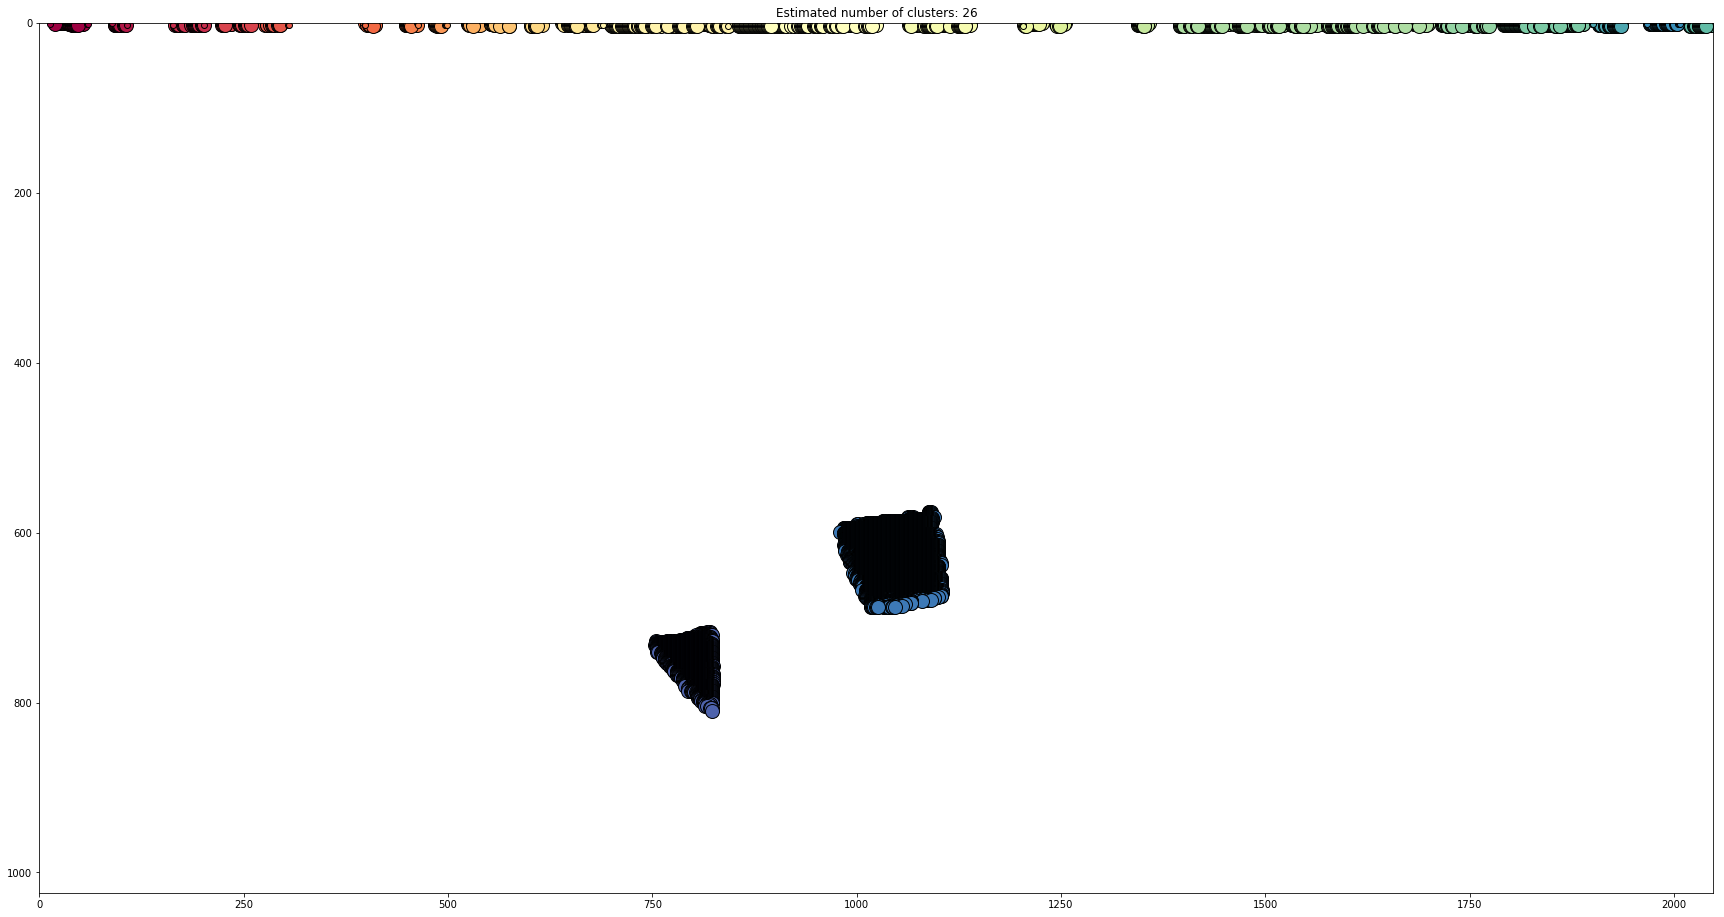

2018-04-19
Estimated number of clusters: 1
Writing labels to: data/4326/2018-04-19/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


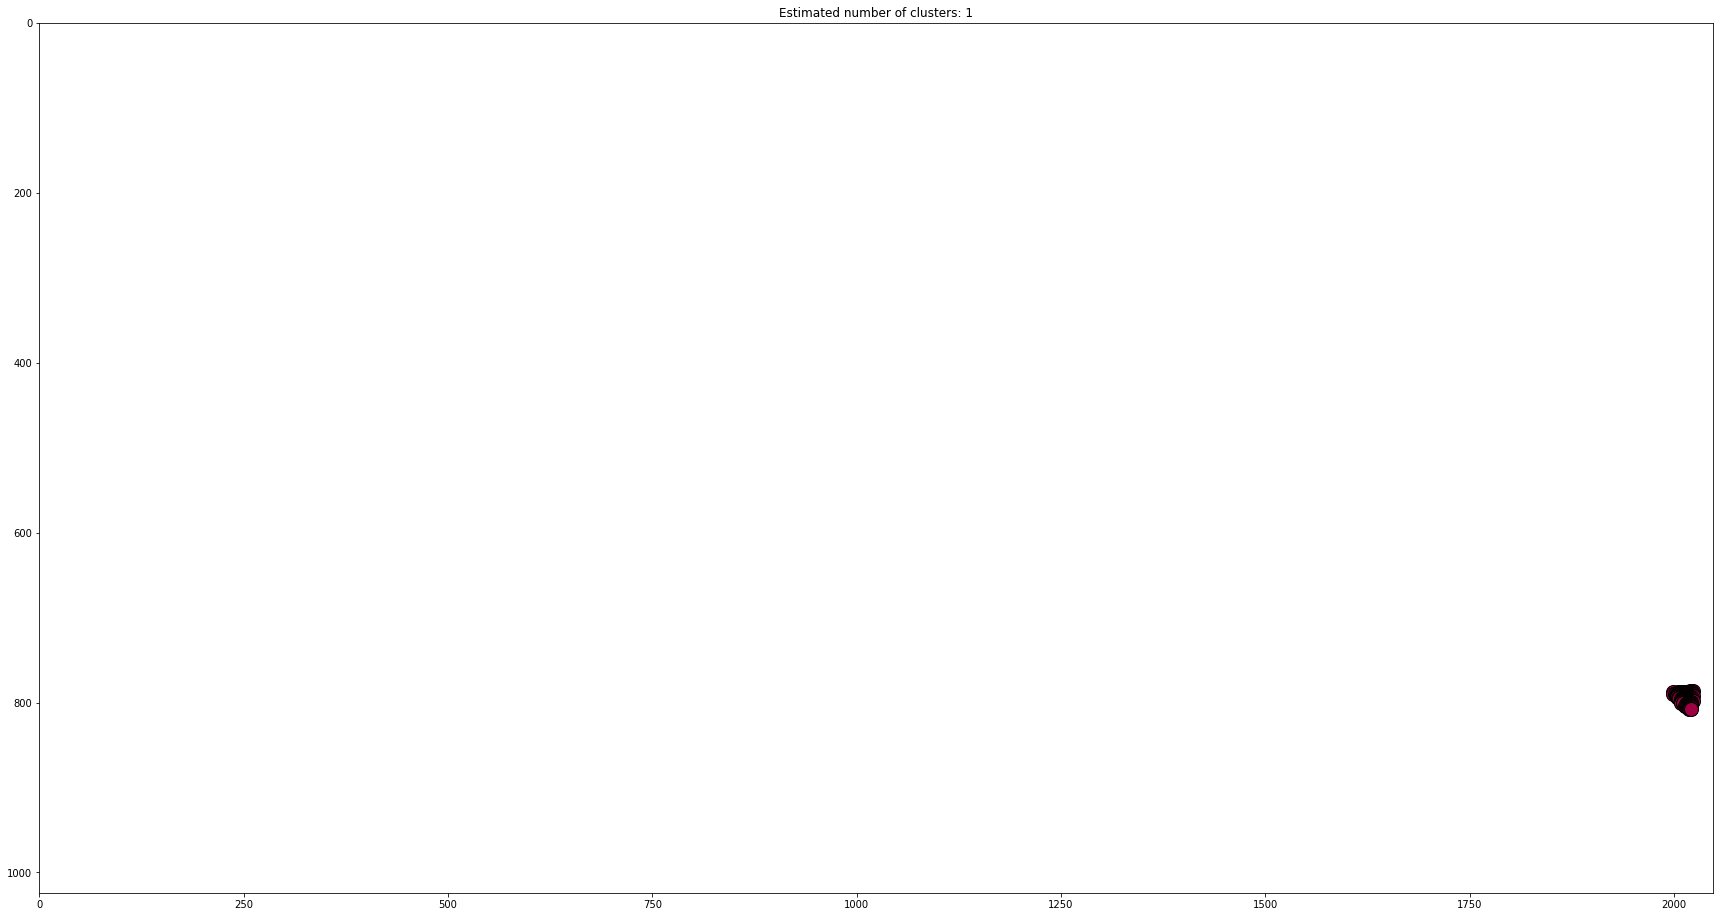

2018-04-25
Estimated number of clusters: 1
Writing labels to: data/4326/2018-04-25/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


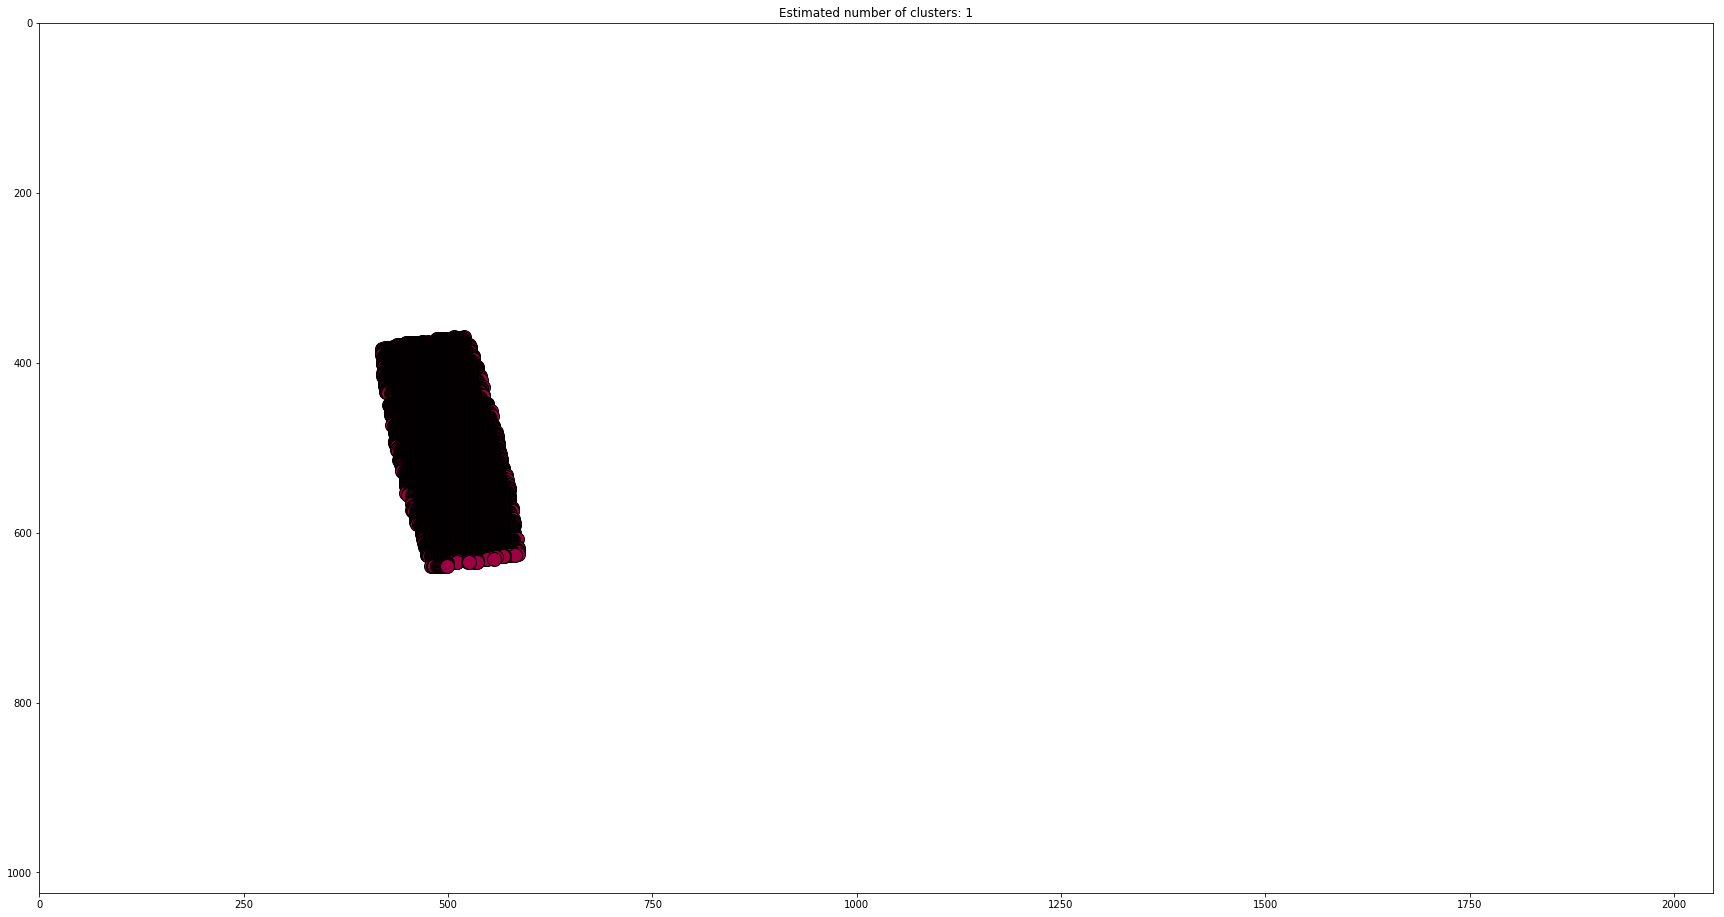

2018-05-25
Estimated number of clusters: 1
Writing labels to: data/4326/2018-05-25/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


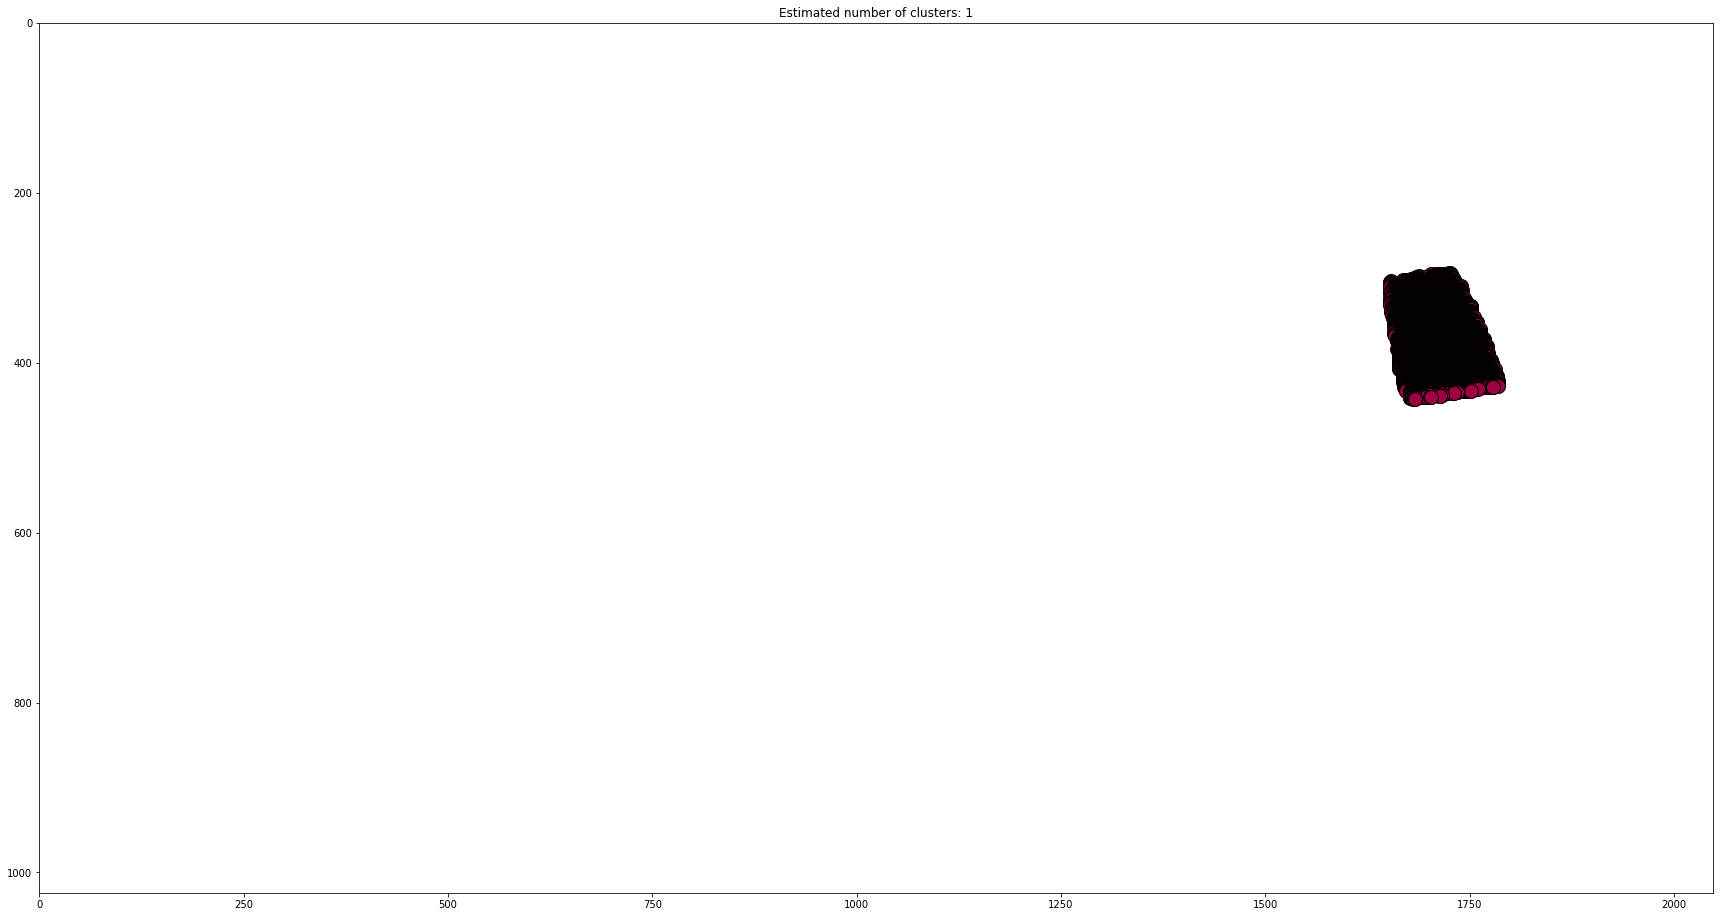

2018-06-21
Estimated number of clusters: 3
Writing labels to: data/4326/2018-06-21/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


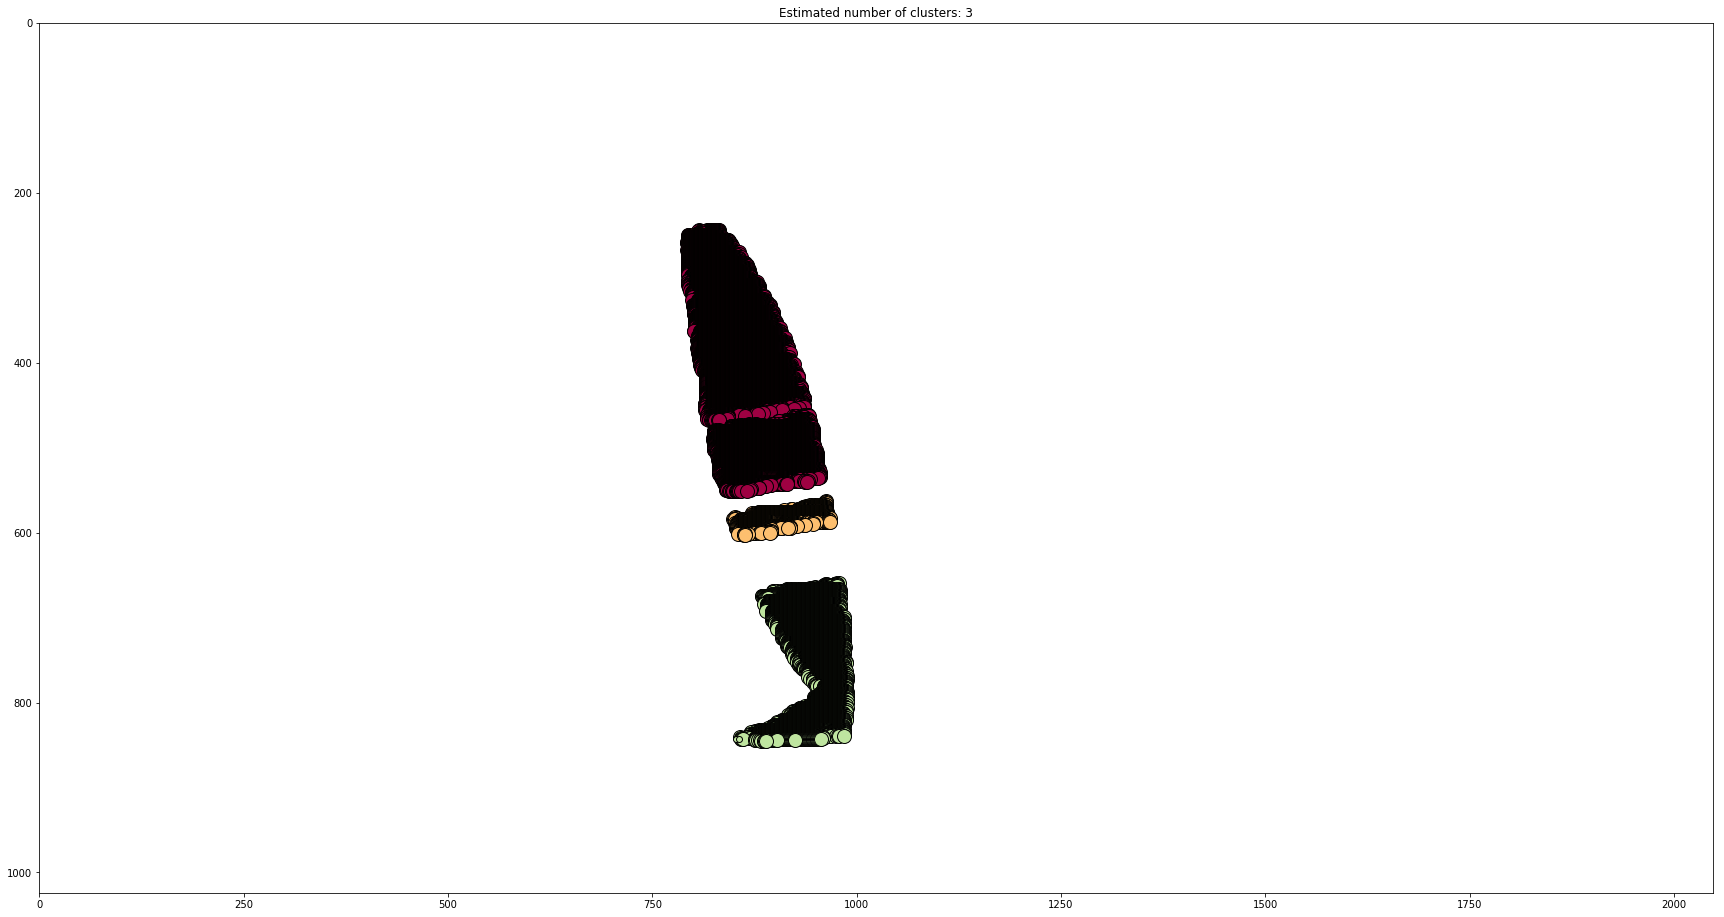

2018-06-23
Estimated number of clusters: 1
Writing labels to: data/4326/2018-06-23/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
-------


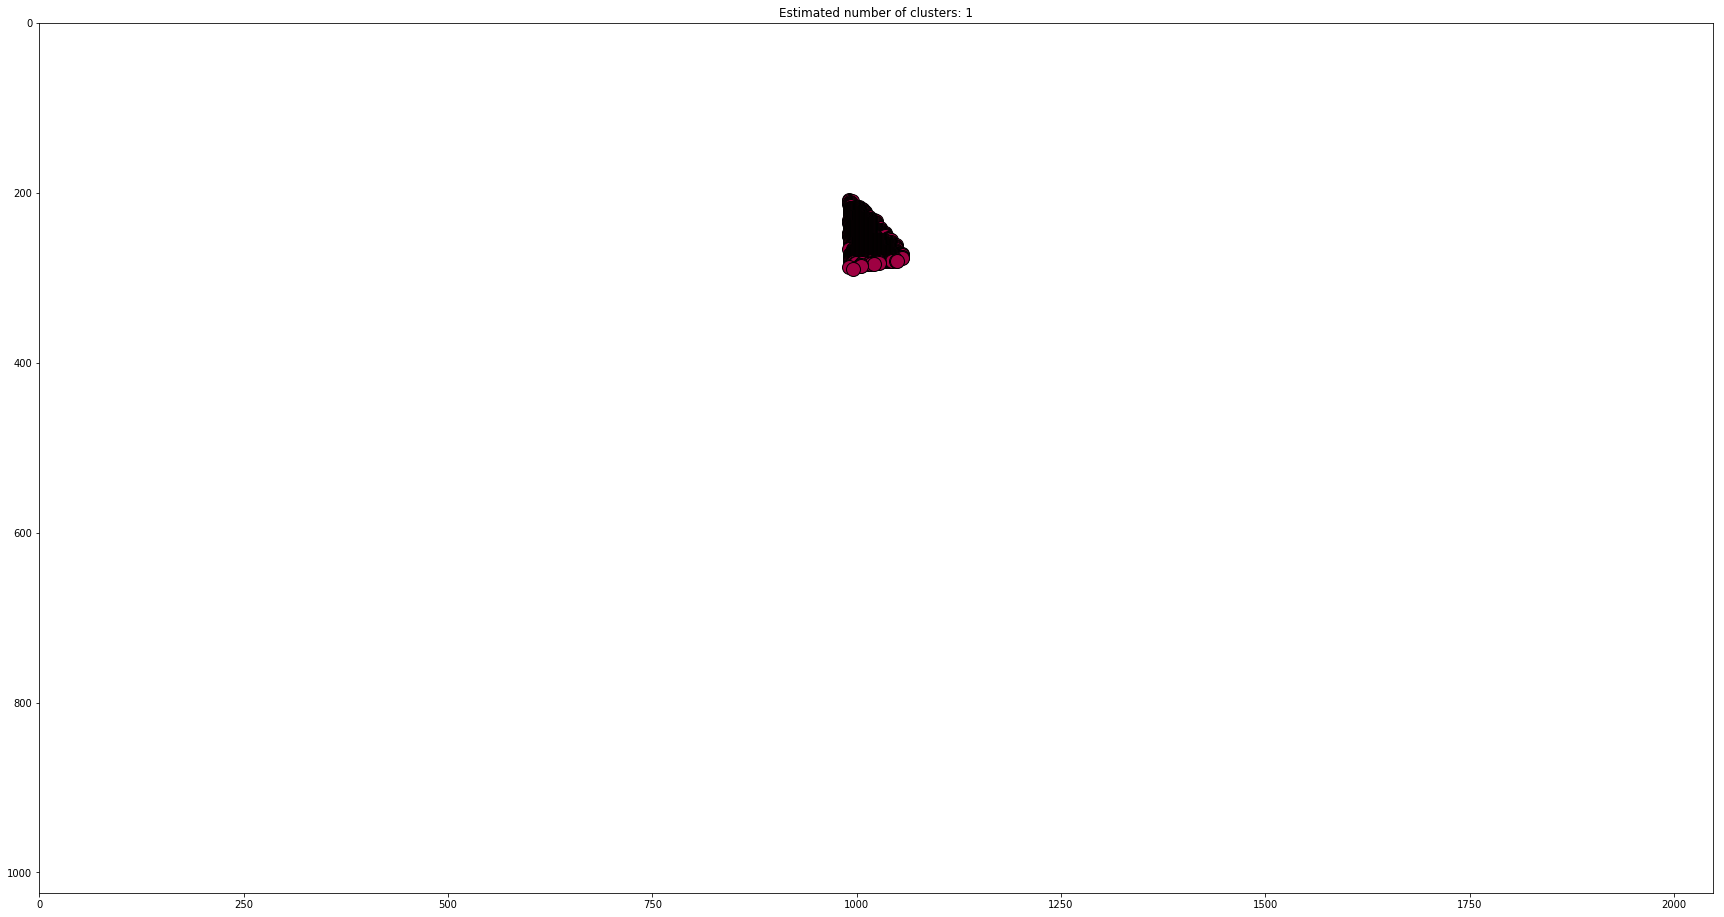

In [30]:
layer_name = 'VIIRS_SNPP_CorrectedReflectance_TrueColor'
img_extension = ".jpg"
data_dir = 'data/4326/'
labels_file = os.path.join(data_dir, layer_name + ".txt")
img_size = (2048, 1024)

# Check the labels file exists!
assert os.path.exists(labels_file), "Cannot find the {} file".format(layer_name + ".txt")

# Read in the file line by line
with open(labels_file) as f:
    file_lines = f.read().splitlines()
    num_total_img = len(file_lines)
    for line in file_lines:
        line_list = line.split()  
        split = line_list[0]
        datestring = line_list[1]
        label_arr = [int(item) for item in line_list[2:]]
        label = parse_labels(label_arr)
        
        # Skip normal images
        if label == 0: 
            continue
        
        # Print the non-normal image date!
        print(datestring)
        
        # Construct and resize the image
        filename = os.path.join(data_dir, datestring, layer_name + img_extension)
        image = np.asarray(Image.open(filename).resize(img_size, Image.NEAREST))

        # Grayscale the image
        imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # Threshold the image to black and white
        _, im_thresh = cv2.threshold(imgray, 0, 1, cv2.THRESH_BINARY_INV)
        
        # Large amount of missing data
        labels_im = None
        ratio_missing_pixel_data = 1.0 - (im_thresh == 0).sum() / im_thresh.size
        if ratio_missing_pixel_data > 0.50:
            labels_im = im_thresh
        elif ratio_missing_pixel_data > 0.30:
            im_thresh = crop_no_data(im_thresh, buffer_erase=25)
            labels_im = im_thresh
        else:
            # Remove the top and bottom missing data
            im_thresh = crop_no_data(im_thresh, buffer_erase=25)
            # plt.imshow(im_thresh)

            # DBSCAN        
            # Featurize the image for DBscan
            X = get_img_feature_vector(im_thresh)
            X_white = X[X[:,0] == 1]
            X_white = X_white[:,1:]
            X = X_white

            # Run DBscan clustering algorithm!
            db = DBSCAN(eps=10, min_samples=10).fit(X)
            core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
            core_samples_mask[db.core_sample_indices_] = True
            labels = db.labels_

            # Number of clusters in labels, ignoring noise if present.
            n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
            print('Estimated number of clusters: %d' % n_clusters_)

            # Create an image mask for labels
            labels_im = np.zeros_like(im_thresh)

            # Black removed and is used for noise instead.
            unique_labels = set(labels)
            colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
            for k, col in zip(unique_labels, colors):
                if k == -1:
                    # Black used for noise.
                    col = [0, 0, 0, 1]

                # Hide the outliers!
                if col == [0, 0, 0, 1]:
                     continue

                class_member_mask = (labels == k)

                # Retrieve the xy (hw) points
                class_xy = X[class_member_mask] # x = h, y = w

                # Label the target pixels as white (= 1)!
                labels_im[class_xy[:,0], class_xy[:,1]] = 1

                # Plot the clusters!
                core_xy = X[class_member_mask & core_samples_mask]
                plt.plot(core_xy[:, 1], core_xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

                noncore_xy = X[class_member_mask & ~core_samples_mask]
                plt.plot(noncore_xy[:, 1], noncore_xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

        labels_filename = os.path.join(data_dir, datestring, 'VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain' + '.png')
        print("Writing labels to:", labels_filename)
        imageio.imwrite(labels_filename, 255 * labels_im)
        
        print("-------")
        
        # Plot result
        plt.title('Estimated number of clusters: %d' % n_clusters_)
        plt.xlim(0, img_size[0])  # decreasing x
        plt.ylim(img_size[1], 0)  # decreasing y
        plt.show()

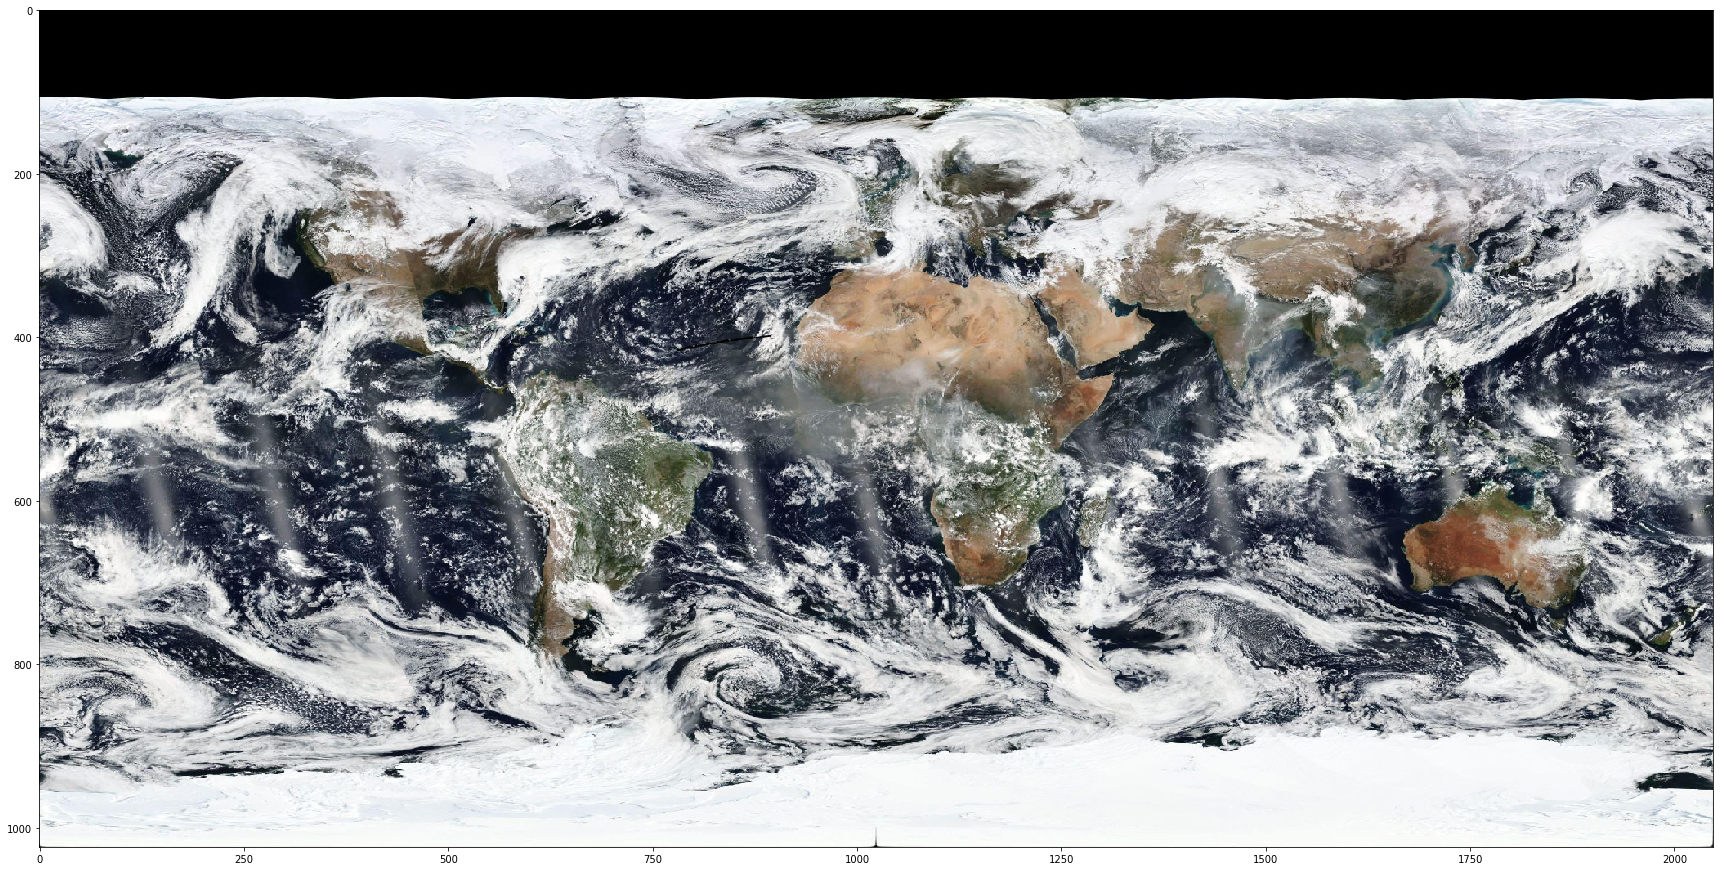

In [44]:
datestring = '2016-02-07'

# Construct and resize the image
filename = os.path.join(data_dir, datestring, layer_name + img_extension)
image = np.asarray(Image.open(filename).resize(img_size, Image.NEAREST))

plt.imshow(image)

Estimated number of clusters: 0


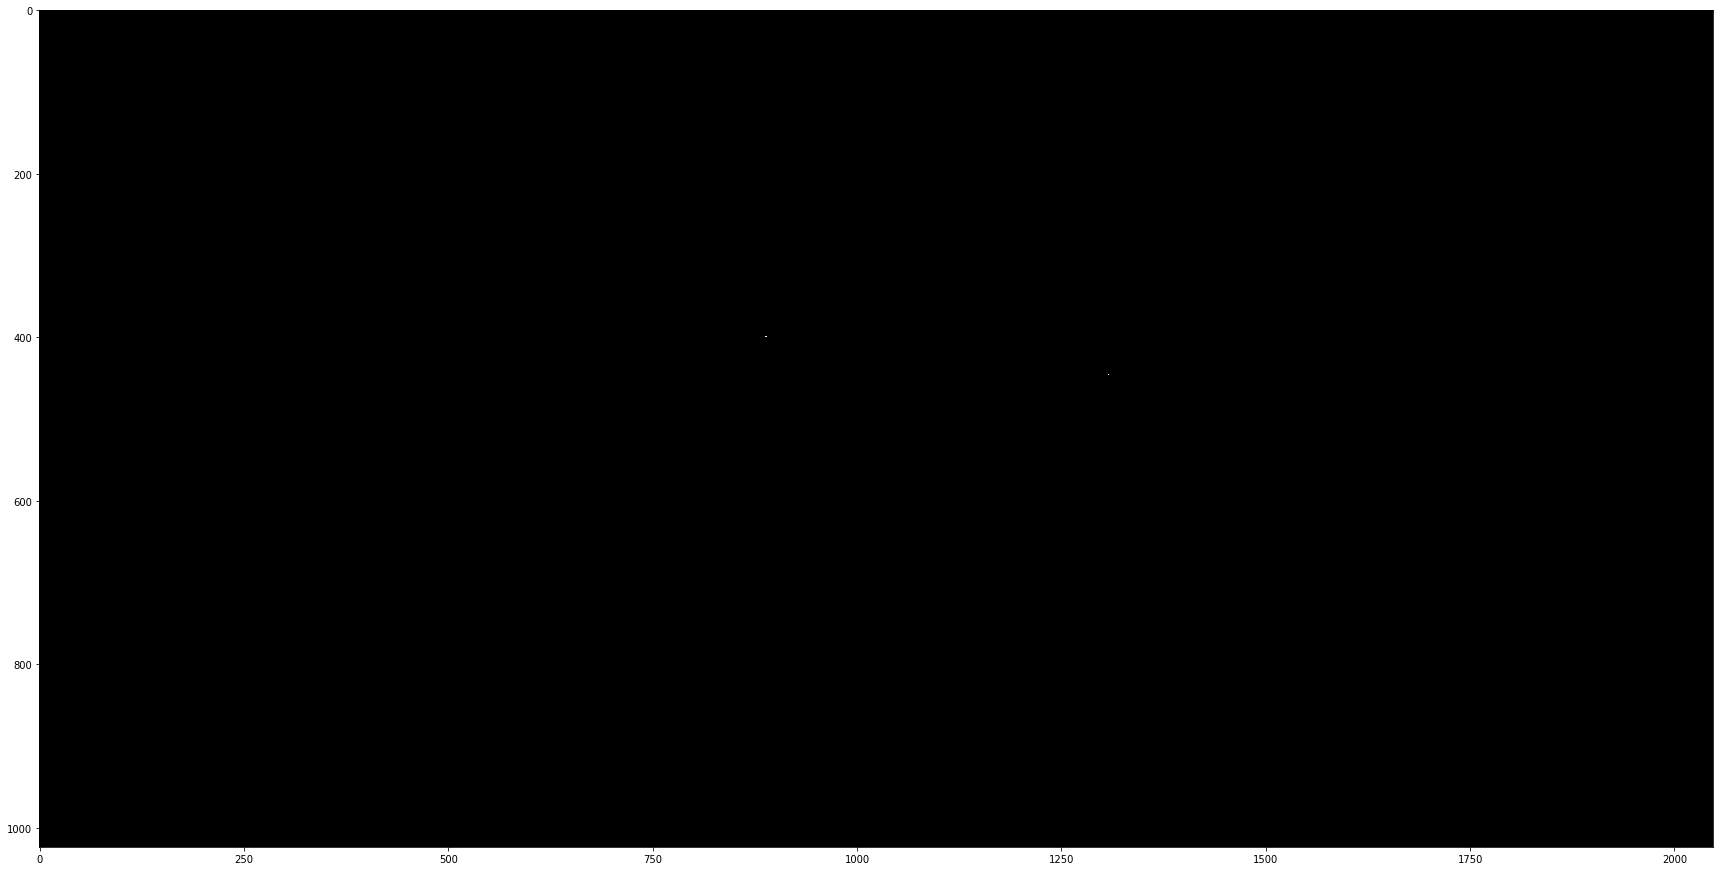

In [45]:
# Grayscale the image
imgray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Threshold the image to black and white
_, im_thresh = cv2.threshold(imgray, 0, 1, cv2.THRESH_BINARY_INV)

# Remove the top and bottom missing data
im_thresh = crop_no_data(im_thresh, buffer_erase=25)
plt.imshow(im_thresh)

# DBSCAN        
# Featurize the image for DBscan
X = get_img_feature_vector(im_thresh)
X_white = X[X[:,0] == 1]
X_white = X_white[:,1:]
X = X_white

# Run DBscan clustering algorithm!
db = DBSCAN(eps=10, min_samples=10).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)

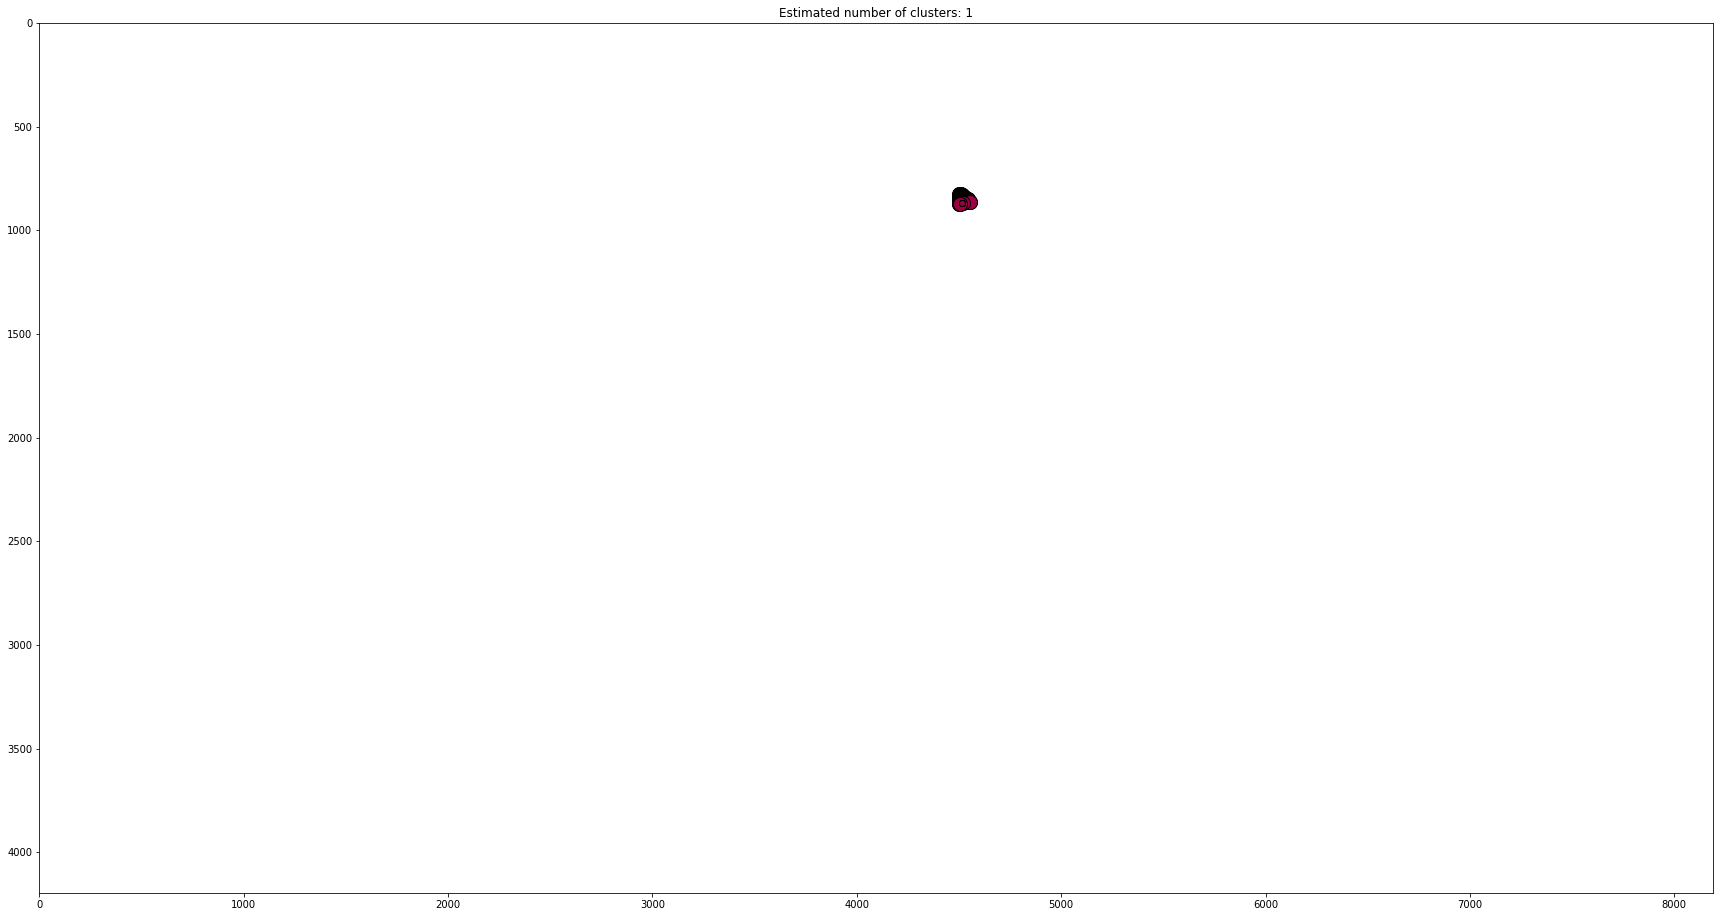

In [45]:
# Create an image mask fore labels
labels_im = np.zeros_like(im_thresh)

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    # Hide the outliers!
    if col == [0, 0, 0, 1]:
         continue

    class_member_mask = (labels == k)

    # Retrieve the xy (hw) points
    class_xy = X[class_member_mask] # x = h, y = w

    # Label the target pixels as white (= 1)!
    labels_im[class_xy[:,0], class_xy[:,1]] = 1

    # Plot the clusters!
    core_xy = X[class_member_mask & core_samples_mask]
    plt.plot(core_xy[:, 1], core_xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=14)

    noncore_xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(noncore_xy[:, 1], noncore_xy[:, 0], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)

# Plot result
plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.xlim(0, img_size[0])  # decreasing x
plt.ylim(img_size[1], 0)  # decreasing y
plt.show()

In [43]:
labels_filename = os.path.join(data_dir, datestring, 'VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain' + '.png')
print("Writing labels to:", labels_filename)
imageio.imwrite(labels_filename, 255 * im_thresh)

Writing labels to: data/4326/2016-04-03/VIIRS_SNPP_CorrectedReflectance_Missing_Data_Certain.png
